In [1]:
import pandas as pd
import warnings
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML 
# display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
train=pd.read_csv("train_data.csv")
test=pd.read_csv("test_data.csv")
import pandas_profiling as pdp
df=pd.concat([train,test],sort=False)


In [2]:
import pandas_profiling as pdp
def preprocess():
    train=pd.read_csv("train_data.csv")
    test=pd.read_csv("test_data.csv")
    df=pd.concat([train,test],sort=False)
    df.age=df.age.map(lambda x:57 if x>58 else x)
    df.num_child=df.num_child.map(lambda x:7 if x>7 else x)
    df.study_time=df.study_time.map(lambda x:17 if x>17 else x)
    df["familiy_num"]=1+df.partner+df.num_child
    arealist=list(train.groupby("area").mean().salary.sort_values().index)
    areadic={}
    for i,area in enumerate(arealist):
        areadic[area]=i+1
    df.area=df.area.map(areadic)
    df.position=df.position+1
    df.sex=df.sex-1
    df.salary=np.log(df.salary)
    df["agexposition"]=df.age*df.position.map(lambda x:1.5 if x==1 else x)
    df.education=df.education+1
#     df.drop(["sex"],axis=1)
    train=df.dropna().drop(["id"],axis=1)
    test=df[df.salary.isnull()].drop(["id"],axis=1)
    test=test.drop(["salary",],axis=1)
    X = train.drop(["salary"],axis=1)
    y = train.salary
    return X,y,test,df
X,y,test,df=preprocess()
#original 23.625521293118492
train=pd.concat([X,y],axis=1)

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
model=lgb.LGBMRegressor(**{'booster': 'gblinear',
                           'iterations': 309, 'depth': 16, 'learning_rate': 0.1,
                           'random_strength': 48, 'bagging_temperature': 19.715729096205934, 
                           'od_type': 'Iter', 'od_wait': 26, 'lambda_l1': 0.726486176355415, 
                           'lambda_l2': 0.00044177449020498015, 'num_leaves': 188,
                           'feature_fraction': 0.9443254919883529, 'bagging_fraction': 0.9271673814820428, 
                           'bagging_freq': 2, 'min_child_samples': 17})
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())

[22.577470914009222, 22.33568473300726, 22.96702015021395, 22.86462929458672, 21.959873464946703]
22.540935711352773


# Learning

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [6]:
pdp.ProfileReport(df)

In [7]:
from sklearn.ensemble import RandomForestRegressor as RFR
import numpy as np
from sklearn.metrics import mean_absolute_error

rg = RFR(n_jobs=-1, random_state=2525)
 
rg.fit(train_X,train_y)
print(rg.score(valid_X,valid_y))
from sklearn.metrics import mean_squared_error
score=mean_absolute_error(np.exp(valid_y),np.exp(rg.predict(valid_X)))
print(f'MAE:{score:4f}')
fti = rg.feature_importances_

print('Feature Importances:')
for i,feat in enumerate(valid_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))
col_names = test.columns.values
col_names_ = col_names[np.argsort(rg.feature_importances_)[::-1]]
col_names_

0.9550358215611071
MAE:23.610391
Feature Importances:
	position   : 0.010766
	age        : 0.003914
	area       : 0.014661
	sex        : 0.001050
	partner    : 0.013310
	num_child  : 0.012098
	education  : 0.045353
	service_length : 0.004315
	study_time : 0.004520
	commute    : 0.209512
	overtime   : 0.025041
	familiy_num : 0.024246
	agexposition : 0.631216


array(['agexposition', 'commute', 'education', 'overtime', 'familiy_num',
       'area', 'partner', 'num_child', 'position', 'study_time',
       'service_length', 'age', 'sex'], dtype=object)

In [8]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
model=lgb.LGBMRegressor()
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())

[22.764094288724273, 22.792014845341466, 23.487210364564227, 23.352820410841307, 22.616116417087895]
23.00245126531183


# ModelSelection



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:17<02:33, 17.04s/it]

 20%|██        | 2/10 [00:27<02:00, 15.10s/it]

 30%|███       | 3/10 [00:34<01:28, 12.70s/it]

 40%|████      | 4/10 [00:50<01:21, 13.66s/it]

 50%|█████     | 5/10 [01:04<01:08, 13.69s/it]

 60%|██████    | 6/10 [01:04<00:38,  9.75s/it]

 70%|███████   | 7/10 [01:06<00:22,  7.39s/it]

 80%|████████  | 8/10 [01:07<00:10,  5.46s/it]

[21:15:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n



 90%|█████████ | 9/10 [01:22<00:08,  8.21s/it]

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


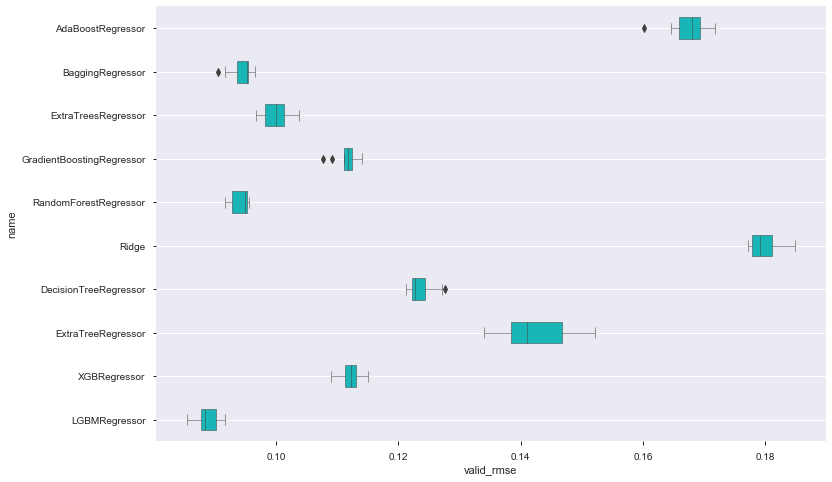

In [55]:
# 特徴量を選択して、複数のモデルで精度を調査する
from scipy.stats import mstats
from tqdm import tqdm
import matplotlib
from sklearn import metrics,  feature_selection, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
# from imblearn import under_sampling, over_sampling
from sklearn.metrics import make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
base_color = 'darkturquoise'
base_color2 = 'gray'

def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)
cm = generate_cmap([base_color2, 'white', base_color])

def rmse_score(y_true, y_pred):
    """RMSE (Root Mean Square Error: 平均二乗誤差平方根) を計算する関数"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

params={'booster': 'dart', 
        'alpha': 0.009385870161072372, 
        'max_depth': 9, 'eta': 2.3698818355249718e-07,
        'gamma': 3.167530221746867e-05, 
        'grow_policy': 'lossguide',
        'sample_type': 'weighted',
        'normalize_type': 'forest',
        'rate_drop': 3.1207262366715483e-08,
        'skip_drop': 1.2650261386504368e-05}


models = [
 
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
 
    #Gaussian Processes
#     gaussian_process.GaussianProcessRegressor(),
    
    #GLM
    linear_model.Ridge(),

    
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
 
    #xgboost
    xgb. XGBRegressor(),
    lgb.LGBMRegressor(),
#     cat.CatBoostRegressor(),
    
]
 
df_compare = pd.DataFrame(columns=['name', 'train_rmse', 'valid_rmse', 'time'])
score_funcs = {
    'rmse': make_scorer(rmse_score),
}

for model in tqdm(models):
    
    name = model.__class__.__name__
    
    cv_rlts = model_selection.cross_validate(model,X,y, scoring=score_funcs, cv=10, return_train_score=True)
 
    for i in range(10):
        s = pd.Series([name, cv_rlts['train_rmse'][i], cv_rlts['test_rmse'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name=name+str(i))
        df_compare = df_compare.append(s)
        
plt.figure(figsize=(12,8))
sns.boxplot(data=df_compare, y='name', x='valid_rmse', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

In [10]:
cols = X.columns.tolist()
 
# positive_cnt = int(df['salary'].sum())

feature_importance_models = [
    ensemble.AdaBoostRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    tree.DecisionTreeRegressor(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
]
 
scoring = ['rsme']
df_rfe_cols_cnt = pd.DataFrame(columns=['cnt'], index=cols)
df_rfe_cols_cnt['cnt'] = 0
 
for i, model in tqdm(enumerate(feature_importance_models), total=len(feature_importance_models)):
    
    rfe = feature_selection.RFECV(model, step=3)
    rfe.fit(X, y)
#     print(rfe.get_support())
    rfe_cols = X[cols].columns.values[rfe.get_support()]
    df_rfe_cols_cnt.loc[rfe_cols, 'cnt'] += 1
    
df_rfe_cols_cnt.plot(kind='bar', color=base_color, figsize=(15, 5))
plt.show()


  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
x_cols = df_rfe_cols_cnt[df_rfe_cols_cnt['cnt'] < 4].index
X=X.drop(x_cols,axis=1)
test=test.drop(x_cols,axis=1)
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

## XGBoost+optuna

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import r2_score

class RidgeCV():
    model_cls = Ridge

    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
        elif isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
            y = y.reset_index(drop=True)

        self.X = X
        self.y = y

        study = optuna.create_study(direction='maximize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        self.best_model = self.model_cls(**self.best_trial.params)
        self.best_model.fit(self.X, self.y)

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X.values.reshape(1, -1))
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        return self.best_model.predict(X)

    def score(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)

        return self.best_model.score(X, y)

    def kfold_cv(self, model, splits=5):
        scores = []

        kf = KFold(n_splits=splits, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(r2_score(model.predict(X_test), y_test))

        score = np.array(scores).mean()
        return score

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

class XGBRegressorCV(RidgeCV):
    model_cls = xgb.XGBRegressor

    def __call__(self, trial):
        booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
        alpha = trial.suggest_loguniform('alpha', 1e-8, 1.0)

        max_depth = trial.suggest_int('max_depth', 1, 20)
        eta = trial.suggest_loguniform('eta', 1e-8, 1.0)
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        grow_policy = trial.suggest_categorical(
            'grow_policy', ['depthwise', 'lossguide'])

        if booster == 'gbtree':
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy)
        elif booster == 'dart':
            sample_type = trial.suggest_categorical('sample_type',
                                                    ['uniform', 'weighted'])
            normalize_type = trial.suggest_categorical('normalize_type',
                                                       ['tree', 'forest'])
            rate_drop = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
            skip_drop = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,
                                   sample_type=sample_type,
                                   normalize_type=normalize_type,
                                   rate_drop=rate_drop, skip_drop=skip_drop)

        score = self.kfold_cv(model)
        return score

xgbr = XGBRegressorCV(n_trials=20)
xgbr.fit(X, y)

# pred_y=xgbr.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(xgbr.predict(valid_X)))
# print(f'MAE:{score:4f}')
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# kf = KFold(n_splits=3, shuffle=True, random_state=0)
# model = XGBRegressorCV(n_trials=10)
# scores = []


# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model.fit(X_train, y_train)
#     scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
# print(scores)
# print(np.array(scores).mean())
#MAE:22.821581(drop)dummy
#MAE:22.753628(nodrop)dummy

[I 2019-11-23 22:11:31,171] Finished trial#0 resulted in value: 0.7383516518332078. Current best value is 0.7383516518332078 with parameters: {'booster': 'dart', 'alpha': 1.2142111128558845e-06, 'max_depth': 12, 'eta': 0.1318704877294994, 'gamma': 0.0004640533419807797, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.02983844194010773, 'skip_drop': 3.9492630266357136e-07}.
[I 2019-11-23 22:11:43,527] Finished trial#1 resulted in value: 0.9593632011957647. Current best value is 0.9593632011957647 with parameters: {'booster': 'gbtree', 'alpha': 3.3769476580527166e-07, 'max_depth': 9, 'eta': 0.0021156659765582944, 'gamma': 0.009399944531342823, 'grow_policy': 'lossguide'}.
[I 2019-11-23 22:12:05,592] Finished trial#2 resulted in value: 0.9591074987153426. Current best value is 0.9593632011957647 with parameters: {'booster': 'gbtree', 'alpha': 3.3769476580527166e-07, 'max_depth': 9, 'eta': 0.0021156659765582944, 'gamma': 0.00939994453134282

# LightGBM+optuna

In [56]:
# coding:utf-8
import lightgbm as lgb
# from sklearn.metrics import log_loss
def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / ( x_max - x_min)
    return x_norm
def min_max_renormalization(x1,x2):
    x_min = x2.min()
    x_max = x2.max()
#     x_norm = (x2 - x_min) / ( x_max - x_min)
    x=x1*  ( x_max - x_min)+x_min
    return x

import lightgbm as lgb
# from sklearn.metrics import log_loss
cat_list = ['area', 'sex', 'partner','education']
class LGBRegressorCV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'eval_metric':'mae',
            'booster':trial.suggest_categorical('booster',['gbtree','gblinear']),
            'loss_function': 'fair',
            'iterations' : trial.suggest_int('iterations', 50, 400),                      
#             'depth' : trial.suggest_int('depth', 4, 25),  
            'depth':16,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50),
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressorCV(n_trials=20)
kf = KFold(n_splits=3, shuffle=True, random_state=0)
model = XGBRegressorCV(n_trials=20)
model.fit(X,y)
scores = []


# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model.fit(X_train, y_train)
#     scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
# print(scores)
# print(np.array(scores).mean())
# checktesty=valid_y.sort_values()
# checktestX=valid_X.ix[list(checktesty.index)]
# checktesty=checktesty.reset_index(drop=True)#これと

# checkpred=pd.DataFrame(model.predict(checktestX))#これ
# check=pd.concat([checktesty,checkpred], axis=1)
# check.columns=["actual","predict"]
# check.plot(alpha=0.5)
#MAE:23.144563 (nodrop)dummy
#MAE:23.742147(drop)dummy
#MAE:23.902507nodummy

[I 2019-11-23 21:20:16,876] Finished trial#0 resulted in value: -0.32117053259452993. Current best value is -0.32117053259452993 with parameters: {'booster': 'dart', 'alpha': 7.888570604730185e-06, 'max_depth': 14, 'eta': 0.7216809812283436, 'gamma': 0.0005722983383612574, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.15565477728810653, 'skip_drop': 5.400077709728601e-06}.
[I 2019-11-23 21:20:35,736] Finished trial#1 resulted in value: 0.9576380069479338. Current best value is 0.9576380069479338 with parameters: {'booster': 'gbtree', 'alpha': 2.7818378754724686e-08, 'max_depth': 14, 'eta': 0.02212657390063813, 'gamma': 1.4112023237036167e-08, 'grow_policy': 'depthwise'}.
[I 2019-11-23 21:21:12,477] Finished trial#2 resulted in value: -11.904610703844236. Current best value is 0.9576380069479338 with parameters: {'booster': 'gbtree', 'alpha': 2.7818378754724686e-08, 'max_depth': 14, 'eta': 0.02212657390063813, 'gamma': 1.41120232370361


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.8798079145273852, 'max_depth': 9, 'eta': 2.676996448484354e-06, 'gamma': 2.1660310053333031e-07, 'grow_policy': 'depthwise'}

[21:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
    
class LGBRegressor1CV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'loss_function': 'xentropy loss',
            'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 8, 20), 
#             'depth':16,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressor1CV(n_trials=20)
train_ylgm=min_max_normalization(train_y)
model.fit(train_X,train_ylgm)

pred_y=min_max_renormalization(model.predict(valid_X),train_y)
score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
print(f'MAE:{score:4f}')
pred=model.predict(test)


## CatBoost+optuna(non recomended)

In [58]:
from catboost import CatBoost
# from sklearn.metrics import log_loss

class CatRegressorCV(RidgeCV):
    model_cls = CatBoost
    def __call__(self, trial):
        params = {
            'loss_function': 'MAE',
#             'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 6, 10),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(params)
        score = self.kfold_cv(model)
        return score
model=CatRegressorCV(n_trials=10)
# model=CatBoost({'depth': 7, 'learning_rate': 0.074638569770399, 'random_strength': 59, 'bagging_temperature': 0.011038111194790014, 'od_type': 'IncToDec', 'od_wait': 12})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
model.fit(X,y)

# pred_y=model.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
# print(f'MAE:{score:4f}')
# pred=model.predict(test)

0:	learn: 5.6984525	total: 11.1ms	remaining: 11.1s
1:	learn: 5.6112468	total: 25.2ms	remaining: 12.6s
2:	learn: 5.5258190	total: 59.1ms	remaining: 19.6s
3:	learn: 5.4407240	total: 78.6ms	remaining: 19.6s
4:	learn: 5.3573599	total: 93.6ms	remaining: 18.6s
5:	learn: 5.2749012	total: 109ms	remaining: 18.1s
6:	learn: 5.1941112	total: 123ms	remaining: 17.5s
7:	learn: 5.1143505	total: 133ms	remaining: 16.5s
8:	learn: 5.0356224	total: 165ms	remaining: 18.1s
9:	learn: 4.9581319	total: 179ms	remaining: 17.7s
10:	learn: 4.8815372	total: 192ms	remaining: 17.3s
11:	learn: 4.8067751	total: 204ms	remaining: 16.8s
12:	learn: 4.7328973	total: 220ms	remaining: 16.7s
13:	learn: 4.6604882	total: 238ms	remaining: 16.8s
14:	learn: 4.5891428	total: 251ms	remaining: 16.5s
15:	learn: 4.5186015	total: 264ms	remaining: 16.3s
16:	learn: 4.4493116	total: 287ms	remaining: 16.6s
17:	learn: 4.3812467	total: 301ms	remaining: 16.4s
18:	learn: 4.3137398	total: 320ms	remaining: 16.5s
19:	learn: 4.2478637	total: 334ms	re

161:	learn: 0.4924389	total: 3.16s	remaining: 16.4s
162:	learn: 0.4852016	total: 3.18s	remaining: 16.3s
163:	learn: 0.4782964	total: 3.2s	remaining: 16.3s
164:	learn: 0.4714602	total: 3.22s	remaining: 16.3s
165:	learn: 0.4645760	total: 3.23s	remaining: 16.3s
166:	learn: 0.4578611	total: 3.26s	remaining: 16.3s
167:	learn: 0.4513435	total: 3.28s	remaining: 16.2s
168:	learn: 0.4449910	total: 3.29s	remaining: 16.2s
169:	learn: 0.4386669	total: 3.31s	remaining: 16.2s
170:	learn: 0.4324912	total: 3.32s	remaining: 16.1s
171:	learn: 0.4261683	total: 3.34s	remaining: 16.1s
172:	learn: 0.4200195	total: 3.35s	remaining: 16s
173:	learn: 0.4141080	total: 3.36s	remaining: 16s
174:	learn: 0.4078346	total: 3.38s	remaining: 15.9s
175:	learn: 0.4021061	total: 3.39s	remaining: 15.9s
176:	learn: 0.3962536	total: 3.41s	remaining: 15.8s
177:	learn: 0.3908238	total: 3.42s	remaining: 15.8s
178:	learn: 0.3854134	total: 3.44s	remaining: 15.8s
179:	learn: 0.3800651	total: 3.46s	remaining: 15.7s
180:	learn: 0.374

320:	learn: 0.1224238	total: 5.67s	remaining: 12s
321:	learn: 0.1222205	total: 5.69s	remaining: 12s
322:	learn: 0.1219438	total: 5.7s	remaining: 12s
323:	learn: 0.1216866	total: 5.72s	remaining: 11.9s
324:	learn: 0.1214641	total: 5.73s	remaining: 11.9s
325:	learn: 0.1212284	total: 5.74s	remaining: 11.9s
326:	learn: 0.1210669	total: 5.76s	remaining: 11.9s
327:	learn: 0.1208930	total: 5.78s	remaining: 11.8s
328:	learn: 0.1207237	total: 5.79s	remaining: 11.8s
329:	learn: 0.1205033	total: 5.81s	remaining: 11.8s
330:	learn: 0.1203128	total: 5.83s	remaining: 11.8s
331:	learn: 0.1200887	total: 5.84s	remaining: 11.8s
332:	learn: 0.1197675	total: 5.86s	remaining: 11.7s
333:	learn: 0.1196358	total: 5.87s	remaining: 11.7s
334:	learn: 0.1194828	total: 5.9s	remaining: 11.7s
335:	learn: 0.1193640	total: 5.92s	remaining: 11.7s
336:	learn: 0.1191881	total: 5.95s	remaining: 11.7s
337:	learn: 0.1190602	total: 5.97s	remaining: 11.7s
338:	learn: 0.1187894	total: 6s	remaining: 11.7s
339:	learn: 0.1186465	t

479:	learn: 0.1075974	total: 8.1s	remaining: 8.77s
480:	learn: 0.1075521	total: 8.11s	remaining: 8.75s
481:	learn: 0.1075294	total: 8.13s	remaining: 8.73s
482:	learn: 0.1074881	total: 8.14s	remaining: 8.71s
483:	learn: 0.1074584	total: 8.15s	remaining: 8.69s
484:	learn: 0.1073587	total: 8.17s	remaining: 8.67s
485:	learn: 0.1073501	total: 8.18s	remaining: 8.65s
486:	learn: 0.1073227	total: 8.2s	remaining: 8.63s
487:	learn: 0.1072731	total: 8.21s	remaining: 8.61s
488:	learn: 0.1072599	total: 8.22s	remaining: 8.6s
489:	learn: 0.1071515	total: 8.24s	remaining: 8.57s
490:	learn: 0.1071215	total: 8.25s	remaining: 8.55s
491:	learn: 0.1071126	total: 8.27s	remaining: 8.54s
492:	learn: 0.1070720	total: 8.28s	remaining: 8.52s
493:	learn: 0.1070585	total: 8.3s	remaining: 8.5s
494:	learn: 0.1069775	total: 8.32s	remaining: 8.48s
495:	learn: 0.1069760	total: 8.32s	remaining: 8.46s
496:	learn: 0.1069502	total: 8.34s	remaining: 8.44s
497:	learn: 0.1069406	total: 8.35s	remaining: 8.42s
498:	learn: 0.106

638:	learn: 0.1017078	total: 10.5s	remaining: 5.91s
639:	learn: 0.1017066	total: 10.5s	remaining: 5.88s
640:	learn: 0.1016942	total: 10.5s	remaining: 5.87s
641:	learn: 0.1016551	total: 10.5s	remaining: 5.85s
642:	learn: 0.1014982	total: 10.5s	remaining: 5.83s
643:	learn: 0.1014478	total: 10.5s	remaining: 5.81s
644:	learn: 0.1014452	total: 10.5s	remaining: 5.8s
645:	learn: 0.1014400	total: 10.5s	remaining: 5.78s
646:	learn: 0.1014311	total: 10.6s	remaining: 5.76s
647:	learn: 0.1014254	total: 10.6s	remaining: 5.74s
648:	learn: 0.1013856	total: 10.6s	remaining: 5.73s
649:	learn: 0.1013553	total: 10.6s	remaining: 5.71s
650:	learn: 0.1013343	total: 10.6s	remaining: 5.69s
651:	learn: 0.1013265	total: 10.6s	remaining: 5.68s
652:	learn: 0.1012504	total: 10.7s	remaining: 5.66s
653:	learn: 0.1012308	total: 10.7s	remaining: 5.64s
654:	learn: 0.1011563	total: 10.7s	remaining: 5.63s
655:	learn: 0.1010132	total: 10.7s	remaining: 5.61s
656:	learn: 0.1009957	total: 10.7s	remaining: 5.59s
657:	learn: 0

797:	learn: 0.0921685	total: 13s	remaining: 3.28s
798:	learn: 0.0921034	total: 13s	remaining: 3.27s
799:	learn: 0.0919624	total: 13s	remaining: 3.25s
800:	learn: 0.0917444	total: 13s	remaining: 3.23s
801:	learn: 0.0915569	total: 13s	remaining: 3.21s
802:	learn: 0.0914790	total: 13s	remaining: 3.2s
803:	learn: 0.0913476	total: 13.1s	remaining: 3.18s
804:	learn: 0.0913071	total: 13.1s	remaining: 3.17s
805:	learn: 0.0912655	total: 13.1s	remaining: 3.15s
806:	learn: 0.0911212	total: 13.1s	remaining: 3.13s
807:	learn: 0.0911072	total: 13.1s	remaining: 3.12s
808:	learn: 0.0908946	total: 13.1s	remaining: 3.1s
809:	learn: 0.0906341	total: 13.1s	remaining: 3.08s
810:	learn: 0.0905814	total: 13.2s	remaining: 3.07s
811:	learn: 0.0905459	total: 13.2s	remaining: 3.05s
812:	learn: 0.0903673	total: 13.2s	remaining: 3.04s
813:	learn: 0.0902216	total: 13.2s	remaining: 3.02s
814:	learn: 0.0901248	total: 13.3s	remaining: 3.01s
815:	learn: 0.0900501	total: 13.3s	remaining: 3s
816:	learn: 0.0898806	total: 

956:	learn: 0.0762587	total: 15.7s	remaining: 705ms
957:	learn: 0.0762281	total: 15.7s	remaining: 688ms
958:	learn: 0.0761260	total: 15.7s	remaining: 672ms
959:	learn: 0.0760714	total: 15.7s	remaining: 655ms
960:	learn: 0.0759980	total: 15.7s	remaining: 639ms
961:	learn: 0.0759181	total: 15.8s	remaining: 622ms
962:	learn: 0.0758814	total: 15.8s	remaining: 606ms
963:	learn: 0.0758532	total: 15.8s	remaining: 589ms
964:	learn: 0.0758107	total: 15.8s	remaining: 573ms
965:	learn: 0.0757509	total: 15.8s	remaining: 557ms
966:	learn: 0.0756893	total: 15.8s	remaining: 540ms
967:	learn: 0.0756167	total: 15.8s	remaining: 524ms
968:	learn: 0.0755933	total: 15.9s	remaining: 507ms
969:	learn: 0.0755090	total: 15.9s	remaining: 491ms
970:	learn: 0.0753950	total: 15.9s	remaining: 475ms
971:	learn: 0.0753519	total: 15.9s	remaining: 458ms
972:	learn: 0.0753124	total: 15.9s	remaining: 442ms
973:	learn: 0.0752600	total: 15.9s	remaining: 426ms
974:	learn: 0.0751667	total: 16s	remaining: 409ms
975:	learn: 0.

117:	learn: 0.9481129	total: 1.93s	remaining: 14.4s
118:	learn: 0.9339098	total: 1.97s	remaining: 14.6s
119:	learn: 0.9200201	total: 2s	remaining: 14.6s
120:	learn: 0.9064073	total: 2.02s	remaining: 14.7s
121:	learn: 0.8927515	total: 2.04s	remaining: 14.7s
122:	learn: 0.8795116	total: 2.06s	remaining: 14.7s
123:	learn: 0.8664117	total: 2.08s	remaining: 14.7s
124:	learn: 0.8535526	total: 2.1s	remaining: 14.7s
125:	learn: 0.8407251	total: 2.11s	remaining: 14.6s
126:	learn: 0.8282793	total: 2.12s	remaining: 14.6s
127:	learn: 0.8159275	total: 2.14s	remaining: 14.6s
128:	learn: 0.8039240	total: 2.15s	remaining: 14.5s
129:	learn: 0.7918814	total: 2.16s	remaining: 14.5s
130:	learn: 0.7798003	total: 2.18s	remaining: 14.5s
131:	learn: 0.7678190	total: 2.2s	remaining: 14.5s
132:	learn: 0.7566191	total: 2.21s	remaining: 14.4s
133:	learn: 0.7452352	total: 2.23s	remaining: 14.4s
134:	learn: 0.7342921	total: 2.24s	remaining: 14.4s
135:	learn: 0.7233316	total: 2.26s	remaining: 14.3s
136:	learn: 0.712

276:	learn: 0.1425103	total: 4.46s	remaining: 11.6s
277:	learn: 0.1418004	total: 4.5s	remaining: 11.7s
278:	learn: 0.1411471	total: 4.51s	remaining: 11.7s
279:	learn: 0.1405128	total: 4.53s	remaining: 11.6s
280:	learn: 0.1398352	total: 4.54s	remaining: 11.6s
281:	learn: 0.1391929	total: 4.55s	remaining: 11.6s
282:	learn: 0.1385837	total: 4.57s	remaining: 11.6s
283:	learn: 0.1380217	total: 4.58s	remaining: 11.5s
284:	learn: 0.1373284	total: 4.59s	remaining: 11.5s
285:	learn: 0.1367853	total: 4.61s	remaining: 11.5s
286:	learn: 0.1362025	total: 4.62s	remaining: 11.5s
287:	learn: 0.1356981	total: 4.63s	remaining: 11.4s
288:	learn: 0.1352380	total: 4.64s	remaining: 11.4s
289:	learn: 0.1346542	total: 4.65s	remaining: 11.4s
290:	learn: 0.1341848	total: 4.66s	remaining: 11.4s
291:	learn: 0.1336754	total: 4.67s	remaining: 11.3s
292:	learn: 0.1331527	total: 4.68s	remaining: 11.3s
293:	learn: 0.1327296	total: 4.7s	remaining: 11.3s
294:	learn: 0.1323049	total: 4.71s	remaining: 11.3s
295:	learn: 0.

435:	learn: 0.1104386	total: 7s	remaining: 9.05s
436:	learn: 0.1104225	total: 7.01s	remaining: 9.03s
437:	learn: 0.1104100	total: 7.03s	remaining: 9.02s
438:	learn: 0.1103822	total: 7.04s	remaining: 9s
439:	learn: 0.1103511	total: 7.08s	remaining: 9.02s
440:	learn: 0.1102317	total: 7.16s	remaining: 9.08s
441:	learn: 0.1101373	total: 7.21s	remaining: 9.1s
442:	learn: 0.1101305	total: 7.23s	remaining: 9.09s
443:	learn: 0.1100514	total: 7.27s	remaining: 9.1s
444:	learn: 0.1100335	total: 7.29s	remaining: 9.09s
445:	learn: 0.1099794	total: 7.32s	remaining: 9.1s
446:	learn: 0.1099609	total: 7.34s	remaining: 9.09s
447:	learn: 0.1099317	total: 7.36s	remaining: 9.07s
448:	learn: 0.1097984	total: 7.38s	remaining: 9.05s
449:	learn: 0.1097071	total: 7.39s	remaining: 9.04s
450:	learn: 0.1096702	total: 7.41s	remaining: 9.02s
451:	learn: 0.1096331	total: 7.43s	remaining: 9.01s
452:	learn: 0.1096102	total: 7.45s	remaining: 8.99s
453:	learn: 0.1095429	total: 7.46s	remaining: 8.98s
454:	learn: 0.1095115

594:	learn: 0.1033456	total: 11.4s	remaining: 7.75s
595:	learn: 0.1033450	total: 11.4s	remaining: 7.73s
596:	learn: 0.1033016	total: 11.4s	remaining: 7.71s
597:	learn: 0.1032558	total: 11.5s	remaining: 7.7s
598:	learn: 0.1032493	total: 11.5s	remaining: 7.71s
599:	learn: 0.1032328	total: 11.6s	remaining: 7.71s
600:	learn: 0.1032162	total: 11.6s	remaining: 7.71s
601:	learn: 0.1032048	total: 11.6s	remaining: 7.69s
602:	learn: 0.1031969	total: 11.7s	remaining: 7.67s
603:	learn: 0.1031625	total: 11.7s	remaining: 7.65s
604:	learn: 0.1031543	total: 11.7s	remaining: 7.63s
605:	learn: 0.1030491	total: 11.7s	remaining: 7.61s
606:	learn: 0.1030424	total: 11.7s	remaining: 7.58s
607:	learn: 0.1029383	total: 11.7s	remaining: 7.56s
608:	learn: 0.1029146	total: 11.7s	remaining: 7.54s
609:	learn: 0.1028650	total: 11.8s	remaining: 7.52s
610:	learn: 0.1028540	total: 11.8s	remaining: 7.49s
611:	learn: 0.1028352	total: 11.8s	remaining: 7.47s
612:	learn: 0.1028123	total: 11.8s	remaining: 7.44s
613:	learn: 0

753:	learn: 0.0953648	total: 14.8s	remaining: 4.82s
754:	learn: 0.0953263	total: 14.8s	remaining: 4.8s
755:	learn: 0.0950913	total: 14.8s	remaining: 4.79s
756:	learn: 0.0950777	total: 14.9s	remaining: 4.78s
757:	learn: 0.0948679	total: 14.9s	remaining: 4.77s
758:	learn: 0.0947124	total: 15s	remaining: 4.75s
759:	learn: 0.0944694	total: 15s	remaining: 4.73s
760:	learn: 0.0943615	total: 15s	remaining: 4.71s
761:	learn: 0.0943119	total: 15s	remaining: 4.69s
762:	learn: 0.0942638	total: 15s	remaining: 4.67s
763:	learn: 0.0940568	total: 15.1s	remaining: 4.65s
764:	learn: 0.0940182	total: 15.1s	remaining: 4.63s
765:	learn: 0.0938472	total: 15.1s	remaining: 4.61s
766:	learn: 0.0938438	total: 15.1s	remaining: 4.59s
767:	learn: 0.0938163	total: 15.1s	remaining: 4.57s
768:	learn: 0.0937502	total: 15.1s	remaining: 4.54s
769:	learn: 0.0936788	total: 15.2s	remaining: 4.54s
770:	learn: 0.0935158	total: 15.2s	remaining: 4.52s
771:	learn: 0.0933541	total: 15.3s	remaining: 4.5s
772:	learn: 0.0931548	to

912:	learn: 0.0794139	total: 18.6s	remaining: 1.77s
913:	learn: 0.0793116	total: 18.6s	remaining: 1.75s
914:	learn: 0.0792366	total: 18.7s	remaining: 1.73s
915:	learn: 0.0791131	total: 18.7s	remaining: 1.71s
916:	learn: 0.0790794	total: 18.7s	remaining: 1.69s
917:	learn: 0.0789417	total: 18.7s	remaining: 1.67s
918:	learn: 0.0788786	total: 18.7s	remaining: 1.65s
919:	learn: 0.0788095	total: 18.7s	remaining: 1.63s
920:	learn: 0.0787457	total: 18.8s	remaining: 1.61s
921:	learn: 0.0787370	total: 18.8s	remaining: 1.59s
922:	learn: 0.0786568	total: 18.8s	remaining: 1.57s
923:	learn: 0.0786054	total: 18.8s	remaining: 1.55s
924:	learn: 0.0785297	total: 18.8s	remaining: 1.53s
925:	learn: 0.0784645	total: 18.8s	remaining: 1.51s
926:	learn: 0.0784218	total: 18.9s	remaining: 1.49s
927:	learn: 0.0783192	total: 18.9s	remaining: 1.46s
928:	learn: 0.0782642	total: 18.9s	remaining: 1.44s
929:	learn: 0.0782125	total: 18.9s	remaining: 1.42s
930:	learn: 0.0781817	total: 18.9s	remaining: 1.4s
931:	learn: 0

73:	learn: 1.8493129	total: 1.08s	remaining: 13.5s
74:	learn: 1.8214808	total: 1.09s	remaining: 13.5s
75:	learn: 1.7936817	total: 1.11s	remaining: 13.4s
76:	learn: 1.7665188	total: 1.13s	remaining: 13.5s
77:	learn: 1.7393276	total: 1.14s	remaining: 13.5s
78:	learn: 1.7132486	total: 1.18s	remaining: 13.7s
79:	learn: 1.6870747	total: 1.19s	remaining: 13.7s
80:	learn: 1.6617111	total: 1.21s	remaining: 13.7s
81:	learn: 1.6367179	total: 1.23s	remaining: 13.8s
82:	learn: 1.6120183	total: 1.24s	remaining: 13.7s
83:	learn: 1.5876895	total: 1.25s	remaining: 13.6s
84:	learn: 1.5637223	total: 1.26s	remaining: 13.6s
85:	learn: 1.5402063	total: 1.27s	remaining: 13.5s
86:	learn: 1.5169937	total: 1.28s	remaining: 13.4s
87:	learn: 1.4942349	total: 1.29s	remaining: 13.4s
88:	learn: 1.4711939	total: 1.3s	remaining: 13.3s
89:	learn: 1.4491529	total: 1.31s	remaining: 13.2s
90:	learn: 1.4275253	total: 1.32s	remaining: 13.2s
91:	learn: 1.4059187	total: 1.33s	remaining: 13.1s
92:	learn: 1.3842670	total: 1.34

233:	learn: 0.1947589	total: 3.32s	remaining: 10.9s
234:	learn: 0.1928409	total: 3.33s	remaining: 10.8s
235:	learn: 0.1909052	total: 3.35s	remaining: 10.8s
236:	learn: 0.1890012	total: 3.36s	remaining: 10.8s
237:	learn: 0.1873086	total: 3.36s	remaining: 10.8s
238:	learn: 0.1855605	total: 3.38s	remaining: 10.7s
239:	learn: 0.1839332	total: 3.4s	remaining: 10.8s
240:	learn: 0.1823374	total: 3.41s	remaining: 10.7s
241:	learn: 0.1807991	total: 3.42s	remaining: 10.7s
242:	learn: 0.1791872	total: 3.44s	remaining: 10.7s
243:	learn: 0.1775722	total: 3.45s	remaining: 10.7s
244:	learn: 0.1761266	total: 3.46s	remaining: 10.7s
245:	learn: 0.1747184	total: 3.47s	remaining: 10.6s
246:	learn: 0.1731921	total: 3.48s	remaining: 10.6s
247:	learn: 0.1717302	total: 3.5s	remaining: 10.6s
248:	learn: 0.1703875	total: 3.51s	remaining: 10.6s
249:	learn: 0.1689891	total: 3.53s	remaining: 10.6s
250:	learn: 0.1677383	total: 3.54s	remaining: 10.6s
251:	learn: 0.1665133	total: 3.55s	remaining: 10.5s
252:	learn: 0.

392:	learn: 0.1130720	total: 5.54s	remaining: 8.56s
393:	learn: 0.1129025	total: 5.55s	remaining: 8.54s
394:	learn: 0.1128531	total: 5.56s	remaining: 8.52s
395:	learn: 0.1127978	total: 5.57s	remaining: 8.49s
396:	learn: 0.1127517	total: 5.58s	remaining: 8.47s
397:	learn: 0.1127229	total: 5.59s	remaining: 8.45s
398:	learn: 0.1126682	total: 5.6s	remaining: 8.43s
399:	learn: 0.1125160	total: 5.61s	remaining: 8.41s
400:	learn: 0.1124783	total: 5.62s	remaining: 8.39s
401:	learn: 0.1122767	total: 5.63s	remaining: 8.37s
402:	learn: 0.1121636	total: 5.63s	remaining: 8.35s
403:	learn: 0.1121204	total: 5.65s	remaining: 8.33s
404:	learn: 0.1120803	total: 5.66s	remaining: 8.31s
405:	learn: 0.1120415	total: 5.67s	remaining: 8.3s
406:	learn: 0.1119804	total: 5.68s	remaining: 8.28s
407:	learn: 0.1119408	total: 5.69s	remaining: 8.26s
408:	learn: 0.1118954	total: 5.7s	remaining: 8.24s
409:	learn: 0.1118558	total: 5.71s	remaining: 8.22s
410:	learn: 0.1118038	total: 5.72s	remaining: 8.21s
411:	learn: 0.1

551:	learn: 0.1052920	total: 7.67s	remaining: 6.23s
552:	learn: 0.1051948	total: 7.68s	remaining: 6.21s
553:	learn: 0.1051277	total: 7.69s	remaining: 6.19s
554:	learn: 0.1051119	total: 7.7s	remaining: 6.18s
555:	learn: 0.1050910	total: 7.71s	remaining: 6.16s
556:	learn: 0.1050671	total: 7.72s	remaining: 6.14s
557:	learn: 0.1050223	total: 7.74s	remaining: 6.13s
558:	learn: 0.1049553	total: 7.75s	remaining: 6.11s
559:	learn: 0.1049454	total: 7.76s	remaining: 6.1s
560:	learn: 0.1048298	total: 7.77s	remaining: 6.08s
561:	learn: 0.1047500	total: 7.78s	remaining: 6.06s
562:	learn: 0.1047202	total: 7.79s	remaining: 6.05s
563:	learn: 0.1046810	total: 7.8s	remaining: 6.03s
564:	learn: 0.1046636	total: 7.81s	remaining: 6.01s
565:	learn: 0.1046288	total: 7.82s	remaining: 6s
566:	learn: 0.1045836	total: 7.84s	remaining: 5.99s
567:	learn: 0.1045668	total: 7.85s	remaining: 5.97s
568:	learn: 0.1045433	total: 7.86s	remaining: 5.95s
569:	learn: 0.1043082	total: 7.87s	remaining: 5.94s
570:	learn: 0.1042

710:	learn: 0.0986742	total: 9.58s	remaining: 3.89s
711:	learn: 0.0986623	total: 9.6s	remaining: 3.88s
712:	learn: 0.0985892	total: 9.62s	remaining: 3.87s
713:	learn: 0.0985863	total: 9.64s	remaining: 3.86s
714:	learn: 0.0984930	total: 9.65s	remaining: 3.85s
715:	learn: 0.0984632	total: 9.66s	remaining: 3.83s
716:	learn: 0.0984183	total: 9.67s	remaining: 3.82s
717:	learn: 0.0984068	total: 9.69s	remaining: 3.8s
718:	learn: 0.0983878	total: 9.7s	remaining: 3.79s
719:	learn: 0.0983231	total: 9.71s	remaining: 3.77s
720:	learn: 0.0982638	total: 9.72s	remaining: 3.76s
721:	learn: 0.0982327	total: 9.73s	remaining: 3.75s
722:	learn: 0.0982287	total: 9.73s	remaining: 3.73s
723:	learn: 0.0981994	total: 9.75s	remaining: 3.71s
724:	learn: 0.0981984	total: 9.75s	remaining: 3.7s
725:	learn: 0.0981824	total: 9.76s	remaining: 3.68s
726:	learn: 0.0980806	total: 9.78s	remaining: 3.67s
727:	learn: 0.0980665	total: 9.79s	remaining: 3.66s
728:	learn: 0.0978441	total: 9.8s	remaining: 3.64s
729:	learn: 0.097

869:	learn: 0.0845544	total: 12.5s	remaining: 1.87s
870:	learn: 0.0844420	total: 12.6s	remaining: 1.86s
871:	learn: 0.0843991	total: 12.6s	remaining: 1.85s
872:	learn: 0.0843809	total: 12.6s	remaining: 1.83s
873:	learn: 0.0842620	total: 12.6s	remaining: 1.82s
874:	learn: 0.0841478	total: 12.7s	remaining: 1.81s
875:	learn: 0.0839875	total: 12.7s	remaining: 1.8s
876:	learn: 0.0839426	total: 12.7s	remaining: 1.79s
877:	learn: 0.0838975	total: 12.8s	remaining: 1.77s
878:	learn: 0.0837578	total: 12.8s	remaining: 1.76s
879:	learn: 0.0836361	total: 12.8s	remaining: 1.75s
880:	learn: 0.0834913	total: 12.8s	remaining: 1.73s
881:	learn: 0.0833650	total: 12.9s	remaining: 1.72s
882:	learn: 0.0832193	total: 12.9s	remaining: 1.71s
883:	learn: 0.0831488	total: 12.9s	remaining: 1.69s
884:	learn: 0.0830017	total: 12.9s	remaining: 1.68s
885:	learn: 0.0829324	total: 12.9s	remaining: 1.66s
886:	learn: 0.0827982	total: 12.9s	remaining: 1.65s
887:	learn: 0.0827771	total: 12.9s	remaining: 1.63s
888:	learn: 0

28:	learn: 3.6946978	total: 618ms	remaining: 20.7s
29:	learn: 3.6380360	total: 638ms	remaining: 20.6s
30:	learn: 3.5821792	total: 656ms	remaining: 20.5s
31:	learn: 3.5267632	total: 673ms	remaining: 20.4s
32:	learn: 3.4725967	total: 692ms	remaining: 20.3s
33:	learn: 3.4193327	total: 712ms	remaining: 20.2s
34:	learn: 3.3672421	total: 729ms	remaining: 20.1s
35:	learn: 3.3160171	total: 744ms	remaining: 19.9s
36:	learn: 3.2651032	total: 762ms	remaining: 19.8s
37:	learn: 3.2152590	total: 782ms	remaining: 19.8s
38:	learn: 3.1662559	total: 799ms	remaining: 19.7s
39:	learn: 3.1174377	total: 818ms	remaining: 19.6s
40:	learn: 3.0699243	total: 841ms	remaining: 19.7s
41:	learn: 3.0230874	total: 859ms	remaining: 19.6s
42:	learn: 2.9769647	total: 878ms	remaining: 19.5s
43:	learn: 2.9313488	total: 897ms	remaining: 19.5s
44:	learn: 2.8867254	total: 917ms	remaining: 19.5s
45:	learn: 2.8419341	total: 937ms	remaining: 19.4s
46:	learn: 2.7987632	total: 946ms	remaining: 19.2s
47:	learn: 2.7560222	total: 956

188:	learn: 0.3346882	total: 2.95s	remaining: 12.7s
189:	learn: 0.3301956	total: 2.97s	remaining: 12.7s
190:	learn: 0.3256710	total: 2.98s	remaining: 12.6s
191:	learn: 0.3212407	total: 3.04s	remaining: 12.8s
192:	learn: 0.3168871	total: 3.05s	remaining: 12.7s
193:	learn: 0.3126490	total: 3.06s	remaining: 12.7s
194:	learn: 0.3085652	total: 3.09s	remaining: 12.8s
195:	learn: 0.3043623	total: 3.11s	remaining: 12.8s
196:	learn: 0.3003107	total: 3.14s	remaining: 12.8s
197:	learn: 0.2963871	total: 3.15s	remaining: 12.8s
198:	learn: 0.2925248	total: 3.16s	remaining: 12.7s
199:	learn: 0.2887396	total: 3.18s	remaining: 12.7s
200:	learn: 0.2849788	total: 3.19s	remaining: 12.7s
201:	learn: 0.2812449	total: 3.2s	remaining: 12.6s
202:	learn: 0.2774761	total: 3.21s	remaining: 12.6s
203:	learn: 0.2739379	total: 3.22s	remaining: 12.6s
204:	learn: 0.2702863	total: 3.23s	remaining: 12.5s
205:	learn: 0.2668540	total: 3.24s	remaining: 12.5s
206:	learn: 0.2635495	total: 3.25s	remaining: 12.4s
207:	learn: 0

347:	learn: 0.1167509	total: 5.08s	remaining: 9.51s
348:	learn: 0.1165226	total: 5.09s	remaining: 9.49s
349:	learn: 0.1164218	total: 5.1s	remaining: 9.47s
350:	learn: 0.1163011	total: 5.11s	remaining: 9.45s
351:	learn: 0.1161474	total: 5.12s	remaining: 9.43s
352:	learn: 0.1160462	total: 5.13s	remaining: 9.41s
353:	learn: 0.1158939	total: 5.14s	remaining: 9.38s
354:	learn: 0.1158173	total: 5.15s	remaining: 9.36s
355:	learn: 0.1157528	total: 5.16s	remaining: 9.33s
356:	learn: 0.1156581	total: 5.17s	remaining: 9.31s
357:	learn: 0.1155228	total: 5.18s	remaining: 9.29s
358:	learn: 0.1152422	total: 5.19s	remaining: 9.27s
359:	learn: 0.1151597	total: 5.2s	remaining: 9.25s
360:	learn: 0.1150996	total: 5.21s	remaining: 9.23s
361:	learn: 0.1149766	total: 5.22s	remaining: 9.21s
362:	learn: 0.1148447	total: 5.23s	remaining: 9.18s
363:	learn: 0.1147397	total: 5.24s	remaining: 9.16s
364:	learn: 0.1146442	total: 5.25s	remaining: 9.14s
365:	learn: 0.1145485	total: 5.27s	remaining: 9.13s
366:	learn: 0.

506:	learn: 0.1058812	total: 8.67s	remaining: 8.43s
507:	learn: 0.1058647	total: 8.7s	remaining: 8.43s
508:	learn: 0.1057629	total: 8.73s	remaining: 8.42s
509:	learn: 0.1057471	total: 8.76s	remaining: 8.41s
510:	learn: 0.1057378	total: 8.8s	remaining: 8.42s
511:	learn: 0.1057317	total: 8.86s	remaining: 8.44s
512:	learn: 0.1057219	total: 8.87s	remaining: 8.42s
513:	learn: 0.1057009	total: 8.92s	remaining: 8.43s
514:	learn: 0.1056910	total: 8.94s	remaining: 8.41s
515:	learn: 0.1056188	total: 8.95s	remaining: 8.4s
516:	learn: 0.1054306	total: 8.97s	remaining: 8.38s
517:	learn: 0.1054254	total: 8.98s	remaining: 8.36s
518:	learn: 0.1054116	total: 9s	remaining: 8.35s
519:	learn: 0.1053442	total: 9.02s	remaining: 8.32s
520:	learn: 0.1052982	total: 9.04s	remaining: 8.31s
521:	learn: 0.1052487	total: 9.05s	remaining: 8.29s
522:	learn: 0.1052398	total: 9.06s	remaining: 8.26s
523:	learn: 0.1052067	total: 9.08s	remaining: 8.25s
524:	learn: 0.1051141	total: 9.1s	remaining: 8.23s
525:	learn: 0.10493

665:	learn: 0.0998391	total: 11.8s	remaining: 5.93s
666:	learn: 0.0998234	total: 11.9s	remaining: 5.92s
667:	learn: 0.0996379	total: 11.9s	remaining: 5.9s
668:	learn: 0.0995390	total: 11.9s	remaining: 5.88s
669:	learn: 0.0995098	total: 11.9s	remaining: 5.87s
670:	learn: 0.0994826	total: 11.9s	remaining: 5.85s
671:	learn: 0.0994677	total: 11.9s	remaining: 5.83s
672:	learn: 0.0994554	total: 12s	remaining: 5.81s
673:	learn: 0.0994503	total: 12s	remaining: 5.79s
674:	learn: 0.0994372	total: 12s	remaining: 5.77s
675:	learn: 0.0994168	total: 12s	remaining: 5.75s
676:	learn: 0.0993708	total: 12s	remaining: 5.74s
677:	learn: 0.0992440	total: 12.1s	remaining: 5.72s
678:	learn: 0.0991574	total: 12.1s	remaining: 5.71s
679:	learn: 0.0991557	total: 12.1s	remaining: 5.69s
680:	learn: 0.0991024	total: 12.1s	remaining: 5.68s
681:	learn: 0.0990129	total: 12.2s	remaining: 5.67s
682:	learn: 0.0989922	total: 12.2s	remaining: 5.66s
683:	learn: 0.0989836	total: 12.2s	remaining: 5.66s
684:	learn: 0.0989657	t

824:	learn: 0.0877416	total: 13.7s	remaining: 2.9s
825:	learn: 0.0875675	total: 13.7s	remaining: 2.88s
826:	learn: 0.0875330	total: 13.7s	remaining: 2.86s
827:	learn: 0.0874747	total: 13.7s	remaining: 2.85s
828:	learn: 0.0873741	total: 13.7s	remaining: 2.83s
829:	learn: 0.0871975	total: 13.7s	remaining: 2.81s
830:	learn: 0.0871814	total: 13.7s	remaining: 2.79s
831:	learn: 0.0871456	total: 13.7s	remaining: 2.77s
832:	learn: 0.0870183	total: 13.7s	remaining: 2.75s
833:	learn: 0.0868851	total: 13.8s	remaining: 2.74s
834:	learn: 0.0867231	total: 13.8s	remaining: 2.72s
835:	learn: 0.0865727	total: 13.8s	remaining: 2.7s
836:	learn: 0.0864457	total: 13.8s	remaining: 2.68s
837:	learn: 0.0862929	total: 13.8s	remaining: 2.67s
838:	learn: 0.0861483	total: 13.8s	remaining: 2.65s
839:	learn: 0.0859638	total: 13.8s	remaining: 2.63s
840:	learn: 0.0857892	total: 13.8s	remaining: 2.61s
841:	learn: 0.0857389	total: 13.8s	remaining: 2.6s
842:	learn: 0.0857017	total: 13.9s	remaining: 2.58s
843:	learn: 0.0

983:	learn: 0.0742900	total: 16.6s	remaining: 270ms
984:	learn: 0.0742560	total: 16.6s	remaining: 253ms
985:	learn: 0.0742333	total: 16.7s	remaining: 236ms
986:	learn: 0.0742154	total: 16.7s	remaining: 220ms
987:	learn: 0.0741635	total: 16.7s	remaining: 203ms
988:	learn: 0.0741148	total: 16.7s	remaining: 186ms
989:	learn: 0.0740764	total: 16.7s	remaining: 169ms
990:	learn: 0.0740267	total: 16.7s	remaining: 152ms
991:	learn: 0.0739982	total: 16.8s	remaining: 135ms
992:	learn: 0.0739736	total: 16.8s	remaining: 118ms
993:	learn: 0.0739462	total: 16.8s	remaining: 101ms
994:	learn: 0.0738956	total: 16.8s	remaining: 84.6ms
995:	learn: 0.0738345	total: 16.8s	remaining: 67.7ms
996:	learn: 0.0737860	total: 16.9s	remaining: 50.7ms
997:	learn: 0.0737137	total: 16.9s	remaining: 33.8ms
998:	learn: 0.0736848	total: 16.9s	remaining: 16.9ms
999:	learn: 0.0736045	total: 16.9s	remaining: 0us
0:	learn: 5.6952480	total: 13.5ms	remaining: 13.5s
1:	learn: 5.6078736	total: 29.4ms	remaining: 14.7s
2:	learn: 5

144:	learn: 0.6315627	total: 2.9s	remaining: 17.1s
145:	learn: 0.6222704	total: 2.91s	remaining: 17s
146:	learn: 0.6130218	total: 2.91s	remaining: 16.9s
147:	learn: 0.6036013	total: 2.92s	remaining: 16.8s
148:	learn: 0.5943640	total: 2.93s	remaining: 16.7s
149:	learn: 0.5855331	total: 2.94s	remaining: 16.7s
150:	learn: 0.5769848	total: 2.95s	remaining: 16.6s
151:	learn: 0.5685933	total: 2.96s	remaining: 16.5s
152:	learn: 0.5601547	total: 2.96s	remaining: 16.4s
153:	learn: 0.5520759	total: 2.97s	remaining: 16.3s
154:	learn: 0.5440601	total: 2.98s	remaining: 16.3s
155:	learn: 0.5358411	total: 3.01s	remaining: 16.3s
156:	learn: 0.5278100	total: 3.03s	remaining: 16.3s
157:	learn: 0.5202025	total: 3.05s	remaining: 16.3s
158:	learn: 0.5127985	total: 3.06s	remaining: 16.2s
159:	learn: 0.5054234	total: 3.08s	remaining: 16.1s
160:	learn: 0.4980903	total: 3.1s	remaining: 16.2s
161:	learn: 0.4908583	total: 3.11s	remaining: 16.1s
162:	learn: 0.4836338	total: 3.13s	remaining: 16.1s
163:	learn: 0.47

303:	learn: 0.1269531	total: 5.57s	remaining: 12.8s
304:	learn: 0.1266063	total: 5.58s	remaining: 12.7s
305:	learn: 0.1262577	total: 5.6s	remaining: 12.7s
306:	learn: 0.1259481	total: 5.61s	remaining: 12.7s
307:	learn: 0.1256323	total: 5.62s	remaining: 12.6s
308:	learn: 0.1249535	total: 5.63s	remaining: 12.6s
309:	learn: 0.1244979	total: 5.64s	remaining: 12.6s
310:	learn: 0.1239119	total: 5.65s	remaining: 12.5s
311:	learn: 0.1235058	total: 5.66s	remaining: 12.5s
312:	learn: 0.1231775	total: 5.67s	remaining: 12.4s
313:	learn: 0.1229166	total: 5.69s	remaining: 12.4s
314:	learn: 0.1225618	total: 5.7s	remaining: 12.4s
315:	learn: 0.1222359	total: 5.7s	remaining: 12.3s
316:	learn: 0.1220183	total: 5.71s	remaining: 12.3s
317:	learn: 0.1217987	total: 5.74s	remaining: 12.3s
318:	learn: 0.1215855	total: 5.75s	remaining: 12.3s
319:	learn: 0.1212170	total: 5.77s	remaining: 12.3s
320:	learn: 0.1210124	total: 5.79s	remaining: 12.2s
321:	learn: 0.1208077	total: 5.8s	remaining: 12.2s
322:	learn: 0.12

462:	learn: 0.1068425	total: 7.71s	remaining: 8.94s
463:	learn: 0.1068096	total: 7.72s	remaining: 8.92s
464:	learn: 0.1067653	total: 7.73s	remaining: 8.89s
465:	learn: 0.1067391	total: 7.74s	remaining: 8.87s
466:	learn: 0.1067028	total: 7.75s	remaining: 8.84s
467:	learn: 0.1066937	total: 7.76s	remaining: 8.82s
468:	learn: 0.1066721	total: 7.77s	remaining: 8.79s
469:	learn: 0.1066422	total: 7.78s	remaining: 8.77s
470:	learn: 0.1066147	total: 7.79s	remaining: 8.74s
471:	learn: 0.1066088	total: 7.79s	remaining: 8.72s
472:	learn: 0.1065637	total: 7.8s	remaining: 8.7s
473:	learn: 0.1062688	total: 7.82s	remaining: 8.68s
474:	learn: 0.1062291	total: 7.83s	remaining: 8.65s
475:	learn: 0.1062165	total: 7.84s	remaining: 8.63s
476:	learn: 0.1061923	total: 7.85s	remaining: 8.61s
477:	learn: 0.1061085	total: 7.86s	remaining: 8.59s
478:	learn: 0.1060761	total: 7.87s	remaining: 8.56s
479:	learn: 0.1060665	total: 7.88s	remaining: 8.54s
480:	learn: 0.1060267	total: 7.89s	remaining: 8.52s
481:	learn: 0.

621:	learn: 0.1005268	total: 10.4s	remaining: 6.32s
622:	learn: 0.1005154	total: 10.4s	remaining: 6.3s
623:	learn: 0.1004968	total: 10.4s	remaining: 6.28s
624:	learn: 0.1004964	total: 10.4s	remaining: 6.26s
625:	learn: 0.1004881	total: 10.5s	remaining: 6.25s
626:	learn: 0.1004788	total: 10.5s	remaining: 6.23s
627:	learn: 0.1003904	total: 10.5s	remaining: 6.21s
628:	learn: 0.1003729	total: 10.5s	remaining: 6.2s
629:	learn: 0.1003556	total: 10.5s	remaining: 6.18s
630:	learn: 0.1003454	total: 10.5s	remaining: 6.16s
631:	learn: 0.1003450	total: 10.6s	remaining: 6.14s
632:	learn: 0.1003378	total: 10.6s	remaining: 6.13s
633:	learn: 0.1003263	total: 10.6s	remaining: 6.11s
634:	learn: 0.1003211	total: 10.6s	remaining: 6.1s
635:	learn: 0.1003171	total: 10.6s	remaining: 6.08s
636:	learn: 0.1002966	total: 10.6s	remaining: 6.06s
637:	learn: 0.1002687	total: 10.7s	remaining: 6.05s
638:	learn: 0.1001998	total: 10.7s	remaining: 6.03s
639:	learn: 0.1001985	total: 10.7s	remaining: 6.01s
640:	learn: 0.1

780:	learn: 0.0924001	total: 13.4s	remaining: 3.75s
781:	learn: 0.0923332	total: 13.4s	remaining: 3.74s
782:	learn: 0.0922424	total: 13.4s	remaining: 3.72s
783:	learn: 0.0920921	total: 13.4s	remaining: 3.7s
784:	learn: 0.0919881	total: 13.5s	remaining: 3.68s
785:	learn: 0.0918109	total: 13.5s	remaining: 3.67s
786:	learn: 0.0916345	total: 13.5s	remaining: 3.65s
787:	learn: 0.0916235	total: 13.5s	remaining: 3.64s
788:	learn: 0.0914551	total: 13.6s	remaining: 3.63s
789:	learn: 0.0913087	total: 13.6s	remaining: 3.61s
790:	learn: 0.0912166	total: 13.6s	remaining: 3.6s
791:	learn: 0.0912121	total: 13.7s	remaining: 3.59s
792:	learn: 0.0910171	total: 13.7s	remaining: 3.58s
793:	learn: 0.0909671	total: 13.7s	remaining: 3.56s
794:	learn: 0.0909100	total: 13.7s	remaining: 3.54s
795:	learn: 0.0907298	total: 13.8s	remaining: 3.53s
796:	learn: 0.0905729	total: 13.8s	remaining: 3.51s
797:	learn: 0.0905175	total: 13.8s	remaining: 3.49s
798:	learn: 0.0903735	total: 13.8s	remaining: 3.48s
799:	learn: 0.

939:	learn: 0.0766057	total: 16.7s	remaining: 1.06s
940:	learn: 0.0765239	total: 16.7s	remaining: 1.05s
941:	learn: 0.0764463	total: 16.7s	remaining: 1.03s
942:	learn: 0.0763690	total: 16.8s	remaining: 1.01s
943:	learn: 0.0762897	total: 16.8s	remaining: 995ms
944:	learn: 0.0762039	total: 16.8s	remaining: 977ms
945:	learn: 0.0761445	total: 16.8s	remaining: 960ms
946:	learn: 0.0760726	total: 16.8s	remaining: 942ms
947:	learn: 0.0760378	total: 16.8s	remaining: 924ms
948:	learn: 0.0759306	total: 16.9s	remaining: 906ms
949:	learn: 0.0758666	total: 16.9s	remaining: 889ms
950:	learn: 0.0758406	total: 16.9s	remaining: 871ms
951:	learn: 0.0757382	total: 16.9s	remaining: 853ms
952:	learn: 0.0756230	total: 16.9s	remaining: 836ms
953:	learn: 0.0755918	total: 17s	remaining: 819ms
954:	learn: 0.0755354	total: 17s	remaining: 802ms
955:	learn: 0.0754653	total: 17.1s	remaining: 785ms
956:	learn: 0.0754141	total: 17.1s	remaining: 769ms
957:	learn: 0.0753762	total: 17.1s	remaining: 751ms
958:	learn: 0.07

[I 2019-11-23 21:47:25,068] Finished trial#0 resulted in value: 0.9279529076527119. Current best value is 0.9279529076527119 with parameters: {'depth': 8, 'learning_rate': 0.015475521329107065, 'random_strength': 73, 'bagging_temperature': 0.47343615163684777, 'od_type': 'Iter', 'od_wait': 41}.


0:	learn: 5.4516735	total: 6.6ms	remaining: 6.59s
1:	learn: 5.1353558	total: 26.3ms	remaining: 13.1s
2:	learn: 4.8368674	total: 38.3ms	remaining: 12.7s
3:	learn: 4.5584676	total: 44.1ms	remaining: 11s
4:	learn: 4.2960414	total: 57.5ms	remaining: 11.4s
5:	learn: 4.0486589	total: 70.7ms	remaining: 11.7s
6:	learn: 3.8134066	total: 78.7ms	remaining: 11.2s
7:	learn: 3.5924973	total: 94.1ms	remaining: 11.7s
8:	learn: 3.3828212	total: 115ms	remaining: 12.7s
9:	learn: 3.1872404	total: 127ms	remaining: 12.6s
10:	learn: 3.0034287	total: 135ms	remaining: 12.2s
11:	learn: 2.8305767	total: 150ms	remaining: 12.4s
12:	learn: 2.6688114	total: 162ms	remaining: 12.3s
13:	learn: 2.5159257	total: 171ms	remaining: 12.1s
14:	learn: 2.3697086	total: 179ms	remaining: 11.8s
15:	learn: 2.2348191	total: 188ms	remaining: 11.6s
16:	learn: 2.1069691	total: 196ms	remaining: 11.3s
17:	learn: 1.9861935	total: 204ms	remaining: 11.1s
18:	learn: 1.8725076	total: 221ms	remaining: 11.4s
19:	learn: 1.7660364	total: 235ms	re

161:	learn: 0.0894387	total: 2.44s	remaining: 12.6s
162:	learn: 0.0893881	total: 2.45s	remaining: 12.6s
163:	learn: 0.0893834	total: 2.46s	remaining: 12.5s
164:	learn: 0.0893771	total: 2.47s	remaining: 12.5s
165:	learn: 0.0893757	total: 2.47s	remaining: 12.4s
166:	learn: 0.0889863	total: 2.49s	remaining: 12.4s
167:	learn: 0.0884036	total: 2.5s	remaining: 12.4s
168:	learn: 0.0881599	total: 2.52s	remaining: 12.4s
169:	learn: 0.0879524	total: 2.53s	remaining: 12.3s
170:	learn: 0.0875659	total: 2.54s	remaining: 12.3s
171:	learn: 0.0873395	total: 2.56s	remaining: 12.3s
172:	learn: 0.0868279	total: 2.57s	remaining: 12.3s
173:	learn: 0.0864435	total: 2.58s	remaining: 12.3s
174:	learn: 0.0856550	total: 2.59s	remaining: 12.2s
175:	learn: 0.0855262	total: 2.6s	remaining: 12.2s
176:	learn: 0.0853495	total: 2.62s	remaining: 12.2s
177:	learn: 0.0848683	total: 2.63s	remaining: 12.2s
178:	learn: 0.0846485	total: 2.65s	remaining: 12.1s
179:	learn: 0.0842475	total: 2.66s	remaining: 12.1s
180:	learn: 0.

320:	learn: 0.0592002	total: 4.78s	remaining: 10.1s
321:	learn: 0.0591142	total: 4.79s	remaining: 10.1s
322:	learn: 0.0590238	total: 4.81s	remaining: 10.1s
323:	learn: 0.0589808	total: 4.82s	remaining: 10.1s
324:	learn: 0.0589248	total: 4.84s	remaining: 10.1s
325:	learn: 0.0588672	total: 4.88s	remaining: 10.1s
326:	learn: 0.0588165	total: 4.9s	remaining: 10.1s
327:	learn: 0.0587909	total: 4.94s	remaining: 10.1s
328:	learn: 0.0587266	total: 4.96s	remaining: 10.1s
329:	learn: 0.0586978	total: 4.98s	remaining: 10.1s
330:	learn: 0.0586542	total: 4.99s	remaining: 10.1s
331:	learn: 0.0585484	total: 5.01s	remaining: 10.1s
332:	learn: 0.0585077	total: 5.03s	remaining: 10.1s
333:	learn: 0.0584610	total: 5.04s	remaining: 10s
334:	learn: 0.0583955	total: 5.05s	remaining: 10s
335:	learn: 0.0583593	total: 5.07s	remaining: 10s
336:	learn: 0.0582857	total: 5.08s	remaining: 10s
337:	learn: 0.0582145	total: 5.1s	remaining: 9.99s
338:	learn: 0.0581418	total: 5.12s	remaining: 9.98s
339:	learn: 0.0580733	

479:	learn: 0.0527222	total: 8.71s	remaining: 9.44s
480:	learn: 0.0526992	total: 8.74s	remaining: 9.43s
481:	learn: 0.0526820	total: 8.77s	remaining: 9.43s
482:	learn: 0.0526582	total: 8.8s	remaining: 9.41s
483:	learn: 0.0526488	total: 8.82s	remaining: 9.41s
484:	learn: 0.0526094	total: 8.85s	remaining: 9.4s
485:	learn: 0.0525877	total: 8.88s	remaining: 9.39s
486:	learn: 0.0525807	total: 8.91s	remaining: 9.39s
487:	learn: 0.0525334	total: 8.94s	remaining: 9.38s
488:	learn: 0.0525187	total: 8.96s	remaining: 9.37s
489:	learn: 0.0524753	total: 8.99s	remaining: 9.36s
490:	learn: 0.0524504	total: 9.02s	remaining: 9.35s
491:	learn: 0.0524338	total: 9.05s	remaining: 9.35s
492:	learn: 0.0523838	total: 9.08s	remaining: 9.34s
493:	learn: 0.0523605	total: 9.11s	remaining: 9.33s
494:	learn: 0.0523349	total: 9.13s	remaining: 9.32s
495:	learn: 0.0522846	total: 9.16s	remaining: 9.31s
496:	learn: 0.0522409	total: 9.19s	remaining: 9.3s
497:	learn: 0.0521952	total: 9.21s	remaining: 9.29s
498:	learn: 0.0

638:	learn: 0.0486563	total: 13.8s	remaining: 7.79s
639:	learn: 0.0486479	total: 13.8s	remaining: 7.78s
640:	learn: 0.0486389	total: 13.8s	remaining: 7.76s
641:	learn: 0.0486286	total: 13.9s	remaining: 7.74s
642:	learn: 0.0486171	total: 13.9s	remaining: 7.72s
643:	learn: 0.0485934	total: 13.9s	remaining: 7.7s
644:	learn: 0.0485832	total: 14s	remaining: 7.69s
645:	learn: 0.0485716	total: 14s	remaining: 7.67s
646:	learn: 0.0485621	total: 14s	remaining: 7.66s
647:	learn: 0.0485168	total: 14.1s	remaining: 7.66s
648:	learn: 0.0485032	total: 14.2s	remaining: 7.66s
649:	learn: 0.0484922	total: 14.2s	remaining: 7.65s
650:	learn: 0.0484562	total: 14.2s	remaining: 7.64s
651:	learn: 0.0484430	total: 14.3s	remaining: 7.62s
652:	learn: 0.0484309	total: 14.3s	remaining: 7.6s
653:	learn: 0.0484054	total: 14.3s	remaining: 7.59s
654:	learn: 0.0483662	total: 14.4s	remaining: 7.57s
655:	learn: 0.0483442	total: 14.4s	remaining: 7.56s
656:	learn: 0.0483298	total: 14.5s	remaining: 7.54s
657:	learn: 0.048299

797:	learn: 0.0458277	total: 17s	remaining: 4.29s
798:	learn: 0.0458103	total: 17s	remaining: 4.27s
799:	learn: 0.0458007	total: 17s	remaining: 4.25s
800:	learn: 0.0457847	total: 17s	remaining: 4.22s
801:	learn: 0.0457782	total: 17s	remaining: 4.2s
802:	learn: 0.0457535	total: 17s	remaining: 4.18s
803:	learn: 0.0457415	total: 17s	remaining: 4.16s
804:	learn: 0.0457341	total: 17.1s	remaining: 4.13s
805:	learn: 0.0457256	total: 17.1s	remaining: 4.11s
806:	learn: 0.0457174	total: 17.1s	remaining: 4.09s
807:	learn: 0.0457079	total: 17.1s	remaining: 4.06s
808:	learn: 0.0457019	total: 17.1s	remaining: 4.04s
809:	learn: 0.0456874	total: 17.1s	remaining: 4.02s
810:	learn: 0.0456724	total: 17.1s	remaining: 3.99s
811:	learn: 0.0456313	total: 17.2s	remaining: 3.97s
812:	learn: 0.0456138	total: 17.2s	remaining: 3.95s
813:	learn: 0.0456012	total: 17.2s	remaining: 3.92s
814:	learn: 0.0455524	total: 17.2s	remaining: 3.9s
815:	learn: 0.0455265	total: 17.2s	remaining: 3.88s
816:	learn: 0.0454976	total:

956:	learn: 0.0435452	total: 19.3s	remaining: 867ms
957:	learn: 0.0435139	total: 19.3s	remaining: 847ms
958:	learn: 0.0435017	total: 19.3s	remaining: 827ms
959:	learn: 0.0434981	total: 19.4s	remaining: 807ms
960:	learn: 0.0434657	total: 19.4s	remaining: 787ms
961:	learn: 0.0434611	total: 19.4s	remaining: 766ms
962:	learn: 0.0434341	total: 19.4s	remaining: 746ms
963:	learn: 0.0434278	total: 19.4s	remaining: 725ms
964:	learn: 0.0433690	total: 19.4s	remaining: 705ms
965:	learn: 0.0433653	total: 19.4s	remaining: 684ms
966:	learn: 0.0433609	total: 19.5s	remaining: 664ms
967:	learn: 0.0433577	total: 19.5s	remaining: 644ms
968:	learn: 0.0433541	total: 19.5s	remaining: 623ms
969:	learn: 0.0433480	total: 19.5s	remaining: 603ms
970:	learn: 0.0433376	total: 19.5s	remaining: 583ms
971:	learn: 0.0433300	total: 19.5s	remaining: 562ms
972:	learn: 0.0433248	total: 19.5s	remaining: 542ms
973:	learn: 0.0433109	total: 19.6s	remaining: 522ms
974:	learn: 0.0432977	total: 19.6s	remaining: 502ms
975:	learn: 

117:	learn: 0.1002956	total: 3.13s	remaining: 23.4s
118:	learn: 0.0999882	total: 3.17s	remaining: 23.5s
119:	learn: 0.0998502	total: 3.21s	remaining: 23.5s
120:	learn: 0.0990374	total: 3.24s	remaining: 23.5s
121:	learn: 0.0989985	total: 3.25s	remaining: 23.4s
122:	learn: 0.0980177	total: 3.32s	remaining: 23.7s
123:	learn: 0.0975667	total: 3.4s	remaining: 24s
124:	learn: 0.0974293	total: 3.45s	remaining: 24.2s
125:	learn: 0.0971279	total: 3.51s	remaining: 24.3s
126:	learn: 0.0963568	total: 3.54s	remaining: 24.3s
127:	learn: 0.0954644	total: 3.57s	remaining: 24.3s
128:	learn: 0.0953533	total: 3.6s	remaining: 24.3s
129:	learn: 0.0951038	total: 3.63s	remaining: 24.3s
130:	learn: 0.0948110	total: 3.66s	remaining: 24.3s
131:	learn: 0.0946793	total: 3.69s	remaining: 24.3s
132:	learn: 0.0945381	total: 3.71s	remaining: 24.2s
133:	learn: 0.0944557	total: 3.74s	remaining: 24.2s
134:	learn: 0.0938292	total: 3.77s	remaining: 24.2s
135:	learn: 0.0936856	total: 3.8s	remaining: 24.1s
136:	learn: 0.093

276:	learn: 0.0634490	total: 7.85s	remaining: 20.5s
277:	learn: 0.0633673	total: 7.9s	remaining: 20.5s
278:	learn: 0.0632783	total: 7.96s	remaining: 20.6s
279:	learn: 0.0632245	total: 7.99s	remaining: 20.5s
280:	learn: 0.0631146	total: 8.01s	remaining: 20.5s
281:	learn: 0.0630713	total: 8.04s	remaining: 20.5s
282:	learn: 0.0630200	total: 8.07s	remaining: 20.5s
283:	learn: 0.0628355	total: 8.1s	remaining: 20.4s
284:	learn: 0.0627425	total: 8.13s	remaining: 20.4s
285:	learn: 0.0626566	total: 8.16s	remaining: 20.4s
286:	learn: 0.0625833	total: 8.2s	remaining: 20.4s
287:	learn: 0.0624757	total: 8.22s	remaining: 20.3s
288:	learn: 0.0623867	total: 8.25s	remaining: 20.3s
289:	learn: 0.0623024	total: 8.28s	remaining: 20.3s
290:	learn: 0.0621967	total: 8.31s	remaining: 20.2s
291:	learn: 0.0621144	total: 8.33s	remaining: 20.2s
292:	learn: 0.0619598	total: 8.36s	remaining: 20.2s
293:	learn: 0.0619221	total: 8.39s	remaining: 20.1s
294:	learn: 0.0618762	total: 8.42s	remaining: 20.1s
295:	learn: 0.0

435:	learn: 0.0541859	total: 12.8s	remaining: 16.5s
436:	learn: 0.0541474	total: 12.8s	remaining: 16.5s
437:	learn: 0.0541202	total: 12.8s	remaining: 16.5s
438:	learn: 0.0540836	total: 12.8s	remaining: 16.4s
439:	learn: 0.0540591	total: 12.9s	remaining: 16.4s
440:	learn: 0.0540177	total: 12.9s	remaining: 16.4s
441:	learn: 0.0539990	total: 12.9s	remaining: 16.3s
442:	learn: 0.0539667	total: 13s	remaining: 16.3s
443:	learn: 0.0539273	total: 13s	remaining: 16.3s
444:	learn: 0.0538902	total: 13s	remaining: 16.2s
445:	learn: 0.0538457	total: 13s	remaining: 16.2s
446:	learn: 0.0538174	total: 13.1s	remaining: 16.2s
447:	learn: 0.0537759	total: 13.1s	remaining: 16.1s
448:	learn: 0.0537474	total: 13.1s	remaining: 16.1s
449:	learn: 0.0537371	total: 13.2s	remaining: 16.1s
450:	learn: 0.0536859	total: 13.2s	remaining: 16s
451:	learn: 0.0535875	total: 13.2s	remaining: 16s
452:	learn: 0.0535549	total: 13.2s	remaining: 16s
453:	learn: 0.0535103	total: 13.3s	remaining: 15.9s
454:	learn: 0.0534842	tota

594:	learn: 0.0492564	total: 17.2s	remaining: 11.7s
595:	learn: 0.0492189	total: 17.2s	remaining: 11.7s
596:	learn: 0.0491615	total: 17.3s	remaining: 11.7s
597:	learn: 0.0491331	total: 17.3s	remaining: 11.6s
598:	learn: 0.0490926	total: 17.3s	remaining: 11.6s
599:	learn: 0.0490809	total: 17.3s	remaining: 11.5s
600:	learn: 0.0490591	total: 17.3s	remaining: 11.5s
601:	learn: 0.0490445	total: 17.3s	remaining: 11.5s
602:	learn: 0.0490296	total: 17.3s	remaining: 11.4s
603:	learn: 0.0490028	total: 17.4s	remaining: 11.4s
604:	learn: 0.0489777	total: 17.4s	remaining: 11.3s
605:	learn: 0.0489669	total: 17.4s	remaining: 11.3s
606:	learn: 0.0489457	total: 17.4s	remaining: 11.3s
607:	learn: 0.0489301	total: 17.4s	remaining: 11.2s
608:	learn: 0.0489090	total: 17.4s	remaining: 11.2s
609:	learn: 0.0488936	total: 17.4s	remaining: 11.2s
610:	learn: 0.0488708	total: 17.5s	remaining: 11.1s
611:	learn: 0.0488583	total: 17.5s	remaining: 11.1s
612:	learn: 0.0488407	total: 17.5s	remaining: 11s
613:	learn: 0.

753:	learn: 0.0463451	total: 19.5s	remaining: 6.35s
754:	learn: 0.0463336	total: 19.5s	remaining: 6.32s
755:	learn: 0.0463179	total: 19.5s	remaining: 6.29s
756:	learn: 0.0462921	total: 19.5s	remaining: 6.26s
757:	learn: 0.0462827	total: 19.5s	remaining: 6.23s
758:	learn: 0.0462576	total: 19.5s	remaining: 6.2s
759:	learn: 0.0462355	total: 19.5s	remaining: 6.17s
760:	learn: 0.0461916	total: 19.5s	remaining: 6.14s
761:	learn: 0.0461740	total: 19.6s	remaining: 6.11s
762:	learn: 0.0461386	total: 19.6s	remaining: 6.08s
763:	learn: 0.0461332	total: 19.6s	remaining: 6.05s
764:	learn: 0.0461211	total: 19.6s	remaining: 6.02s
765:	learn: 0.0461169	total: 19.6s	remaining: 5.99s
766:	learn: 0.0461105	total: 19.6s	remaining: 5.96s
767:	learn: 0.0460958	total: 19.6s	remaining: 5.93s
768:	learn: 0.0460111	total: 19.7s	remaining: 5.9s
769:	learn: 0.0460033	total: 19.7s	remaining: 5.87s
770:	learn: 0.0459729	total: 19.7s	remaining: 5.84s
771:	learn: 0.0459710	total: 19.7s	remaining: 5.82s
772:	learn: 0.

912:	learn: 0.0440284	total: 22.1s	remaining: 2.1s
913:	learn: 0.0440241	total: 22.1s	remaining: 2.08s
914:	learn: 0.0440159	total: 22.1s	remaining: 2.05s
915:	learn: 0.0440046	total: 22.1s	remaining: 2.03s
916:	learn: 0.0439992	total: 22.2s	remaining: 2.01s
917:	learn: 0.0439910	total: 22.2s	remaining: 1.98s
918:	learn: 0.0439798	total: 22.2s	remaining: 1.96s
919:	learn: 0.0439677	total: 22.2s	remaining: 1.93s
920:	learn: 0.0439641	total: 22.3s	remaining: 1.91s
921:	learn: 0.0439499	total: 22.3s	remaining: 1.89s
922:	learn: 0.0439197	total: 22.3s	remaining: 1.86s
923:	learn: 0.0439158	total: 22.4s	remaining: 1.84s
924:	learn: 0.0438924	total: 22.4s	remaining: 1.82s
925:	learn: 0.0438662	total: 22.5s	remaining: 1.8s
926:	learn: 0.0438638	total: 22.5s	remaining: 1.77s
927:	learn: 0.0438604	total: 22.6s	remaining: 1.75s
928:	learn: 0.0438501	total: 22.6s	remaining: 1.73s
929:	learn: 0.0438325	total: 22.6s	remaining: 1.7s
930:	learn: 0.0438140	total: 22.7s	remaining: 1.68s
931:	learn: 0.0

72:	learn: 0.1357688	total: 2s	remaining: 25.4s
73:	learn: 0.1335825	total: 2.01s	remaining: 25.2s
74:	learn: 0.1315209	total: 2.03s	remaining: 25.1s
75:	learn: 0.1297468	total: 2.06s	remaining: 25.1s
76:	learn: 0.1280360	total: 2.08s	remaining: 25s
77:	learn: 0.1262050	total: 2.1s	remaining: 24.9s
78:	learn: 0.1246502	total: 2.13s	remaining: 24.8s
79:	learn: 0.1233934	total: 2.16s	remaining: 24.9s
80:	learn: 0.1223133	total: 2.19s	remaining: 24.8s
81:	learn: 0.1209489	total: 2.21s	remaining: 24.8s
82:	learn: 0.1201479	total: 2.23s	remaining: 24.6s
83:	learn: 0.1188621	total: 2.26s	remaining: 24.6s
84:	learn: 0.1177509	total: 2.28s	remaining: 24.6s
85:	learn: 0.1163379	total: 2.31s	remaining: 24.5s
86:	learn: 0.1158243	total: 2.32s	remaining: 24.4s
87:	learn: 0.1151117	total: 2.35s	remaining: 24.3s
88:	learn: 0.1143733	total: 2.38s	remaining: 24.3s
89:	learn: 0.1139953	total: 2.39s	remaining: 24.2s
90:	learn: 0.1125984	total: 2.41s	remaining: 24.1s
91:	learn: 0.1119493	total: 2.44s	rem

232:	learn: 0.0684543	total: 5.93s	remaining: 19.5s
233:	learn: 0.0683172	total: 5.96s	remaining: 19.5s
234:	learn: 0.0681650	total: 6s	remaining: 19.5s
235:	learn: 0.0679921	total: 6.06s	remaining: 19.6s
236:	learn: 0.0677853	total: 6.11s	remaining: 19.7s
237:	learn: 0.0675877	total: 6.17s	remaining: 19.7s
238:	learn: 0.0674977	total: 6.2s	remaining: 19.8s
239:	learn: 0.0673171	total: 6.23s	remaining: 19.7s
240:	learn: 0.0671040	total: 6.26s	remaining: 19.7s
241:	learn: 0.0669745	total: 6.28s	remaining: 19.7s
242:	learn: 0.0668349	total: 6.32s	remaining: 19.7s
243:	learn: 0.0666890	total: 6.34s	remaining: 19.7s
244:	learn: 0.0666241	total: 6.37s	remaining: 19.6s
245:	learn: 0.0664277	total: 6.39s	remaining: 19.6s
246:	learn: 0.0663356	total: 6.42s	remaining: 19.6s
247:	learn: 0.0661432	total: 6.44s	remaining: 19.5s
248:	learn: 0.0660477	total: 6.47s	remaining: 19.5s
249:	learn: 0.0658478	total: 6.49s	remaining: 19.5s
250:	learn: 0.0657490	total: 6.51s	remaining: 19.4s
251:	learn: 0.06

391:	learn: 0.0554353	total: 10.4s	remaining: 16.2s
392:	learn: 0.0554129	total: 10.5s	remaining: 16.1s
393:	learn: 0.0553573	total: 10.5s	remaining: 16.1s
394:	learn: 0.0553140	total: 10.5s	remaining: 16.1s
395:	learn: 0.0552781	total: 10.5s	remaining: 16.1s
396:	learn: 0.0552453	total: 10.6s	remaining: 16s
397:	learn: 0.0552043	total: 10.6s	remaining: 16s
398:	learn: 0.0551687	total: 10.6s	remaining: 16s
399:	learn: 0.0551291	total: 10.6s	remaining: 16s
400:	learn: 0.0550639	total: 10.7s	remaining: 15.9s
401:	learn: 0.0550362	total: 10.7s	remaining: 15.9s
402:	learn: 0.0549705	total: 10.7s	remaining: 15.9s
403:	learn: 0.0549303	total: 10.7s	remaining: 15.8s
404:	learn: 0.0548396	total: 10.8s	remaining: 15.8s
405:	learn: 0.0548080	total: 10.8s	remaining: 15.8s
406:	learn: 0.0547926	total: 10.8s	remaining: 15.8s
407:	learn: 0.0547375	total: 10.9s	remaining: 15.8s
408:	learn: 0.0547097	total: 10.9s	remaining: 15.7s
409:	learn: 0.0546770	total: 10.9s	remaining: 15.7s
410:	learn: 0.054643

550:	learn: 0.0501577	total: 14.9s	remaining: 12.2s
551:	learn: 0.0501267	total: 15s	remaining: 12.1s
552:	learn: 0.0500770	total: 15s	remaining: 12.1s
553:	learn: 0.0500536	total: 15s	remaining: 12.1s
554:	learn: 0.0500411	total: 15s	remaining: 12.1s
555:	learn: 0.0499728	total: 15.1s	remaining: 12s
556:	learn: 0.0499301	total: 15.1s	remaining: 12s
557:	learn: 0.0499138	total: 15.1s	remaining: 12s
558:	learn: 0.0498752	total: 15.1s	remaining: 11.9s
559:	learn: 0.0498349	total: 15.2s	remaining: 11.9s
560:	learn: 0.0498268	total: 15.2s	remaining: 11.9s
561:	learn: 0.0498206	total: 15.2s	remaining: 11.9s
562:	learn: 0.0498052	total: 15.2s	remaining: 11.8s
563:	learn: 0.0497787	total: 15.3s	remaining: 11.8s
564:	learn: 0.0497565	total: 15.3s	remaining: 11.8s
565:	learn: 0.0497392	total: 15.3s	remaining: 11.7s
566:	learn: 0.0497196	total: 15.3s	remaining: 11.7s
567:	learn: 0.0496950	total: 15.4s	remaining: 11.7s
568:	learn: 0.0496770	total: 15.4s	remaining: 11.7s
569:	learn: 0.0496528	tota

709:	learn: 0.0467573	total: 19.5s	remaining: 7.96s
710:	learn: 0.0467416	total: 19.5s	remaining: 7.93s
711:	learn: 0.0467252	total: 19.5s	remaining: 7.9s
712:	learn: 0.0467215	total: 19.6s	remaining: 7.88s
713:	learn: 0.0467092	total: 19.6s	remaining: 7.85s
714:	learn: 0.0466993	total: 19.6s	remaining: 7.82s
715:	learn: 0.0466770	total: 19.6s	remaining: 7.79s
716:	learn: 0.0466737	total: 19.6s	remaining: 7.75s
717:	learn: 0.0466616	total: 19.7s	remaining: 7.73s
718:	learn: 0.0466474	total: 19.7s	remaining: 7.7s
719:	learn: 0.0466377	total: 19.7s	remaining: 7.67s
720:	learn: 0.0466229	total: 19.7s	remaining: 7.64s
721:	learn: 0.0465927	total: 19.8s	remaining: 7.61s
722:	learn: 0.0465607	total: 19.8s	remaining: 7.58s
723:	learn: 0.0465553	total: 19.8s	remaining: 7.55s
724:	learn: 0.0465485	total: 19.8s	remaining: 7.52s
725:	learn: 0.0465120	total: 19.9s	remaining: 7.49s
726:	learn: 0.0464800	total: 19.9s	remaining: 7.46s
727:	learn: 0.0464608	total: 19.9s	remaining: 7.43s
728:	learn: 0.

868:	learn: 0.0443971	total: 23.8s	remaining: 3.58s
869:	learn: 0.0443954	total: 23.8s	remaining: 3.56s
870:	learn: 0.0443840	total: 23.8s	remaining: 3.53s
871:	learn: 0.0443534	total: 23.8s	remaining: 3.5s
872:	learn: 0.0443426	total: 23.9s	remaining: 3.47s
873:	learn: 0.0443381	total: 23.9s	remaining: 3.44s
874:	learn: 0.0443228	total: 23.9s	remaining: 3.42s
875:	learn: 0.0443130	total: 23.9s	remaining: 3.39s
876:	learn: 0.0443014	total: 24s	remaining: 3.36s
877:	learn: 0.0442900	total: 24s	remaining: 3.33s
878:	learn: 0.0442660	total: 24s	remaining: 3.31s
879:	learn: 0.0442575	total: 24s	remaining: 3.28s
880:	learn: 0.0442443	total: 24.1s	remaining: 3.25s
881:	learn: 0.0442201	total: 24.1s	remaining: 3.22s
882:	learn: 0.0442022	total: 24.1s	remaining: 3.2s
883:	learn: 0.0441819	total: 24.2s	remaining: 3.17s
884:	learn: 0.0441674	total: 24.2s	remaining: 3.14s
885:	learn: 0.0441460	total: 24.2s	remaining: 3.12s
886:	learn: 0.0441349	total: 24.2s	remaining: 3.09s
887:	learn: 0.0441141	

28:	learn: 1.0418487	total: 799ms	remaining: 26.7s
29:	learn: 0.9818240	total: 823ms	remaining: 26.6s
30:	learn: 0.9264714	total: 849ms	remaining: 26.5s
31:	learn: 0.8740053	total: 877ms	remaining: 26.5s
32:	learn: 0.8241111	total: 905ms	remaining: 26.5s
33:	learn: 0.7765665	total: 934ms	remaining: 26.5s
34:	learn: 0.7330350	total: 960ms	remaining: 26.5s
35:	learn: 0.6915727	total: 994ms	remaining: 26.6s
36:	learn: 0.6517703	total: 1.02s	remaining: 26.6s
37:	learn: 0.6157708	total: 1.05s	remaining: 26.6s
38:	learn: 0.5816501	total: 1.08s	remaining: 26.5s
39:	learn: 0.5489548	total: 1.14s	remaining: 27.3s
40:	learn: 0.5182078	total: 1.2s	remaining: 28s
41:	learn: 0.4902948	total: 1.22s	remaining: 27.8s
42:	learn: 0.4633138	total: 1.24s	remaining: 27.7s
43:	learn: 0.4384265	total: 1.26s	remaining: 27.4s
44:	learn: 0.4146345	total: 1.28s	remaining: 27.3s
45:	learn: 0.3922723	total: 1.31s	remaining: 27.2s
46:	learn: 0.3717216	total: 1.34s	remaining: 27.1s
47:	learn: 0.3523893	total: 1.39s	

188:	learn: 0.0810434	total: 5.48s	remaining: 23.5s
189:	learn: 0.0804068	total: 5.53s	remaining: 23.6s
190:	learn: 0.0798686	total: 5.55s	remaining: 23.5s
191:	learn: 0.0793585	total: 5.59s	remaining: 23.5s
192:	learn: 0.0789293	total: 5.63s	remaining: 23.5s
193:	learn: 0.0786360	total: 5.65s	remaining: 23.5s
194:	learn: 0.0781322	total: 5.68s	remaining: 23.5s
195:	learn: 0.0777576	total: 5.71s	remaining: 23.4s
196:	learn: 0.0774948	total: 5.74s	remaining: 23.4s
197:	learn: 0.0771468	total: 5.77s	remaining: 23.4s
198:	learn: 0.0770761	total: 5.8s	remaining: 23.3s
199:	learn: 0.0769237	total: 5.84s	remaining: 23.4s
200:	learn: 0.0767170	total: 5.88s	remaining: 23.4s
201:	learn: 0.0763168	total: 5.95s	remaining: 23.5s
202:	learn: 0.0757987	total: 6.03s	remaining: 23.7s
203:	learn: 0.0757463	total: 6.07s	remaining: 23.7s
204:	learn: 0.0756123	total: 6.1s	remaining: 23.7s
205:	learn: 0.0752330	total: 6.13s	remaining: 23.6s
206:	learn: 0.0749795	total: 6.16s	remaining: 23.6s
207:	learn: 0.

347:	learn: 0.0579807	total: 12.2s	remaining: 22.9s
348:	learn: 0.0579475	total: 12.3s	remaining: 22.9s
349:	learn: 0.0579143	total: 12.3s	remaining: 22.8s
350:	learn: 0.0578418	total: 12.3s	remaining: 22.8s
351:	learn: 0.0577427	total: 12.4s	remaining: 22.8s
352:	learn: 0.0577209	total: 12.4s	remaining: 22.7s
353:	learn: 0.0577009	total: 12.4s	remaining: 22.7s
354:	learn: 0.0576634	total: 12.5s	remaining: 22.6s
355:	learn: 0.0575782	total: 12.5s	remaining: 22.6s
356:	learn: 0.0575231	total: 12.5s	remaining: 22.5s
357:	learn: 0.0574222	total: 12.6s	remaining: 22.5s
358:	learn: 0.0573357	total: 12.6s	remaining: 22.5s
359:	learn: 0.0572927	total: 12.6s	remaining: 22.4s
360:	learn: 0.0572105	total: 12.7s	remaining: 22.4s
361:	learn: 0.0571670	total: 12.7s	remaining: 22.3s
362:	learn: 0.0571252	total: 12.7s	remaining: 22.3s
363:	learn: 0.0570627	total: 12.7s	remaining: 22.3s
364:	learn: 0.0569574	total: 12.8s	remaining: 22.2s
365:	learn: 0.0569120	total: 12.8s	remaining: 22.2s
366:	learn: 

506:	learn: 0.0518421	total: 17.2s	remaining: 16.8s
507:	learn: 0.0518280	total: 17.3s	remaining: 16.7s
508:	learn: 0.0517874	total: 17.3s	remaining: 16.7s
509:	learn: 0.0517595	total: 17.3s	remaining: 16.6s
510:	learn: 0.0517438	total: 17.4s	remaining: 16.6s
511:	learn: 0.0516938	total: 17.4s	remaining: 16.6s
512:	learn: 0.0516815	total: 17.4s	remaining: 16.5s
513:	learn: 0.0516547	total: 17.4s	remaining: 16.5s
514:	learn: 0.0516211	total: 17.5s	remaining: 16.5s
515:	learn: 0.0516022	total: 17.5s	remaining: 16.4s
516:	learn: 0.0515862	total: 17.6s	remaining: 16.4s
517:	learn: 0.0515602	total: 17.6s	remaining: 16.4s
518:	learn: 0.0515447	total: 17.7s	remaining: 16.4s
519:	learn: 0.0515123	total: 17.7s	remaining: 16.4s
520:	learn: 0.0514419	total: 17.7s	remaining: 16.3s
521:	learn: 0.0514057	total: 17.8s	remaining: 16.3s
522:	learn: 0.0513813	total: 17.8s	remaining: 16.2s
523:	learn: 0.0513746	total: 17.8s	remaining: 16.2s
524:	learn: 0.0513535	total: 17.9s	remaining: 16.1s
525:	learn: 

665:	learn: 0.0480011	total: 22.2s	remaining: 11.1s
666:	learn: 0.0479913	total: 22.2s	remaining: 11.1s
667:	learn: 0.0479830	total: 22.3s	remaining: 11.1s
668:	learn: 0.0479447	total: 22.3s	remaining: 11.1s
669:	learn: 0.0479227	total: 22.4s	remaining: 11s
670:	learn: 0.0479186	total: 22.4s	remaining: 11s
671:	learn: 0.0479025	total: 22.5s	remaining: 11s
672:	learn: 0.0478750	total: 22.5s	remaining: 10.9s
673:	learn: 0.0478592	total: 22.5s	remaining: 10.9s
674:	learn: 0.0478252	total: 22.5s	remaining: 10.8s
675:	learn: 0.0478071	total: 22.6s	remaining: 10.8s
676:	learn: 0.0477937	total: 22.6s	remaining: 10.8s
677:	learn: 0.0477613	total: 22.6s	remaining: 10.7s
678:	learn: 0.0477415	total: 22.7s	remaining: 10.7s
679:	learn: 0.0477223	total: 22.7s	remaining: 10.7s
680:	learn: 0.0477151	total: 22.7s	remaining: 10.6s
681:	learn: 0.0476548	total: 22.7s	remaining: 10.6s
682:	learn: 0.0476455	total: 22.8s	remaining: 10.6s
683:	learn: 0.0476304	total: 22.8s	remaining: 10.5s
684:	learn: 0.0476

824:	learn: 0.0454677	total: 27.1s	remaining: 5.76s
825:	learn: 0.0454592	total: 27.2s	remaining: 5.72s
826:	learn: 0.0454372	total: 27.2s	remaining: 5.69s
827:	learn: 0.0454321	total: 27.2s	remaining: 5.65s
828:	learn: 0.0454147	total: 27.2s	remaining: 5.62s
829:	learn: 0.0454028	total: 27.3s	remaining: 5.58s
830:	learn: 0.0453917	total: 27.3s	remaining: 5.55s
831:	learn: 0.0453890	total: 27.3s	remaining: 5.52s
832:	learn: 0.0453740	total: 27.3s	remaining: 5.48s
833:	learn: 0.0453491	total: 27.4s	remaining: 5.45s
834:	learn: 0.0453449	total: 27.4s	remaining: 5.42s
835:	learn: 0.0453211	total: 27.4s	remaining: 5.38s
836:	learn: 0.0453141	total: 27.5s	remaining: 5.35s
837:	learn: 0.0452992	total: 27.5s	remaining: 5.32s
838:	learn: 0.0452862	total: 27.5s	remaining: 5.28s
839:	learn: 0.0452837	total: 27.6s	remaining: 5.25s
840:	learn: 0.0452798	total: 27.6s	remaining: 5.22s
841:	learn: 0.0452736	total: 27.6s	remaining: 5.18s
842:	learn: 0.0452394	total: 27.6s	remaining: 5.15s
843:	learn: 

983:	learn: 0.0435437	total: 32s	remaining: 520ms
984:	learn: 0.0435377	total: 32s	remaining: 487ms
985:	learn: 0.0435290	total: 32s	remaining: 455ms
986:	learn: 0.0435166	total: 32.1s	remaining: 422ms
987:	learn: 0.0435106	total: 32.1s	remaining: 390ms
988:	learn: 0.0434992	total: 32.1s	remaining: 357ms
989:	learn: 0.0434973	total: 32.2s	remaining: 325ms
990:	learn: 0.0434934	total: 32.2s	remaining: 292ms
991:	learn: 0.0434927	total: 32.2s	remaining: 260ms
992:	learn: 0.0434807	total: 32.2s	remaining: 227ms
993:	learn: 0.0434777	total: 32.3s	remaining: 195ms
994:	learn: 0.0434700	total: 32.3s	remaining: 162ms
995:	learn: 0.0434629	total: 32.3s	remaining: 130ms
996:	learn: 0.0434596	total: 32.4s	remaining: 97.4ms
997:	learn: 0.0434540	total: 32.4s	remaining: 64.9ms
998:	learn: 0.0434410	total: 32.4s	remaining: 32.5ms
999:	learn: 0.0434385	total: 32.4s	remaining: 0us
0:	learn: 5.4517942	total: 17ms	remaining: 17s
1:	learn: 5.1359736	total: 43.3ms	remaining: 21.6s
2:	learn: 4.8374404	tot

144:	learn: 0.0932444	total: 4.05s	remaining: 23.9s
145:	learn: 0.0926953	total: 4.07s	remaining: 23.8s
146:	learn: 0.0926420	total: 4.09s	remaining: 23.8s
147:	learn: 0.0924749	total: 4.12s	remaining: 23.7s
148:	learn: 0.0923781	total: 4.14s	remaining: 23.6s
149:	learn: 0.0922656	total: 4.15s	remaining: 23.5s
150:	learn: 0.0921882	total: 4.18s	remaining: 23.5s
151:	learn: 0.0921723	total: 4.2s	remaining: 23.4s
152:	learn: 0.0913577	total: 4.22s	remaining: 23.4s
153:	learn: 0.0907280	total: 4.25s	remaining: 23.3s
154:	learn: 0.0905386	total: 4.27s	remaining: 23.3s
155:	learn: 0.0900056	total: 4.58s	remaining: 24.8s
156:	learn: 0.0899027	total: 4.69s	remaining: 25.2s
157:	learn: 0.0898600	total: 4.78s	remaining: 25.5s
158:	learn: 0.0895577	total: 4.82s	remaining: 25.5s
159:	learn: 0.0892078	total: 4.85s	remaining: 25.5s
160:	learn: 0.0890288	total: 4.9s	remaining: 25.6s
161:	learn: 0.0888185	total: 4.93s	remaining: 25.5s
162:	learn: 0.0884629	total: 4.96s	remaining: 25.4s
163:	learn: 0.

303:	learn: 0.0606043	total: 8.98s	remaining: 20.6s
304:	learn: 0.0605681	total: 9.03s	remaining: 20.6s
305:	learn: 0.0605074	total: 9.1s	remaining: 20.6s
306:	learn: 0.0603701	total: 9.15s	remaining: 20.7s
307:	learn: 0.0602755	total: 9.21s	remaining: 20.7s
308:	learn: 0.0602151	total: 9.23s	remaining: 20.6s
309:	learn: 0.0601626	total: 9.26s	remaining: 20.6s
310:	learn: 0.0600405	total: 9.29s	remaining: 20.6s
311:	learn: 0.0599870	total: 9.31s	remaining: 20.5s
312:	learn: 0.0599192	total: 9.34s	remaining: 20.5s
313:	learn: 0.0598684	total: 9.37s	remaining: 20.5s
314:	learn: 0.0598044	total: 9.39s	remaining: 20.4s
315:	learn: 0.0597399	total: 9.42s	remaining: 20.4s
316:	learn: 0.0596346	total: 9.44s	remaining: 20.3s
317:	learn: 0.0596111	total: 9.47s	remaining: 20.3s
318:	learn: 0.0595547	total: 9.49s	remaining: 20.3s
319:	learn: 0.0594565	total: 9.52s	remaining: 20.2s
320:	learn: 0.0593913	total: 9.54s	remaining: 20.2s
321:	learn: 0.0593420	total: 9.57s	remaining: 20.1s
322:	learn: 0

462:	learn: 0.0533240	total: 14.3s	remaining: 16.5s
463:	learn: 0.0532397	total: 14.3s	remaining: 16.5s
464:	learn: 0.0531804	total: 14.3s	remaining: 16.5s
465:	learn: 0.0531006	total: 14.3s	remaining: 16.4s
466:	learn: 0.0530805	total: 14.4s	remaining: 16.4s
467:	learn: 0.0530217	total: 14.4s	remaining: 16.4s
468:	learn: 0.0529990	total: 14.4s	remaining: 16.3s
469:	learn: 0.0529785	total: 14.5s	remaining: 16.3s
470:	learn: 0.0529433	total: 14.5s	remaining: 16.3s
471:	learn: 0.0529026	total: 14.5s	remaining: 16.2s
472:	learn: 0.0528839	total: 14.5s	remaining: 16.2s
473:	learn: 0.0528414	total: 14.6s	remaining: 16.2s
474:	learn: 0.0528209	total: 14.6s	remaining: 16.1s
475:	learn: 0.0527972	total: 14.6s	remaining: 16.1s
476:	learn: 0.0527717	total: 14.6s	remaining: 16.1s
477:	learn: 0.0527554	total: 14.7s	remaining: 16s
478:	learn: 0.0527138	total: 14.7s	remaining: 16s
479:	learn: 0.0526529	total: 14.8s	remaining: 16s
480:	learn: 0.0526412	total: 14.8s	remaining: 16s
481:	learn: 0.052589

621:	learn: 0.0486359	total: 19.3s	remaining: 11.7s
622:	learn: 0.0486288	total: 19.4s	remaining: 11.7s
623:	learn: 0.0485940	total: 19.5s	remaining: 11.7s
624:	learn: 0.0485791	total: 19.5s	remaining: 11.7s
625:	learn: 0.0485483	total: 19.5s	remaining: 11.7s
626:	learn: 0.0485462	total: 19.5s	remaining: 11.6s
627:	learn: 0.0485180	total: 19.5s	remaining: 11.6s
628:	learn: 0.0484996	total: 19.6s	remaining: 11.5s
629:	learn: 0.0484962	total: 19.6s	remaining: 11.5s
630:	learn: 0.0484796	total: 19.6s	remaining: 11.5s
631:	learn: 0.0484695	total: 19.6s	remaining: 11.4s
632:	learn: 0.0484538	total: 19.7s	remaining: 11.4s
633:	learn: 0.0483868	total: 19.7s	remaining: 11.4s
634:	learn: 0.0483560	total: 19.7s	remaining: 11.3s
635:	learn: 0.0483318	total: 19.7s	remaining: 11.3s
636:	learn: 0.0482681	total: 19.8s	remaining: 11.3s
637:	learn: 0.0482551	total: 19.8s	remaining: 11.2s
638:	learn: 0.0482342	total: 19.8s	remaining: 11.2s
639:	learn: 0.0482270	total: 19.9s	remaining: 11.2s
640:	learn: 

780:	learn: 0.0458319	total: 25.3s	remaining: 7.1s
781:	learn: 0.0458108	total: 25.3s	remaining: 7.06s
782:	learn: 0.0458011	total: 25.4s	remaining: 7.03s
783:	learn: 0.0457870	total: 25.4s	remaining: 7s
784:	learn: 0.0457734	total: 25.4s	remaining: 6.96s
785:	learn: 0.0457680	total: 25.4s	remaining: 6.93s
786:	learn: 0.0457590	total: 25.5s	remaining: 6.89s
787:	learn: 0.0457493	total: 25.5s	remaining: 6.86s
788:	learn: 0.0457384	total: 25.5s	remaining: 6.83s
789:	learn: 0.0457288	total: 25.5s	remaining: 6.79s
790:	learn: 0.0457237	total: 25.6s	remaining: 6.76s
791:	learn: 0.0456952	total: 25.6s	remaining: 6.72s
792:	learn: 0.0456904	total: 25.6s	remaining: 6.69s
793:	learn: 0.0456840	total: 25.7s	remaining: 6.66s
794:	learn: 0.0456685	total: 25.7s	remaining: 6.63s
795:	learn: 0.0456469	total: 25.7s	remaining: 6.59s
796:	learn: 0.0456374	total: 25.8s	remaining: 6.56s
797:	learn: 0.0456155	total: 25.8s	remaining: 6.53s
798:	learn: 0.0455836	total: 25.8s	remaining: 6.5s
799:	learn: 0.045

939:	learn: 0.0437540	total: 33.3s	remaining: 2.12s
940:	learn: 0.0437499	total: 33.3s	remaining: 2.09s
941:	learn: 0.0437413	total: 33.4s	remaining: 2.05s
942:	learn: 0.0437323	total: 33.4s	remaining: 2.02s
943:	learn: 0.0437223	total: 33.5s	remaining: 1.99s
944:	learn: 0.0437149	total: 33.5s	remaining: 1.95s
945:	learn: 0.0437015	total: 33.6s	remaining: 1.92s
946:	learn: 0.0436914	total: 33.6s	remaining: 1.88s
947:	learn: 0.0436870	total: 33.7s	remaining: 1.85s
948:	learn: 0.0436746	total: 33.7s	remaining: 1.81s
949:	learn: 0.0436511	total: 33.8s	remaining: 1.78s
950:	learn: 0.0436477	total: 33.9s	remaining: 1.74s
951:	learn: 0.0436416	total: 33.9s	remaining: 1.71s
952:	learn: 0.0436159	total: 34s	remaining: 1.68s
953:	learn: 0.0435955	total: 34.1s	remaining: 1.64s
954:	learn: 0.0435880	total: 34.1s	remaining: 1.61s
955:	learn: 0.0435803	total: 34.2s	remaining: 1.57s
956:	learn: 0.0435648	total: 34.2s	remaining: 1.54s
957:	learn: 0.0435448	total: 34.3s	remaining: 1.5s
958:	learn: 0.0

[I 2019-11-23 21:49:58,663] Finished trial#1 resulted in value: 0.9407669873737523. Current best value is 0.9407669873737523 with parameters: {'depth': 10, 'learning_rate': 0.058420781136849, 'random_strength': 13, 'bagging_temperature': 0.4436808697205976, 'od_type': 'IncToDec', 'od_wait': 34}.


0:	learn: 5.5868424	total: 16.5ms	remaining: 16.5s
1:	learn: 5.3952356	total: 34.4ms	remaining: 17.1s
2:	learn: 5.2097560	total: 48.9ms	remaining: 16.2s
3:	learn: 5.0307449	total: 63.2ms	remaining: 15.7s
4:	learn: 4.8568222	total: 82.1ms	remaining: 16.3s
5:	learn: 4.6879941	total: 97.3ms	remaining: 16.1s
6:	learn: 4.5256694	total: 109ms	remaining: 15.4s
7:	learn: 4.3692364	total: 126ms	remaining: 15.6s
8:	learn: 4.2184273	total: 145ms	remaining: 16s
9:	learn: 4.0726562	total: 166ms	remaining: 16.5s
10:	learn: 3.9331389	total: 183ms	remaining: 16.5s
11:	learn: 3.7971807	total: 197ms	remaining: 16.3s
12:	learn: 3.6654159	total: 217ms	remaining: 16.5s
13:	learn: 3.5394384	total: 234ms	remaining: 16.5s
14:	learn: 3.4176185	total: 248ms	remaining: 16.3s
15:	learn: 3.2998408	total: 266ms	remaining: 16.3s
16:	learn: 3.1865879	total: 283ms	remaining: 16.4s
17:	learn: 3.0771844	total: 299ms	remaining: 16.3s
18:	learn: 2.9711463	total: 312ms	remaining: 16.1s
19:	learn: 2.8690680	total: 327ms	rem

161:	learn: 0.1238440	total: 2.82s	remaining: 14.6s
162:	learn: 0.1236518	total: 2.85s	remaining: 14.6s
163:	learn: 0.1234066	total: 2.88s	remaining: 14.7s
164:	learn: 0.1233111	total: 2.89s	remaining: 14.6s
165:	learn: 0.1232280	total: 2.91s	remaining: 14.6s
166:	learn: 0.1230823	total: 2.92s	remaining: 14.6s
167:	learn: 0.1228858	total: 2.93s	remaining: 14.5s
168:	learn: 0.1225769	total: 2.95s	remaining: 14.5s
169:	learn: 0.1219665	total: 2.96s	remaining: 14.5s
170:	learn: 0.1217895	total: 2.98s	remaining: 14.4s
171:	learn: 0.1216442	total: 3s	remaining: 14.4s
172:	learn: 0.1214278	total: 3.01s	remaining: 14.4s
173:	learn: 0.1212759	total: 3.03s	remaining: 14.4s
174:	learn: 0.1209507	total: 3.04s	remaining: 14.3s
175:	learn: 0.1208821	total: 3.06s	remaining: 14.3s
176:	learn: 0.1208169	total: 3.07s	remaining: 14.3s
177:	learn: 0.1206276	total: 3.09s	remaining: 14.3s
178:	learn: 0.1205500	total: 3.1s	remaining: 14.2s
179:	learn: 0.1203095	total: 3.12s	remaining: 14.2s
180:	learn: 0.12

320:	learn: 0.1081508	total: 5.56s	remaining: 11.8s
321:	learn: 0.1080669	total: 5.58s	remaining: 11.7s
322:	learn: 0.1080094	total: 5.59s	remaining: 11.7s
323:	learn: 0.1078811	total: 5.61s	remaining: 11.7s
324:	learn: 0.1078254	total: 5.62s	remaining: 11.7s
325:	learn: 0.1078183	total: 5.64s	remaining: 11.7s
326:	learn: 0.1073574	total: 5.65s	remaining: 11.6s
327:	learn: 0.1067925	total: 5.67s	remaining: 11.6s
328:	learn: 0.1067699	total: 5.68s	remaining: 11.6s
329:	learn: 0.1066619	total: 5.7s	remaining: 11.6s
330:	learn: 0.1065926	total: 5.71s	remaining: 11.6s
331:	learn: 0.1065513	total: 5.73s	remaining: 11.5s
332:	learn: 0.1065462	total: 5.75s	remaining: 11.5s
333:	learn: 0.1063600	total: 5.76s	remaining: 11.5s
334:	learn: 0.1061971	total: 5.78s	remaining: 11.5s
335:	learn: 0.1061888	total: 5.79s	remaining: 11.4s
336:	learn: 0.1056730	total: 5.81s	remaining: 11.4s
337:	learn: 0.1055707	total: 5.82s	remaining: 11.4s
338:	learn: 0.1054094	total: 5.84s	remaining: 11.4s
339:	learn: 0

479:	learn: 0.0785217	total: 8.27s	remaining: 8.96s
480:	learn: 0.0784054	total: 8.3s	remaining: 8.95s
481:	learn: 0.0783632	total: 8.32s	remaining: 8.95s
482:	learn: 0.0782839	total: 8.38s	remaining: 8.96s
483:	learn: 0.0782491	total: 8.42s	remaining: 8.98s
484:	learn: 0.0782241	total: 8.45s	remaining: 8.98s
485:	learn: 0.0781428	total: 8.49s	remaining: 8.98s
486:	learn: 0.0780170	total: 8.51s	remaining: 8.96s
487:	learn: 0.0779441	total: 8.53s	remaining: 8.95s
488:	learn: 0.0778842	total: 8.54s	remaining: 8.93s
489:	learn: 0.0778411	total: 8.56s	remaining: 8.91s
490:	learn: 0.0777919	total: 8.57s	remaining: 8.89s
491:	learn: 0.0776462	total: 8.59s	remaining: 8.87s
492:	learn: 0.0776037	total: 8.61s	remaining: 8.85s
493:	learn: 0.0775700	total: 8.62s	remaining: 8.83s
494:	learn: 0.0774596	total: 8.64s	remaining: 8.81s
495:	learn: 0.0774168	total: 8.65s	remaining: 8.79s
496:	learn: 0.0773664	total: 8.67s	remaining: 8.77s
497:	learn: 0.0773274	total: 8.68s	remaining: 8.75s
498:	learn: 0

638:	learn: 0.0708036	total: 11.1s	remaining: 6.27s
639:	learn: 0.0707882	total: 11.1s	remaining: 6.26s
640:	learn: 0.0707543	total: 11.1s	remaining: 6.24s
641:	learn: 0.0707381	total: 11.2s	remaining: 6.22s
642:	learn: 0.0707120	total: 11.2s	remaining: 6.2s
643:	learn: 0.0706769	total: 11.2s	remaining: 6.18s
644:	learn: 0.0706553	total: 11.2s	remaining: 6.16s
645:	learn: 0.0706300	total: 11.2s	remaining: 6.14s
646:	learn: 0.0706137	total: 11.2s	remaining: 6.12s
647:	learn: 0.0705862	total: 11.2s	remaining: 6.11s
648:	learn: 0.0705621	total: 11.3s	remaining: 6.09s
649:	learn: 0.0705270	total: 11.3s	remaining: 6.07s
650:	learn: 0.0704652	total: 11.3s	remaining: 6.05s
651:	learn: 0.0704385	total: 11.3s	remaining: 6.03s
652:	learn: 0.0703748	total: 11.3s	remaining: 6.01s
653:	learn: 0.0703416	total: 11.3s	remaining: 5.99s
654:	learn: 0.0703321	total: 11.3s	remaining: 5.98s
655:	learn: 0.0703108	total: 11.4s	remaining: 5.96s
656:	learn: 0.0702929	total: 11.4s	remaining: 5.94s
657:	learn: 0

797:	learn: 0.0666387	total: 13.7s	remaining: 3.48s
798:	learn: 0.0666287	total: 13.8s	remaining: 3.46s
799:	learn: 0.0665999	total: 13.8s	remaining: 3.44s
800:	learn: 0.0665880	total: 13.8s	remaining: 3.42s
801:	learn: 0.0665771	total: 13.8s	remaining: 3.41s
802:	learn: 0.0665662	total: 13.8s	remaining: 3.39s
803:	learn: 0.0665542	total: 13.8s	remaining: 3.37s
804:	learn: 0.0665389	total: 13.8s	remaining: 3.35s
805:	learn: 0.0665323	total: 13.9s	remaining: 3.33s
806:	learn: 0.0665228	total: 13.9s	remaining: 3.32s
807:	learn: 0.0664985	total: 13.9s	remaining: 3.31s
808:	learn: 0.0664892	total: 13.9s	remaining: 3.29s
809:	learn: 0.0664369	total: 14s	remaining: 3.27s
810:	learn: 0.0664278	total: 14s	remaining: 3.26s
811:	learn: 0.0664211	total: 14s	remaining: 3.25s
812:	learn: 0.0663791	total: 14.1s	remaining: 3.23s
813:	learn: 0.0663740	total: 14.1s	remaining: 3.22s
814:	learn: 0.0663494	total: 14.1s	remaining: 3.2s
815:	learn: 0.0663333	total: 14.1s	remaining: 3.18s
816:	learn: 0.06632

956:	learn: 0.0645690	total: 16.5s	remaining: 743ms
957:	learn: 0.0645646	total: 16.5s	remaining: 725ms
958:	learn: 0.0645614	total: 16.6s	remaining: 708ms
959:	learn: 0.0645552	total: 16.6s	remaining: 691ms
960:	learn: 0.0645375	total: 16.6s	remaining: 673ms
961:	learn: 0.0645342	total: 16.6s	remaining: 656ms
962:	learn: 0.0645263	total: 16.6s	remaining: 639ms
963:	learn: 0.0645221	total: 16.6s	remaining: 622ms
964:	learn: 0.0645164	total: 16.7s	remaining: 604ms
965:	learn: 0.0645119	total: 16.7s	remaining: 587ms
966:	learn: 0.0645018	total: 16.7s	remaining: 570ms
967:	learn: 0.0644989	total: 16.7s	remaining: 553ms
968:	learn: 0.0644561	total: 16.7s	remaining: 535ms
969:	learn: 0.0644386	total: 16.7s	remaining: 518ms
970:	learn: 0.0644270	total: 16.7s	remaining: 500ms
971:	learn: 0.0644206	total: 16.8s	remaining: 483ms
972:	learn: 0.0644093	total: 16.8s	remaining: 466ms
973:	learn: 0.0644031	total: 16.8s	remaining: 448ms
974:	learn: 0.0643851	total: 16.8s	remaining: 431ms
975:	learn: 

117:	learn: 0.1549390	total: 1.92s	remaining: 14.4s
118:	learn: 0.1530965	total: 1.94s	remaining: 14.3s
119:	learn: 0.1513257	total: 1.96s	remaining: 14.3s
120:	learn: 0.1498102	total: 1.97s	remaining: 14.3s
121:	learn: 0.1483916	total: 1.99s	remaining: 14.3s
122:	learn: 0.1469623	total: 2s	remaining: 14.3s
123:	learn: 0.1456728	total: 2.02s	remaining: 14.3s
124:	learn: 0.1444663	total: 2.04s	remaining: 14.3s
125:	learn: 0.1431002	total: 2.06s	remaining: 14.3s
126:	learn: 0.1419628	total: 2.09s	remaining: 14.4s
127:	learn: 0.1409266	total: 2.16s	remaining: 14.7s
128:	learn: 0.1399589	total: 2.22s	remaining: 15s
129:	learn: 0.1391185	total: 2.23s	remaining: 14.9s
130:	learn: 0.1382025	total: 2.25s	remaining: 14.9s
131:	learn: 0.1372190	total: 2.27s	remaining: 14.9s
132:	learn: 0.1364590	total: 2.28s	remaining: 14.9s
133:	learn: 0.1355727	total: 2.3s	remaining: 14.9s
134:	learn: 0.1348294	total: 2.31s	remaining: 14.8s
135:	learn: 0.1341029	total: 2.33s	remaining: 14.8s
136:	learn: 0.1334

276:	learn: 0.1115260	total: 4.66s	remaining: 12.2s
277:	learn: 0.1115047	total: 4.68s	remaining: 12.2s
278:	learn: 0.1114991	total: 4.7s	remaining: 12.1s
279:	learn: 0.1114605	total: 4.71s	remaining: 12.1s
280:	learn: 0.1114428	total: 4.73s	remaining: 12.1s
281:	learn: 0.1114156	total: 4.75s	remaining: 12.1s
282:	learn: 0.1113004	total: 4.76s	remaining: 12.1s
283:	learn: 0.1112774	total: 4.78s	remaining: 12s
284:	learn: 0.1110611	total: 4.8s	remaining: 12s
285:	learn: 0.1109082	total: 4.82s	remaining: 12s
286:	learn: 0.1108988	total: 4.83s	remaining: 12s
287:	learn: 0.1106663	total: 4.85s	remaining: 12s
288:	learn: 0.1106341	total: 4.87s	remaining: 12s
289:	learn: 0.1105837	total: 4.88s	remaining: 11.9s
290:	learn: 0.1102028	total: 4.89s	remaining: 11.9s
291:	learn: 0.1101668	total: 4.91s	remaining: 11.9s
292:	learn: 0.1100554	total: 4.93s	remaining: 11.9s
293:	learn: 0.1100518	total: 4.94s	remaining: 11.9s
294:	learn: 0.1100058	total: 4.95s	remaining: 11.8s
295:	learn: 0.1100010	tota

435:	learn: 0.0827656	total: 7.43s	remaining: 9.61s
436:	learn: 0.0825889	total: 7.45s	remaining: 9.59s
437:	learn: 0.0824933	total: 7.46s	remaining: 9.57s
438:	learn: 0.0824340	total: 7.48s	remaining: 9.55s
439:	learn: 0.0822614	total: 7.49s	remaining: 9.54s
440:	learn: 0.0819735	total: 7.51s	remaining: 9.52s
441:	learn: 0.0817545	total: 7.52s	remaining: 9.5s
442:	learn: 0.0815402	total: 7.54s	remaining: 9.48s
443:	learn: 0.0814139	total: 7.55s	remaining: 9.46s
444:	learn: 0.0813036	total: 7.57s	remaining: 9.44s
445:	learn: 0.0811296	total: 7.6s	remaining: 9.44s
446:	learn: 0.0810556	total: 7.63s	remaining: 9.44s
447:	learn: 0.0808945	total: 7.67s	remaining: 9.45s
448:	learn: 0.0807924	total: 7.7s	remaining: 9.45s
449:	learn: 0.0807003	total: 7.73s	remaining: 9.45s
450:	learn: 0.0806371	total: 7.76s	remaining: 9.44s
451:	learn: 0.0804536	total: 7.79s	remaining: 9.44s
452:	learn: 0.0802832	total: 7.81s	remaining: 9.43s
453:	learn: 0.0801972	total: 7.82s	remaining: 9.41s
454:	learn: 0.0

594:	learn: 0.0725771	total: 10.3s	remaining: 6.98s
595:	learn: 0.0725533	total: 10.3s	remaining: 6.96s
596:	learn: 0.0724925	total: 10.3s	remaining: 6.94s
597:	learn: 0.0723817	total: 10.3s	remaining: 6.92s
598:	learn: 0.0723098	total: 10.3s	remaining: 6.9s
599:	learn: 0.0722859	total: 10.3s	remaining: 6.88s
600:	learn: 0.0721592	total: 10.3s	remaining: 6.87s
601:	learn: 0.0721343	total: 10.4s	remaining: 6.85s
602:	learn: 0.0721123	total: 10.4s	remaining: 6.83s
603:	learn: 0.0720642	total: 10.4s	remaining: 6.81s
604:	learn: 0.0720305	total: 10.4s	remaining: 6.79s
605:	learn: 0.0720008	total: 10.4s	remaining: 6.77s
606:	learn: 0.0719764	total: 10.4s	remaining: 6.76s
607:	learn: 0.0719560	total: 10.4s	remaining: 6.74s
608:	learn: 0.0719335	total: 10.5s	remaining: 6.72s
609:	learn: 0.0718466	total: 10.5s	remaining: 6.7s
610:	learn: 0.0718248	total: 10.5s	remaining: 6.69s
611:	learn: 0.0718089	total: 10.5s	remaining: 6.67s
612:	learn: 0.0717955	total: 10.5s	remaining: 6.65s
613:	learn: 0.

753:	learn: 0.0677769	total: 12.9s	remaining: 4.21s
754:	learn: 0.0677418	total: 12.9s	remaining: 4.19s
755:	learn: 0.0677363	total: 12.9s	remaining: 4.17s
756:	learn: 0.0677073	total: 12.9s	remaining: 4.15s
757:	learn: 0.0676958	total: 12.9s	remaining: 4.13s
758:	learn: 0.0676854	total: 13s	remaining: 4.11s
759:	learn: 0.0676702	total: 13s	remaining: 4.09s
760:	learn: 0.0676619	total: 13s	remaining: 4.07s
761:	learn: 0.0676391	total: 13s	remaining: 4.05s
762:	learn: 0.0676262	total: 13s	remaining: 4.03s
763:	learn: 0.0676172	total: 13s	remaining: 4.01s
764:	learn: 0.0676097	total: 13s	remaining: 3.99s
765:	learn: 0.0675884	total: 13s	remaining: 3.97s
766:	learn: 0.0675781	total: 13s	remaining: 3.95s
767:	learn: 0.0675658	total: 13s	remaining: 3.93s
768:	learn: 0.0675488	total: 13s	remaining: 3.91s
769:	learn: 0.0674953	total: 13s	remaining: 3.89s
770:	learn: 0.0674786	total: 13s	remaining: 3.87s
771:	learn: 0.0674726	total: 13.1s	remaining: 3.85s
772:	learn: 0.0674642	total: 13.1s	rem

912:	learn: 0.0653265	total: 14.2s	remaining: 1.36s
913:	learn: 0.0653168	total: 14.3s	remaining: 1.34s
914:	learn: 0.0653086	total: 14.3s	remaining: 1.32s
915:	learn: 0.0652958	total: 14.3s	remaining: 1.31s
916:	learn: 0.0652826	total: 14.3s	remaining: 1.29s
917:	learn: 0.0652611	total: 14.3s	remaining: 1.27s
918:	learn: 0.0652500	total: 14.3s	remaining: 1.26s
919:	learn: 0.0652281	total: 14.3s	remaining: 1.24s
920:	learn: 0.0652179	total: 14.3s	remaining: 1.23s
921:	learn: 0.0652011	total: 14.3s	remaining: 1.21s
922:	learn: 0.0651932	total: 14.3s	remaining: 1.19s
923:	learn: 0.0651859	total: 14.3s	remaining: 1.18s
924:	learn: 0.0651603	total: 14.3s	remaining: 1.16s
925:	learn: 0.0651482	total: 14.3s	remaining: 1.15s
926:	learn: 0.0651443	total: 14.3s	remaining: 1.13s
927:	learn: 0.0651262	total: 14.4s	remaining: 1.11s
928:	learn: 0.0651111	total: 14.4s	remaining: 1.1s
929:	learn: 0.0650955	total: 14.4s	remaining: 1.08s
930:	learn: 0.0650765	total: 14.4s	remaining: 1.06s
931:	learn: 0

72:	learn: 0.4676089	total: 681ms	remaining: 8.65s
73:	learn: 0.4523725	total: 691ms	remaining: 8.65s
74:	learn: 0.4380255	total: 701ms	remaining: 8.64s
75:	learn: 0.4241327	total: 710ms	remaining: 8.64s
76:	learn: 0.4108460	total: 724ms	remaining: 8.68s
77:	learn: 0.3982323	total: 734ms	remaining: 8.68s
78:	learn: 0.3859008	total: 745ms	remaining: 8.69s
79:	learn: 0.3740422	total: 759ms	remaining: 8.73s
80:	learn: 0.3624098	total: 775ms	remaining: 8.8s
81:	learn: 0.3512574	total: 787ms	remaining: 8.81s
82:	learn: 0.3407377	total: 797ms	remaining: 8.8s
83:	learn: 0.3307024	total: 806ms	remaining: 8.78s
84:	learn: 0.3210276	total: 816ms	remaining: 8.78s
85:	learn: 0.3116437	total: 826ms	remaining: 8.78s
86:	learn: 0.3027592	total: 834ms	remaining: 8.75s
87:	learn: 0.2942531	total: 846ms	remaining: 8.77s
88:	learn: 0.2858533	total: 856ms	remaining: 8.76s
89:	learn: 0.2779835	total: 864ms	remaining: 8.73s
90:	learn: 0.2695734	total: 874ms	remaining: 8.73s
91:	learn: 0.2622137	total: 883ms

231:	learn: 0.1148916	total: 2.16s	remaining: 7.16s
232:	learn: 0.1148675	total: 2.17s	remaining: 7.15s
233:	learn: 0.1147319	total: 2.18s	remaining: 7.13s
234:	learn: 0.1147221	total: 2.18s	remaining: 7.11s
235:	learn: 0.1146651	total: 2.19s	remaining: 7.09s
236:	learn: 0.1145854	total: 2.2s	remaining: 7.08s
237:	learn: 0.1145472	total: 2.21s	remaining: 7.06s
238:	learn: 0.1144742	total: 2.21s	remaining: 7.04s
239:	learn: 0.1141996	total: 2.22s	remaining: 7.03s
240:	learn: 0.1141361	total: 2.23s	remaining: 7.01s
241:	learn: 0.1140969	total: 2.23s	remaining: 7s
242:	learn: 0.1140745	total: 2.24s	remaining: 6.98s
243:	learn: 0.1139451	total: 2.25s	remaining: 6.97s
244:	learn: 0.1138900	total: 2.26s	remaining: 6.96s
245:	learn: 0.1138421	total: 2.26s	remaining: 6.94s
246:	learn: 0.1138100	total: 2.27s	remaining: 6.92s
247:	learn: 0.1137357	total: 2.28s	remaining: 6.91s
248:	learn: 0.1137344	total: 2.28s	remaining: 6.89s
249:	learn: 0.1136967	total: 2.29s	remaining: 6.87s
250:	learn: 0.11

390:	learn: 0.0934274	total: 4.51s	remaining: 7.03s
391:	learn: 0.0932330	total: 4.53s	remaining: 7.03s
392:	learn: 0.0929126	total: 4.55s	remaining: 7.02s
393:	learn: 0.0924549	total: 4.56s	remaining: 7.01s
394:	learn: 0.0922631	total: 4.57s	remaining: 7.01s
395:	learn: 0.0920859	total: 4.59s	remaining: 7s
396:	learn: 0.0920511	total: 4.61s	remaining: 7s
397:	learn: 0.0916892	total: 4.62s	remaining: 6.99s
398:	learn: 0.0912867	total: 4.63s	remaining: 6.98s
399:	learn: 0.0911732	total: 4.65s	remaining: 6.98s
400:	learn: 0.0909443	total: 4.67s	remaining: 6.97s
401:	learn: 0.0907985	total: 4.68s	remaining: 6.97s
402:	learn: 0.0905237	total: 4.7s	remaining: 6.96s
403:	learn: 0.0903779	total: 4.71s	remaining: 6.95s
404:	learn: 0.0899317	total: 4.73s	remaining: 6.95s
405:	learn: 0.0898124	total: 4.74s	remaining: 6.94s
406:	learn: 0.0896111	total: 4.76s	remaining: 6.93s
407:	learn: 0.0895201	total: 4.77s	remaining: 6.92s
408:	learn: 0.0892398	total: 4.78s	remaining: 6.91s
409:	learn: 0.08901

549:	learn: 0.0739650	total: 7.31s	remaining: 5.98s
550:	learn: 0.0739244	total: 7.33s	remaining: 5.97s
551:	learn: 0.0738575	total: 7.35s	remaining: 5.96s
552:	learn: 0.0737553	total: 7.37s	remaining: 5.95s
553:	learn: 0.0737197	total: 7.38s	remaining: 5.94s
554:	learn: 0.0736816	total: 7.39s	remaining: 5.93s
555:	learn: 0.0736500	total: 7.41s	remaining: 5.92s
556:	learn: 0.0735967	total: 7.42s	remaining: 5.91s
557:	learn: 0.0735847	total: 7.44s	remaining: 5.89s
558:	learn: 0.0735009	total: 7.45s	remaining: 5.88s
559:	learn: 0.0734824	total: 7.47s	remaining: 5.87s
560:	learn: 0.0734226	total: 7.48s	remaining: 5.86s
561:	learn: 0.0733296	total: 7.5s	remaining: 5.85s
562:	learn: 0.0732540	total: 7.53s	remaining: 5.85s
563:	learn: 0.0731956	total: 7.56s	remaining: 5.84s
564:	learn: 0.0731088	total: 7.58s	remaining: 5.84s
565:	learn: 0.0730845	total: 7.63s	remaining: 5.85s
566:	learn: 0.0730223	total: 7.65s	remaining: 5.84s
567:	learn: 0.0729886	total: 7.68s	remaining: 5.84s
568:	learn: 0

708:	learn: 0.0686919	total: 10.2s	remaining: 4.18s
709:	learn: 0.0686844	total: 10.2s	remaining: 4.17s
710:	learn: 0.0686716	total: 10.2s	remaining: 4.15s
711:	learn: 0.0685502	total: 10.2s	remaining: 4.14s
712:	learn: 0.0685082	total: 10.3s	remaining: 4.13s
713:	learn: 0.0684927	total: 10.3s	remaining: 4.11s
714:	learn: 0.0684552	total: 10.3s	remaining: 4.1s
715:	learn: 0.0684284	total: 10.3s	remaining: 4.08s
716:	learn: 0.0684139	total: 10.3s	remaining: 4.07s
717:	learn: 0.0683953	total: 10.3s	remaining: 4.06s
718:	learn: 0.0683726	total: 10.3s	remaining: 4.04s
719:	learn: 0.0683587	total: 10.4s	remaining: 4.03s
720:	learn: 0.0683277	total: 10.4s	remaining: 4.01s
721:	learn: 0.0683165	total: 10.4s	remaining: 4s
722:	learn: 0.0683053	total: 10.4s	remaining: 3.99s
723:	learn: 0.0682984	total: 10.4s	remaining: 3.97s
724:	learn: 0.0682873	total: 10.4s	remaining: 3.96s
725:	learn: 0.0682743	total: 10.5s	remaining: 3.94s
726:	learn: 0.0682685	total: 10.5s	remaining: 3.93s
727:	learn: 0.06

867:	learn: 0.0658070	total: 13.6s	remaining: 2.07s
868:	learn: 0.0657912	total: 13.6s	remaining: 2.06s
869:	learn: 0.0657782	total: 13.7s	remaining: 2.04s
870:	learn: 0.0657700	total: 13.7s	remaining: 2.02s
871:	learn: 0.0657656	total: 13.7s	remaining: 2.01s
872:	learn: 0.0657473	total: 13.7s	remaining: 1.99s
873:	learn: 0.0657454	total: 13.7s	remaining: 1.98s
874:	learn: 0.0656774	total: 13.7s	remaining: 1.96s
875:	learn: 0.0656725	total: 13.7s	remaining: 1.95s
876:	learn: 0.0656645	total: 13.8s	remaining: 1.93s
877:	learn: 0.0656596	total: 13.8s	remaining: 1.91s
878:	learn: 0.0656525	total: 13.8s	remaining: 1.9s
879:	learn: 0.0656388	total: 13.8s	remaining: 1.88s
880:	learn: 0.0656291	total: 13.8s	remaining: 1.87s
881:	learn: 0.0656018	total: 13.8s	remaining: 1.85s
882:	learn: 0.0655955	total: 13.9s	remaining: 1.84s
883:	learn: 0.0655369	total: 13.9s	remaining: 1.82s
884:	learn: 0.0655347	total: 13.9s	remaining: 1.8s
885:	learn: 0.0655268	total: 13.9s	remaining: 1.79s
886:	learn: 0.

27:	learn: 2.1709366	total: 778ms	remaining: 27s
28:	learn: 2.0970558	total: 787ms	remaining: 26.4s
29:	learn: 2.0260130	total: 798ms	remaining: 25.8s
30:	learn: 1.9570810	total: 814ms	remaining: 25.4s
31:	learn: 1.8905709	total: 832ms	remaining: 25.2s
32:	learn: 1.8262526	total: 844ms	remaining: 24.7s
33:	learn: 1.7640453	total: 854ms	remaining: 24.3s
34:	learn: 1.7041742	total: 868ms	remaining: 23.9s
35:	learn: 1.6454005	total: 881ms	remaining: 23.6s
36:	learn: 1.5893158	total: 895ms	remaining: 23.3s
37:	learn: 1.5352957	total: 924ms	remaining: 23.4s
38:	learn: 1.4828095	total: 941ms	remaining: 23.2s
39:	learn: 1.4325644	total: 954ms	remaining: 22.9s
40:	learn: 1.3828128	total: 966ms	remaining: 22.6s
41:	learn: 1.3365295	total: 977ms	remaining: 22.3s
42:	learn: 1.2912892	total: 990ms	remaining: 22s
43:	learn: 1.2479504	total: 1s	remaining: 21.8s
44:	learn: 1.2058492	total: 1.02s	remaining: 21.7s
45:	learn: 1.1652401	total: 1.05s	remaining: 21.7s
46:	learn: 1.1254561	total: 1.06s	rema

187:	learn: 0.1193281	total: 5.12s	remaining: 22.1s
188:	learn: 0.1192341	total: 5.16s	remaining: 22.1s
189:	learn: 0.1191780	total: 5.17s	remaining: 22.1s
190:	learn: 0.1190275	total: 5.21s	remaining: 22s
191:	learn: 0.1186725	total: 5.24s	remaining: 22.1s
192:	learn: 0.1185078	total: 5.27s	remaining: 22s
193:	learn: 0.1183787	total: 5.3s	remaining: 22s
194:	learn: 0.1182808	total: 5.33s	remaining: 22s
195:	learn: 0.1181611	total: 5.37s	remaining: 22s
196:	learn: 0.1181278	total: 5.39s	remaining: 22s
197:	learn: 0.1180227	total: 5.41s	remaining: 21.9s
198:	learn: 0.1179872	total: 5.45s	remaining: 21.9s
199:	learn: 0.1179415	total: 5.47s	remaining: 21.9s
200:	learn: 0.1172541	total: 5.51s	remaining: 21.9s
201:	learn: 0.1172242	total: 5.54s	remaining: 21.9s
202:	learn: 0.1170241	total: 5.55s	remaining: 21.8s
203:	learn: 0.1168223	total: 5.58s	remaining: 21.8s
204:	learn: 0.1167360	total: 5.59s	remaining: 21.7s
205:	learn: 0.1166448	total: 5.62s	remaining: 21.7s
206:	learn: 0.1165203	tot

346:	learn: 0.1047704	total: 15.9s	remaining: 29.9s
347:	learn: 0.1043109	total: 16.1s	remaining: 30.2s
348:	learn: 0.1041782	total: 16.3s	remaining: 30.4s
349:	learn: 0.1041367	total: 16.4s	remaining: 30.4s
350:	learn: 0.1040916	total: 16.4s	remaining: 30.4s
351:	learn: 0.1034094	total: 16.5s	remaining: 30.3s
352:	learn: 0.1031933	total: 16.5s	remaining: 30.3s
353:	learn: 0.1030745	total: 16.7s	remaining: 30.5s
354:	learn: 0.1029887	total: 16.9s	remaining: 30.6s
355:	learn: 0.1026555	total: 16.9s	remaining: 30.6s
356:	learn: 0.1021316	total: 17s	remaining: 30.5s
357:	learn: 0.1020582	total: 17s	remaining: 30.5s
358:	learn: 0.1016901	total: 17s	remaining: 30.4s
359:	learn: 0.1013439	total: 17.1s	remaining: 30.3s
360:	learn: 0.1009388	total: 17.1s	remaining: 30.2s
361:	learn: 0.1008325	total: 17.1s	remaining: 30.1s
362:	learn: 0.1007717	total: 17.1s	remaining: 30.1s
363:	learn: 0.1003866	total: 17.2s	remaining: 30s
364:	learn: 0.1002177	total: 17.2s	remaining: 29.9s
365:	learn: 0.099852

505:	learn: 0.0765659	total: 21.8s	remaining: 21.3s
506:	learn: 0.0765287	total: 21.8s	remaining: 21.2s
507:	learn: 0.0764979	total: 21.9s	remaining: 21.2s
508:	learn: 0.0764714	total: 21.9s	remaining: 21.1s
509:	learn: 0.0763872	total: 21.9s	remaining: 21s
510:	learn: 0.0762267	total: 21.9s	remaining: 21s
511:	learn: 0.0761804	total: 21.9s	remaining: 20.9s
512:	learn: 0.0761253	total: 22s	remaining: 20.9s
513:	learn: 0.0760657	total: 22s	remaining: 20.8s
514:	learn: 0.0760225	total: 22s	remaining: 20.7s
515:	learn: 0.0759930	total: 22s	remaining: 20.7s
516:	learn: 0.0759673	total: 22s	remaining: 20.6s
517:	learn: 0.0759184	total: 22.1s	remaining: 20.5s
518:	learn: 0.0758770	total: 22.1s	remaining: 20.5s
519:	learn: 0.0758269	total: 22.1s	remaining: 20.4s
520:	learn: 0.0757325	total: 22.1s	remaining: 20.3s
521:	learn: 0.0756651	total: 22.1s	remaining: 20.3s
522:	learn: 0.0755671	total: 22.1s	remaining: 20.2s
523:	learn: 0.0755242	total: 22.2s	remaining: 20.1s
524:	learn: 0.0754198	tota

664:	learn: 0.0702697	total: 25s	remaining: 12.6s
665:	learn: 0.0702482	total: 25s	remaining: 12.6s
666:	learn: 0.0702170	total: 25s	remaining: 12.5s
667:	learn: 0.0702040	total: 25.1s	remaining: 12.5s
668:	learn: 0.0701960	total: 25.1s	remaining: 12.4s
669:	learn: 0.0700888	total: 25.1s	remaining: 12.4s
670:	learn: 0.0700756	total: 25.1s	remaining: 12.3s
671:	learn: 0.0700626	total: 25.1s	remaining: 12.3s
672:	learn: 0.0700212	total: 25.2s	remaining: 12.2s
673:	learn: 0.0700002	total: 25.2s	remaining: 12.2s
674:	learn: 0.0699615	total: 25.2s	remaining: 12.1s
675:	learn: 0.0699421	total: 25.2s	remaining: 12.1s
676:	learn: 0.0698976	total: 25.2s	remaining: 12s
677:	learn: 0.0698827	total: 25.2s	remaining: 12s
678:	learn: 0.0697737	total: 25.3s	remaining: 11.9s
679:	learn: 0.0697597	total: 25.3s	remaining: 11.9s
680:	learn: 0.0697468	total: 25.3s	remaining: 11.8s
681:	learn: 0.0697260	total: 25.3s	remaining: 11.8s
682:	learn: 0.0697148	total: 25.3s	remaining: 11.8s
683:	learn: 0.0696983	

823:	learn: 0.0664088	total: 27.8s	remaining: 5.95s
824:	learn: 0.0663925	total: 27.9s	remaining: 5.91s
825:	learn: 0.0663823	total: 27.9s	remaining: 5.87s
826:	learn: 0.0663739	total: 27.9s	remaining: 5.83s
827:	learn: 0.0663694	total: 27.9s	remaining: 5.79s
828:	learn: 0.0663624	total: 27.9s	remaining: 5.76s
829:	learn: 0.0662977	total: 27.9s	remaining: 5.72s
830:	learn: 0.0662884	total: 27.9s	remaining: 5.68s
831:	learn: 0.0662772	total: 28s	remaining: 5.64s
832:	learn: 0.0662435	total: 28s	remaining: 5.61s
833:	learn: 0.0662336	total: 28s	remaining: 5.57s
834:	learn: 0.0662126	total: 28s	remaining: 5.53s
835:	learn: 0.0661979	total: 28s	remaining: 5.5s
836:	learn: 0.0661815	total: 28s	remaining: 5.46s
837:	learn: 0.0661768	total: 28.1s	remaining: 5.42s
838:	learn: 0.0661725	total: 28.1s	remaining: 5.39s
839:	learn: 0.0661339	total: 28.1s	remaining: 5.35s
840:	learn: 0.0661194	total: 28.1s	remaining: 5.32s
841:	learn: 0.0661113	total: 28.2s	remaining: 5.29s
842:	learn: 0.0660788	tot

982:	learn: 0.0642504	total: 30.8s	remaining: 532ms
983:	learn: 0.0642428	total: 30.8s	remaining: 501ms
984:	learn: 0.0642326	total: 30.8s	remaining: 469ms
985:	learn: 0.0641910	total: 30.8s	remaining: 438ms
986:	learn: 0.0641725	total: 30.8s	remaining: 406ms
987:	learn: 0.0641663	total: 30.9s	remaining: 375ms
988:	learn: 0.0641470	total: 30.9s	remaining: 343ms
989:	learn: 0.0641417	total: 30.9s	remaining: 312ms
990:	learn: 0.0641347	total: 30.9s	remaining: 281ms
991:	learn: 0.0641320	total: 30.9s	remaining: 249ms
992:	learn: 0.0641168	total: 30.9s	remaining: 218ms
993:	learn: 0.0641068	total: 30.9s	remaining: 187ms
994:	learn: 0.0640988	total: 31s	remaining: 156ms
995:	learn: 0.0640744	total: 31s	remaining: 125ms
996:	learn: 0.0640673	total: 31s	remaining: 93.4ms
997:	learn: 0.0640574	total: 31s	remaining: 62.2ms
998:	learn: 0.0640431	total: 31.1s	remaining: 31.1ms
999:	learn: 0.0640355	total: 31.1s	remaining: 0us
0:	learn: 5.5850210	total: 12.1ms	remaining: 12s
1:	learn: 5.3933996	to

143:	learn: 0.1307354	total: 2.65s	remaining: 15.8s
144:	learn: 0.1302296	total: 2.67s	remaining: 15.7s
145:	learn: 0.1299334	total: 2.68s	remaining: 15.7s
146:	learn: 0.1294534	total: 2.7s	remaining: 15.7s
147:	learn: 0.1291160	total: 2.71s	remaining: 15.6s
148:	learn: 0.1287258	total: 2.72s	remaining: 15.6s
149:	learn: 0.1284470	total: 2.74s	remaining: 15.6s
150:	learn: 0.1281095	total: 2.76s	remaining: 15.5s
151:	learn: 0.1275988	total: 2.78s	remaining: 15.5s
152:	learn: 0.1272663	total: 2.79s	remaining: 15.5s
153:	learn: 0.1269355	total: 2.81s	remaining: 15.4s
154:	learn: 0.1266389	total: 2.83s	remaining: 15.4s
155:	learn: 0.1263921	total: 2.84s	remaining: 15.4s
156:	learn: 0.1261470	total: 2.86s	remaining: 15.3s
157:	learn: 0.1257445	total: 2.88s	remaining: 15.3s
158:	learn: 0.1250895	total: 2.89s	remaining: 15.3s
159:	learn: 0.1249249	total: 2.91s	remaining: 15.3s
160:	learn: 0.1246737	total: 2.92s	remaining: 15.2s
161:	learn: 0.1244835	total: 2.94s	remaining: 15.2s
162:	learn: 0

302:	learn: 0.1099242	total: 5.52s	remaining: 12.7s
303:	learn: 0.1099022	total: 5.54s	remaining: 12.7s
304:	learn: 0.1098184	total: 5.55s	remaining: 12.7s
305:	learn: 0.1098050	total: 5.57s	remaining: 12.6s
306:	learn: 0.1096527	total: 5.59s	remaining: 12.6s
307:	learn: 0.1094790	total: 5.61s	remaining: 12.6s
308:	learn: 0.1094759	total: 5.63s	remaining: 12.6s
309:	learn: 0.1092678	total: 5.65s	remaining: 12.6s
310:	learn: 0.1092315	total: 5.67s	remaining: 12.6s
311:	learn: 0.1092143	total: 5.69s	remaining: 12.5s
312:	learn: 0.1091488	total: 5.7s	remaining: 12.5s
313:	learn: 0.1091300	total: 5.72s	remaining: 12.5s
314:	learn: 0.1091014	total: 5.73s	remaining: 12.5s
315:	learn: 0.1090914	total: 5.75s	remaining: 12.4s
316:	learn: 0.1090221	total: 5.76s	remaining: 12.4s
317:	learn: 0.1089776	total: 5.78s	remaining: 12.4s
318:	learn: 0.1089641	total: 5.79s	remaining: 12.4s
319:	learn: 0.1088586	total: 5.81s	remaining: 12.4s
320:	learn: 0.1087793	total: 5.84s	remaining: 12.4s
321:	learn: 0

461:	learn: 0.0801119	total: 8.24s	remaining: 9.59s
462:	learn: 0.0800751	total: 8.26s	remaining: 9.58s
463:	learn: 0.0799351	total: 8.29s	remaining: 9.57s
464:	learn: 0.0798912	total: 8.32s	remaining: 9.57s
465:	learn: 0.0797822	total: 8.34s	remaining: 9.56s
466:	learn: 0.0796390	total: 8.36s	remaining: 9.54s
467:	learn: 0.0794358	total: 8.38s	remaining: 9.52s
468:	learn: 0.0793683	total: 8.39s	remaining: 9.51s
469:	learn: 0.0793280	total: 8.41s	remaining: 9.49s
470:	learn: 0.0792514	total: 8.43s	remaining: 9.47s
471:	learn: 0.0792028	total: 8.45s	remaining: 9.45s
472:	learn: 0.0791279	total: 8.46s	remaining: 9.43s
473:	learn: 0.0790370	total: 8.48s	remaining: 9.41s
474:	learn: 0.0789975	total: 8.49s	remaining: 9.39s
475:	learn: 0.0788330	total: 8.51s	remaining: 9.37s
476:	learn: 0.0787796	total: 8.53s	remaining: 9.35s
477:	learn: 0.0787426	total: 8.55s	remaining: 9.33s
478:	learn: 0.0786249	total: 8.56s	remaining: 9.31s
479:	learn: 0.0785851	total: 8.57s	remaining: 9.29s
480:	learn: 

620:	learn: 0.0713992	total: 11s	remaining: 6.72s
621:	learn: 0.0713793	total: 11s	remaining: 6.71s
622:	learn: 0.0713580	total: 11.1s	remaining: 6.69s
623:	learn: 0.0713132	total: 11.1s	remaining: 6.67s
624:	learn: 0.0712980	total: 11.1s	remaining: 6.65s
625:	learn: 0.0712260	total: 11.1s	remaining: 6.63s
626:	learn: 0.0712132	total: 11.1s	remaining: 6.62s
627:	learn: 0.0711755	total: 11.1s	remaining: 6.6s
628:	learn: 0.0711398	total: 11.2s	remaining: 6.58s
629:	learn: 0.0710124	total: 11.2s	remaining: 6.56s
630:	learn: 0.0710021	total: 11.2s	remaining: 6.54s
631:	learn: 0.0709886	total: 11.2s	remaining: 6.52s
632:	learn: 0.0709718	total: 11.2s	remaining: 6.5s
633:	learn: 0.0709073	total: 11.2s	remaining: 6.48s
634:	learn: 0.0708950	total: 11.2s	remaining: 6.46s
635:	learn: 0.0708652	total: 11.3s	remaining: 6.44s
636:	learn: 0.0708340	total: 11.3s	remaining: 6.42s
637:	learn: 0.0708034	total: 11.3s	remaining: 6.41s
638:	learn: 0.0707907	total: 11.3s	remaining: 6.38s
639:	learn: 0.0707

779:	learn: 0.0671539	total: 14s	remaining: 3.94s
780:	learn: 0.0671461	total: 14s	remaining: 3.92s
781:	learn: 0.0671240	total: 14s	remaining: 3.9s
782:	learn: 0.0671105	total: 14s	remaining: 3.88s
783:	learn: 0.0670966	total: 14s	remaining: 3.86s
784:	learn: 0.0670832	total: 14s	remaining: 3.85s
785:	learn: 0.0670472	total: 14.1s	remaining: 3.83s
786:	learn: 0.0670162	total: 14.1s	remaining: 3.81s
787:	learn: 0.0670112	total: 14.1s	remaining: 3.79s
788:	learn: 0.0670000	total: 14.1s	remaining: 3.77s
789:	learn: 0.0669845	total: 14.1s	remaining: 3.75s
790:	learn: 0.0669757	total: 14.1s	remaining: 3.73s
791:	learn: 0.0669685	total: 14.1s	remaining: 3.71s
792:	learn: 0.0669589	total: 14.1s	remaining: 3.69s
793:	learn: 0.0669500	total: 14.2s	remaining: 3.67s
794:	learn: 0.0668814	total: 14.2s	remaining: 3.65s
795:	learn: 0.0668697	total: 14.2s	remaining: 3.63s
796:	learn: 0.0668560	total: 14.2s	remaining: 3.62s
797:	learn: 0.0668415	total: 14.2s	remaining: 3.6s
798:	learn: 0.0668339	tota

938:	learn: 0.0649226	total: 16.9s	remaining: 1.1s
939:	learn: 0.0648819	total: 16.9s	remaining: 1.08s
940:	learn: 0.0648608	total: 16.9s	remaining: 1.06s
941:	learn: 0.0648535	total: 16.9s	remaining: 1.04s
942:	learn: 0.0648495	total: 17s	remaining: 1.02s
943:	learn: 0.0648330	total: 17s	remaining: 1.01s
944:	learn: 0.0648254	total: 17s	remaining: 988ms
945:	learn: 0.0648207	total: 17s	remaining: 970ms
946:	learn: 0.0647964	total: 17s	remaining: 952ms
947:	learn: 0.0647931	total: 17s	remaining: 934ms
948:	learn: 0.0647901	total: 17.1s	remaining: 917ms
949:	learn: 0.0647783	total: 17.1s	remaining: 900ms
950:	learn: 0.0647640	total: 17.1s	remaining: 883ms
951:	learn: 0.0647509	total: 17.2s	remaining: 866ms
952:	learn: 0.0647236	total: 17.2s	remaining: 848ms
953:	learn: 0.0647156	total: 17.2s	remaining: 831ms
954:	learn: 0.0647078	total: 17.2s	remaining: 813ms
955:	learn: 0.0646971	total: 17.3s	remaining: 795ms
956:	learn: 0.0646935	total: 17.3s	remaining: 776ms
957:	learn: 0.0646714	tot

[I 2019-11-23 21:51:46,705] Finished trial#2 resulted in value: 0.9491937781406656. Current best value is 0.9491937781406656 with parameters: {'depth': 6, 'learning_rate': 0.03479534163106791, 'random_strength': 96, 'bagging_temperature': 0.32225243795731784, 'od_type': 'IncToDec', 'od_wait': 49}.


0:	learn: 3.7640895	total: 14.9ms	remaining: 14.9s
1:	learn: 2.4614880	total: 36.7ms	remaining: 18.3s
2:	learn: 1.6129252	total: 53.8ms	remaining: 17.9s
3:	learn: 1.0624528	total: 78.6ms	remaining: 19.6s
4:	learn: 0.7024882	total: 95.3ms	remaining: 19s
5:	learn: 0.4700957	total: 113ms	remaining: 18.7s
6:	learn: 0.3201110	total: 137ms	remaining: 19.4s
7:	learn: 0.2351636	total: 159ms	remaining: 19.7s
8:	learn: 0.1910834	total: 175ms	remaining: 19.3s
9:	learn: 0.1591783	total: 197ms	remaining: 19.5s
10:	learn: 0.1479128	total: 213ms	remaining: 19.2s
11:	learn: 0.1406559	total: 238ms	remaining: 19.6s
12:	learn: 0.1372266	total: 260ms	remaining: 19.7s
13:	learn: 0.1335371	total: 282ms	remaining: 19.8s
14:	learn: 0.1297987	total: 303ms	remaining: 19.9s
15:	learn: 0.1293905	total: 320ms	remaining: 19.7s
16:	learn: 0.1275917	total: 343ms	remaining: 19.9s
17:	learn: 0.1273937	total: 360ms	remaining: 19.6s
18:	learn: 0.1240707	total: 383ms	remaining: 19.8s
19:	learn: 0.1238138	total: 400ms	rema

161:	learn: 0.0507648	total: 5.13s	remaining: 26.5s
162:	learn: 0.0505876	total: 5.17s	remaining: 26.5s
163:	learn: 0.0504803	total: 5.2s	remaining: 26.5s
164:	learn: 0.0504270	total: 5.23s	remaining: 26.5s
165:	learn: 0.0503835	total: 5.26s	remaining: 26.4s
166:	learn: 0.0503372	total: 5.29s	remaining: 26.4s
167:	learn: 0.0502924	total: 5.31s	remaining: 26.3s
168:	learn: 0.0502344	total: 5.34s	remaining: 26.2s
169:	learn: 0.0501828	total: 5.36s	remaining: 26.2s
170:	learn: 0.0500893	total: 5.38s	remaining: 26.1s
171:	learn: 0.0499588	total: 5.4s	remaining: 26s
172:	learn: 0.0499472	total: 5.43s	remaining: 26s
173:	learn: 0.0499267	total: 5.46s	remaining: 25.9s
174:	learn: 0.0498870	total: 5.5s	remaining: 25.9s
175:	learn: 0.0498618	total: 5.54s	remaining: 25.9s
176:	learn: 0.0498050	total: 5.59s	remaining: 26s
177:	learn: 0.0497636	total: 5.63s	remaining: 26s
178:	learn: 0.0497358	total: 5.65s	remaining: 25.9s
179:	learn: 0.0496552	total: 5.68s	remaining: 25.9s
180:	learn: 0.0495237	t

320:	learn: 0.0441958	total: 11s	remaining: 23.3s
321:	learn: 0.0441107	total: 11s	remaining: 23.2s
322:	learn: 0.0440771	total: 11.1s	remaining: 23.2s
323:	learn: 0.0440285	total: 11.1s	remaining: 23.1s
324:	learn: 0.0439970	total: 11.2s	remaining: 23.2s
325:	learn: 0.0439416	total: 11.3s	remaining: 23.4s
326:	learn: 0.0439310	total: 11.4s	remaining: 23.5s
327:	learn: 0.0439117	total: 11.5s	remaining: 23.5s
328:	learn: 0.0438714	total: 11.6s	remaining: 23.7s
329:	learn: 0.0438628	total: 11.7s	remaining: 23.8s
330:	learn: 0.0438443	total: 11.8s	remaining: 23.8s
331:	learn: 0.0438051	total: 11.8s	remaining: 23.8s
332:	learn: 0.0437634	total: 11.9s	remaining: 23.8s
333:	learn: 0.0437451	total: 11.9s	remaining: 23.7s
334:	learn: 0.0437333	total: 12s	remaining: 23.7s
335:	learn: 0.0437286	total: 12s	remaining: 23.8s
336:	learn: 0.0436942	total: 12.1s	remaining: 23.7s
337:	learn: 0.0436761	total: 12.1s	remaining: 23.8s
338:	learn: 0.0436489	total: 12.2s	remaining: 23.8s
339:	learn: 0.043633

479:	learn: 0.0404090	total: 18.9s	remaining: 20.5s
480:	learn: 0.0403919	total: 19s	remaining: 20.5s
481:	learn: 0.0403833	total: 19s	remaining: 20.4s
482:	learn: 0.0403609	total: 19.1s	remaining: 20.4s
483:	learn: 0.0403387	total: 19.1s	remaining: 20.4s
484:	learn: 0.0403339	total: 19.1s	remaining: 20.3s
485:	learn: 0.0402999	total: 19.2s	remaining: 20.3s
486:	learn: 0.0402664	total: 19.2s	remaining: 20.3s
487:	learn: 0.0402608	total: 19.3s	remaining: 20.2s
488:	learn: 0.0402596	total: 19.3s	remaining: 20.2s
489:	learn: 0.0402406	total: 19.3s	remaining: 20.1s
490:	learn: 0.0402260	total: 19.4s	remaining: 20.1s
491:	learn: 0.0402184	total: 19.4s	remaining: 20s
492:	learn: 0.0402037	total: 19.4s	remaining: 20s
493:	learn: 0.0401930	total: 19.4s	remaining: 19.9s
494:	learn: 0.0401818	total: 19.5s	remaining: 19.9s
495:	learn: 0.0401754	total: 19.5s	remaining: 19.8s
496:	learn: 0.0401597	total: 19.5s	remaining: 19.8s
497:	learn: 0.0401372	total: 19.5s	remaining: 19.7s
498:	learn: 0.040114

638:	learn: 0.0381503	total: 23.2s	remaining: 13.1s
639:	learn: 0.0381490	total: 23.2s	remaining: 13.1s
640:	learn: 0.0381461	total: 23.3s	remaining: 13s
641:	learn: 0.0381394	total: 23.3s	remaining: 13s
642:	learn: 0.0381233	total: 23.3s	remaining: 13s
643:	learn: 0.0381097	total: 23.4s	remaining: 12.9s
644:	learn: 0.0381020	total: 23.4s	remaining: 12.9s
645:	learn: 0.0380750	total: 23.4s	remaining: 12.8s
646:	learn: 0.0380723	total: 23.5s	remaining: 12.8s
647:	learn: 0.0380664	total: 23.5s	remaining: 12.8s
648:	learn: 0.0380568	total: 23.5s	remaining: 12.7s
649:	learn: 0.0380383	total: 23.6s	remaining: 12.7s
650:	learn: 0.0380346	total: 23.6s	remaining: 12.7s
651:	learn: 0.0380112	total: 23.7s	remaining: 12.6s
652:	learn: 0.0379989	total: 23.7s	remaining: 12.6s
653:	learn: 0.0379957	total: 23.7s	remaining: 12.5s
654:	learn: 0.0379927	total: 23.7s	remaining: 12.5s
655:	learn: 0.0379765	total: 23.8s	remaining: 12.5s
656:	learn: 0.0379625	total: 23.8s	remaining: 12.4s
657:	learn: 0.0379

797:	learn: 0.0364620	total: 27.3s	remaining: 6.92s
798:	learn: 0.0364600	total: 27.3s	remaining: 6.88s
799:	learn: 0.0364538	total: 27.4s	remaining: 6.84s
800:	learn: 0.0364400	total: 27.4s	remaining: 6.8s
801:	learn: 0.0364206	total: 27.4s	remaining: 6.77s
802:	learn: 0.0364002	total: 27.4s	remaining: 6.73s
803:	learn: 0.0363827	total: 27.5s	remaining: 6.69s
804:	learn: 0.0363800	total: 27.5s	remaining: 6.66s
805:	learn: 0.0363771	total: 27.5s	remaining: 6.62s
806:	learn: 0.0363757	total: 27.5s	remaining: 6.58s
807:	learn: 0.0363701	total: 27.6s	remaining: 6.55s
808:	learn: 0.0363658	total: 27.6s	remaining: 6.51s
809:	learn: 0.0363644	total: 27.6s	remaining: 6.47s
810:	learn: 0.0363633	total: 27.6s	remaining: 6.44s
811:	learn: 0.0363545	total: 27.6s	remaining: 6.4s
812:	learn: 0.0363520	total: 27.7s	remaining: 6.36s
813:	learn: 0.0363324	total: 27.7s	remaining: 6.33s
814:	learn: 0.0363287	total: 27.7s	remaining: 6.29s
815:	learn: 0.0363248	total: 27.7s	remaining: 6.26s
816:	learn: 0.

956:	learn: 0.0351995	total: 32.4s	remaining: 1.45s
957:	learn: 0.0351974	total: 32.4s	remaining: 1.42s
958:	learn: 0.0351763	total: 32.4s	remaining: 1.39s
959:	learn: 0.0351714	total: 32.4s	remaining: 1.35s
960:	learn: 0.0351618	total: 32.4s	remaining: 1.32s
961:	learn: 0.0351586	total: 32.5s	remaining: 1.28s
962:	learn: 0.0351576	total: 32.6s	remaining: 1.25s
963:	learn: 0.0351549	total: 32.7s	remaining: 1.22s
964:	learn: 0.0351521	total: 32.7s	remaining: 1.19s
965:	learn: 0.0351490	total: 32.7s	remaining: 1.15s
966:	learn: 0.0351301	total: 32.7s	remaining: 1.12s
967:	learn: 0.0351105	total: 32.7s	remaining: 1.08s
968:	learn: 0.0351072	total: 32.8s	remaining: 1.05s
969:	learn: 0.0351041	total: 32.8s	remaining: 1.01s
970:	learn: 0.0351008	total: 32.8s	remaining: 979ms
971:	learn: 0.0350996	total: 32.8s	remaining: 945ms
972:	learn: 0.0350865	total: 32.8s	remaining: 911ms
973:	learn: 0.0350825	total: 32.9s	remaining: 877ms
974:	learn: 0.0350816	total: 32.9s	remaining: 843ms
975:	learn: 

117:	learn: 0.0556382	total: 2.4s	remaining: 17.9s
118:	learn: 0.0555706	total: 2.41s	remaining: 17.9s
119:	learn: 0.0554730	total: 2.43s	remaining: 17.8s
120:	learn: 0.0554115	total: 2.45s	remaining: 17.8s
121:	learn: 0.0553754	total: 2.47s	remaining: 17.8s
122:	learn: 0.0552924	total: 2.48s	remaining: 17.7s
123:	learn: 0.0550491	total: 2.5s	remaining: 17.7s
124:	learn: 0.0548591	total: 2.54s	remaining: 17.8s
125:	learn: 0.0548230	total: 2.56s	remaining: 17.8s
126:	learn: 0.0547832	total: 2.58s	remaining: 17.8s
127:	learn: 0.0545698	total: 2.6s	remaining: 17.7s
128:	learn: 0.0544703	total: 2.62s	remaining: 17.7s
129:	learn: 0.0543556	total: 2.64s	remaining: 17.7s
130:	learn: 0.0542890	total: 2.65s	remaining: 17.6s
131:	learn: 0.0541977	total: 2.67s	remaining: 17.6s
132:	learn: 0.0541031	total: 2.69s	remaining: 17.6s
133:	learn: 0.0540672	total: 2.72s	remaining: 17.6s
134:	learn: 0.0540110	total: 2.74s	remaining: 17.6s
135:	learn: 0.0539460	total: 2.77s	remaining: 17.6s
136:	learn: 0.0

276:	learn: 0.0456699	total: 6.87s	remaining: 17.9s
277:	learn: 0.0456148	total: 6.9s	remaining: 17.9s
278:	learn: 0.0455950	total: 6.92s	remaining: 17.9s
279:	learn: 0.0455737	total: 6.93s	remaining: 17.8s
280:	learn: 0.0455527	total: 6.95s	remaining: 17.8s
281:	learn: 0.0454853	total: 6.97s	remaining: 17.7s
282:	learn: 0.0454335	total: 6.99s	remaining: 17.7s
283:	learn: 0.0453783	total: 7.01s	remaining: 17.7s
284:	learn: 0.0453485	total: 7.04s	remaining: 17.7s
285:	learn: 0.0453233	total: 7.06s	remaining: 17.6s
286:	learn: 0.0453110	total: 7.09s	remaining: 17.6s
287:	learn: 0.0452959	total: 7.11s	remaining: 17.6s
288:	learn: 0.0452940	total: 7.13s	remaining: 17.6s
289:	learn: 0.0452805	total: 7.16s	remaining: 17.5s
290:	learn: 0.0452692	total: 7.19s	remaining: 17.5s
291:	learn: 0.0452282	total: 7.22s	remaining: 17.5s
292:	learn: 0.0452206	total: 7.24s	remaining: 17.5s
293:	learn: 0.0451890	total: 7.26s	remaining: 17.4s
294:	learn: 0.0450730	total: 7.28s	remaining: 17.4s
295:	learn: 0

435:	learn: 0.0418122	total: 11.6s	remaining: 15s
436:	learn: 0.0417777	total: 11.6s	remaining: 15s
437:	learn: 0.0417663	total: 11.7s	remaining: 15s
438:	learn: 0.0417527	total: 11.7s	remaining: 14.9s
439:	learn: 0.0417486	total: 11.7s	remaining: 14.9s
440:	learn: 0.0417297	total: 11.7s	remaining: 14.9s
441:	learn: 0.0417148	total: 11.8s	remaining: 14.8s
442:	learn: 0.0417092	total: 11.8s	remaining: 14.8s
443:	learn: 0.0416895	total: 11.8s	remaining: 14.8s
444:	learn: 0.0416694	total: 11.8s	remaining: 14.8s
445:	learn: 0.0416544	total: 11.9s	remaining: 14.7s
446:	learn: 0.0416373	total: 11.9s	remaining: 14.7s
447:	learn: 0.0416291	total: 11.9s	remaining: 14.7s
448:	learn: 0.0415910	total: 11.9s	remaining: 14.6s
449:	learn: 0.0415671	total: 12s	remaining: 14.6s
450:	learn: 0.0415500	total: 12s	remaining: 14.6s
451:	learn: 0.0415360	total: 12s	remaining: 14.6s
452:	learn: 0.0415261	total: 12s	remaining: 14.5s
453:	learn: 0.0415184	total: 12.1s	remaining: 14.5s
454:	learn: 0.0415031	tota

594:	learn: 0.0390744	total: 16.1s	remaining: 11s
595:	learn: 0.0390667	total: 16.1s	remaining: 10.9s
596:	learn: 0.0390598	total: 16.2s	remaining: 10.9s
597:	learn: 0.0390476	total: 16.2s	remaining: 10.9s
598:	learn: 0.0390422	total: 16.2s	remaining: 10.8s
599:	learn: 0.0390321	total: 16.2s	remaining: 10.8s
600:	learn: 0.0390127	total: 16.2s	remaining: 10.8s
601:	learn: 0.0390068	total: 16.3s	remaining: 10.8s
602:	learn: 0.0390010	total: 16.3s	remaining: 10.7s
603:	learn: 0.0389976	total: 16.3s	remaining: 10.7s
604:	learn: 0.0389793	total: 16.3s	remaining: 10.7s
605:	learn: 0.0389702	total: 16.4s	remaining: 10.6s
606:	learn: 0.0389623	total: 16.4s	remaining: 10.6s
607:	learn: 0.0389433	total: 16.4s	remaining: 10.6s
608:	learn: 0.0389366	total: 16.4s	remaining: 10.6s
609:	learn: 0.0389319	total: 16.5s	remaining: 10.5s
610:	learn: 0.0389076	total: 16.5s	remaining: 10.5s
611:	learn: 0.0388454	total: 16.5s	remaining: 10.5s
612:	learn: 0.0388352	total: 16.5s	remaining: 10.4s
613:	learn: 0.

753:	learn: 0.0370495	total: 20.1s	remaining: 6.55s
754:	learn: 0.0370468	total: 20.1s	remaining: 6.53s
755:	learn: 0.0370404	total: 20.1s	remaining: 6.5s
756:	learn: 0.0370325	total: 20.2s	remaining: 6.47s
757:	learn: 0.0370019	total: 20.2s	remaining: 6.44s
758:	learn: 0.0369953	total: 20.2s	remaining: 6.41s
759:	learn: 0.0369882	total: 20.2s	remaining: 6.38s
760:	learn: 0.0369572	total: 20.2s	remaining: 6.36s
761:	learn: 0.0369262	total: 20.3s	remaining: 6.33s
762:	learn: 0.0369101	total: 20.3s	remaining: 6.3s
763:	learn: 0.0369069	total: 20.3s	remaining: 6.27s
764:	learn: 0.0368969	total: 20.3s	remaining: 6.25s
765:	learn: 0.0368906	total: 20.4s	remaining: 6.22s
766:	learn: 0.0368766	total: 20.4s	remaining: 6.19s
767:	learn: 0.0368727	total: 20.4s	remaining: 6.17s
768:	learn: 0.0368706	total: 20.5s	remaining: 6.14s
769:	learn: 0.0368631	total: 20.5s	remaining: 6.13s
770:	learn: 0.0368528	total: 20.6s	remaining: 6.1s
771:	learn: 0.0368421	total: 20.6s	remaining: 6.08s
772:	learn: 0.0

912:	learn: 0.0354041	total: 24.1s	remaining: 2.3s
913:	learn: 0.0354015	total: 24.1s	remaining: 2.27s
914:	learn: 0.0353961	total: 24.2s	remaining: 2.24s
915:	learn: 0.0353913	total: 24.2s	remaining: 2.22s
916:	learn: 0.0353863	total: 24.2s	remaining: 2.19s
917:	learn: 0.0353839	total: 24.2s	remaining: 2.16s
918:	learn: 0.0353808	total: 24.3s	remaining: 2.14s
919:	learn: 0.0353781	total: 24.3s	remaining: 2.11s
920:	learn: 0.0353760	total: 24.3s	remaining: 2.08s
921:	learn: 0.0353632	total: 24.3s	remaining: 2.06s
922:	learn: 0.0353419	total: 24.3s	remaining: 2.03s
923:	learn: 0.0353390	total: 24.4s	remaining: 2s
924:	learn: 0.0353374	total: 24.4s	remaining: 1.98s
925:	learn: 0.0353243	total: 24.4s	remaining: 1.95s
926:	learn: 0.0353137	total: 24.4s	remaining: 1.92s
927:	learn: 0.0353101	total: 24.5s	remaining: 1.9s
928:	learn: 0.0353039	total: 24.5s	remaining: 1.87s
929:	learn: 0.0353024	total: 24.5s	remaining: 1.84s
930:	learn: 0.0352750	total: 24.5s	remaining: 1.82s
931:	learn: 0.035

72:	learn: 0.0632962	total: 1.71s	remaining: 21.7s
73:	learn: 0.0629503	total: 1.73s	remaining: 21.7s
74:	learn: 0.0626022	total: 1.75s	remaining: 21.5s
75:	learn: 0.0624558	total: 1.76s	remaining: 21.4s
76:	learn: 0.0622486	total: 1.79s	remaining: 21.5s
77:	learn: 0.0619065	total: 1.81s	remaining: 21.4s
78:	learn: 0.0617006	total: 1.82s	remaining: 21.3s
79:	learn: 0.0615389	total: 1.85s	remaining: 21.2s
80:	learn: 0.0614148	total: 1.87s	remaining: 21.2s
81:	learn: 0.0612346	total: 1.89s	remaining: 21.1s
82:	learn: 0.0608905	total: 1.91s	remaining: 21.1s
83:	learn: 0.0606360	total: 1.93s	remaining: 21s
84:	learn: 0.0603806	total: 1.95s	remaining: 21s
85:	learn: 0.0602020	total: 1.97s	remaining: 20.9s
86:	learn: 0.0600133	total: 2s	remaining: 21s
87:	learn: 0.0599287	total: 2.04s	remaining: 21.2s
88:	learn: 0.0596491	total: 2.08s	remaining: 21.3s
89:	learn: 0.0595132	total: 2.12s	remaining: 21.4s
90:	learn: 0.0593518	total: 2.16s	remaining: 21.5s
91:	learn: 0.0592681	total: 2.18s	remain

232:	learn: 0.0468102	total: 5.81s	remaining: 19.1s
233:	learn: 0.0467826	total: 5.83s	remaining: 19.1s
234:	learn: 0.0467700	total: 5.86s	remaining: 19.1s
235:	learn: 0.0466940	total: 5.88s	remaining: 19s
236:	learn: 0.0466523	total: 5.9s	remaining: 19s
237:	learn: 0.0466388	total: 5.93s	remaining: 19s
238:	learn: 0.0466218	total: 5.95s	remaining: 18.9s
239:	learn: 0.0465870	total: 5.98s	remaining: 18.9s
240:	learn: 0.0465790	total: 6s	remaining: 18.9s
241:	learn: 0.0464606	total: 6.01s	remaining: 18.8s
242:	learn: 0.0464442	total: 6.03s	remaining: 18.8s
243:	learn: 0.0464113	total: 6.05s	remaining: 18.8s
244:	learn: 0.0463704	total: 6.07s	remaining: 18.7s
245:	learn: 0.0463492	total: 6.09s	remaining: 18.7s
246:	learn: 0.0463218	total: 6.11s	remaining: 18.6s
247:	learn: 0.0463021	total: 6.12s	remaining: 18.6s
248:	learn: 0.0462541	total: 6.14s	remaining: 18.5s
249:	learn: 0.0462202	total: 6.17s	remaining: 18.5s
250:	learn: 0.0461207	total: 6.19s	remaining: 18.5s
251:	learn: 0.0460060	

392:	learn: 0.0418039	total: 9.88s	remaining: 15.3s
393:	learn: 0.0417988	total: 9.91s	remaining: 15.3s
394:	learn: 0.0417801	total: 9.94s	remaining: 15.2s
395:	learn: 0.0417693	total: 10s	remaining: 15.3s
396:	learn: 0.0417581	total: 10.1s	remaining: 15.3s
397:	learn: 0.0417510	total: 10.1s	remaining: 15.3s
398:	learn: 0.0417443	total: 10.2s	remaining: 15.3s
399:	learn: 0.0417361	total: 10.2s	remaining: 15.3s
400:	learn: 0.0417293	total: 10.2s	remaining: 15.2s
401:	learn: 0.0417199	total: 10.2s	remaining: 15.2s
402:	learn: 0.0417166	total: 10.3s	remaining: 15.2s
403:	learn: 0.0416788	total: 10.3s	remaining: 15.2s
404:	learn: 0.0416681	total: 10.3s	remaining: 15.1s
405:	learn: 0.0416625	total: 10.4s	remaining: 15.2s
406:	learn: 0.0416463	total: 10.4s	remaining: 15.2s
407:	learn: 0.0416023	total: 10.5s	remaining: 15.3s
408:	learn: 0.0415752	total: 10.6s	remaining: 15.3s
409:	learn: 0.0415494	total: 10.7s	remaining: 15.4s
410:	learn: 0.0414851	total: 10.8s	remaining: 15.5s
411:	learn: 0.

551:	learn: 0.0396258	total: 14.7s	remaining: 11.9s
552:	learn: 0.0396189	total: 14.7s	remaining: 11.9s
553:	learn: 0.0396131	total: 14.7s	remaining: 11.8s
554:	learn: 0.0396118	total: 14.7s	remaining: 11.8s
555:	learn: 0.0395542	total: 14.8s	remaining: 11.8s
556:	learn: 0.0395519	total: 14.8s	remaining: 11.8s
557:	learn: 0.0395318	total: 14.8s	remaining: 11.7s
558:	learn: 0.0395113	total: 14.8s	remaining: 11.7s
559:	learn: 0.0394973	total: 14.8s	remaining: 11.7s
560:	learn: 0.0394774	total: 14.9s	remaining: 11.6s
561:	learn: 0.0394594	total: 14.9s	remaining: 11.6s
562:	learn: 0.0394529	total: 14.9s	remaining: 11.6s
563:	learn: 0.0394380	total: 14.9s	remaining: 11.5s
564:	learn: 0.0394152	total: 14.9s	remaining: 11.5s
565:	learn: 0.0394075	total: 15s	remaining: 11.5s
566:	learn: 0.0394045	total: 15s	remaining: 11.4s
567:	learn: 0.0393890	total: 15s	remaining: 11.4s
568:	learn: 0.0393803	total: 15s	remaining: 11.4s
569:	learn: 0.0393535	total: 15s	remaining: 11.3s
570:	learn: 0.0393370	

710:	learn: 0.0377120	total: 18.6s	remaining: 7.55s
711:	learn: 0.0377100	total: 18.6s	remaining: 7.53s
712:	learn: 0.0377006	total: 18.6s	remaining: 7.5s
713:	learn: 0.0376933	total: 18.7s	remaining: 7.47s
714:	learn: 0.0376543	total: 18.7s	remaining: 7.44s
715:	learn: 0.0376238	total: 18.7s	remaining: 7.41s
716:	learn: 0.0376193	total: 18.7s	remaining: 7.39s
717:	learn: 0.0376183	total: 18.7s	remaining: 7.36s
718:	learn: 0.0376158	total: 18.8s	remaining: 7.33s
719:	learn: 0.0375845	total: 18.8s	remaining: 7.3s
720:	learn: 0.0375789	total: 18.8s	remaining: 7.27s
721:	learn: 0.0375705	total: 18.8s	remaining: 7.25s
722:	learn: 0.0375573	total: 18.9s	remaining: 7.22s
723:	learn: 0.0375533	total: 18.9s	remaining: 7.2s
724:	learn: 0.0375528	total: 18.9s	remaining: 7.18s
725:	learn: 0.0375399	total: 19s	remaining: 7.17s
726:	learn: 0.0375373	total: 19s	remaining: 7.14s
727:	learn: 0.0375336	total: 19.1s	remaining: 7.13s
728:	learn: 0.0375120	total: 19.1s	remaining: 7.1s
729:	learn: 0.037491

869:	learn: 0.0359630	total: 22.5s	remaining: 3.36s
870:	learn: 0.0359601	total: 22.5s	remaining: 3.33s
871:	learn: 0.0359484	total: 22.5s	remaining: 3.31s
872:	learn: 0.0359425	total: 22.6s	remaining: 3.28s
873:	learn: 0.0359228	total: 22.6s	remaining: 3.25s
874:	learn: 0.0359187	total: 22.6s	remaining: 3.23s
875:	learn: 0.0359027	total: 22.6s	remaining: 3.2s
876:	learn: 0.0358957	total: 22.6s	remaining: 3.17s
877:	learn: 0.0358871	total: 22.7s	remaining: 3.15s
878:	learn: 0.0358818	total: 22.7s	remaining: 3.12s
879:	learn: 0.0358321	total: 22.7s	remaining: 3.09s
880:	learn: 0.0358304	total: 22.7s	remaining: 3.07s
881:	learn: 0.0358258	total: 22.7s	remaining: 3.04s
882:	learn: 0.0358246	total: 22.8s	remaining: 3.02s
883:	learn: 0.0357967	total: 22.8s	remaining: 2.99s
884:	learn: 0.0357940	total: 22.8s	remaining: 2.96s
885:	learn: 0.0357821	total: 22.8s	remaining: 2.94s
886:	learn: 0.0357765	total: 22.8s	remaining: 2.91s
887:	learn: 0.0357752	total: 22.9s	remaining: 2.88s
888:	learn: 0

28:	learn: 0.1021770	total: 573ms	remaining: 19.2s
29:	learn: 0.1005154	total: 599ms	remaining: 19.4s
30:	learn: 0.0996691	total: 621ms	remaining: 19.4s
31:	learn: 0.0965973	total: 642ms	remaining: 19.4s
32:	learn: 0.0949889	total: 662ms	remaining: 19.4s
33:	learn: 0.0935316	total: 682ms	remaining: 19.4s
34:	learn: 0.0915948	total: 701ms	remaining: 19.3s
35:	learn: 0.0870321	total: 723ms	remaining: 19.3s
36:	learn: 0.0856390	total: 744ms	remaining: 19.4s
37:	learn: 0.0848103	total: 789ms	remaining: 20s
38:	learn: 0.0839698	total: 831ms	remaining: 20.5s
39:	learn: 0.0822648	total: 873ms	remaining: 21s
40:	learn: 0.0805504	total: 913ms	remaining: 21.4s
41:	learn: 0.0797014	total: 952ms	remaining: 21.7s
42:	learn: 0.0777717	total: 990ms	remaining: 22s
43:	learn: 0.0772833	total: 1.01s	remaining: 22s
44:	learn: 0.0765969	total: 1.03s	remaining: 21.9s
45:	learn: 0.0752377	total: 1.05s	remaining: 21.8s
46:	learn: 0.0737728	total: 1.08s	remaining: 21.8s
47:	learn: 0.0733692	total: 1.09s	remai

188:	learn: 0.0498697	total: 4.66s	remaining: 20s
189:	learn: 0.0498561	total: 4.68s	remaining: 20s
190:	learn: 0.0498191	total: 4.7s	remaining: 19.9s
191:	learn: 0.0496947	total: 4.73s	remaining: 19.9s
192:	learn: 0.0496604	total: 4.75s	remaining: 19.9s
193:	learn: 0.0496427	total: 4.77s	remaining: 19.8s
194:	learn: 0.0495696	total: 4.8s	remaining: 19.8s
195:	learn: 0.0495318	total: 4.82s	remaining: 19.8s
196:	learn: 0.0494495	total: 4.84s	remaining: 19.7s
197:	learn: 0.0494098	total: 4.87s	remaining: 19.7s
198:	learn: 0.0493624	total: 4.89s	remaining: 19.7s
199:	learn: 0.0493098	total: 4.91s	remaining: 19.6s
200:	learn: 0.0492796	total: 4.93s	remaining: 19.6s
201:	learn: 0.0492019	total: 4.95s	remaining: 19.6s
202:	learn: 0.0491493	total: 4.97s	remaining: 19.5s
203:	learn: 0.0491133	total: 5s	remaining: 19.5s
204:	learn: 0.0490287	total: 5.02s	remaining: 19.5s
205:	learn: 0.0489930	total: 5.05s	remaining: 19.5s
206:	learn: 0.0489407	total: 5.07s	remaining: 19.4s
207:	learn: 0.0488898

347:	learn: 0.0435196	total: 8.64s	remaining: 16.2s
348:	learn: 0.0434990	total: 8.67s	remaining: 16.2s
349:	learn: 0.0434789	total: 8.69s	remaining: 16.1s
350:	learn: 0.0434621	total: 8.71s	remaining: 16.1s
351:	learn: 0.0434383	total: 8.73s	remaining: 16.1s
352:	learn: 0.0434209	total: 8.76s	remaining: 16.1s
353:	learn: 0.0433946	total: 8.78s	remaining: 16s
354:	learn: 0.0433834	total: 8.8s	remaining: 16s
355:	learn: 0.0433775	total: 8.84s	remaining: 16s
356:	learn: 0.0433608	total: 8.88s	remaining: 16s
357:	learn: 0.0433585	total: 8.93s	remaining: 16s
358:	learn: 0.0433325	total: 8.97s	remaining: 16s
359:	learn: 0.0433098	total: 9.01s	remaining: 16s
360:	learn: 0.0433032	total: 9.04s	remaining: 16s
361:	learn: 0.0432582	total: 9.07s	remaining: 16s
362:	learn: 0.0432468	total: 9.09s	remaining: 15.9s
363:	learn: 0.0432425	total: 9.11s	remaining: 15.9s
364:	learn: 0.0431997	total: 9.13s	remaining: 15.9s
365:	learn: 0.0431708	total: 9.15s	remaining: 15.8s
366:	learn: 0.0431477	total: 9.

506:	learn: 0.0401189	total: 12.6s	remaining: 12.3s
507:	learn: 0.0401020	total: 12.6s	remaining: 12.2s
508:	learn: 0.0400767	total: 12.7s	remaining: 12.2s
509:	learn: 0.0400502	total: 12.7s	remaining: 12.2s
510:	learn: 0.0400418	total: 12.7s	remaining: 12.2s
511:	learn: 0.0399975	total: 12.7s	remaining: 12.1s
512:	learn: 0.0399604	total: 12.8s	remaining: 12.1s
513:	learn: 0.0399513	total: 12.8s	remaining: 12.1s
514:	learn: 0.0399254	total: 12.8s	remaining: 12.1s
515:	learn: 0.0399091	total: 12.8s	remaining: 12s
516:	learn: 0.0398793	total: 12.8s	remaining: 12s
517:	learn: 0.0398553	total: 12.9s	remaining: 12s
518:	learn: 0.0398241	total: 12.9s	remaining: 11.9s
519:	learn: 0.0398188	total: 12.9s	remaining: 11.9s
520:	learn: 0.0397798	total: 12.9s	remaining: 11.9s
521:	learn: 0.0397695	total: 13s	remaining: 11.9s
522:	learn: 0.0397551	total: 13s	remaining: 11.8s
523:	learn: 0.0397270	total: 13s	remaining: 11.8s
524:	learn: 0.0397249	total: 13s	remaining: 11.8s
525:	learn: 0.0397208	tota

665:	learn: 0.0378697	total: 16.4s	remaining: 8.25s
666:	learn: 0.0378561	total: 16.5s	remaining: 8.22s
667:	learn: 0.0378434	total: 16.5s	remaining: 8.2s
668:	learn: 0.0378348	total: 16.5s	remaining: 8.17s
669:	learn: 0.0378338	total: 16.5s	remaining: 8.14s
670:	learn: 0.0378291	total: 16.6s	remaining: 8.12s
671:	learn: 0.0378227	total: 16.6s	remaining: 8.09s
672:	learn: 0.0378188	total: 16.6s	remaining: 8.07s
673:	learn: 0.0378027	total: 16.6s	remaining: 8.04s
674:	learn: 0.0377810	total: 16.6s	remaining: 8.01s
675:	learn: 0.0377697	total: 16.7s	remaining: 7.99s
676:	learn: 0.0377679	total: 16.7s	remaining: 7.96s
677:	learn: 0.0377354	total: 16.7s	remaining: 7.94s
678:	learn: 0.0377146	total: 16.7s	remaining: 7.91s
679:	learn: 0.0376993	total: 16.8s	remaining: 7.88s
680:	learn: 0.0376968	total: 16.8s	remaining: 7.86s
681:	learn: 0.0376948	total: 16.8s	remaining: 7.83s
682:	learn: 0.0376825	total: 16.8s	remaining: 7.81s
683:	learn: 0.0376686	total: 16.8s	remaining: 7.78s
684:	learn: 0

824:	learn: 0.0363635	total: 20.2s	remaining: 4.28s
825:	learn: 0.0363537	total: 20.2s	remaining: 4.25s
826:	learn: 0.0363494	total: 20.2s	remaining: 4.23s
827:	learn: 0.0363465	total: 20.2s	remaining: 4.2s
828:	learn: 0.0363431	total: 20.2s	remaining: 4.18s
829:	learn: 0.0363397	total: 20.3s	remaining: 4.15s
830:	learn: 0.0363371	total: 20.3s	remaining: 4.13s
831:	learn: 0.0363348	total: 20.3s	remaining: 4.1s
832:	learn: 0.0363314	total: 20.3s	remaining: 4.08s
833:	learn: 0.0363294	total: 20.4s	remaining: 4.05s
834:	learn: 0.0363285	total: 20.4s	remaining: 4.03s
835:	learn: 0.0363157	total: 20.4s	remaining: 4s
836:	learn: 0.0362988	total: 20.4s	remaining: 3.98s
837:	learn: 0.0362910	total: 20.5s	remaining: 3.95s
838:	learn: 0.0362896	total: 20.5s	remaining: 3.93s
839:	learn: 0.0362770	total: 20.5s	remaining: 3.91s
840:	learn: 0.0362650	total: 20.6s	remaining: 3.89s
841:	learn: 0.0362620	total: 20.6s	remaining: 3.87s
842:	learn: 0.0362594	total: 20.7s	remaining: 3.85s
843:	learn: 0.036

983:	learn: 0.0351619	total: 24.1s	remaining: 391ms
984:	learn: 0.0351604	total: 24.1s	remaining: 367ms
985:	learn: 0.0351578	total: 24.1s	remaining: 343ms
986:	learn: 0.0351432	total: 24.1s	remaining: 318ms
987:	learn: 0.0351420	total: 24.2s	remaining: 294ms
988:	learn: 0.0351172	total: 24.2s	remaining: 269ms
989:	learn: 0.0351142	total: 24.2s	remaining: 245ms
990:	learn: 0.0351021	total: 24.2s	remaining: 220ms
991:	learn: 0.0350997	total: 24.3s	remaining: 196ms
992:	learn: 0.0350941	total: 24.3s	remaining: 171ms
993:	learn: 0.0350836	total: 24.3s	remaining: 147ms
994:	learn: 0.0350696	total: 24.3s	remaining: 122ms
995:	learn: 0.0350545	total: 24.4s	remaining: 97.8ms
996:	learn: 0.0350512	total: 24.4s	remaining: 73.4ms
997:	learn: 0.0350272	total: 24.4s	remaining: 48.9ms
998:	learn: 0.0350242	total: 24.4s	remaining: 24.5ms
999:	learn: 0.0350202	total: 24.5s	remaining: 0us
0:	learn: 3.7646920	total: 16.1ms	remaining: 16s
1:	learn: 2.4561834	total: 38ms	remaining: 19s
2:	learn: 1.607732

144:	learn: 0.0530356	total: 2.63s	remaining: 15.5s
145:	learn: 0.0529579	total: 2.64s	remaining: 15.4s
146:	learn: 0.0527981	total: 2.65s	remaining: 15.4s
147:	learn: 0.0527636	total: 2.66s	remaining: 15.3s
148:	learn: 0.0526238	total: 2.67s	remaining: 15.3s
149:	learn: 0.0525056	total: 2.68s	remaining: 15.2s
150:	learn: 0.0524433	total: 2.69s	remaining: 15.1s
151:	learn: 0.0524169	total: 2.7s	remaining: 15.1s
152:	learn: 0.0523902	total: 2.71s	remaining: 15s
153:	learn: 0.0522777	total: 2.72s	remaining: 15s
154:	learn: 0.0522554	total: 2.73s	remaining: 14.9s
155:	learn: 0.0522365	total: 2.75s	remaining: 14.9s
156:	learn: 0.0521442	total: 2.75s	remaining: 14.8s
157:	learn: 0.0521114	total: 2.77s	remaining: 14.7s
158:	learn: 0.0520189	total: 2.77s	remaining: 14.7s
159:	learn: 0.0519834	total: 2.79s	remaining: 14.6s
160:	learn: 0.0517771	total: 2.8s	remaining: 14.6s
161:	learn: 0.0517522	total: 2.81s	remaining: 14.5s
162:	learn: 0.0516494	total: 2.82s	remaining: 14.5s
163:	learn: 0.0515

303:	learn: 0.0447856	total: 4.69s	remaining: 10.7s
304:	learn: 0.0447794	total: 4.7s	remaining: 10.7s
305:	learn: 0.0447434	total: 4.71s	remaining: 10.7s
306:	learn: 0.0446944	total: 4.74s	remaining: 10.7s
307:	learn: 0.0446860	total: 4.75s	remaining: 10.7s
308:	learn: 0.0446353	total: 4.77s	remaining: 10.7s
309:	learn: 0.0446100	total: 4.78s	remaining: 10.6s
310:	learn: 0.0446013	total: 4.79s	remaining: 10.6s
311:	learn: 0.0445741	total: 4.8s	remaining: 10.6s
312:	learn: 0.0445501	total: 4.81s	remaining: 10.6s
313:	learn: 0.0444532	total: 4.82s	remaining: 10.5s
314:	learn: 0.0444377	total: 4.83s	remaining: 10.5s
315:	learn: 0.0444242	total: 4.84s	remaining: 10.5s
316:	learn: 0.0443307	total: 4.86s	remaining: 10.5s
317:	learn: 0.0443027	total: 4.88s	remaining: 10.5s
318:	learn: 0.0442420	total: 4.89s	remaining: 10.4s
319:	learn: 0.0442026	total: 4.9s	remaining: 10.4s
320:	learn: 0.0441886	total: 4.91s	remaining: 10.4s
321:	learn: 0.0441510	total: 4.93s	remaining: 10.4s
322:	learn: 0.0

462:	learn: 0.0411889	total: 6.55s	remaining: 7.6s
463:	learn: 0.0411481	total: 6.56s	remaining: 7.58s
464:	learn: 0.0411284	total: 6.58s	remaining: 7.57s
465:	learn: 0.0411208	total: 6.6s	remaining: 7.56s
466:	learn: 0.0411100	total: 6.62s	remaining: 7.56s
467:	learn: 0.0411071	total: 6.64s	remaining: 7.55s
468:	learn: 0.0411016	total: 6.66s	remaining: 7.54s
469:	learn: 0.0410551	total: 6.67s	remaining: 7.52s
470:	learn: 0.0410431	total: 6.68s	remaining: 7.5s
471:	learn: 0.0410390	total: 6.69s	remaining: 7.48s
472:	learn: 0.0410342	total: 6.7s	remaining: 7.46s
473:	learn: 0.0410253	total: 6.71s	remaining: 7.45s
474:	learn: 0.0409758	total: 6.72s	remaining: 7.43s
475:	learn: 0.0409662	total: 6.73s	remaining: 7.41s
476:	learn: 0.0409567	total: 6.74s	remaining: 7.39s
477:	learn: 0.0409397	total: 6.75s	remaining: 7.37s
478:	learn: 0.0409077	total: 6.76s	remaining: 7.36s
479:	learn: 0.0409017	total: 6.77s	remaining: 7.34s
480:	learn: 0.0408960	total: 6.78s	remaining: 7.32s
481:	learn: 0.04

621:	learn: 0.0387124	total: 8.32s	remaining: 5.06s
622:	learn: 0.0386822	total: 8.34s	remaining: 5.04s
623:	learn: 0.0386793	total: 8.35s	remaining: 5.03s
624:	learn: 0.0386678	total: 8.36s	remaining: 5.01s
625:	learn: 0.0386455	total: 8.37s	remaining: 5s
626:	learn: 0.0386435	total: 8.38s	remaining: 4.98s
627:	learn: 0.0386314	total: 8.38s	remaining: 4.97s
628:	learn: 0.0386272	total: 8.4s	remaining: 4.95s
629:	learn: 0.0386224	total: 8.41s	remaining: 4.94s
630:	learn: 0.0386057	total: 8.42s	remaining: 4.92s
631:	learn: 0.0386039	total: 8.43s	remaining: 4.91s
632:	learn: 0.0385503	total: 8.44s	remaining: 4.89s
633:	learn: 0.0385426	total: 8.46s	remaining: 4.89s
634:	learn: 0.0385388	total: 8.49s	remaining: 4.88s
635:	learn: 0.0385368	total: 8.51s	remaining: 4.87s
636:	learn: 0.0385123	total: 8.53s	remaining: 4.86s
637:	learn: 0.0384889	total: 8.56s	remaining: 4.86s
638:	learn: 0.0384816	total: 8.59s	remaining: 4.85s
639:	learn: 0.0384671	total: 8.63s	remaining: 4.85s
640:	learn: 0.03

780:	learn: 0.0371310	total: 11.9s	remaining: 3.35s
781:	learn: 0.0371225	total: 12s	remaining: 3.33s
782:	learn: 0.0371159	total: 12s	remaining: 3.33s
783:	learn: 0.0371037	total: 12.1s	remaining: 3.32s
784:	learn: 0.0371005	total: 12.1s	remaining: 3.31s
785:	learn: 0.0370920	total: 12.1s	remaining: 3.3s
786:	learn: 0.0370835	total: 12.2s	remaining: 3.3s
787:	learn: 0.0370824	total: 12.2s	remaining: 3.28s
788:	learn: 0.0370772	total: 12.2s	remaining: 3.27s
789:	learn: 0.0370315	total: 12.2s	remaining: 3.25s
790:	learn: 0.0370290	total: 12.3s	remaining: 3.24s
791:	learn: 0.0370267	total: 12.3s	remaining: 3.23s
792:	learn: 0.0370013	total: 12.3s	remaining: 3.21s
793:	learn: 0.0369888	total: 12.3s	remaining: 3.2s
794:	learn: 0.0369788	total: 12.4s	remaining: 3.19s
795:	learn: 0.0369490	total: 12.4s	remaining: 3.17s
796:	learn: 0.0369333	total: 12.4s	remaining: 3.16s
797:	learn: 0.0369286	total: 12.4s	remaining: 3.14s
798:	learn: 0.0369269	total: 12.4s	remaining: 3.13s
799:	learn: 0.03692

939:	learn: 0.0357440	total: 16s	remaining: 1.02s
940:	learn: 0.0357392	total: 16.1s	remaining: 1.01s
941:	learn: 0.0356999	total: 16.1s	remaining: 990ms
942:	learn: 0.0356888	total: 16.1s	remaining: 973ms
943:	learn: 0.0356856	total: 16.1s	remaining: 956ms
944:	learn: 0.0356746	total: 16.1s	remaining: 940ms
945:	learn: 0.0356712	total: 16.2s	remaining: 923ms
946:	learn: 0.0356581	total: 16.2s	remaining: 907ms
947:	learn: 0.0356560	total: 16.2s	remaining: 890ms
948:	learn: 0.0356541	total: 16.2s	remaining: 873ms
949:	learn: 0.0356523	total: 16.3s	remaining: 856ms
950:	learn: 0.0356510	total: 16.3s	remaining: 839ms
951:	learn: 0.0356428	total: 16.3s	remaining: 822ms
952:	learn: 0.0356377	total: 16.3s	remaining: 805ms
953:	learn: 0.0356281	total: 16.4s	remaining: 789ms
954:	learn: 0.0356137	total: 16.4s	remaining: 772ms
955:	learn: 0.0356111	total: 16.4s	remaining: 755ms
956:	learn: 0.0356099	total: 16.4s	remaining: 738ms
957:	learn: 0.0356056	total: 16.4s	remaining: 721ms
958:	learn: 0.

[I 2019-11-23 21:54:05,547] Finished trial#3 resulted in value: 0.9333905735646603. Current best value is 0.9491937781406656 with parameters: {'depth': 6, 'learning_rate': 0.03479534163106791, 'random_strength': 96, 'bagging_temperature': 0.32225243795731784, 'od_type': 'IncToDec', 'od_wait': 49}.


0:	learn: 3.6752144	total: 17.4ms	remaining: 17.4s
1:	learn: 2.3372077	total: 59.2ms	remaining: 29.6s
2:	learn: 1.4879079	total: 86.3ms	remaining: 28.7s
3:	learn: 0.9586529	total: 104ms	remaining: 26s
4:	learn: 0.6229982	total: 143ms	remaining: 28.4s
5:	learn: 0.4113168	total: 172ms	remaining: 28.5s
6:	learn: 0.2771781	total: 187ms	remaining: 26.5s
7:	learn: 0.2061232	total: 214ms	remaining: 26.5s
8:	learn: 0.1627208	total: 242ms	remaining: 26.7s
9:	learn: 0.1469004	total: 254ms	remaining: 25.1s
10:	learn: 0.1385916	total: 270ms	remaining: 24.3s
11:	learn: 0.1329786	total: 296ms	remaining: 24.3s
12:	learn: 0.1308397	total: 327ms	remaining: 24.8s
13:	learn: 0.1298575	total: 341ms	remaining: 24s
14:	learn: 0.1284423	total: 359ms	remaining: 23.5s
15:	learn: 0.1269981	total: 376ms	remaining: 23.1s
16:	learn: 0.1265816	total: 391ms	remaining: 22.6s
17:	learn: 0.1246546	total: 420ms	remaining: 22.9s
18:	learn: 0.1229143	total: 447ms	remaining: 23.1s
19:	learn: 0.1217526	total: 475ms	remainin

161:	learn: 0.0449459	total: 2.69s	remaining: 13.9s
162:	learn: 0.0449067	total: 2.71s	remaining: 13.9s
163:	learn: 0.0447493	total: 2.72s	remaining: 13.9s
164:	learn: 0.0446620	total: 2.73s	remaining: 13.8s
165:	learn: 0.0446351	total: 2.75s	remaining: 13.8s
166:	learn: 0.0444415	total: 2.76s	remaining: 13.8s
167:	learn: 0.0444176	total: 2.78s	remaining: 13.8s
168:	learn: 0.0443728	total: 2.79s	remaining: 13.7s
169:	learn: 0.0443564	total: 2.81s	remaining: 13.7s
170:	learn: 0.0443201	total: 2.82s	remaining: 13.7s
171:	learn: 0.0441324	total: 2.83s	remaining: 13.6s
172:	learn: 0.0441092	total: 2.85s	remaining: 13.6s
173:	learn: 0.0440688	total: 2.86s	remaining: 13.6s
174:	learn: 0.0439980	total: 2.87s	remaining: 13.5s
175:	learn: 0.0439644	total: 2.89s	remaining: 13.5s
176:	learn: 0.0439174	total: 2.9s	remaining: 13.5s
177:	learn: 0.0438926	total: 2.91s	remaining: 13.5s
178:	learn: 0.0437965	total: 2.93s	remaining: 13.4s
179:	learn: 0.0437480	total: 2.94s	remaining: 13.4s
180:	learn: 0

320:	learn: 0.0372376	total: 5.06s	remaining: 10.7s
321:	learn: 0.0372310	total: 5.08s	remaining: 10.7s
322:	learn: 0.0372051	total: 5.09s	remaining: 10.7s
323:	learn: 0.0371779	total: 5.11s	remaining: 10.7s
324:	learn: 0.0371515	total: 5.12s	remaining: 10.6s
325:	learn: 0.0370728	total: 5.13s	remaining: 10.6s
326:	learn: 0.0369854	total: 5.15s	remaining: 10.6s
327:	learn: 0.0369723	total: 5.16s	remaining: 10.6s
328:	learn: 0.0369369	total: 5.17s	remaining: 10.6s
329:	learn: 0.0368622	total: 5.19s	remaining: 10.5s
330:	learn: 0.0368405	total: 5.2s	remaining: 10.5s
331:	learn: 0.0368123	total: 5.22s	remaining: 10.5s
332:	learn: 0.0367869	total: 5.23s	remaining: 10.5s
333:	learn: 0.0367649	total: 5.24s	remaining: 10.5s
334:	learn: 0.0367562	total: 5.26s	remaining: 10.4s
335:	learn: 0.0367543	total: 5.27s	remaining: 10.4s
336:	learn: 0.0367414	total: 5.28s	remaining: 10.4s
337:	learn: 0.0367142	total: 5.3s	remaining: 10.4s
338:	learn: 0.0366996	total: 5.31s	remaining: 10.4s
339:	learn: 0.

479:	learn: 0.0338148	total: 7.37s	remaining: 7.99s
480:	learn: 0.0338025	total: 7.38s	remaining: 7.97s
481:	learn: 0.0337995	total: 7.4s	remaining: 7.95s
482:	learn: 0.0337889	total: 7.41s	remaining: 7.93s
483:	learn: 0.0337707	total: 7.43s	remaining: 7.92s
484:	learn: 0.0337538	total: 7.44s	remaining: 7.9s
485:	learn: 0.0337205	total: 7.46s	remaining: 7.89s
486:	learn: 0.0336876	total: 7.47s	remaining: 7.87s
487:	learn: 0.0336474	total: 7.48s	remaining: 7.85s
488:	learn: 0.0336459	total: 7.5s	remaining: 7.83s
489:	learn: 0.0336318	total: 7.52s	remaining: 7.83s
490:	learn: 0.0336296	total: 7.55s	remaining: 7.83s
491:	learn: 0.0336180	total: 7.58s	remaining: 7.82s
492:	learn: 0.0335907	total: 7.6s	remaining: 7.82s
493:	learn: 0.0335887	total: 7.64s	remaining: 7.83s
494:	learn: 0.0335819	total: 7.67s	remaining: 7.82s
495:	learn: 0.0335521	total: 7.7s	remaining: 7.82s
496:	learn: 0.0335245	total: 7.73s	remaining: 7.82s
497:	learn: 0.0335090	total: 7.75s	remaining: 7.82s
498:	learn: 0.033

638:	learn: 0.0314383	total: 12.2s	remaining: 6.9s
639:	learn: 0.0314347	total: 12.2s	remaining: 6.88s
640:	learn: 0.0314326	total: 12.3s	remaining: 6.87s
641:	learn: 0.0314291	total: 12.3s	remaining: 6.85s
642:	learn: 0.0314267	total: 12.3s	remaining: 6.84s
643:	learn: 0.0314087	total: 12.3s	remaining: 6.83s
644:	learn: 0.0314019	total: 12.4s	remaining: 6.81s
645:	learn: 0.0313997	total: 12.4s	remaining: 6.8s
646:	learn: 0.0313754	total: 12.4s	remaining: 6.78s
647:	learn: 0.0313686	total: 12.5s	remaining: 6.77s
648:	learn: 0.0313538	total: 12.5s	remaining: 6.75s
649:	learn: 0.0313377	total: 12.5s	remaining: 6.74s
650:	learn: 0.0313250	total: 12.5s	remaining: 6.72s
651:	learn: 0.0313221	total: 12.6s	remaining: 6.71s
652:	learn: 0.0313129	total: 12.6s	remaining: 6.69s
653:	learn: 0.0312900	total: 12.6s	remaining: 6.68s
654:	learn: 0.0312856	total: 12.7s	remaining: 6.66s
655:	learn: 0.0312787	total: 12.7s	remaining: 6.65s
656:	learn: 0.0312735	total: 12.7s	remaining: 6.63s
657:	learn: 0.

797:	learn: 0.0297805	total: 16.1s	remaining: 4.07s
798:	learn: 0.0297714	total: 16.1s	remaining: 4.04s
799:	learn: 0.0297430	total: 16.1s	remaining: 4.02s
800:	learn: 0.0297421	total: 16.1s	remaining: 4s
801:	learn: 0.0297395	total: 16.1s	remaining: 3.98s
802:	learn: 0.0297361	total: 16.2s	remaining: 3.96s
803:	learn: 0.0297314	total: 16.2s	remaining: 3.94s
804:	learn: 0.0297290	total: 16.2s	remaining: 3.92s
805:	learn: 0.0297231	total: 16.2s	remaining: 3.9s
806:	learn: 0.0297038	total: 16.2s	remaining: 3.88s
807:	learn: 0.0297002	total: 16.2s	remaining: 3.86s
808:	learn: 0.0296971	total: 16.3s	remaining: 3.84s
809:	learn: 0.0296930	total: 16.3s	remaining: 3.82s
810:	learn: 0.0296924	total: 16.3s	remaining: 3.8s
811:	learn: 0.0296754	total: 16.3s	remaining: 3.78s
812:	learn: 0.0296631	total: 16.4s	remaining: 3.76s
813:	learn: 0.0296558	total: 16.4s	remaining: 3.74s
814:	learn: 0.0296391	total: 16.4s	remaining: 3.72s
815:	learn: 0.0296328	total: 16.4s	remaining: 3.7s
816:	learn: 0.0295

956:	learn: 0.0283193	total: 18.4s	remaining: 828ms
957:	learn: 0.0283079	total: 18.4s	remaining: 809ms
958:	learn: 0.0282933	total: 18.5s	remaining: 789ms
959:	learn: 0.0282860	total: 18.5s	remaining: 770ms
960:	learn: 0.0282819	total: 18.5s	remaining: 750ms
961:	learn: 0.0282784	total: 18.5s	remaining: 731ms
962:	learn: 0.0282767	total: 18.5s	remaining: 711ms
963:	learn: 0.0282755	total: 18.5s	remaining: 692ms
964:	learn: 0.0282708	total: 18.5s	remaining: 673ms
965:	learn: 0.0282676	total: 18.6s	remaining: 653ms
966:	learn: 0.0282610	total: 18.6s	remaining: 634ms
967:	learn: 0.0282368	total: 18.6s	remaining: 614ms
968:	learn: 0.0282216	total: 18.6s	remaining: 595ms
969:	learn: 0.0282166	total: 18.6s	remaining: 576ms
970:	learn: 0.0282150	total: 18.6s	remaining: 556ms
971:	learn: 0.0282108	total: 18.6s	remaining: 537ms
972:	learn: 0.0282103	total: 18.7s	remaining: 518ms
973:	learn: 0.0282084	total: 18.7s	remaining: 498ms
974:	learn: 0.0281982	total: 18.7s	remaining: 479ms
975:	learn: 

117:	learn: 0.0494987	total: 2.71s	remaining: 20.3s
118:	learn: 0.0494172	total: 2.73s	remaining: 20.2s
119:	learn: 0.0493750	total: 2.74s	remaining: 20.1s
120:	learn: 0.0492983	total: 2.75s	remaining: 20s
121:	learn: 0.0491995	total: 2.76s	remaining: 19.9s
122:	learn: 0.0490613	total: 2.78s	remaining: 19.8s
123:	learn: 0.0489385	total: 2.79s	remaining: 19.7s
124:	learn: 0.0488387	total: 2.8s	remaining: 19.6s
125:	learn: 0.0487399	total: 2.81s	remaining: 19.5s
126:	learn: 0.0485921	total: 2.83s	remaining: 19.4s
127:	learn: 0.0484469	total: 2.84s	remaining: 19.3s
128:	learn: 0.0481763	total: 2.85s	remaining: 19.3s
129:	learn: 0.0481088	total: 2.86s	remaining: 19.2s
130:	learn: 0.0480370	total: 2.88s	remaining: 19.1s
131:	learn: 0.0479086	total: 2.89s	remaining: 19s
132:	learn: 0.0478441	total: 2.91s	remaining: 19s
133:	learn: 0.0477586	total: 2.92s	remaining: 18.9s
134:	learn: 0.0476852	total: 2.94s	remaining: 18.8s
135:	learn: 0.0474669	total: 2.95s	remaining: 18.7s
136:	learn: 0.04738

276:	learn: 0.0395919	total: 6.29s	remaining: 16.4s
277:	learn: 0.0395490	total: 6.31s	remaining: 16.4s
278:	learn: 0.0395328	total: 6.34s	remaining: 16.4s
279:	learn: 0.0395287	total: 6.36s	remaining: 16.4s
280:	learn: 0.0394808	total: 6.39s	remaining: 16.3s
281:	learn: 0.0394451	total: 6.41s	remaining: 16.3s
282:	learn: 0.0394235	total: 6.43s	remaining: 16.3s
283:	learn: 0.0393998	total: 6.46s	remaining: 16.3s
284:	learn: 0.0393753	total: 6.48s	remaining: 16.3s
285:	learn: 0.0393250	total: 6.51s	remaining: 16.3s
286:	learn: 0.0392911	total: 6.54s	remaining: 16.2s
287:	learn: 0.0392772	total: 6.56s	remaining: 16.2s
288:	learn: 0.0392436	total: 6.58s	remaining: 16.2s
289:	learn: 0.0392336	total: 6.61s	remaining: 16.2s
290:	learn: 0.0392156	total: 6.63s	remaining: 16.2s
291:	learn: 0.0391997	total: 6.66s	remaining: 16.1s
292:	learn: 0.0391657	total: 6.68s	remaining: 16.1s
293:	learn: 0.0391400	total: 6.71s	remaining: 16.1s
294:	learn: 0.0391263	total: 6.74s	remaining: 16.1s
295:	learn: 

435:	learn: 0.0352843	total: 10.5s	remaining: 13.6s
436:	learn: 0.0352693	total: 10.5s	remaining: 13.6s
437:	learn: 0.0352551	total: 10.6s	remaining: 13.6s
438:	learn: 0.0352434	total: 10.6s	remaining: 13.5s
439:	learn: 0.0352337	total: 10.6s	remaining: 13.5s
440:	learn: 0.0351824	total: 10.6s	remaining: 13.4s
441:	learn: 0.0351657	total: 10.6s	remaining: 13.4s
442:	learn: 0.0351608	total: 10.6s	remaining: 13.4s
443:	learn: 0.0351311	total: 10.6s	remaining: 13.3s
444:	learn: 0.0350972	total: 10.6s	remaining: 13.3s
445:	learn: 0.0350862	total: 10.7s	remaining: 13.2s
446:	learn: 0.0350796	total: 10.7s	remaining: 13.2s
447:	learn: 0.0350666	total: 10.7s	remaining: 13.2s
448:	learn: 0.0350602	total: 10.7s	remaining: 13.1s
449:	learn: 0.0350508	total: 10.7s	remaining: 13.1s
450:	learn: 0.0349570	total: 10.7s	remaining: 13.1s
451:	learn: 0.0349472	total: 10.7s	remaining: 13s
452:	learn: 0.0349185	total: 10.8s	remaining: 13s
453:	learn: 0.0349033	total: 10.8s	remaining: 12.9s
454:	learn: 0.03

594:	learn: 0.0323816	total: 12.6s	remaining: 8.54s
595:	learn: 0.0323743	total: 12.6s	remaining: 8.53s
596:	learn: 0.0323718	total: 12.6s	remaining: 8.51s
597:	learn: 0.0323617	total: 12.6s	remaining: 8.49s
598:	learn: 0.0323316	total: 12.6s	remaining: 8.46s
599:	learn: 0.0323209	total: 12.7s	remaining: 8.44s
600:	learn: 0.0322958	total: 12.7s	remaining: 8.41s
601:	learn: 0.0322897	total: 12.7s	remaining: 8.39s
602:	learn: 0.0322263	total: 12.7s	remaining: 8.36s
603:	learn: 0.0322126	total: 12.7s	remaining: 8.33s
604:	learn: 0.0322079	total: 12.7s	remaining: 8.31s
605:	learn: 0.0321980	total: 12.7s	remaining: 8.28s
606:	learn: 0.0321947	total: 12.7s	remaining: 8.25s
607:	learn: 0.0321915	total: 12.8s	remaining: 8.23s
608:	learn: 0.0321640	total: 12.8s	remaining: 8.2s
609:	learn: 0.0321556	total: 12.8s	remaining: 8.17s
610:	learn: 0.0320974	total: 12.8s	remaining: 8.15s
611:	learn: 0.0320785	total: 12.8s	remaining: 8.12s
612:	learn: 0.0320547	total: 12.8s	remaining: 8.1s
613:	learn: 0.

753:	learn: 0.0301884	total: 14.7s	remaining: 4.81s
754:	learn: 0.0301829	total: 14.8s	remaining: 4.79s
755:	learn: 0.0301816	total: 14.8s	remaining: 4.77s
756:	learn: 0.0301631	total: 14.8s	remaining: 4.75s
757:	learn: 0.0301613	total: 14.8s	remaining: 4.72s
758:	learn: 0.0301506	total: 14.8s	remaining: 4.7s
759:	learn: 0.0301474	total: 14.8s	remaining: 4.68s
760:	learn: 0.0301374	total: 14.8s	remaining: 4.66s
761:	learn: 0.0301208	total: 14.9s	remaining: 4.64s
762:	learn: 0.0301135	total: 14.9s	remaining: 4.62s
763:	learn: 0.0301081	total: 14.9s	remaining: 4.6s
764:	learn: 0.0301060	total: 14.9s	remaining: 4.58s
765:	learn: 0.0301028	total: 14.9s	remaining: 4.55s
766:	learn: 0.0300981	total: 14.9s	remaining: 4.53s
767:	learn: 0.0300975	total: 14.9s	remaining: 4.51s
768:	learn: 0.0300886	total: 14.9s	remaining: 4.49s
769:	learn: 0.0300516	total: 15s	remaining: 4.47s
770:	learn: 0.0300475	total: 15s	remaining: 4.45s
771:	learn: 0.0300462	total: 15s	remaining: 4.42s
772:	learn: 0.030038

912:	learn: 0.0285961	total: 16.9s	remaining: 1.61s
913:	learn: 0.0285922	total: 16.9s	remaining: 1.59s
914:	learn: 0.0285895	total: 16.9s	remaining: 1.57s
915:	learn: 0.0285884	total: 16.9s	remaining: 1.55s
916:	learn: 0.0285825	total: 16.9s	remaining: 1.53s
917:	learn: 0.0285739	total: 16.9s	remaining: 1.51s
918:	learn: 0.0285695	total: 16.9s	remaining: 1.49s
919:	learn: 0.0285588	total: 17s	remaining: 1.47s
920:	learn: 0.0285574	total: 17s	remaining: 1.46s
921:	learn: 0.0285546	total: 17s	remaining: 1.44s
922:	learn: 0.0285527	total: 17s	remaining: 1.42s
923:	learn: 0.0285522	total: 17s	remaining: 1.4s
924:	learn: 0.0285506	total: 17s	remaining: 1.38s
925:	learn: 0.0285464	total: 17s	remaining: 1.36s
926:	learn: 0.0285303	total: 17s	remaining: 1.34s
927:	learn: 0.0285190	total: 17.1s	remaining: 1.32s
928:	learn: 0.0284922	total: 17.1s	remaining: 1.3s
929:	learn: 0.0284721	total: 17.1s	remaining: 1.28s
930:	learn: 0.0284714	total: 17.1s	remaining: 1.27s
931:	learn: 0.0284698	total: 1

72:	learn: 0.0589350	total: 1.13s	remaining: 14.5s
73:	learn: 0.0585764	total: 1.15s	remaining: 14.6s
74:	learn: 0.0585090	total: 1.18s	remaining: 14.8s
75:	learn: 0.0582844	total: 1.21s	remaining: 14.9s
76:	learn: 0.0579900	total: 1.3s	remaining: 15.8s
77:	learn: 0.0577979	total: 1.32s	remaining: 15.9s
78:	learn: 0.0572531	total: 1.34s	remaining: 15.8s
79:	learn: 0.0569766	total: 1.4s	remaining: 16.3s
80:	learn: 0.0567707	total: 1.45s	remaining: 16.7s
81:	learn: 0.0565305	total: 1.47s	remaining: 16.7s
82:	learn: 0.0562254	total: 1.49s	remaining: 16.6s
83:	learn: 0.0561484	total: 1.53s	remaining: 16.9s
84:	learn: 0.0558771	total: 1.6s	remaining: 17.4s
85:	learn: 0.0554011	total: 1.62s	remaining: 17.4s
86:	learn: 0.0552423	total: 1.63s	remaining: 17.3s
87:	learn: 0.0549168	total: 1.65s	remaining: 17.3s
88:	learn: 0.0545680	total: 1.67s	remaining: 17.3s
89:	learn: 0.0543111	total: 1.81s	remaining: 18.6s
90:	learn: 0.0542180	total: 1.84s	remaining: 18.6s
91:	learn: 0.0540429	total: 1.86s	

232:	learn: 0.0407621	total: 3.98s	remaining: 13.2s
233:	learn: 0.0407080	total: 4s	remaining: 13.1s
234:	learn: 0.0406795	total: 4.01s	remaining: 13.1s
235:	learn: 0.0406225	total: 4.02s	remaining: 13.1s
236:	learn: 0.0405177	total: 4.03s	remaining: 13s
237:	learn: 0.0404869	total: 4.04s	remaining: 13s
238:	learn: 0.0404694	total: 4.06s	remaining: 13s
239:	learn: 0.0403859	total: 4.07s	remaining: 13s
240:	learn: 0.0403523	total: 4.08s	remaining: 12.9s
241:	learn: 0.0403281	total: 4.1s	remaining: 12.9s
242:	learn: 0.0403007	total: 4.13s	remaining: 12.9s
243:	learn: 0.0402720	total: 4.15s	remaining: 12.9s
244:	learn: 0.0402155	total: 4.17s	remaining: 12.9s
245:	learn: 0.0402012	total: 4.2s	remaining: 12.9s
246:	learn: 0.0401746	total: 4.21s	remaining: 12.9s
247:	learn: 0.0401600	total: 4.23s	remaining: 12.9s
248:	learn: 0.0400957	total: 4.25s	remaining: 12.9s
249:	learn: 0.0399966	total: 4.26s	remaining: 12.8s
250:	learn: 0.0399791	total: 4.27s	remaining: 12.8s
251:	learn: 0.0399492	tot

391:	learn: 0.0358284	total: 8.53s	remaining: 13.3s
392:	learn: 0.0358116	total: 8.57s	remaining: 13.3s
393:	learn: 0.0357882	total: 8.6s	remaining: 13.3s
394:	learn: 0.0357821	total: 8.63s	remaining: 13.3s
395:	learn: 0.0357789	total: 8.67s	remaining: 13.3s
396:	learn: 0.0357677	total: 8.71s	remaining: 13.3s
397:	learn: 0.0357664	total: 8.74s	remaining: 13.3s
398:	learn: 0.0357508	total: 8.77s	remaining: 13.2s
399:	learn: 0.0357337	total: 8.81s	remaining: 13.3s
400:	learn: 0.0356851	total: 8.85s	remaining: 13.3s
401:	learn: 0.0356521	total: 8.88s	remaining: 13.2s
402:	learn: 0.0356453	total: 8.93s	remaining: 13.3s
403:	learn: 0.0356088	total: 9.04s	remaining: 13.4s
404:	learn: 0.0355955	total: 9.19s	remaining: 13.5s
405:	learn: 0.0355850	total: 9.33s	remaining: 13.7s
406:	learn: 0.0355655	total: 9.46s	remaining: 13.8s
407:	learn: 0.0355574	total: 9.58s	remaining: 13.9s
408:	learn: 0.0355445	total: 9.77s	remaining: 14.2s
409:	learn: 0.0355232	total: 9.94s	remaining: 14.3s
410:	learn: 0

550:	learn: 0.0330086	total: 18.4s	remaining: 15s
551:	learn: 0.0329733	total: 18.4s	remaining: 15s
552:	learn: 0.0329532	total: 18.4s	remaining: 14.9s
553:	learn: 0.0328984	total: 18.4s	remaining: 14.9s
554:	learn: 0.0328898	total: 18.5s	remaining: 14.8s
555:	learn: 0.0328806	total: 18.5s	remaining: 14.8s
556:	learn: 0.0328707	total: 18.5s	remaining: 14.7s
557:	learn: 0.0328078	total: 18.5s	remaining: 14.7s
558:	learn: 0.0328062	total: 18.5s	remaining: 14.6s
559:	learn: 0.0327923	total: 18.5s	remaining: 14.6s
560:	learn: 0.0327889	total: 18.5s	remaining: 14.5s
561:	learn: 0.0327643	total: 18.5s	remaining: 14.5s
562:	learn: 0.0327491	total: 18.6s	remaining: 14.4s
563:	learn: 0.0327450	total: 18.6s	remaining: 14.4s
564:	learn: 0.0327251	total: 18.6s	remaining: 14.3s
565:	learn: 0.0327167	total: 18.6s	remaining: 14.3s
566:	learn: 0.0327051	total: 18.6s	remaining: 14.2s
567:	learn: 0.0326642	total: 18.6s	remaining: 14.2s
568:	learn: 0.0326612	total: 18.6s	remaining: 14.1s
569:	learn: 0.03

709:	learn: 0.0310557	total: 20.6s	remaining: 8.42s
710:	learn: 0.0310500	total: 20.6s	remaining: 8.38s
711:	learn: 0.0310471	total: 20.6s	remaining: 8.35s
712:	learn: 0.0310436	total: 20.6s	remaining: 8.31s
713:	learn: 0.0310410	total: 20.6s	remaining: 8.27s
714:	learn: 0.0310364	total: 20.6s	remaining: 8.24s
715:	learn: 0.0310260	total: 20.6s	remaining: 8.2s
716:	learn: 0.0310198	total: 20.7s	remaining: 8.17s
717:	learn: 0.0310071	total: 20.7s	remaining: 8.13s
718:	learn: 0.0310035	total: 20.7s	remaining: 8.1s
719:	learn: 0.0309974	total: 20.7s	remaining: 8.06s
720:	learn: 0.0309929	total: 20.7s	remaining: 8.03s
721:	learn: 0.0309905	total: 20.7s	remaining: 7.99s
722:	learn: 0.0309825	total: 20.7s	remaining: 7.96s
723:	learn: 0.0309718	total: 20.7s	remaining: 7.92s
724:	learn: 0.0309465	total: 20.8s	remaining: 7.88s
725:	learn: 0.0309229	total: 20.8s	remaining: 7.85s
726:	learn: 0.0309213	total: 20.8s	remaining: 7.82s
727:	learn: 0.0309205	total: 20.8s	remaining: 7.78s
728:	learn: 0.

868:	learn: 0.0294860	total: 22.8s	remaining: 3.43s
869:	learn: 0.0294844	total: 22.8s	remaining: 3.41s
870:	learn: 0.0294576	total: 22.8s	remaining: 3.38s
871:	learn: 0.0294547	total: 22.8s	remaining: 3.35s
872:	learn: 0.0294539	total: 22.8s	remaining: 3.32s
873:	learn: 0.0294435	total: 22.8s	remaining: 3.29s
874:	learn: 0.0294423	total: 22.8s	remaining: 3.27s
875:	learn: 0.0294409	total: 22.8s	remaining: 3.24s
876:	learn: 0.0294392	total: 22.9s	remaining: 3.21s
877:	learn: 0.0294329	total: 22.9s	remaining: 3.18s
878:	learn: 0.0293743	total: 22.9s	remaining: 3.15s
879:	learn: 0.0293699	total: 22.9s	remaining: 3.13s
880:	learn: 0.0293606	total: 22.9s	remaining: 3.1s
881:	learn: 0.0293597	total: 22.9s	remaining: 3.07s
882:	learn: 0.0293169	total: 23s	remaining: 3.04s
883:	learn: 0.0292753	total: 23s	remaining: 3.02s
884:	learn: 0.0292730	total: 23s	remaining: 2.99s
885:	learn: 0.0292656	total: 23s	remaining: 2.96s
886:	learn: 0.0292643	total: 23s	remaining: 2.94s
887:	learn: 0.0292508	t

27:	learn: 0.1079658	total: 340ms	remaining: 11.8s
28:	learn: 0.1073154	total: 354ms	remaining: 11.8s
29:	learn: 0.1061671	total: 369ms	remaining: 11.9s
30:	learn: 0.1001200	total: 384ms	remaining: 12s
31:	learn: 0.0989896	total: 398ms	remaining: 12s
32:	learn: 0.0971605	total: 411ms	remaining: 12.1s
33:	learn: 0.0960278	total: 425ms	remaining: 12.1s
34:	learn: 0.0916722	total: 439ms	remaining: 12.1s
35:	learn: 0.0892493	total: 453ms	remaining: 12.1s
36:	learn: 0.0859260	total: 466ms	remaining: 12.1s
37:	learn: 0.0839185	total: 480ms	remaining: 12.2s
38:	learn: 0.0822525	total: 494ms	remaining: 12.2s
39:	learn: 0.0793460	total: 509ms	remaining: 12.2s
40:	learn: 0.0777973	total: 522ms	remaining: 12.2s
41:	learn: 0.0770578	total: 537ms	remaining: 12.2s
42:	learn: 0.0747695	total: 552ms	remaining: 12.3s
43:	learn: 0.0738987	total: 565ms	remaining: 12.3s
44:	learn: 0.0732445	total: 583ms	remaining: 12.4s
45:	learn: 0.0720346	total: 598ms	remaining: 12.4s
46:	learn: 0.0711075	total: 612ms	r

187:	learn: 0.0433374	total: 2.83s	remaining: 12.2s
188:	learn: 0.0432494	total: 2.84s	remaining: 12.2s
189:	learn: 0.0431935	total: 2.86s	remaining: 12.2s
190:	learn: 0.0430838	total: 2.87s	remaining: 12.2s
191:	learn: 0.0430547	total: 2.89s	remaining: 12.1s
192:	learn: 0.0430350	total: 2.9s	remaining: 12.1s
193:	learn: 0.0429266	total: 2.92s	remaining: 12.1s
194:	learn: 0.0429059	total: 2.93s	remaining: 12.1s
195:	learn: 0.0428321	total: 2.94s	remaining: 12.1s
196:	learn: 0.0425883	total: 2.96s	remaining: 12.1s
197:	learn: 0.0425476	total: 2.97s	remaining: 12s
198:	learn: 0.0425132	total: 2.99s	remaining: 12s
199:	learn: 0.0424051	total: 3.01s	remaining: 12s
200:	learn: 0.0423845	total: 3.03s	remaining: 12s
201:	learn: 0.0423564	total: 3.05s	remaining: 12.1s
202:	learn: 0.0422745	total: 3.07s	remaining: 12.1s
203:	learn: 0.0422449	total: 3.09s	remaining: 12.1s
204:	learn: 0.0421661	total: 3.12s	remaining: 12.1s
205:	learn: 0.0421353	total: 3.14s	remaining: 12.1s
206:	learn: 0.0420386

346:	learn: 0.0364513	total: 5.25s	remaining: 9.88s
347:	learn: 0.0364498	total: 5.27s	remaining: 9.87s
348:	learn: 0.0364383	total: 5.29s	remaining: 9.87s
349:	learn: 0.0364121	total: 5.33s	remaining: 9.91s
350:	learn: 0.0363780	total: 5.37s	remaining: 9.94s
351:	learn: 0.0363681	total: 5.39s	remaining: 9.93s
352:	learn: 0.0362572	total: 5.41s	remaining: 9.92s
353:	learn: 0.0362486	total: 5.42s	remaining: 9.9s
354:	learn: 0.0362174	total: 5.44s	remaining: 9.88s
355:	learn: 0.0362067	total: 5.46s	remaining: 9.87s
356:	learn: 0.0361623	total: 5.47s	remaining: 9.85s
357:	learn: 0.0361448	total: 5.49s	remaining: 9.84s
358:	learn: 0.0361015	total: 5.5s	remaining: 9.82s
359:	learn: 0.0360952	total: 5.51s	remaining: 9.8s
360:	learn: 0.0360902	total: 5.53s	remaining: 9.79s
361:	learn: 0.0360631	total: 5.54s	remaining: 9.77s
362:	learn: 0.0360550	total: 5.56s	remaining: 9.76s
363:	learn: 0.0360041	total: 5.57s	remaining: 9.74s
364:	learn: 0.0359791	total: 5.59s	remaining: 9.72s
365:	learn: 0.0

505:	learn: 0.0333501	total: 7.74s	remaining: 7.56s
506:	learn: 0.0333348	total: 7.75s	remaining: 7.54s
507:	learn: 0.0333217	total: 7.77s	remaining: 7.53s
508:	learn: 0.0332464	total: 7.79s	remaining: 7.51s
509:	learn: 0.0332165	total: 7.8s	remaining: 7.49s
510:	learn: 0.0332098	total: 7.81s	remaining: 7.48s
511:	learn: 0.0331352	total: 7.83s	remaining: 7.46s
512:	learn: 0.0331241	total: 7.84s	remaining: 7.45s
513:	learn: 0.0331195	total: 7.86s	remaining: 7.43s
514:	learn: 0.0331071	total: 7.88s	remaining: 7.42s
515:	learn: 0.0330816	total: 7.89s	remaining: 7.4s
516:	learn: 0.0330758	total: 7.91s	remaining: 7.38s
517:	learn: 0.0330706	total: 7.92s	remaining: 7.37s
518:	learn: 0.0330645	total: 7.93s	remaining: 7.35s
519:	learn: 0.0330179	total: 7.95s	remaining: 7.34s
520:	learn: 0.0330145	total: 7.96s	remaining: 7.32s
521:	learn: 0.0330094	total: 7.98s	remaining: 7.3s
522:	learn: 0.0330076	total: 7.99s	remaining: 7.29s
523:	learn: 0.0329973	total: 8.01s	remaining: 7.27s
524:	learn: 0.0

664:	learn: 0.0312982	total: 10.1s	remaining: 5.1s
665:	learn: 0.0312816	total: 10.1s	remaining: 5.08s
666:	learn: 0.0312800	total: 10.1s	remaining: 5.07s
667:	learn: 0.0312773	total: 10.2s	remaining: 5.05s
668:	learn: 0.0312509	total: 10.2s	remaining: 5.03s
669:	learn: 0.0312439	total: 10.2s	remaining: 5.02s
670:	learn: 0.0312271	total: 10.2s	remaining: 5s
671:	learn: 0.0312091	total: 10.2s	remaining: 4.99s
672:	learn: 0.0312032	total: 10.2s	remaining: 4.97s
673:	learn: 0.0311903	total: 10.2s	remaining: 4.96s
674:	learn: 0.0311877	total: 10.3s	remaining: 4.94s
675:	learn: 0.0311862	total: 10.3s	remaining: 4.92s
676:	learn: 0.0311772	total: 10.3s	remaining: 4.91s
677:	learn: 0.0311342	total: 10.3s	remaining: 4.89s
678:	learn: 0.0311267	total: 10.3s	remaining: 4.88s
679:	learn: 0.0311236	total: 10.3s	remaining: 4.86s
680:	learn: 0.0311191	total: 10.3s	remaining: 4.85s
681:	learn: 0.0310931	total: 10.4s	remaining: 4.83s
682:	learn: 0.0310917	total: 10.4s	remaining: 4.82s
683:	learn: 0.03

823:	learn: 0.0296168	total: 12.5s	remaining: 2.66s
824:	learn: 0.0296053	total: 12.5s	remaining: 2.65s
825:	learn: 0.0296026	total: 12.5s	remaining: 2.63s
826:	learn: 0.0296021	total: 12.5s	remaining: 2.62s
827:	learn: 0.0295984	total: 12.5s	remaining: 2.6s
828:	learn: 0.0295892	total: 12.6s	remaining: 2.59s
829:	learn: 0.0295771	total: 12.6s	remaining: 2.58s
830:	learn: 0.0295563	total: 12.6s	remaining: 2.56s
831:	learn: 0.0295547	total: 12.6s	remaining: 2.55s
832:	learn: 0.0295518	total: 12.6s	remaining: 2.53s
833:	learn: 0.0295477	total: 12.6s	remaining: 2.52s
834:	learn: 0.0295339	total: 12.7s	remaining: 2.5s
835:	learn: 0.0294948	total: 12.7s	remaining: 2.48s
836:	learn: 0.0294946	total: 12.7s	remaining: 2.47s
837:	learn: 0.0294799	total: 12.7s	remaining: 2.45s
838:	learn: 0.0294689	total: 12.7s	remaining: 2.44s
839:	learn: 0.0294659	total: 12.7s	remaining: 2.42s
840:	learn: 0.0294556	total: 12.7s	remaining: 2.41s
841:	learn: 0.0294506	total: 12.8s	remaining: 2.39s
842:	learn: 0.

982:	learn: 0.0282177	total: 14.8s	remaining: 256ms
983:	learn: 0.0281999	total: 14.8s	remaining: 241ms
984:	learn: 0.0281921	total: 14.9s	remaining: 226ms
985:	learn: 0.0281870	total: 14.9s	remaining: 211ms
986:	learn: 0.0281825	total: 14.9s	remaining: 196ms
987:	learn: 0.0281791	total: 14.9s	remaining: 181ms
988:	learn: 0.0281571	total: 14.9s	remaining: 166ms
989:	learn: 0.0281558	total: 14.9s	remaining: 151ms
990:	learn: 0.0281429	total: 14.9s	remaining: 136ms
991:	learn: 0.0281412	total: 15s	remaining: 121ms
992:	learn: 0.0281370	total: 15s	remaining: 106ms
993:	learn: 0.0281225	total: 15s	remaining: 90.4ms
994:	learn: 0.0281215	total: 15s	remaining: 75.4ms
995:	learn: 0.0281170	total: 15s	remaining: 60.3ms
996:	learn: 0.0281104	total: 15.1s	remaining: 45.4ms
997:	learn: 0.0280951	total: 15.2s	remaining: 30.4ms
998:	learn: 0.0280848	total: 15.2s	remaining: 15.2ms
999:	learn: 0.0280827	total: 15.2s	remaining: 0us
0:	learn: 3.6773430	total: 6.28ms	remaining: 6.27s
1:	learn: 2.3418324

143:	learn: 0.0478101	total: 2.12s	remaining: 12.6s
144:	learn: 0.0477537	total: 2.13s	remaining: 12.6s
145:	learn: 0.0476861	total: 2.14s	remaining: 12.5s
146:	learn: 0.0476232	total: 2.16s	remaining: 12.6s
147:	learn: 0.0475842	total: 2.19s	remaining: 12.6s
148:	learn: 0.0475442	total: 2.21s	remaining: 12.6s
149:	learn: 0.0474729	total: 2.23s	remaining: 12.6s
150:	learn: 0.0473780	total: 2.25s	remaining: 12.7s
151:	learn: 0.0473297	total: 2.27s	remaining: 12.6s
152:	learn: 0.0472534	total: 2.28s	remaining: 12.6s
153:	learn: 0.0471061	total: 2.29s	remaining: 12.6s
154:	learn: 0.0470711	total: 2.31s	remaining: 12.6s
155:	learn: 0.0469582	total: 2.32s	remaining: 12.6s
156:	learn: 0.0468743	total: 2.33s	remaining: 12.5s
157:	learn: 0.0467206	total: 2.35s	remaining: 12.5s
158:	learn: 0.0466535	total: 2.36s	remaining: 12.5s
159:	learn: 0.0466344	total: 2.37s	remaining: 12.5s
160:	learn: 0.0465454	total: 2.39s	remaining: 12.4s
161:	learn: 0.0463553	total: 2.4s	remaining: 12.4s
162:	learn: 0

302:	learn: 0.0384962	total: 4.52s	remaining: 10.4s
303:	learn: 0.0384853	total: 4.53s	remaining: 10.4s
304:	learn: 0.0384165	total: 4.54s	remaining: 10.4s
305:	learn: 0.0384024	total: 4.56s	remaining: 10.3s
306:	learn: 0.0383915	total: 4.57s	remaining: 10.3s
307:	learn: 0.0383173	total: 4.58s	remaining: 10.3s
308:	learn: 0.0383014	total: 4.6s	remaining: 10.3s
309:	learn: 0.0382044	total: 4.61s	remaining: 10.3s
310:	learn: 0.0381691	total: 4.63s	remaining: 10.2s
311:	learn: 0.0381654	total: 4.64s	remaining: 10.2s
312:	learn: 0.0381325	total: 4.65s	remaining: 10.2s
313:	learn: 0.0381128	total: 4.67s	remaining: 10.2s
314:	learn: 0.0379551	total: 4.68s	remaining: 10.2s
315:	learn: 0.0379462	total: 4.69s	remaining: 10.2s
316:	learn: 0.0379423	total: 4.7s	remaining: 10.1s
317:	learn: 0.0378373	total: 4.72s	remaining: 10.1s
318:	learn: 0.0377664	total: 4.73s	remaining: 10.1s
319:	learn: 0.0377597	total: 4.75s	remaining: 10.1s
320:	learn: 0.0377314	total: 4.76s	remaining: 10.1s
321:	learn: 0.

461:	learn: 0.0345913	total: 6.75s	remaining: 7.86s
462:	learn: 0.0345685	total: 6.76s	remaining: 7.85s
463:	learn: 0.0345611	total: 6.78s	remaining: 7.83s
464:	learn: 0.0345517	total: 6.79s	remaining: 7.81s
465:	learn: 0.0345376	total: 6.8s	remaining: 7.8s
466:	learn: 0.0345181	total: 6.82s	remaining: 7.78s
467:	learn: 0.0344824	total: 6.83s	remaining: 7.77s
468:	learn: 0.0344806	total: 6.84s	remaining: 7.75s
469:	learn: 0.0344783	total: 6.86s	remaining: 7.73s
470:	learn: 0.0344547	total: 6.87s	remaining: 7.72s
471:	learn: 0.0344119	total: 6.88s	remaining: 7.7s
472:	learn: 0.0343836	total: 6.89s	remaining: 7.68s
473:	learn: 0.0343804	total: 6.91s	remaining: 7.67s
474:	learn: 0.0343793	total: 6.92s	remaining: 7.65s
475:	learn: 0.0343614	total: 6.93s	remaining: 7.63s
476:	learn: 0.0343594	total: 6.95s	remaining: 7.62s
477:	learn: 0.0343466	total: 6.96s	remaining: 7.6s
478:	learn: 0.0343079	total: 6.97s	remaining: 7.58s
479:	learn: 0.0342969	total: 6.99s	remaining: 7.57s
480:	learn: 0.03

620:	learn: 0.0320452	total: 8.94s	remaining: 5.46s
621:	learn: 0.0320396	total: 8.96s	remaining: 5.44s
622:	learn: 0.0320361	total: 8.97s	remaining: 5.43s
623:	learn: 0.0320313	total: 8.98s	remaining: 5.41s
624:	learn: 0.0320230	total: 8.99s	remaining: 5.4s
625:	learn: 0.0320037	total: 9.01s	remaining: 5.38s
626:	learn: 0.0320022	total: 9.02s	remaining: 5.37s
627:	learn: 0.0319925	total: 9.03s	remaining: 5.35s
628:	learn: 0.0319911	total: 9.05s	remaining: 5.34s
629:	learn: 0.0319780	total: 9.06s	remaining: 5.32s
630:	learn: 0.0319677	total: 9.07s	remaining: 5.31s
631:	learn: 0.0319637	total: 9.09s	remaining: 5.29s
632:	learn: 0.0319235	total: 9.1s	remaining: 5.28s
633:	learn: 0.0318746	total: 9.11s	remaining: 5.26s
634:	learn: 0.0318685	total: 9.13s	remaining: 5.25s
635:	learn: 0.0318610	total: 9.14s	remaining: 5.23s
636:	learn: 0.0318590	total: 9.15s	remaining: 5.21s
637:	learn: 0.0318543	total: 9.16s	remaining: 5.2s
638:	learn: 0.0318385	total: 9.18s	remaining: 5.18s
639:	learn: 0.0

779:	learn: 0.0303384	total: 11.1s	remaining: 3.13s
780:	learn: 0.0303366	total: 11.1s	remaining: 3.12s
781:	learn: 0.0303355	total: 11.1s	remaining: 3.1s
782:	learn: 0.0303190	total: 11.2s	remaining: 3.09s
783:	learn: 0.0302936	total: 11.2s	remaining: 3.08s
784:	learn: 0.0302911	total: 11.2s	remaining: 3.06s
785:	learn: 0.0302834	total: 11.2s	remaining: 3.05s
786:	learn: 0.0302804	total: 11.2s	remaining: 3.03s
787:	learn: 0.0302710	total: 11.2s	remaining: 3.02s
788:	learn: 0.0302591	total: 11.2s	remaining: 3s
789:	learn: 0.0302536	total: 11.2s	remaining: 2.99s
790:	learn: 0.0302515	total: 11.3s	remaining: 2.97s
791:	learn: 0.0302490	total: 11.3s	remaining: 2.96s
792:	learn: 0.0302341	total: 11.3s	remaining: 2.94s
793:	learn: 0.0302277	total: 11.3s	remaining: 2.93s
794:	learn: 0.0302159	total: 11.3s	remaining: 2.92s
795:	learn: 0.0302073	total: 11.3s	remaining: 2.9s
796:	learn: 0.0301928	total: 11.3s	remaining: 2.88s
797:	learn: 0.0301920	total: 11.3s	remaining: 2.87s
798:	learn: 0.030

938:	learn: 0.0287252	total: 13.3s	remaining: 862ms
939:	learn: 0.0286911	total: 13.3s	remaining: 848ms
940:	learn: 0.0286892	total: 13.3s	remaining: 833ms
941:	learn: 0.0286844	total: 13.3s	remaining: 819ms
942:	learn: 0.0286702	total: 13.3s	remaining: 805ms
943:	learn: 0.0286625	total: 13.3s	remaining: 791ms
944:	learn: 0.0286600	total: 13.3s	remaining: 777ms
945:	learn: 0.0286538	total: 13.4s	remaining: 762ms
946:	learn: 0.0286475	total: 13.4s	remaining: 748ms
947:	learn: 0.0286406	total: 13.4s	remaining: 734ms
948:	learn: 0.0286361	total: 13.4s	remaining: 720ms
949:	learn: 0.0286353	total: 13.4s	remaining: 706ms
950:	learn: 0.0285571	total: 13.4s	remaining: 692ms
951:	learn: 0.0285406	total: 13.4s	remaining: 677ms
952:	learn: 0.0285326	total: 13.4s	remaining: 663ms
953:	learn: 0.0285278	total: 13.5s	remaining: 649ms
954:	learn: 0.0285267	total: 13.5s	remaining: 635ms
955:	learn: 0.0285234	total: 13.5s	remaining: 621ms
956:	learn: 0.0285205	total: 13.5s	remaining: 607ms
957:	learn: 

[I 2019-11-23 21:56:06,669] Finished trial#4 resulted in value: 0.9030710180278616. Current best value is 0.9491937781406656 with parameters: {'depth': 6, 'learning_rate': 0.03479534163106791, 'random_strength': 96, 'bagging_temperature': 0.32225243795731784, 'od_type': 'IncToDec', 'od_wait': 49}.


0:	learn: 3.5101492	total: 5.64ms	remaining: 5.63s
1:	learn: 2.1354993	total: 21.6ms	remaining: 10.8s
2:	learn: 1.3000934	total: 31.3ms	remaining: 10.4s
3:	learn: 0.8050434	total: 37.2ms	remaining: 9.27s
4:	learn: 0.5048980	total: 50.2ms	remaining: 10s
5:	learn: 0.3291070	total: 62.5ms	remaining: 10.4s
6:	learn: 0.2278155	total: 69.7ms	remaining: 9.88s
7:	learn: 0.1829638	total: 80.5ms	remaining: 9.98s
8:	learn: 0.1566497	total: 92.6ms	remaining: 10.2s
9:	learn: 0.1474605	total: 99.3ms	remaining: 9.83s
10:	learn: 0.1435503	total: 107ms	remaining: 9.59s
11:	learn: 0.1360668	total: 121ms	remaining: 9.99s
12:	learn: 0.1347396	total: 135ms	remaining: 10.3s
13:	learn: 0.1340875	total: 143ms	remaining: 10.1s
14:	learn: 0.1330676	total: 151ms	remaining: 9.93s
15:	learn: 0.1326272	total: 160ms	remaining: 9.84s
16:	learn: 0.1323476	total: 168ms	remaining: 9.69s
17:	learn: 0.1313929	total: 175ms	remaining: 9.54s
18:	learn: 0.1277778	total: 187ms	remaining: 9.63s
19:	learn: 0.1273370	total: 198ms

161:	learn: 0.0445601	total: 2.29s	remaining: 11.8s
162:	learn: 0.0444854	total: 2.3s	remaining: 11.8s
163:	learn: 0.0444404	total: 2.32s	remaining: 11.8s
164:	learn: 0.0443874	total: 2.34s	remaining: 11.8s
165:	learn: 0.0443488	total: 2.35s	remaining: 11.8s
166:	learn: 0.0443022	total: 2.37s	remaining: 11.8s
167:	learn: 0.0442199	total: 2.38s	remaining: 11.8s
168:	learn: 0.0441646	total: 2.4s	remaining: 11.8s
169:	learn: 0.0440951	total: 2.42s	remaining: 11.8s
170:	learn: 0.0439742	total: 2.43s	remaining: 11.8s
171:	learn: 0.0439064	total: 2.44s	remaining: 11.8s
172:	learn: 0.0438919	total: 2.46s	remaining: 11.8s
173:	learn: 0.0438534	total: 2.48s	remaining: 11.8s
174:	learn: 0.0438191	total: 2.49s	remaining: 11.8s
175:	learn: 0.0437413	total: 2.51s	remaining: 11.8s
176:	learn: 0.0435709	total: 2.52s	remaining: 11.7s
177:	learn: 0.0435528	total: 2.54s	remaining: 11.7s
178:	learn: 0.0435208	total: 2.56s	remaining: 11.7s
179:	learn: 0.0434412	total: 2.57s	remaining: 11.7s
180:	learn: 0.

321:	learn: 0.0367401	total: 5.02s	remaining: 10.6s
322:	learn: 0.0367319	total: 5.04s	remaining: 10.6s
323:	learn: 0.0367233	total: 5.05s	remaining: 10.6s
324:	learn: 0.0366840	total: 5.07s	remaining: 10.6s
325:	learn: 0.0366755	total: 5.09s	remaining: 10.6s
326:	learn: 0.0366709	total: 5.11s	remaining: 10.5s
327:	learn: 0.0365717	total: 5.12s	remaining: 10.5s
328:	learn: 0.0365671	total: 5.14s	remaining: 10.5s
329:	learn: 0.0365410	total: 5.16s	remaining: 10.5s
330:	learn: 0.0364788	total: 5.18s	remaining: 10.5s
331:	learn: 0.0364170	total: 5.19s	remaining: 10.5s
332:	learn: 0.0364096	total: 5.2s	remaining: 10.5s
333:	learn: 0.0363667	total: 5.21s	remaining: 10.4s
334:	learn: 0.0363004	total: 5.31s	remaining: 10.6s
335:	learn: 0.0362932	total: 5.34s	remaining: 10.6s
336:	learn: 0.0362217	total: 5.35s	remaining: 10.6s
337:	learn: 0.0362087	total: 5.37s	remaining: 10.5s
338:	learn: 0.0361929	total: 5.39s	remaining: 10.5s
339:	learn: 0.0361847	total: 5.44s	remaining: 10.6s
340:	learn: 0

480:	learn: 0.0335023	total: 7.34s	remaining: 7.93s
481:	learn: 0.0334945	total: 7.35s	remaining: 7.91s
482:	learn: 0.0334910	total: 7.36s	remaining: 7.9s
483:	learn: 0.0334790	total: 7.38s	remaining: 7.88s
484:	learn: 0.0334745	total: 7.39s	remaining: 7.86s
485:	learn: 0.0334621	total: 7.4s	remaining: 7.84s
486:	learn: 0.0334584	total: 7.41s	remaining: 7.83s
487:	learn: 0.0334440	total: 7.43s	remaining: 7.81s
488:	learn: 0.0334408	total: 7.44s	remaining: 7.79s
489:	learn: 0.0334333	total: 7.45s	remaining: 7.77s
490:	learn: 0.0334205	total: 7.46s	remaining: 7.75s
491:	learn: 0.0333764	total: 7.47s	remaining: 7.73s
492:	learn: 0.0333721	total: 7.49s	remaining: 7.72s
493:	learn: 0.0333562	total: 7.5s	remaining: 7.7s
494:	learn: 0.0333486	total: 7.52s	remaining: 7.68s
495:	learn: 0.0333221	total: 7.53s	remaining: 7.67s
496:	learn: 0.0333132	total: 7.54s	remaining: 7.65s
497:	learn: 0.0333038	total: 7.55s	remaining: 7.63s
498:	learn: 0.0332581	total: 7.57s	remaining: 7.61s
499:	learn: 0.03

639:	learn: 0.0315733	total: 9.36s	remaining: 5.27s
640:	learn: 0.0315713	total: 9.37s	remaining: 5.25s
641:	learn: 0.0315667	total: 9.38s	remaining: 5.24s
642:	learn: 0.0315660	total: 9.4s	remaining: 5.23s
643:	learn: 0.0315580	total: 9.41s	remaining: 5.21s
644:	learn: 0.0315564	total: 9.42s	remaining: 5.19s
645:	learn: 0.0315549	total: 9.43s	remaining: 5.18s
646:	learn: 0.0315514	total: 9.44s	remaining: 5.16s
647:	learn: 0.0315468	total: 9.46s	remaining: 5.14s
648:	learn: 0.0315425	total: 9.47s	remaining: 5.13s
649:	learn: 0.0315237	total: 9.48s	remaining: 5.11s
650:	learn: 0.0314755	total: 9.49s	remaining: 5.1s
651:	learn: 0.0314712	total: 9.51s	remaining: 5.08s
652:	learn: 0.0314676	total: 9.53s	remaining: 5.07s
653:	learn: 0.0314655	total: 9.55s	remaining: 5.06s
654:	learn: 0.0313927	total: 9.59s	remaining: 5.06s
655:	learn: 0.0313687	total: 9.6s	remaining: 5.04s
656:	learn: 0.0313489	total: 9.61s	remaining: 5.03s
657:	learn: 0.0313485	total: 9.62s	remaining: 5.01s
658:	learn: 0.0

798:	learn: 0.0297413	total: 12.2s	remaining: 3.07s
799:	learn: 0.0297389	total: 12.2s	remaining: 3.05s
800:	learn: 0.0297373	total: 12.2s	remaining: 3.04s
801:	learn: 0.0297258	total: 12.2s	remaining: 3.02s
802:	learn: 0.0297217	total: 12.2s	remaining: 3s
803:	learn: 0.0296941	total: 12.2s	remaining: 2.99s
804:	learn: 0.0296925	total: 12.3s	remaining: 2.97s
805:	learn: 0.0296878	total: 12.3s	remaining: 2.96s
806:	learn: 0.0296741	total: 12.3s	remaining: 2.94s
807:	learn: 0.0296732	total: 12.3s	remaining: 2.92s
808:	learn: 0.0296697	total: 12.3s	remaining: 2.91s
809:	learn: 0.0296543	total: 12.3s	remaining: 2.89s
810:	learn: 0.0296431	total: 12.3s	remaining: 2.88s
811:	learn: 0.0296376	total: 12.3s	remaining: 2.86s
812:	learn: 0.0296366	total: 12.4s	remaining: 2.85s
813:	learn: 0.0296358	total: 12.4s	remaining: 2.83s
814:	learn: 0.0296348	total: 12.4s	remaining: 2.81s
815:	learn: 0.0296258	total: 12.4s	remaining: 2.8s
816:	learn: 0.0296229	total: 12.4s	remaining: 2.78s
817:	learn: 0.02

957:	learn: 0.0284178	total: 14.3s	remaining: 628ms
958:	learn: 0.0284110	total: 14.3s	remaining: 613ms
959:	learn: 0.0283996	total: 14.3s	remaining: 598ms
960:	learn: 0.0283984	total: 14.3s	remaining: 583ms
961:	learn: 0.0283904	total: 14.4s	remaining: 568ms
962:	learn: 0.0283724	total: 14.4s	remaining: 554ms
963:	learn: 0.0283697	total: 14.4s	remaining: 539ms
964:	learn: 0.0283626	total: 14.4s	remaining: 524ms
965:	learn: 0.0283609	total: 14.5s	remaining: 509ms
966:	learn: 0.0283588	total: 14.5s	remaining: 494ms
967:	learn: 0.0283572	total: 14.5s	remaining: 479ms
968:	learn: 0.0283522	total: 14.5s	remaining: 465ms
969:	learn: 0.0283515	total: 14.5s	remaining: 450ms
970:	learn: 0.0283481	total: 14.5s	remaining: 435ms
971:	learn: 0.0283414	total: 14.6s	remaining: 420ms
972:	learn: 0.0283402	total: 14.6s	remaining: 405ms
973:	learn: 0.0283359	total: 14.6s	remaining: 390ms
974:	learn: 0.0283316	total: 14.6s	remaining: 375ms
975:	learn: 0.0283247	total: 14.6s	remaining: 360ms
976:	learn: 

118:	learn: 0.0494929	total: 1.92s	remaining: 14.2s
119:	learn: 0.0493407	total: 1.94s	remaining: 14.2s
120:	learn: 0.0491465	total: 1.95s	remaining: 14.2s
121:	learn: 0.0491044	total: 1.97s	remaining: 14.2s
122:	learn: 0.0490227	total: 1.98s	remaining: 14.2s
123:	learn: 0.0489661	total: 2s	remaining: 14.1s
124:	learn: 0.0489538	total: 2.01s	remaining: 14.1s
125:	learn: 0.0487608	total: 2.03s	remaining: 14.1s
126:	learn: 0.0486708	total: 2.04s	remaining: 14s
127:	learn: 0.0485485	total: 2.05s	remaining: 14s
128:	learn: 0.0484632	total: 2.07s	remaining: 14s
129:	learn: 0.0483392	total: 2.08s	remaining: 13.9s
130:	learn: 0.0481004	total: 2.1s	remaining: 13.9s
131:	learn: 0.0480055	total: 2.12s	remaining: 13.9s
132:	learn: 0.0478820	total: 2.15s	remaining: 14s
133:	learn: 0.0477373	total: 2.2s	remaining: 14.2s
134:	learn: 0.0476055	total: 2.24s	remaining: 14.3s
135:	learn: 0.0475097	total: 2.32s	remaining: 14.8s
136:	learn: 0.0472789	total: 2.39s	remaining: 15s
137:	learn: 0.0471630	total

277:	learn: 0.0392108	total: 9.78s	remaining: 25.4s
278:	learn: 0.0391777	total: 9.81s	remaining: 25.4s
279:	learn: 0.0390949	total: 9.84s	remaining: 25.3s
280:	learn: 0.0390855	total: 9.87s	remaining: 25.3s
281:	learn: 0.0390667	total: 9.92s	remaining: 25.3s
282:	learn: 0.0390587	total: 9.95s	remaining: 25.2s
283:	learn: 0.0389905	total: 10s	remaining: 25.3s
284:	learn: 0.0389642	total: 10s	remaining: 25.2s
285:	learn: 0.0389288	total: 10s	remaining: 25.1s
286:	learn: 0.0389032	total: 10.1s	remaining: 25s
287:	learn: 0.0388719	total: 10.1s	remaining: 24.9s
288:	learn: 0.0388579	total: 10.1s	remaining: 24.9s
289:	learn: 0.0387785	total: 10.1s	remaining: 24.8s
290:	learn: 0.0387578	total: 10.2s	remaining: 24.8s
291:	learn: 0.0387538	total: 10.2s	remaining: 24.7s
292:	learn: 0.0387477	total: 10.2s	remaining: 24.6s
293:	learn: 0.0386680	total: 10.2s	remaining: 24.6s
294:	learn: 0.0386144	total: 10.3s	remaining: 24.5s
295:	learn: 0.0386022	total: 10.3s	remaining: 24.4s
296:	learn: 0.038561

436:	learn: 0.0349009	total: 12.3s	remaining: 15.9s
437:	learn: 0.0348947	total: 12.3s	remaining: 15.8s
438:	learn: 0.0348903	total: 12.4s	remaining: 15.8s
439:	learn: 0.0348869	total: 12.4s	remaining: 15.7s
440:	learn: 0.0348717	total: 12.4s	remaining: 15.7s
441:	learn: 0.0348399	total: 12.4s	remaining: 15.6s
442:	learn: 0.0348132	total: 12.4s	remaining: 15.6s
443:	learn: 0.0347940	total: 12.4s	remaining: 15.5s
444:	learn: 0.0347865	total: 12.4s	remaining: 15.5s
445:	learn: 0.0347734	total: 12.4s	remaining: 15.5s
446:	learn: 0.0347691	total: 12.5s	remaining: 15.4s
447:	learn: 0.0347576	total: 12.5s	remaining: 15.4s
448:	learn: 0.0347532	total: 12.5s	remaining: 15.3s
449:	learn: 0.0346973	total: 12.5s	remaining: 15.3s
450:	learn: 0.0346930	total: 12.5s	remaining: 15.2s
451:	learn: 0.0346870	total: 12.5s	remaining: 15.2s
452:	learn: 0.0346645	total: 12.5s	remaining: 15.1s
453:	learn: 0.0346584	total: 12.5s	remaining: 15.1s
454:	learn: 0.0346228	total: 12.6s	remaining: 15s
455:	learn: 0.

595:	learn: 0.0322598	total: 14.5s	remaining: 9.82s
596:	learn: 0.0322264	total: 14.5s	remaining: 9.79s
597:	learn: 0.0322232	total: 14.5s	remaining: 9.75s
598:	learn: 0.0322199	total: 14.5s	remaining: 9.72s
599:	learn: 0.0321849	total: 14.5s	remaining: 9.69s
600:	learn: 0.0321617	total: 14.5s	remaining: 9.66s
601:	learn: 0.0321504	total: 14.6s	remaining: 9.63s
602:	learn: 0.0321378	total: 14.6s	remaining: 9.6s
603:	learn: 0.0320832	total: 14.6s	remaining: 9.56s
604:	learn: 0.0320753	total: 14.6s	remaining: 9.53s
605:	learn: 0.0320613	total: 14.6s	remaining: 9.5s
606:	learn: 0.0320570	total: 14.6s	remaining: 9.47s
607:	learn: 0.0320373	total: 14.6s	remaining: 9.44s
608:	learn: 0.0320299	total: 14.6s	remaining: 9.4s
609:	learn: 0.0320154	total: 14.7s	remaining: 9.37s
610:	learn: 0.0320125	total: 14.7s	remaining: 9.34s
611:	learn: 0.0320098	total: 14.7s	remaining: 9.31s
612:	learn: 0.0320088	total: 14.7s	remaining: 9.28s
613:	learn: 0.0319790	total: 14.7s	remaining: 9.24s
614:	learn: 0.0

754:	learn: 0.0303875	total: 16.6s	remaining: 5.39s
755:	learn: 0.0303794	total: 16.6s	remaining: 5.36s
756:	learn: 0.0303527	total: 16.6s	remaining: 5.34s
757:	learn: 0.0303465	total: 16.6s	remaining: 5.31s
758:	learn: 0.0303350	total: 16.6s	remaining: 5.29s
759:	learn: 0.0303318	total: 16.7s	remaining: 5.26s
760:	learn: 0.0303178	total: 16.7s	remaining: 5.24s
761:	learn: 0.0303136	total: 16.7s	remaining: 5.21s
762:	learn: 0.0303095	total: 16.7s	remaining: 5.19s
763:	learn: 0.0302932	total: 16.7s	remaining: 5.16s
764:	learn: 0.0302879	total: 16.7s	remaining: 5.14s
765:	learn: 0.0302840	total: 16.7s	remaining: 5.11s
766:	learn: 0.0302773	total: 16.7s	remaining: 5.09s
767:	learn: 0.0302763	total: 16.8s	remaining: 5.06s
768:	learn: 0.0302690	total: 16.8s	remaining: 5.04s
769:	learn: 0.0302654	total: 16.8s	remaining: 5.01s
770:	learn: 0.0302536	total: 16.8s	remaining: 4.99s
771:	learn: 0.0302395	total: 16.8s	remaining: 4.97s
772:	learn: 0.0302374	total: 16.9s	remaining: 4.96s
773:	learn: 

913:	learn: 0.0287868	total: 19s	remaining: 1.78s
914:	learn: 0.0287583	total: 19s	remaining: 1.76s
915:	learn: 0.0287321	total: 19s	remaining: 1.74s
916:	learn: 0.0287303	total: 19.1s	remaining: 1.72s
917:	learn: 0.0287170	total: 19.1s	remaining: 1.7s
918:	learn: 0.0287092	total: 19.1s	remaining: 1.68s
919:	learn: 0.0286998	total: 19.1s	remaining: 1.66s
920:	learn: 0.0286974	total: 19.1s	remaining: 1.64s
921:	learn: 0.0286932	total: 19.1s	remaining: 1.62s
922:	learn: 0.0286688	total: 19.2s	remaining: 1.6s
923:	learn: 0.0286459	total: 19.2s	remaining: 1.58s
924:	learn: 0.0286421	total: 19.2s	remaining: 1.55s
925:	learn: 0.0286365	total: 19.2s	remaining: 1.53s
926:	learn: 0.0286205	total: 19.2s	remaining: 1.51s
927:	learn: 0.0286135	total: 19.2s	remaining: 1.49s
928:	learn: 0.0286126	total: 19.2s	remaining: 1.47s
929:	learn: 0.0286096	total: 19.3s	remaining: 1.45s
930:	learn: 0.0285828	total: 19.3s	remaining: 1.43s
931:	learn: 0.0285786	total: 19.3s	remaining: 1.41s
932:	learn: 0.028576

73:	learn: 0.0581581	total: 1.84s	remaining: 23s
74:	learn: 0.0580453	total: 1.85s	remaining: 22.8s
75:	learn: 0.0577905	total: 1.86s	remaining: 22.7s
76:	learn: 0.0576211	total: 1.88s	remaining: 22.5s
77:	learn: 0.0572572	total: 1.89s	remaining: 22.3s
78:	learn: 0.0569454	total: 1.9s	remaining: 22.2s
79:	learn: 0.0568273	total: 1.91s	remaining: 22s
80:	learn: 0.0567529	total: 1.93s	remaining: 21.9s
81:	learn: 0.0566388	total: 1.94s	remaining: 21.7s
82:	learn: 0.0563548	total: 1.95s	remaining: 21.6s
83:	learn: 0.0560834	total: 1.96s	remaining: 21.4s
84:	learn: 0.0559682	total: 1.98s	remaining: 21.3s
85:	learn: 0.0558722	total: 1.99s	remaining: 21.1s
86:	learn: 0.0554096	total: 2s	remaining: 21s
87:	learn: 0.0549040	total: 2.02s	remaining: 20.9s
88:	learn: 0.0545428	total: 2.03s	remaining: 20.8s
89:	learn: 0.0543440	total: 2.07s	remaining: 20.9s
90:	learn: 0.0540320	total: 2.11s	remaining: 21.1s
91:	learn: 0.0537896	total: 2.13s	remaining: 21.1s
92:	learn: 0.0533217	total: 2.16s	remaini

233:	learn: 0.0392318	total: 5.7s	remaining: 18.7s
234:	learn: 0.0392061	total: 5.71s	remaining: 18.7s
235:	learn: 0.0391863	total: 5.73s	remaining: 18.6s
236:	learn: 0.0390383	total: 5.75s	remaining: 18.6s
237:	learn: 0.0389799	total: 5.76s	remaining: 18.5s
238:	learn: 0.0389445	total: 5.78s	remaining: 18.5s
239:	learn: 0.0389303	total: 5.79s	remaining: 18.4s
240:	learn: 0.0388952	total: 5.81s	remaining: 18.4s
241:	learn: 0.0388429	total: 5.83s	remaining: 18.3s
242:	learn: 0.0388255	total: 5.84s	remaining: 18.3s
243:	learn: 0.0387661	total: 5.86s	remaining: 18.2s
244:	learn: 0.0386800	total: 5.87s	remaining: 18.2s
245:	learn: 0.0386362	total: 5.88s	remaining: 18.1s
246:	learn: 0.0386224	total: 5.9s	remaining: 18s
247:	learn: 0.0385792	total: 5.91s	remaining: 18s
248:	learn: 0.0385605	total: 5.92s	remaining: 17.9s
249:	learn: 0.0385434	total: 5.94s	remaining: 17.9s
250:	learn: 0.0385224	total: 5.96s	remaining: 17.9s
251:	learn: 0.0385130	total: 5.98s	remaining: 17.8s
252:	learn: 0.0385

392:	learn: 0.0346478	total: 9.23s	remaining: 14.3s
393:	learn: 0.0346208	total: 9.26s	remaining: 14.3s
394:	learn: 0.0345822	total: 9.29s	remaining: 14.3s
395:	learn: 0.0345669	total: 9.32s	remaining: 14.3s
396:	learn: 0.0345354	total: 9.35s	remaining: 14.2s
397:	learn: 0.0345118	total: 9.41s	remaining: 14.3s
398:	learn: 0.0344877	total: 9.44s	remaining: 14.3s
399:	learn: 0.0344808	total: 9.47s	remaining: 14.2s
400:	learn: 0.0344550	total: 9.49s	remaining: 14.2s
401:	learn: 0.0344484	total: 9.52s	remaining: 14.2s
402:	learn: 0.0344392	total: 9.54s	remaining: 14.2s
403:	learn: 0.0344361	total: 9.61s	remaining: 14.2s
404:	learn: 0.0343928	total: 9.72s	remaining: 14.3s
405:	learn: 0.0343895	total: 9.75s	remaining: 14.3s
406:	learn: 0.0343740	total: 9.77s	remaining: 14.3s
407:	learn: 0.0343679	total: 9.79s	remaining: 14.2s
408:	learn: 0.0343636	total: 9.81s	remaining: 14.2s
409:	learn: 0.0343457	total: 9.82s	remaining: 14.2s
410:	learn: 0.0343039	total: 9.85s	remaining: 14.2s
411:	learn: 

552:	learn: 0.0317457	total: 14.3s	remaining: 11.6s
553:	learn: 0.0317423	total: 14.4s	remaining: 11.6s
554:	learn: 0.0317354	total: 14.4s	remaining: 11.6s
555:	learn: 0.0317222	total: 14.4s	remaining: 11.5s
556:	learn: 0.0317136	total: 14.4s	remaining: 11.5s
557:	learn: 0.0316938	total: 14.4s	remaining: 11.5s
558:	learn: 0.0316883	total: 14.5s	remaining: 11.4s
559:	learn: 0.0316807	total: 14.5s	remaining: 11.4s
560:	learn: 0.0316344	total: 14.5s	remaining: 11.4s
561:	learn: 0.0316310	total: 14.5s	remaining: 11.3s
562:	learn: 0.0316220	total: 14.5s	remaining: 11.3s
563:	learn: 0.0316115	total: 14.5s	remaining: 11.3s
564:	learn: 0.0316023	total: 14.6s	remaining: 11.2s
565:	learn: 0.0315714	total: 14.6s	remaining: 11.2s
566:	learn: 0.0315573	total: 14.6s	remaining: 11.2s
567:	learn: 0.0315484	total: 14.6s	remaining: 11.2s
568:	learn: 0.0315294	total: 14.7s	remaining: 11.1s
569:	learn: 0.0315284	total: 14.7s	remaining: 11.1s
570:	learn: 0.0315202	total: 14.7s	remaining: 11.1s
571:	learn: 

711:	learn: 0.0297539	total: 19s	remaining: 7.71s
712:	learn: 0.0297431	total: 19.1s	remaining: 7.68s
713:	learn: 0.0297354	total: 19.1s	remaining: 7.66s
714:	learn: 0.0297191	total: 19.1s	remaining: 7.63s
715:	learn: 0.0296981	total: 19.1s	remaining: 7.6s
716:	learn: 0.0296922	total: 19.2s	remaining: 7.58s
717:	learn: 0.0296896	total: 19.2s	remaining: 7.55s
718:	learn: 0.0296873	total: 19.2s	remaining: 7.52s
719:	learn: 0.0296823	total: 19.2s	remaining: 7.49s
720:	learn: 0.0296780	total: 19.3s	remaining: 7.47s
721:	learn: 0.0296743	total: 19.3s	remaining: 7.44s
722:	learn: 0.0296717	total: 19.3s	remaining: 7.41s
723:	learn: 0.0296553	total: 19.3s	remaining: 7.38s
724:	learn: 0.0296484	total: 19.4s	remaining: 7.35s
725:	learn: 0.0296426	total: 19.4s	remaining: 7.33s
726:	learn: 0.0296039	total: 19.4s	remaining: 7.3s
727:	learn: 0.0295952	total: 19.4s	remaining: 7.27s
728:	learn: 0.0295825	total: 19.5s	remaining: 7.25s
729:	learn: 0.0295812	total: 19.5s	remaining: 7.22s
730:	learn: 0.02

870:	learn: 0.0283616	total: 23.8s	remaining: 3.53s
871:	learn: 0.0283390	total: 23.8s	remaining: 3.5s
872:	learn: 0.0283332	total: 23.9s	remaining: 3.48s
873:	learn: 0.0283270	total: 23.9s	remaining: 3.45s
874:	learn: 0.0283248	total: 23.9s	remaining: 3.42s
875:	learn: 0.0282986	total: 23.9s	remaining: 3.39s
876:	learn: 0.0282657	total: 24s	remaining: 3.36s
877:	learn: 0.0282611	total: 24s	remaining: 3.34s
878:	learn: 0.0282601	total: 24s	remaining: 3.31s
879:	learn: 0.0282570	total: 24s	remaining: 3.28s
880:	learn: 0.0282460	total: 24.1s	remaining: 3.25s
881:	learn: 0.0282204	total: 24.1s	remaining: 3.23s
882:	learn: 0.0282184	total: 24.2s	remaining: 3.21s
883:	learn: 0.0282160	total: 24.2s	remaining: 3.18s
884:	learn: 0.0282095	total: 24.2s	remaining: 3.15s
885:	learn: 0.0282088	total: 24.3s	remaining: 3.12s
886:	learn: 0.0281985	total: 24.3s	remaining: 3.1s
887:	learn: 0.0281961	total: 24.3s	remaining: 3.07s
888:	learn: 0.0281903	total: 24.3s	remaining: 3.04s
889:	learn: 0.0281816	

30:	learn: 0.1004365	total: 619ms	remaining: 19.3s
31:	learn: 0.0984078	total: 644ms	remaining: 19.5s
32:	learn: 0.0974446	total: 676ms	remaining: 19.8s
33:	learn: 0.0940125	total: 729ms	remaining: 20.7s
34:	learn: 0.0884261	total: 779ms	remaining: 21.5s
35:	learn: 0.0862540	total: 824ms	remaining: 22.1s
36:	learn: 0.0843446	total: 848ms	remaining: 22.1s
37:	learn: 0.0833335	total: 867ms	remaining: 21.9s
38:	learn: 0.0823109	total: 890ms	remaining: 21.9s
39:	learn: 0.0801483	total: 910ms	remaining: 21.8s
40:	learn: 0.0790234	total: 934ms	remaining: 21.8s
41:	learn: 0.0771332	total: 964ms	remaining: 22s
42:	learn: 0.0757851	total: 995ms	remaining: 22.1s
43:	learn: 0.0739087	total: 1.02s	remaining: 22.1s
44:	learn: 0.0724171	total: 1.04s	remaining: 22.2s
45:	learn: 0.0717533	total: 1.07s	remaining: 22.1s
46:	learn: 0.0713699	total: 1.09s	remaining: 22.1s
47:	learn: 0.0708128	total: 1.13s	remaining: 22.4s
48:	learn: 0.0704836	total: 1.17s	remaining: 22.7s
49:	learn: 0.0697763	total: 1.19s

190:	learn: 0.0447673	total: 4.82s	remaining: 20.4s
191:	learn: 0.0447461	total: 4.85s	remaining: 20.4s
192:	learn: 0.0446255	total: 4.88s	remaining: 20.4s
193:	learn: 0.0445142	total: 4.91s	remaining: 20.4s
194:	learn: 0.0444581	total: 4.94s	remaining: 20.4s
195:	learn: 0.0444325	total: 4.96s	remaining: 20.4s
196:	learn: 0.0444137	total: 4.99s	remaining: 20.3s
197:	learn: 0.0443668	total: 5.01s	remaining: 20.3s
198:	learn: 0.0443347	total: 5.03s	remaining: 20.2s
199:	learn: 0.0442928	total: 5.05s	remaining: 20.2s
200:	learn: 0.0441051	total: 5.11s	remaining: 20.3s
201:	learn: 0.0440098	total: 5.2s	remaining: 20.6s
202:	learn: 0.0439564	total: 5.23s	remaining: 20.5s
203:	learn: 0.0439109	total: 5.25s	remaining: 20.5s
204:	learn: 0.0438149	total: 5.28s	remaining: 20.5s
205:	learn: 0.0437186	total: 5.31s	remaining: 20.5s
206:	learn: 0.0435811	total: 5.33s	remaining: 20.4s
207:	learn: 0.0435525	total: 5.35s	remaining: 20.4s
208:	learn: 0.0435398	total: 5.37s	remaining: 20.3s
209:	learn: 0

349:	learn: 0.0383808	total: 8.76s	remaining: 16.3s
350:	learn: 0.0383222	total: 8.79s	remaining: 16.3s
351:	learn: 0.0383008	total: 8.81s	remaining: 16.2s
352:	learn: 0.0382928	total: 8.83s	remaining: 16.2s
353:	learn: 0.0382154	total: 8.86s	remaining: 16.2s
354:	learn: 0.0381665	total: 8.88s	remaining: 16.1s
355:	learn: 0.0381597	total: 8.9s	remaining: 16.1s
356:	learn: 0.0381553	total: 8.92s	remaining: 16.1s
357:	learn: 0.0381383	total: 8.95s	remaining: 16s
358:	learn: 0.0381002	total: 8.97s	remaining: 16s
359:	learn: 0.0380864	total: 8.98s	remaining: 16s
360:	learn: 0.0380703	total: 9.01s	remaining: 15.9s
361:	learn: 0.0380655	total: 9.03s	remaining: 15.9s
362:	learn: 0.0380380	total: 9.04s	remaining: 15.9s
363:	learn: 0.0380300	total: 9.06s	remaining: 15.8s
364:	learn: 0.0379390	total: 9.09s	remaining: 15.8s
365:	learn: 0.0379201	total: 9.11s	remaining: 15.8s
366:	learn: 0.0379017	total: 9.12s	remaining: 15.7s
367:	learn: 0.0378678	total: 9.15s	remaining: 15.7s
368:	learn: 0.03778

508:	learn: 0.0344145	total: 12.9s	remaining: 12.4s
509:	learn: 0.0344051	total: 12.9s	remaining: 12.4s
510:	learn: 0.0344018	total: 13s	remaining: 12.4s
511:	learn: 0.0343976	total: 13s	remaining: 12.4s
512:	learn: 0.0343929	total: 13s	remaining: 12.3s
513:	learn: 0.0343197	total: 13s	remaining: 12.3s
514:	learn: 0.0343042	total: 13s	remaining: 12.3s
515:	learn: 0.0342978	total: 13.1s	remaining: 12.2s
516:	learn: 0.0342951	total: 13.1s	remaining: 12.2s
517:	learn: 0.0342795	total: 13.1s	remaining: 12.2s
518:	learn: 0.0342723	total: 13.1s	remaining: 12.2s
519:	learn: 0.0342469	total: 13.1s	remaining: 12.1s
520:	learn: 0.0342277	total: 13.2s	remaining: 12.1s
521:	learn: 0.0342015	total: 13.2s	remaining: 12.1s
522:	learn: 0.0341947	total: 13.2s	remaining: 12s
523:	learn: 0.0341390	total: 13.2s	remaining: 12s
524:	learn: 0.0341213	total: 13.3s	remaining: 12s
525:	learn: 0.0341186	total: 13.3s	remaining: 12s
526:	learn: 0.0341099	total: 13.3s	remaining: 11.9s
527:	learn: 0.0340929	total: 1

667:	learn: 0.0320087	total: 18s	remaining: 8.97s
668:	learn: 0.0320051	total: 18.1s	remaining: 8.94s
669:	learn: 0.0320033	total: 18.1s	remaining: 8.9s
670:	learn: 0.0319082	total: 18.1s	remaining: 8.87s
671:	learn: 0.0319060	total: 18.1s	remaining: 8.84s
672:	learn: 0.0318852	total: 18.1s	remaining: 8.8s
673:	learn: 0.0318836	total: 18.1s	remaining: 8.77s
674:	learn: 0.0318450	total: 18.2s	remaining: 8.74s
675:	learn: 0.0318413	total: 18.2s	remaining: 8.71s
676:	learn: 0.0318305	total: 18.2s	remaining: 8.68s
677:	learn: 0.0318281	total: 18.2s	remaining: 8.65s
678:	learn: 0.0318184	total: 18.2s	remaining: 8.62s
679:	learn: 0.0318103	total: 18.3s	remaining: 8.59s
680:	learn: 0.0318038	total: 18.3s	remaining: 8.56s
681:	learn: 0.0317878	total: 18.3s	remaining: 8.53s
682:	learn: 0.0317793	total: 18.3s	remaining: 8.5s
683:	learn: 0.0317767	total: 18.3s	remaining: 8.46s
684:	learn: 0.0317712	total: 18.3s	remaining: 8.43s
685:	learn: 0.0317683	total: 18.4s	remaining: 8.4s
686:	learn: 0.0317

826:	learn: 0.0302684	total: 21s	remaining: 4.39s
827:	learn: 0.0302654	total: 21s	remaining: 4.36s
828:	learn: 0.0302581	total: 21s	remaining: 4.33s
829:	learn: 0.0302569	total: 21s	remaining: 4.3s
830:	learn: 0.0302561	total: 21s	remaining: 4.28s
831:	learn: 0.0302543	total: 21.1s	remaining: 4.25s
832:	learn: 0.0302203	total: 21.1s	remaining: 4.22s
833:	learn: 0.0300723	total: 21.1s	remaining: 4.2s
834:	learn: 0.0300641	total: 21.1s	remaining: 4.17s
835:	learn: 0.0300591	total: 21.1s	remaining: 4.14s
836:	learn: 0.0300516	total: 21.1s	remaining: 4.12s
837:	learn: 0.0300477	total: 21.2s	remaining: 4.09s
838:	learn: 0.0300406	total: 21.2s	remaining: 4.06s
839:	learn: 0.0300391	total: 21.2s	remaining: 4.03s
840:	learn: 0.0300377	total: 21.3s	remaining: 4.02s
841:	learn: 0.0300365	total: 21.3s	remaining: 3.99s
842:	learn: 0.0300156	total: 21.3s	remaining: 3.97s
843:	learn: 0.0300063	total: 21.3s	remaining: 3.94s
844:	learn: 0.0300040	total: 21.3s	remaining: 3.91s
845:	learn: 0.0299909	to

985:	learn: 0.0286810	total: 24s	remaining: 341ms
986:	learn: 0.0286785	total: 24.1s	remaining: 317ms
987:	learn: 0.0286735	total: 24.1s	remaining: 292ms
988:	learn: 0.0286645	total: 24.1s	remaining: 268ms
989:	learn: 0.0286620	total: 24.1s	remaining: 243ms
990:	learn: 0.0286582	total: 24.1s	remaining: 219ms
991:	learn: 0.0286456	total: 24.1s	remaining: 195ms
992:	learn: 0.0286267	total: 24.1s	remaining: 170ms
993:	learn: 0.0286222	total: 24.1s	remaining: 146ms
994:	learn: 0.0286197	total: 24.2s	remaining: 121ms
995:	learn: 0.0286092	total: 24.2s	remaining: 97.1ms
996:	learn: 0.0286062	total: 24.2s	remaining: 72.8ms
997:	learn: 0.0286049	total: 24.2s	remaining: 48.5ms
998:	learn: 0.0285952	total: 24.2s	remaining: 24.2ms
999:	learn: 0.0285929	total: 24.2s	remaining: 0us
0:	learn: 3.5095372	total: 15.4ms	remaining: 15.4s
1:	learn: 2.1353225	total: 45.1ms	remaining: 22.5s
2:	learn: 1.2998476	total: 76.3ms	remaining: 25.4s
3:	learn: 0.8049761	total: 85.4ms	remaining: 21.3s
4:	learn: 0.5056

146:	learn: 0.0465327	total: 3.97s	remaining: 23s
147:	learn: 0.0464899	total: 3.99s	remaining: 22.9s
148:	learn: 0.0464050	total: 4s	remaining: 22.9s
149:	learn: 0.0462589	total: 4.02s	remaining: 22.8s
150:	learn: 0.0461524	total: 4.04s	remaining: 22.7s
151:	learn: 0.0460408	total: 4.06s	remaining: 22.6s
152:	learn: 0.0458694	total: 4.07s	remaining: 22.6s
153:	learn: 0.0457935	total: 4.09s	remaining: 22.5s
154:	learn: 0.0456907	total: 4.1s	remaining: 22.4s
155:	learn: 0.0456283	total: 4.12s	remaining: 22.3s
156:	learn: 0.0455552	total: 4.13s	remaining: 22.2s
157:	learn: 0.0454994	total: 4.15s	remaining: 22.1s
158:	learn: 0.0454320	total: 4.16s	remaining: 22s
159:	learn: 0.0453302	total: 4.18s	remaining: 21.9s
160:	learn: 0.0452207	total: 4.2s	remaining: 21.9s
161:	learn: 0.0449422	total: 4.21s	remaining: 21.8s
162:	learn: 0.0448975	total: 4.23s	remaining: 21.7s
163:	learn: 0.0448035	total: 4.25s	remaining: 21.7s
164:	learn: 0.0447448	total: 4.26s	remaining: 21.6s
165:	learn: 0.0447068

305:	learn: 0.0382281	total: 8.39s	remaining: 19s
306:	learn: 0.0382076	total: 8.42s	remaining: 19s
307:	learn: 0.0381923	total: 8.45s	remaining: 19s
308:	learn: 0.0381494	total: 8.49s	remaining: 19s
309:	learn: 0.0381428	total: 8.53s	remaining: 19s
310:	learn: 0.0379475	total: 8.55s	remaining: 18.9s
311:	learn: 0.0378680	total: 8.57s	remaining: 18.9s
312:	learn: 0.0378152	total: 8.59s	remaining: 18.9s
313:	learn: 0.0377777	total: 8.61s	remaining: 18.8s
314:	learn: 0.0377415	total: 8.65s	remaining: 18.8s
315:	learn: 0.0376962	total: 8.67s	remaining: 18.8s
316:	learn: 0.0376815	total: 8.7s	remaining: 18.7s
317:	learn: 0.0376553	total: 8.72s	remaining: 18.7s
318:	learn: 0.0376255	total: 8.74s	remaining: 18.7s
319:	learn: 0.0376191	total: 8.76s	remaining: 18.6s
320:	learn: 0.0375845	total: 8.79s	remaining: 18.6s
321:	learn: 0.0375763	total: 8.81s	remaining: 18.5s
322:	learn: 0.0375292	total: 8.83s	remaining: 18.5s
323:	learn: 0.0375114	total: 8.85s	remaining: 18.5s
324:	learn: 0.0374290	t

464:	learn: 0.0338100	total: 13s	remaining: 15s
465:	learn: 0.0338066	total: 13s	remaining: 15s
466:	learn: 0.0338048	total: 13.1s	remaining: 14.9s
467:	learn: 0.0337446	total: 13.1s	remaining: 14.9s
468:	learn: 0.0337351	total: 13.1s	remaining: 14.8s
469:	learn: 0.0336744	total: 13.1s	remaining: 14.8s
470:	learn: 0.0336619	total: 13.1s	remaining: 14.8s
471:	learn: 0.0336362	total: 13.2s	remaining: 14.7s
472:	learn: 0.0336154	total: 13.2s	remaining: 14.7s
473:	learn: 0.0336127	total: 13.2s	remaining: 14.6s
474:	learn: 0.0335955	total: 13.2s	remaining: 14.6s
475:	learn: 0.0335803	total: 13.2s	remaining: 14.6s
476:	learn: 0.0335693	total: 13.3s	remaining: 14.5s
477:	learn: 0.0335612	total: 13.3s	remaining: 14.5s
478:	learn: 0.0335474	total: 13.3s	remaining: 14.5s
479:	learn: 0.0335318	total: 13.3s	remaining: 14.4s
480:	learn: 0.0335136	total: 13.3s	remaining: 14.4s
481:	learn: 0.0335100	total: 13.3s	remaining: 14.3s
482:	learn: 0.0334280	total: 13.4s	remaining: 14.3s
483:	learn: 0.033422

623:	learn: 0.0311709	total: 15.8s	remaining: 9.5s
624:	learn: 0.0311595	total: 15.8s	remaining: 9.47s
625:	learn: 0.0311538	total: 15.8s	remaining: 9.44s
626:	learn: 0.0311294	total: 15.8s	remaining: 9.41s
627:	learn: 0.0311245	total: 15.8s	remaining: 9.38s
628:	learn: 0.0311193	total: 15.8s	remaining: 9.35s
629:	learn: 0.0311159	total: 15.9s	remaining: 9.32s
630:	learn: 0.0311053	total: 15.9s	remaining: 9.29s
631:	learn: 0.0310972	total: 15.9s	remaining: 9.27s
632:	learn: 0.0310953	total: 16s	remaining: 9.25s
633:	learn: 0.0310922	total: 16s	remaining: 9.24s
634:	learn: 0.0310902	total: 16s	remaining: 9.21s
635:	learn: 0.0310762	total: 16s	remaining: 9.18s
636:	learn: 0.0310732	total: 16.1s	remaining: 9.15s
637:	learn: 0.0309934	total: 16.1s	remaining: 9.12s
638:	learn: 0.0309777	total: 16.1s	remaining: 9.1s
639:	learn: 0.0309593	total: 16.1s	remaining: 9.07s
640:	learn: 0.0309484	total: 16.1s	remaining: 9.04s
641:	learn: 0.0309092	total: 16.1s	remaining: 9.01s
642:	learn: 0.0308930	

782:	learn: 0.0292128	total: 18.5s	remaining: 5.13s
783:	learn: 0.0292062	total: 18.5s	remaining: 5.1s
784:	learn: 0.0291817	total: 18.5s	remaining: 5.07s
785:	learn: 0.0291804	total: 18.5s	remaining: 5.05s
786:	learn: 0.0291612	total: 18.6s	remaining: 5.02s
787:	learn: 0.0291499	total: 18.6s	remaining: 5s
788:	learn: 0.0291479	total: 18.6s	remaining: 4.97s
789:	learn: 0.0291077	total: 18.6s	remaining: 4.95s
790:	learn: 0.0291060	total: 18.6s	remaining: 4.92s
791:	learn: 0.0290990	total: 18.6s	remaining: 4.89s
792:	learn: 0.0290947	total: 18.6s	remaining: 4.87s
793:	learn: 0.0290935	total: 18.7s	remaining: 4.84s
794:	learn: 0.0290900	total: 18.7s	remaining: 4.82s
795:	learn: 0.0290789	total: 18.7s	remaining: 4.79s
796:	learn: 0.0290751	total: 18.7s	remaining: 4.76s
797:	learn: 0.0290731	total: 18.7s	remaining: 4.74s
798:	learn: 0.0290707	total: 18.7s	remaining: 4.71s
799:	learn: 0.0290651	total: 18.8s	remaining: 4.69s
800:	learn: 0.0290613	total: 18.8s	remaining: 4.66s
801:	learn: 0.02

941:	learn: 0.0278673	total: 21.1s	remaining: 1.3s
942:	learn: 0.0278644	total: 21.2s	remaining: 1.28s
943:	learn: 0.0278575	total: 21.2s	remaining: 1.26s
944:	learn: 0.0278540	total: 21.2s	remaining: 1.23s
945:	learn: 0.0278526	total: 21.2s	remaining: 1.21s
946:	learn: 0.0278428	total: 21.2s	remaining: 1.19s
947:	learn: 0.0278418	total: 21.3s	remaining: 1.17s
948:	learn: 0.0278302	total: 21.3s	remaining: 1.14s
949:	learn: 0.0278274	total: 21.3s	remaining: 1.12s
950:	learn: 0.0278203	total: 21.4s	remaining: 1.1s
951:	learn: 0.0278126	total: 21.4s	remaining: 1.08s
952:	learn: 0.0278079	total: 21.4s	remaining: 1.05s
953:	learn: 0.0278060	total: 21.4s	remaining: 1.03s
954:	learn: 0.0278027	total: 21.4s	remaining: 1.01s
955:	learn: 0.0277885	total: 21.4s	remaining: 986ms
956:	learn: 0.0277877	total: 21.4s	remaining: 964ms
957:	learn: 0.0277862	total: 21.5s	remaining: 941ms
958:	learn: 0.0277806	total: 21.5s	remaining: 918ms
959:	learn: 0.0277783	total: 21.5s	remaining: 896ms
960:	learn: 0.

[I 2019-11-23 22:00:05,710] Finished trial#5 resulted in value: 0.9091099816247119. Current best value is 0.9491937781406656 with parameters: {'depth': 6, 'learning_rate': 0.03479534163106791, 'random_strength': 96, 'bagging_temperature': 0.32225243795731784, 'od_type': 'IncToDec', 'od_wait': 49}.


0:	learn: 0.4556435	total: 8.75ms	remaining: 8.74s
1:	learn: 0.2819049	total: 17.7ms	remaining: 8.83s
2:	learn: 0.1922796	total: 25.8ms	remaining: 8.56s
3:	learn: 0.1740726	total: 34.4ms	remaining: 8.55s
4:	learn: 0.1648494	total: 43.1ms	remaining: 8.57s
5:	learn: 0.1492995	total: 63.6ms	remaining: 10.5s
6:	learn: 0.1466225	total: 79.1ms	remaining: 11.2s
7:	learn: 0.1414825	total: 93.4ms	remaining: 11.6s
8:	learn: 0.1402634	total: 107ms	remaining: 11.8s
9:	learn: 0.1362399	total: 123ms	remaining: 12.1s
10:	learn: 0.1294358	total: 135ms	remaining: 12.1s
11:	learn: 0.1248809	total: 149ms	remaining: 12.3s
12:	learn: 0.1131727	total: 163ms	remaining: 12.4s
13:	learn: 0.1084898	total: 172ms	remaining: 12.1s
14:	learn: 0.1059760	total: 183ms	remaining: 12s
15:	learn: 0.1014810	total: 201ms	remaining: 12.3s
16:	learn: 0.0994045	total: 212ms	remaining: 12.2s
17:	learn: 0.0959017	total: 221ms	remaining: 12s
18:	learn: 0.0945136	total: 230ms	remaining: 11.9s
19:	learn: 0.0909408	total: 244ms	rem

161:	learn: 0.0594733	total: 4.32s	remaining: 22.3s
162:	learn: 0.0594173	total: 4.33s	remaining: 22.3s
163:	learn: 0.0593956	total: 4.35s	remaining: 22.2s
164:	learn: 0.0593260	total: 4.37s	remaining: 22.1s
165:	learn: 0.0592833	total: 4.38s	remaining: 22s
166:	learn: 0.0591568	total: 4.4s	remaining: 21.9s
167:	learn: 0.0590875	total: 4.42s	remaining: 21.9s
168:	learn: 0.0590413	total: 4.44s	remaining: 21.8s
169:	learn: 0.0590189	total: 4.49s	remaining: 21.9s
170:	learn: 0.0589665	total: 4.53s	remaining: 22s
171:	learn: 0.0589411	total: 4.55s	remaining: 21.9s
172:	learn: 0.0589227	total: 4.57s	remaining: 21.8s
173:	learn: 0.0588487	total: 4.58s	remaining: 21.8s
174:	learn: 0.0587569	total: 4.6s	remaining: 21.7s
175:	learn: 0.0587331	total: 4.62s	remaining: 21.6s
176:	learn: 0.0586810	total: 4.64s	remaining: 21.6s
177:	learn: 0.0586321	total: 4.66s	remaining: 21.5s
178:	learn: 0.0586244	total: 4.68s	remaining: 21.5s
179:	learn: 0.0586057	total: 4.7s	remaining: 21.4s
180:	learn: 0.05857

320:	learn: 0.0536711	total: 8.06s	remaining: 17.1s
321:	learn: 0.0536658	total: 8.09s	remaining: 17s
322:	learn: 0.0535616	total: 8.13s	remaining: 17s
323:	learn: 0.0535549	total: 8.15s	remaining: 17s
324:	learn: 0.0535524	total: 8.17s	remaining: 17s
325:	learn: 0.0535095	total: 8.19s	remaining: 16.9s
326:	learn: 0.0534909	total: 8.21s	remaining: 16.9s
327:	learn: 0.0534738	total: 8.22s	remaining: 16.8s
328:	learn: 0.0534603	total: 8.23s	remaining: 16.8s
329:	learn: 0.0534043	total: 8.25s	remaining: 16.8s
330:	learn: 0.0533874	total: 8.27s	remaining: 16.7s
331:	learn: 0.0533797	total: 8.29s	remaining: 16.7s
332:	learn: 0.0533735	total: 8.3s	remaining: 16.6s
333:	learn: 0.0533557	total: 8.32s	remaining: 16.6s
334:	learn: 0.0533498	total: 8.35s	remaining: 16.6s
335:	learn: 0.0533264	total: 8.36s	remaining: 16.5s
336:	learn: 0.0531290	total: 8.39s	remaining: 16.5s
337:	learn: 0.0530778	total: 8.42s	remaining: 16.5s
338:	learn: 0.0530648	total: 8.45s	remaining: 16.5s
339:	learn: 0.0530412

479:	learn: 0.0504091	total: 10.3s	remaining: 11.1s
480:	learn: 0.0503878	total: 10.3s	remaining: 11.1s
481:	learn: 0.0503826	total: 10.3s	remaining: 11s
482:	learn: 0.0503493	total: 10.3s	remaining: 11s
483:	learn: 0.0503393	total: 10.3s	remaining: 11s
484:	learn: 0.0503301	total: 10.3s	remaining: 11s
485:	learn: 0.0502751	total: 10.3s	remaining: 10.9s
486:	learn: 0.0502712	total: 10.3s	remaining: 10.9s
487:	learn: 0.0502694	total: 10.3s	remaining: 10.9s
488:	learn: 0.0502647	total: 10.4s	remaining: 10.8s
489:	learn: 0.0502495	total: 10.4s	remaining: 10.8s
490:	learn: 0.0502446	total: 10.4s	remaining: 10.8s
491:	learn: 0.0502431	total: 10.4s	remaining: 10.7s
492:	learn: 0.0502396	total: 10.4s	remaining: 10.7s
493:	learn: 0.0502303	total: 10.4s	remaining: 10.7s
494:	learn: 0.0502241	total: 10.4s	remaining: 10.7s
495:	learn: 0.0502197	total: 10.5s	remaining: 10.6s
496:	learn: 0.0502079	total: 10.5s	remaining: 10.6s
497:	learn: 0.0502017	total: 10.5s	remaining: 10.6s
498:	learn: 0.050195

638:	learn: 0.0485611	total: 12.2s	remaining: 6.88s
639:	learn: 0.0485529	total: 12.2s	remaining: 6.86s
640:	learn: 0.0485019	total: 12.2s	remaining: 6.83s
641:	learn: 0.0484990	total: 12.2s	remaining: 6.81s
642:	learn: 0.0484873	total: 12.2s	remaining: 6.79s
643:	learn: 0.0484796	total: 12.2s	remaining: 6.76s
644:	learn: 0.0484723	total: 12.2s	remaining: 6.74s
645:	learn: 0.0484396	total: 12.3s	remaining: 6.71s
646:	learn: 0.0484093	total: 12.3s	remaining: 6.69s
647:	learn: 0.0484022	total: 12.3s	remaining: 6.67s
648:	learn: 0.0483986	total: 12.3s	remaining: 6.64s
649:	learn: 0.0483975	total: 12.3s	remaining: 6.62s
650:	learn: 0.0483962	total: 12.3s	remaining: 6.6s
651:	learn: 0.0483918	total: 12.3s	remaining: 6.58s
652:	learn: 0.0483859	total: 12.3s	remaining: 6.56s
653:	learn: 0.0483764	total: 12.3s	remaining: 6.53s
654:	learn: 0.0483739	total: 12.4s	remaining: 6.51s
655:	learn: 0.0483686	total: 12.4s	remaining: 6.49s
656:	learn: 0.0483531	total: 12.4s	remaining: 6.47s
657:	learn: 0

797:	learn: 0.0469046	total: 15.3s	remaining: 3.88s
798:	learn: 0.0469008	total: 15.4s	remaining: 3.86s
799:	learn: 0.0468978	total: 15.4s	remaining: 3.84s
800:	learn: 0.0468843	total: 15.4s	remaining: 3.83s
801:	learn: 0.0468802	total: 15.4s	remaining: 3.81s
802:	learn: 0.0468767	total: 15.5s	remaining: 3.79s
803:	learn: 0.0468745	total: 15.5s	remaining: 3.77s
804:	learn: 0.0468701	total: 15.5s	remaining: 3.75s
805:	learn: 0.0468647	total: 15.5s	remaining: 3.73s
806:	learn: 0.0468580	total: 15.5s	remaining: 3.71s
807:	learn: 0.0468525	total: 15.5s	remaining: 3.69s
808:	learn: 0.0468519	total: 15.6s	remaining: 3.67s
809:	learn: 0.0468486	total: 15.6s	remaining: 3.65s
810:	learn: 0.0468099	total: 15.6s	remaining: 3.63s
811:	learn: 0.0467997	total: 15.6s	remaining: 3.61s
812:	learn: 0.0467953	total: 15.6s	remaining: 3.59s
813:	learn: 0.0467947	total: 15.6s	remaining: 3.57s
814:	learn: 0.0467928	total: 15.7s	remaining: 3.57s
815:	learn: 0.0467909	total: 15.7s	remaining: 3.55s
816:	learn: 

956:	learn: 0.0457663	total: 18.8s	remaining: 844ms
957:	learn: 0.0457636	total: 18.8s	remaining: 825ms
958:	learn: 0.0457621	total: 18.8s	remaining: 806ms
959:	learn: 0.0457513	total: 18.9s	remaining: 786ms
960:	learn: 0.0457492	total: 18.9s	remaining: 768ms
961:	learn: 0.0457483	total: 18.9s	remaining: 748ms
962:	learn: 0.0457418	total: 18.9s	remaining: 728ms
963:	learn: 0.0457396	total: 19s	remaining: 708ms
964:	learn: 0.0457372	total: 19s	remaining: 688ms
965:	learn: 0.0457318	total: 19s	remaining: 669ms
966:	learn: 0.0457234	total: 19s	remaining: 649ms
967:	learn: 0.0457218	total: 19s	remaining: 630ms
968:	learn: 0.0457030	total: 19.1s	remaining: 610ms
969:	learn: 0.0457019	total: 19.1s	remaining: 590ms
970:	learn: 0.0456980	total: 19.1s	remaining: 570ms
971:	learn: 0.0456975	total: 19.1s	remaining: 551ms
972:	learn: 0.0456923	total: 19.2s	remaining: 534ms
973:	learn: 0.0456887	total: 19.3s	remaining: 515ms
974:	learn: 0.0456840	total: 19.3s	remaining: 495ms
975:	learn: 0.0456832	

116:	learn: 0.0590808	total: 1.63s	remaining: 12.3s
117:	learn: 0.0589905	total: 1.64s	remaining: 12.2s
118:	learn: 0.0589244	total: 1.65s	remaining: 12.2s
119:	learn: 0.0588819	total: 1.66s	remaining: 12.2s
120:	learn: 0.0588082	total: 1.67s	remaining: 12.1s
121:	learn: 0.0586422	total: 1.68s	remaining: 12.1s
122:	learn: 0.0586128	total: 1.69s	remaining: 12.1s
123:	learn: 0.0585020	total: 1.7s	remaining: 12s
124:	learn: 0.0584473	total: 1.71s	remaining: 12s
125:	learn: 0.0584028	total: 1.72s	remaining: 11.9s
126:	learn: 0.0582869	total: 1.73s	remaining: 11.9s
127:	learn: 0.0582599	total: 1.74s	remaining: 11.8s
128:	learn: 0.0581349	total: 1.75s	remaining: 11.8s
129:	learn: 0.0580525	total: 1.76s	remaining: 11.8s
130:	learn: 0.0579760	total: 1.77s	remaining: 11.7s
131:	learn: 0.0579154	total: 1.78s	remaining: 11.7s
132:	learn: 0.0578860	total: 1.79s	remaining: 11.7s
133:	learn: 0.0578306	total: 1.8s	remaining: 11.6s
134:	learn: 0.0577963	total: 1.81s	remaining: 11.6s
135:	learn: 0.0577

275:	learn: 0.0517345	total: 3.66s	remaining: 9.59s
276:	learn: 0.0516776	total: 3.67s	remaining: 9.57s
277:	learn: 0.0516578	total: 3.68s	remaining: 9.55s
278:	learn: 0.0515832	total: 3.69s	remaining: 9.53s
279:	learn: 0.0515316	total: 3.69s	remaining: 9.5s
280:	learn: 0.0515284	total: 3.71s	remaining: 9.48s
281:	learn: 0.0514906	total: 3.72s	remaining: 9.46s
282:	learn: 0.0514787	total: 3.73s	remaining: 9.44s
283:	learn: 0.0514657	total: 3.74s	remaining: 9.42s
284:	learn: 0.0514416	total: 3.75s	remaining: 9.4s
285:	learn: 0.0514135	total: 3.76s	remaining: 9.38s
286:	learn: 0.0512995	total: 3.77s	remaining: 9.36s
287:	learn: 0.0512788	total: 3.78s	remaining: 9.34s
288:	learn: 0.0512271	total: 3.79s	remaining: 9.32s
289:	learn: 0.0512066	total: 3.8s	remaining: 9.3s
290:	learn: 0.0511979	total: 3.81s	remaining: 9.28s
291:	learn: 0.0511683	total: 3.82s	remaining: 9.26s
292:	learn: 0.0511436	total: 3.83s	remaining: 9.23s
293:	learn: 0.0511404	total: 3.84s	remaining: 9.21s
294:	learn: 0.05

434:	learn: 0.0486449	total: 5.34s	remaining: 6.93s
435:	learn: 0.0486311	total: 5.35s	remaining: 6.92s
436:	learn: 0.0486259	total: 5.36s	remaining: 6.9s
437:	learn: 0.0486187	total: 5.37s	remaining: 6.89s
438:	learn: 0.0486071	total: 5.38s	remaining: 6.87s
439:	learn: 0.0485887	total: 5.38s	remaining: 6.85s
440:	learn: 0.0485609	total: 5.4s	remaining: 6.84s
441:	learn: 0.0485282	total: 5.41s	remaining: 6.83s
442:	learn: 0.0485092	total: 5.42s	remaining: 6.81s
443:	learn: 0.0484971	total: 5.42s	remaining: 6.79s
444:	learn: 0.0484832	total: 5.43s	remaining: 6.78s
445:	learn: 0.0484726	total: 5.45s	remaining: 6.76s
446:	learn: 0.0484630	total: 5.46s	remaining: 6.75s
447:	learn: 0.0484442	total: 5.47s	remaining: 6.74s
448:	learn: 0.0484171	total: 5.5s	remaining: 6.75s
449:	learn: 0.0484125	total: 5.52s	remaining: 6.75s
450:	learn: 0.0484013	total: 5.54s	remaining: 6.74s
451:	learn: 0.0483968	total: 5.55s	remaining: 6.73s
452:	learn: 0.0483902	total: 5.56s	remaining: 6.72s
453:	learn: 0.0

593:	learn: 0.0466365	total: 7.63s	remaining: 5.21s
594:	learn: 0.0466309	total: 7.65s	remaining: 5.2s
595:	learn: 0.0466265	total: 7.66s	remaining: 5.19s
596:	learn: 0.0466250	total: 7.67s	remaining: 5.18s
597:	learn: 0.0466109	total: 7.68s	remaining: 5.16s
598:	learn: 0.0465994	total: 7.69s	remaining: 5.15s
599:	learn: 0.0465791	total: 7.71s	remaining: 5.14s
600:	learn: 0.0465783	total: 7.72s	remaining: 5.13s
601:	learn: 0.0465440	total: 7.73s	remaining: 5.11s
602:	learn: 0.0465438	total: 7.75s	remaining: 5.1s
603:	learn: 0.0465169	total: 7.76s	remaining: 5.09s
604:	learn: 0.0465147	total: 7.77s	remaining: 5.07s
605:	learn: 0.0465112	total: 7.78s	remaining: 5.06s
606:	learn: 0.0465079	total: 7.79s	remaining: 5.04s
607:	learn: 0.0465045	total: 7.8s	remaining: 5.03s
608:	learn: 0.0464895	total: 7.81s	remaining: 5.02s
609:	learn: 0.0464882	total: 7.82s	remaining: 5s
610:	learn: 0.0464863	total: 7.83s	remaining: 4.99s
611:	learn: 0.0464791	total: 7.84s	remaining: 4.97s
612:	learn: 0.0464

752:	learn: 0.0452569	total: 9.43s	remaining: 3.09s
753:	learn: 0.0452534	total: 9.44s	remaining: 3.08s
754:	learn: 0.0452513	total: 9.45s	remaining: 3.07s
755:	learn: 0.0452488	total: 9.46s	remaining: 3.05s
756:	learn: 0.0452408	total: 9.47s	remaining: 3.04s
757:	learn: 0.0452379	total: 9.48s	remaining: 3.03s
758:	learn: 0.0452364	total: 9.49s	remaining: 3.01s
759:	learn: 0.0452344	total: 9.5s	remaining: 3s
760:	learn: 0.0452329	total: 9.51s	remaining: 2.99s
761:	learn: 0.0452296	total: 9.52s	remaining: 2.97s
762:	learn: 0.0452200	total: 9.53s	remaining: 2.96s
763:	learn: 0.0451527	total: 9.54s	remaining: 2.95s
764:	learn: 0.0451500	total: 9.56s	remaining: 2.94s
765:	learn: 0.0451349	total: 9.58s	remaining: 2.93s
766:	learn: 0.0451307	total: 9.61s	remaining: 2.92s
767:	learn: 0.0451281	total: 9.64s	remaining: 2.91s
768:	learn: 0.0451267	total: 9.66s	remaining: 2.9s
769:	learn: 0.0451183	total: 9.68s	remaining: 2.89s
770:	learn: 0.0451083	total: 9.69s	remaining: 2.88s
771:	learn: 0.045

911:	learn: 0.0440112	total: 11.2s	remaining: 1.08s
912:	learn: 0.0440020	total: 11.3s	remaining: 1.07s
913:	learn: 0.0439924	total: 11.3s	remaining: 1.06s
914:	learn: 0.0439910	total: 11.3s	remaining: 1.05s
915:	learn: 0.0439645	total: 11.3s	remaining: 1.04s
916:	learn: 0.0439618	total: 11.3s	remaining: 1.02s
917:	learn: 0.0439585	total: 11.3s	remaining: 1.01s
918:	learn: 0.0439574	total: 11.3s	remaining: 999ms
919:	learn: 0.0439558	total: 11.3s	remaining: 986ms
920:	learn: 0.0439512	total: 11.4s	remaining: 974ms
921:	learn: 0.0439504	total: 11.4s	remaining: 962ms
922:	learn: 0.0439407	total: 11.4s	remaining: 950ms
923:	learn: 0.0439342	total: 11.4s	remaining: 937ms
924:	learn: 0.0439246	total: 11.4s	remaining: 925ms
925:	learn: 0.0439239	total: 11.4s	remaining: 912ms
926:	learn: 0.0439157	total: 11.4s	remaining: 900ms
927:	learn: 0.0439126	total: 11.4s	remaining: 887ms
928:	learn: 0.0439094	total: 11.5s	remaining: 875ms
929:	learn: 0.0439075	total: 11.5s	remaining: 863ms
930:	learn: 

71:	learn: 0.0642144	total: 828ms	remaining: 10.7s
72:	learn: 0.0641039	total: 839ms	remaining: 10.7s
73:	learn: 0.0639544	total: 848ms	remaining: 10.6s
74:	learn: 0.0638567	total: 858ms	remaining: 10.6s
75:	learn: 0.0635473	total: 869ms	remaining: 10.6s
76:	learn: 0.0634789	total: 878ms	remaining: 10.5s
77:	learn: 0.0633393	total: 887ms	remaining: 10.5s
78:	learn: 0.0632360	total: 897ms	remaining: 10.5s
79:	learn: 0.0629763	total: 906ms	remaining: 10.4s
80:	learn: 0.0628071	total: 916ms	remaining: 10.4s
81:	learn: 0.0627218	total: 926ms	remaining: 10.4s
82:	learn: 0.0625597	total: 936ms	remaining: 10.3s
83:	learn: 0.0625190	total: 946ms	remaining: 10.3s
84:	learn: 0.0624612	total: 957ms	remaining: 10.3s
85:	learn: 0.0623102	total: 967ms	remaining: 10.3s
86:	learn: 0.0622290	total: 978ms	remaining: 10.3s
87:	learn: 0.0621113	total: 989ms	remaining: 10.2s
88:	learn: 0.0620898	total: 998ms	remaining: 10.2s
89:	learn: 0.0620238	total: 1.01s	remaining: 10.2s
90:	learn: 0.0619533	total: 1.0

230:	learn: 0.0546001	total: 3.3s	remaining: 11s
231:	learn: 0.0545346	total: 3.33s	remaining: 11s
232:	learn: 0.0545074	total: 3.43s	remaining: 11.3s
233:	learn: 0.0544815	total: 3.45s	remaining: 11.3s
234:	learn: 0.0544468	total: 3.47s	remaining: 11.3s
235:	learn: 0.0544203	total: 3.49s	remaining: 11.3s
236:	learn: 0.0543555	total: 3.51s	remaining: 11.3s
237:	learn: 0.0543423	total: 3.53s	remaining: 11.3s
238:	learn: 0.0543272	total: 3.54s	remaining: 11.3s
239:	learn: 0.0543208	total: 3.55s	remaining: 11.3s
240:	learn: 0.0542996	total: 3.57s	remaining: 11.2s
241:	learn: 0.0542843	total: 3.58s	remaining: 11.2s
242:	learn: 0.0542811	total: 3.6s	remaining: 11.2s
243:	learn: 0.0542607	total: 3.61s	remaining: 11.2s
244:	learn: 0.0542473	total: 3.63s	remaining: 11.2s
245:	learn: 0.0542392	total: 3.64s	remaining: 11.2s
246:	learn: 0.0541792	total: 3.66s	remaining: 11.1s
247:	learn: 0.0541673	total: 3.67s	remaining: 11.1s
248:	learn: 0.0541500	total: 3.69s	remaining: 11.1s
249:	learn: 0.0541

389:	learn: 0.0513698	total: 5.54s	remaining: 8.67s
390:	learn: 0.0513150	total: 5.55s	remaining: 8.65s
391:	learn: 0.0512940	total: 5.56s	remaining: 8.63s
392:	learn: 0.0512814	total: 5.57s	remaining: 8.61s
393:	learn: 0.0512722	total: 5.58s	remaining: 8.59s
394:	learn: 0.0512665	total: 5.59s	remaining: 8.57s
395:	learn: 0.0512617	total: 5.6s	remaining: 8.55s
396:	learn: 0.0512594	total: 5.61s	remaining: 8.53s
397:	learn: 0.0512214	total: 5.62s	remaining: 8.51s
398:	learn: 0.0511810	total: 5.63s	remaining: 8.48s
399:	learn: 0.0511385	total: 5.64s	remaining: 8.46s
400:	learn: 0.0511044	total: 5.65s	remaining: 8.44s
401:	learn: 0.0510669	total: 5.66s	remaining: 8.42s
402:	learn: 0.0510235	total: 5.67s	remaining: 8.4s
403:	learn: 0.0509859	total: 5.68s	remaining: 8.38s
404:	learn: 0.0508149	total: 5.69s	remaining: 8.36s
405:	learn: 0.0508117	total: 5.7s	remaining: 8.34s
406:	learn: 0.0507994	total: 5.71s	remaining: 8.32s
407:	learn: 0.0507909	total: 5.72s	remaining: 8.3s
408:	learn: 0.05

548:	learn: 0.0490452	total: 7.41s	remaining: 6.09s
549:	learn: 0.0490359	total: 7.45s	remaining: 6.1s
550:	learn: 0.0490222	total: 7.49s	remaining: 6.1s
551:	learn: 0.0490191	total: 7.5s	remaining: 6.09s
552:	learn: 0.0490176	total: 7.52s	remaining: 6.08s
553:	learn: 0.0490109	total: 7.53s	remaining: 6.06s
554:	learn: 0.0490072	total: 7.53s	remaining: 6.04s
555:	learn: 0.0489927	total: 7.54s	remaining: 6.02s
556:	learn: 0.0489899	total: 7.55s	remaining: 6.01s
557:	learn: 0.0489761	total: 7.56s	remaining: 5.99s
558:	learn: 0.0489695	total: 7.57s	remaining: 5.97s
559:	learn: 0.0489687	total: 7.58s	remaining: 5.96s
560:	learn: 0.0489468	total: 7.59s	remaining: 5.94s
561:	learn: 0.0489399	total: 7.6s	remaining: 5.92s
562:	learn: 0.0489237	total: 7.61s	remaining: 5.9s
563:	learn: 0.0489034	total: 7.62s	remaining: 5.89s
564:	learn: 0.0488880	total: 7.62s	remaining: 5.87s
565:	learn: 0.0488839	total: 7.63s	remaining: 5.85s
566:	learn: 0.0488782	total: 7.64s	remaining: 5.83s
567:	learn: 0.048

707:	learn: 0.0472326	total: 9.46s	remaining: 3.9s
708:	learn: 0.0472291	total: 9.49s	remaining: 3.89s
709:	learn: 0.0472267	total: 9.52s	remaining: 3.89s
710:	learn: 0.0472046	total: 9.53s	remaining: 3.87s
711:	learn: 0.0472029	total: 9.54s	remaining: 3.86s
712:	learn: 0.0471913	total: 9.55s	remaining: 3.85s
713:	learn: 0.0471898	total: 9.57s	remaining: 3.83s
714:	learn: 0.0471839	total: 9.58s	remaining: 3.82s
715:	learn: 0.0471666	total: 9.6s	remaining: 3.81s
716:	learn: 0.0471583	total: 9.63s	remaining: 3.8s
717:	learn: 0.0471549	total: 9.65s	remaining: 3.79s
718:	learn: 0.0471538	total: 9.67s	remaining: 3.78s
719:	learn: 0.0471412	total: 9.68s	remaining: 3.77s
720:	learn: 0.0471364	total: 9.69s	remaining: 3.75s
721:	learn: 0.0471325	total: 9.71s	remaining: 3.74s
722:	learn: 0.0471019	total: 9.72s	remaining: 3.72s
723:	learn: 0.0471010	total: 9.73s	remaining: 3.71s
724:	learn: 0.0470989	total: 9.75s	remaining: 3.7s
725:	learn: 0.0470955	total: 9.76s	remaining: 3.68s
726:	learn: 0.04

866:	learn: 0.0457175	total: 12.7s	remaining: 1.94s
867:	learn: 0.0457139	total: 12.7s	remaining: 1.93s
868:	learn: 0.0457060	total: 12.7s	remaining: 1.92s
869:	learn: 0.0457034	total: 12.8s	remaining: 1.91s
870:	learn: 0.0456987	total: 12.8s	remaining: 1.9s
871:	learn: 0.0456867	total: 12.8s	remaining: 1.88s
872:	learn: 0.0456812	total: 12.8s	remaining: 1.87s
873:	learn: 0.0456536	total: 12.9s	remaining: 1.85s
874:	learn: 0.0456493	total: 12.9s	remaining: 1.84s
875:	learn: 0.0456462	total: 12.9s	remaining: 1.82s
876:	learn: 0.0456403	total: 12.9s	remaining: 1.81s
877:	learn: 0.0456357	total: 12.9s	remaining: 1.8s
878:	learn: 0.0456346	total: 13s	remaining: 1.78s
879:	learn: 0.0456328	total: 13s	remaining: 1.77s
880:	learn: 0.0456206	total: 13s	remaining: 1.75s
881:	learn: 0.0456192	total: 13.1s	remaining: 1.75s
882:	learn: 0.0456147	total: 13.1s	remaining: 1.73s
883:	learn: 0.0456139	total: 13.1s	remaining: 1.72s
884:	learn: 0.0456074	total: 13.1s	remaining: 1.7s
885:	learn: 0.0456039

26:	learn: 0.0792715	total: 542ms	remaining: 19.5s
27:	learn: 0.0783170	total: 576ms	remaining: 20s
28:	learn: 0.0775824	total: 621ms	remaining: 20.8s
29:	learn: 0.0768126	total: 643ms	remaining: 20.8s
30:	learn: 0.0765316	total: 657ms	remaining: 20.5s
31:	learn: 0.0760291	total: 671ms	remaining: 20.3s
32:	learn: 0.0754249	total: 687ms	remaining: 20.1s
33:	learn: 0.0750831	total: 709ms	remaining: 20.1s
34:	learn: 0.0747946	total: 723ms	remaining: 19.9s
35:	learn: 0.0742915	total: 740ms	remaining: 19.8s
36:	learn: 0.0740087	total: 753ms	remaining: 19.6s
37:	learn: 0.0735953	total: 770ms	remaining: 19.5s
38:	learn: 0.0733445	total: 800ms	remaining: 19.7s
39:	learn: 0.0729362	total: 817ms	remaining: 19.6s
40:	learn: 0.0726475	total: 836ms	remaining: 19.6s
41:	learn: 0.0724550	total: 851ms	remaining: 19.4s
42:	learn: 0.0723027	total: 869ms	remaining: 19.3s
43:	learn: 0.0720310	total: 893ms	remaining: 19.4s
44:	learn: 0.0719462	total: 916ms	remaining: 19.4s
45:	learn: 0.0715353	total: 932ms

186:	learn: 0.0561866	total: 3.81s	remaining: 16.5s
187:	learn: 0.0561646	total: 3.81s	remaining: 16.5s
188:	learn: 0.0561516	total: 3.83s	remaining: 16.4s
189:	learn: 0.0561135	total: 3.84s	remaining: 16.4s
190:	learn: 0.0560863	total: 3.85s	remaining: 16.3s
191:	learn: 0.0560368	total: 3.86s	remaining: 16.3s
192:	learn: 0.0559867	total: 3.87s	remaining: 16.2s
193:	learn: 0.0559600	total: 3.89s	remaining: 16.1s
194:	learn: 0.0559285	total: 3.9s	remaining: 16.1s
195:	learn: 0.0558855	total: 3.91s	remaining: 16s
196:	learn: 0.0558668	total: 3.92s	remaining: 16s
197:	learn: 0.0558045	total: 3.93s	remaining: 15.9s
198:	learn: 0.0557857	total: 3.94s	remaining: 15.8s
199:	learn: 0.0557822	total: 3.94s	remaining: 15.8s
200:	learn: 0.0557412	total: 3.96s	remaining: 15.7s
201:	learn: 0.0557257	total: 3.96s	remaining: 15.7s
202:	learn: 0.0556928	total: 3.98s	remaining: 15.6s
203:	learn: 0.0556536	total: 3.98s	remaining: 15.6s
204:	learn: 0.0556412	total: 4s	remaining: 15.5s
205:	learn: 0.055585

345:	learn: 0.0518029	total: 5.45s	remaining: 10.3s
346:	learn: 0.0517613	total: 5.46s	remaining: 10.3s
347:	learn: 0.0517534	total: 5.46s	remaining: 10.2s
348:	learn: 0.0517334	total: 5.47s	remaining: 10.2s
349:	learn: 0.0517152	total: 5.48s	remaining: 10.2s
350:	learn: 0.0517090	total: 5.49s	remaining: 10.2s
351:	learn: 0.0517048	total: 5.5s	remaining: 10.1s
352:	learn: 0.0516984	total: 5.51s	remaining: 10.1s
353:	learn: 0.0516962	total: 5.52s	remaining: 10.1s
354:	learn: 0.0516837	total: 5.53s	remaining: 10s
355:	learn: 0.0516779	total: 5.54s	remaining: 10s
356:	learn: 0.0516683	total: 5.55s	remaining: 10s
357:	learn: 0.0516375	total: 5.56s	remaining: 9.97s
358:	learn: 0.0516352	total: 5.57s	remaining: 9.95s
359:	learn: 0.0516306	total: 5.58s	remaining: 9.92s
360:	learn: 0.0516115	total: 5.59s	remaining: 9.89s
361:	learn: 0.0516047	total: 5.6s	remaining: 9.87s
362:	learn: 0.0516006	total: 5.61s	remaining: 9.84s
363:	learn: 0.0515453	total: 5.61s	remaining: 9.81s
364:	learn: 0.051538

504:	learn: 0.0491339	total: 7.01s	remaining: 6.87s
505:	learn: 0.0491025	total: 7.03s	remaining: 6.86s
506:	learn: 0.0491020	total: 7.04s	remaining: 6.84s
507:	learn: 0.0490854	total: 7.05s	remaining: 6.83s
508:	learn: 0.0490558	total: 7.07s	remaining: 6.82s
509:	learn: 0.0489862	total: 7.08s	remaining: 6.81s
510:	learn: 0.0489823	total: 7.1s	remaining: 6.79s
511:	learn: 0.0489588	total: 7.11s	remaining: 6.78s
512:	learn: 0.0489317	total: 7.12s	remaining: 6.76s
513:	learn: 0.0489250	total: 7.14s	remaining: 6.75s
514:	learn: 0.0489125	total: 7.15s	remaining: 6.73s
515:	learn: 0.0488819	total: 7.16s	remaining: 6.72s
516:	learn: 0.0488740	total: 7.17s	remaining: 6.7s
517:	learn: 0.0488682	total: 7.19s	remaining: 6.69s
518:	learn: 0.0488614	total: 7.2s	remaining: 6.67s
519:	learn: 0.0488495	total: 7.2s	remaining: 6.65s
520:	learn: 0.0488264	total: 7.21s	remaining: 6.63s
521:	learn: 0.0488232	total: 7.22s	remaining: 6.61s
522:	learn: 0.0488136	total: 7.23s	remaining: 6.59s
523:	learn: 0.04

663:	learn: 0.0473769	total: 8.52s	remaining: 4.31s
664:	learn: 0.0473699	total: 8.53s	remaining: 4.29s
665:	learn: 0.0473638	total: 8.53s	remaining: 4.28s
666:	learn: 0.0473611	total: 8.54s	remaining: 4.26s
667:	learn: 0.0473560	total: 8.55s	remaining: 4.25s
668:	learn: 0.0473529	total: 8.56s	remaining: 4.23s
669:	learn: 0.0473512	total: 8.57s	remaining: 4.22s
670:	learn: 0.0473484	total: 8.57s	remaining: 4.2s
671:	learn: 0.0473477	total: 8.58s	remaining: 4.19s
672:	learn: 0.0473457	total: 8.59s	remaining: 4.17s
673:	learn: 0.0473281	total: 8.6s	remaining: 4.16s
674:	learn: 0.0473024	total: 8.61s	remaining: 4.14s
675:	learn: 0.0472871	total: 8.62s	remaining: 4.13s
676:	learn: 0.0472833	total: 8.63s	remaining: 4.12s
677:	learn: 0.0472782	total: 8.65s	remaining: 4.11s
678:	learn: 0.0472617	total: 8.67s	remaining: 4.1s
679:	learn: 0.0472577	total: 8.68s	remaining: 4.09s
680:	learn: 0.0472527	total: 8.71s	remaining: 4.08s
681:	learn: 0.0472476	total: 8.72s	remaining: 4.06s
682:	learn: 0.0

822:	learn: 0.0461386	total: 9.96s	remaining: 2.14s
823:	learn: 0.0461380	total: 9.97s	remaining: 2.13s
824:	learn: 0.0461349	total: 9.97s	remaining: 2.12s
825:	learn: 0.0461302	total: 10s	remaining: 2.11s
826:	learn: 0.0461281	total: 10s	remaining: 2.1s
827:	learn: 0.0461269	total: 10s	remaining: 2.08s
828:	learn: 0.0461217	total: 10.1s	remaining: 2.07s
829:	learn: 0.0461135	total: 10.1s	remaining: 2.06s
830:	learn: 0.0461001	total: 10.1s	remaining: 2.05s
831:	learn: 0.0460972	total: 10.1s	remaining: 2.04s
832:	learn: 0.0460943	total: 10.1s	remaining: 2.02s
833:	learn: 0.0460900	total: 10.1s	remaining: 2.01s
834:	learn: 0.0460892	total: 10.1s	remaining: 2s
835:	learn: 0.0460844	total: 10.1s	remaining: 1.99s
836:	learn: 0.0460833	total: 10.1s	remaining: 1.97s
837:	learn: 0.0460802	total: 10.1s	remaining: 1.96s
838:	learn: 0.0460748	total: 10.2s	remaining: 1.95s
839:	learn: 0.0460674	total: 10.2s	remaining: 1.94s
840:	learn: 0.0460636	total: 10.2s	remaining: 1.92s
841:	learn: 0.0460603	

981:	learn: 0.0452219	total: 11.5s	remaining: 210ms
982:	learn: 0.0452202	total: 11.5s	remaining: 198ms
983:	learn: 0.0452165	total: 11.5s	remaining: 186ms
984:	learn: 0.0452136	total: 11.5s	remaining: 175ms
985:	learn: 0.0452094	total: 11.5s	remaining: 163ms
986:	learn: 0.0452036	total: 11.5s	remaining: 151ms
987:	learn: 0.0451999	total: 11.5s	remaining: 140ms
988:	learn: 0.0451977	total: 11.5s	remaining: 128ms
989:	learn: 0.0451888	total: 11.5s	remaining: 116ms
990:	learn: 0.0451869	total: 11.5s	remaining: 105ms
991:	learn: 0.0451850	total: 11.5s	remaining: 93ms
992:	learn: 0.0451813	total: 11.5s	remaining: 81.4ms
993:	learn: 0.0451797	total: 11.6s	remaining: 69.7ms
994:	learn: 0.0451760	total: 11.6s	remaining: 58.1ms
995:	learn: 0.0451727	total: 11.6s	remaining: 46.5ms
996:	learn: 0.0451719	total: 11.6s	remaining: 34.9ms
997:	learn: 0.0451706	total: 11.6s	remaining: 23.3ms
998:	learn: 0.0451698	total: 11.6s	remaining: 11.6ms
999:	learn: 0.0451677	total: 11.6s	remaining: 0us
0:	learn

142:	learn: 0.0582598	total: 1.64s	remaining: 9.86s
143:	learn: 0.0582262	total: 1.65s	remaining: 9.83s
144:	learn: 0.0581760	total: 1.66s	remaining: 9.8s
145:	learn: 0.0581324	total: 1.67s	remaining: 9.78s
146:	learn: 0.0581113	total: 1.68s	remaining: 9.75s
147:	learn: 0.0580692	total: 1.69s	remaining: 9.73s
148:	learn: 0.0580260	total: 1.7s	remaining: 9.71s
149:	learn: 0.0579882	total: 1.71s	remaining: 9.68s
150:	learn: 0.0579216	total: 1.72s	remaining: 9.67s
151:	learn: 0.0578228	total: 1.73s	remaining: 9.64s
152:	learn: 0.0577768	total: 1.74s	remaining: 9.62s
153:	learn: 0.0576480	total: 1.75s	remaining: 9.59s
154:	learn: 0.0576061	total: 1.75s	remaining: 9.57s
155:	learn: 0.0575784	total: 1.76s	remaining: 9.55s
156:	learn: 0.0575372	total: 1.77s	remaining: 9.53s
157:	learn: 0.0574616	total: 1.79s	remaining: 9.52s
158:	learn: 0.0574266	total: 1.82s	remaining: 9.65s
159:	learn: 0.0573782	total: 1.86s	remaining: 9.75s
160:	learn: 0.0573565	total: 1.89s	remaining: 9.82s
161:	learn: 0.

301:	learn: 0.0522443	total: 3.72s	remaining: 8.61s
302:	learn: 0.0522325	total: 3.74s	remaining: 8.6s
303:	learn: 0.0522263	total: 3.75s	remaining: 8.6s
304:	learn: 0.0522075	total: 3.77s	remaining: 8.59s
305:	learn: 0.0522003	total: 3.78s	remaining: 8.58s
306:	learn: 0.0521857	total: 3.8s	remaining: 8.58s
307:	learn: 0.0521710	total: 3.84s	remaining: 8.63s
308:	learn: 0.0521549	total: 3.91s	remaining: 8.74s
309:	learn: 0.0521421	total: 3.93s	remaining: 8.75s
310:	learn: 0.0521239	total: 3.95s	remaining: 8.75s
311:	learn: 0.0520785	total: 3.96s	remaining: 8.74s
312:	learn: 0.0520702	total: 4s	remaining: 8.78s
313:	learn: 0.0520517	total: 4.02s	remaining: 8.78s
314:	learn: 0.0520156	total: 4.03s	remaining: 8.77s
315:	learn: 0.0519349	total: 4.06s	remaining: 8.78s
316:	learn: 0.0518702	total: 4.07s	remaining: 8.77s
317:	learn: 0.0518327	total: 4.1s	remaining: 8.8s
318:	learn: 0.0516845	total: 4.12s	remaining: 8.8s
319:	learn: 0.0516790	total: 4.13s	remaining: 8.79s
320:	learn: 0.0516642

460:	learn: 0.0489726	total: 7.14s	remaining: 8.35s
461:	learn: 0.0489551	total: 7.16s	remaining: 8.33s
462:	learn: 0.0489492	total: 7.17s	remaining: 8.32s
463:	learn: 0.0489468	total: 7.19s	remaining: 8.31s
464:	learn: 0.0489380	total: 7.21s	remaining: 8.29s
465:	learn: 0.0489316	total: 7.22s	remaining: 8.28s
466:	learn: 0.0488997	total: 7.25s	remaining: 8.27s
467:	learn: 0.0488959	total: 7.28s	remaining: 8.28s
468:	learn: 0.0488824	total: 7.31s	remaining: 8.28s
469:	learn: 0.0488540	total: 7.34s	remaining: 8.28s
470:	learn: 0.0488352	total: 7.36s	remaining: 8.27s
471:	learn: 0.0488281	total: 7.38s	remaining: 8.25s
472:	learn: 0.0488063	total: 7.39s	remaining: 8.24s
473:	learn: 0.0487833	total: 7.41s	remaining: 8.23s
474:	learn: 0.0487653	total: 7.43s	remaining: 8.22s
475:	learn: 0.0487419	total: 7.45s	remaining: 8.2s
476:	learn: 0.0487311	total: 7.46s	remaining: 8.18s
477:	learn: 0.0487188	total: 7.47s	remaining: 8.15s
478:	learn: 0.0487132	total: 7.48s	remaining: 8.13s
479:	learn: 0

619:	learn: 0.0468753	total: 9.87s	remaining: 6.05s
620:	learn: 0.0468682	total: 9.89s	remaining: 6.03s
621:	learn: 0.0468606	total: 9.9s	remaining: 6.02s
622:	learn: 0.0468572	total: 9.91s	remaining: 6s
623:	learn: 0.0468518	total: 9.93s	remaining: 5.98s
624:	learn: 0.0468493	total: 9.94s	remaining: 5.96s
625:	learn: 0.0468474	total: 9.96s	remaining: 5.95s
626:	learn: 0.0468330	total: 9.97s	remaining: 5.93s
627:	learn: 0.0468289	total: 9.98s	remaining: 5.91s
628:	learn: 0.0468241	total: 9.99s	remaining: 5.89s
629:	learn: 0.0468095	total: 10s	remaining: 5.88s
630:	learn: 0.0468059	total: 10s	remaining: 5.86s
631:	learn: 0.0468003	total: 10s	remaining: 5.84s
632:	learn: 0.0467900	total: 10.1s	remaining: 5.83s
633:	learn: 0.0467843	total: 10.1s	remaining: 5.82s
634:	learn: 0.0467537	total: 10.1s	remaining: 5.8s
635:	learn: 0.0467499	total: 10.1s	remaining: 5.79s
636:	learn: 0.0467295	total: 10.2s	remaining: 5.8s
637:	learn: 0.0466954	total: 10.2s	remaining: 5.8s
638:	learn: 0.0466888	tot

778:	learn: 0.0454118	total: 13s	remaining: 3.7s
779:	learn: 0.0454086	total: 13.1s	remaining: 3.68s
780:	learn: 0.0454029	total: 13.1s	remaining: 3.67s
781:	learn: 0.0453735	total: 13.1s	remaining: 3.65s
782:	learn: 0.0453726	total: 13.1s	remaining: 3.63s
783:	learn: 0.0453669	total: 13.1s	remaining: 3.61s
784:	learn: 0.0453616	total: 13.1s	remaining: 3.59s
785:	learn: 0.0453577	total: 13.1s	remaining: 3.57s
786:	learn: 0.0453487	total: 13.1s	remaining: 3.56s
787:	learn: 0.0453442	total: 13.2s	remaining: 3.54s
788:	learn: 0.0453434	total: 13.2s	remaining: 3.52s
789:	learn: 0.0453418	total: 13.2s	remaining: 3.5s
790:	learn: 0.0453273	total: 13.2s	remaining: 3.48s
791:	learn: 0.0453194	total: 13.2s	remaining: 3.47s
792:	learn: 0.0453140	total: 13.2s	remaining: 3.45s
793:	learn: 0.0453125	total: 13.2s	remaining: 3.43s
794:	learn: 0.0452986	total: 13.2s	remaining: 3.41s
795:	learn: 0.0452878	total: 13.3s	remaining: 3.4s
796:	learn: 0.0452706	total: 13.3s	remaining: 3.38s
797:	learn: 0.045

937:	learn: 0.0441998	total: 15s	remaining: 989ms
938:	learn: 0.0441932	total: 15s	remaining: 973ms
939:	learn: 0.0441908	total: 15s	remaining: 957ms
940:	learn: 0.0441894	total: 15s	remaining: 940ms
941:	learn: 0.0441874	total: 15s	remaining: 924ms
942:	learn: 0.0441859	total: 15s	remaining: 908ms
943:	learn: 0.0441655	total: 15s	remaining: 892ms
944:	learn: 0.0441642	total: 15s	remaining: 876ms
945:	learn: 0.0441626	total: 15.1s	remaining: 860ms
946:	learn: 0.0441585	total: 15.1s	remaining: 844ms
947:	learn: 0.0441572	total: 15.1s	remaining: 828ms
948:	learn: 0.0441545	total: 15.1s	remaining: 812ms
949:	learn: 0.0441497	total: 15.1s	remaining: 796ms
950:	learn: 0.0441439	total: 15.1s	remaining: 780ms
951:	learn: 0.0441181	total: 15.2s	remaining: 764ms
952:	learn: 0.0441073	total: 15.2s	remaining: 748ms
953:	learn: 0.0441068	total: 15.2s	remaining: 732ms
954:	learn: 0.0441057	total: 15.2s	remaining: 716ms
955:	learn: 0.0440945	total: 15.2s	remaining: 700ms
956:	learn: 0.0440914	total:

[I 2019-11-23 22:01:28,203] Finished trial#6 resulted in value: 0.9260009527438063. Current best value is 0.9491937781406656 with parameters: {'depth': 6, 'learning_rate': 0.03479534163106791, 'random_strength': 96, 'bagging_temperature': 0.32225243795731784, 'od_type': 'IncToDec', 'od_wait': 49}.


0:	learn: 3.6068942	total: 6.97ms	remaining: 6.96s
1:	learn: 2.2685627	total: 16.3ms	remaining: 8.14s
2:	learn: 1.4368755	total: 25.7ms	remaining: 8.55s
3:	learn: 0.9064783	total: 34.6ms	remaining: 8.62s
4:	learn: 0.5759686	total: 43.4ms	remaining: 8.63s
5:	learn: 0.3734122	total: 53.6ms	remaining: 8.87s
6:	learn: 0.2589528	total: 64.4ms	remaining: 9.14s
7:	learn: 0.1962913	total: 73.6ms	remaining: 9.12s
8:	learn: 0.1711742	total: 86.2ms	remaining: 9.49s
9:	learn: 0.1589943	total: 96.9ms	remaining: 9.6s
10:	learn: 0.1485559	total: 111ms	remaining: 9.96s
11:	learn: 0.1442198	total: 142ms	remaining: 11.7s
12:	learn: 0.1430660	total: 151ms	remaining: 11.5s
13:	learn: 0.1325544	total: 163ms	remaining: 11.5s
14:	learn: 0.1314710	total: 173ms	remaining: 11.4s
15:	learn: 0.1308016	total: 182ms	remaining: 11.2s
16:	learn: 0.1303907	total: 191ms	remaining: 11s
17:	learn: 0.1300787	total: 207ms	remaining: 11.3s
18:	learn: 0.1224360	total: 229ms	remaining: 11.8s
19:	learn: 0.1173530	total: 249ms	

161:	learn: 0.0606716	total: 1.63s	remaining: 8.43s
162:	learn: 0.0606302	total: 1.64s	remaining: 8.42s
163:	learn: 0.0606002	total: 1.66s	remaining: 8.47s
164:	learn: 0.0605457	total: 1.68s	remaining: 8.49s
165:	learn: 0.0605056	total: 1.69s	remaining: 8.51s
166:	learn: 0.0604641	total: 1.71s	remaining: 8.53s
167:	learn: 0.0603961	total: 1.72s	remaining: 8.52s
168:	learn: 0.0603805	total: 1.73s	remaining: 8.51s
169:	learn: 0.0603471	total: 1.75s	remaining: 8.54s
170:	learn: 0.0603134	total: 1.76s	remaining: 8.53s
171:	learn: 0.0602398	total: 1.77s	remaining: 8.52s
172:	learn: 0.0601325	total: 1.78s	remaining: 8.51s
173:	learn: 0.0600844	total: 1.79s	remaining: 8.49s
174:	learn: 0.0600242	total: 1.8s	remaining: 8.49s
175:	learn: 0.0600045	total: 1.81s	remaining: 8.49s
176:	learn: 0.0599178	total: 1.83s	remaining: 8.49s
177:	learn: 0.0598250	total: 1.83s	remaining: 8.48s
178:	learn: 0.0597733	total: 1.84s	remaining: 8.46s
179:	learn: 0.0596991	total: 1.85s	remaining: 8.45s
180:	learn: 0

320:	learn: 0.0544606	total: 3.55s	remaining: 7.52s
321:	learn: 0.0544480	total: 3.57s	remaining: 7.51s
322:	learn: 0.0543165	total: 3.58s	remaining: 7.51s
323:	learn: 0.0543107	total: 3.59s	remaining: 7.5s
324:	learn: 0.0542931	total: 3.61s	remaining: 7.5s
325:	learn: 0.0542907	total: 3.62s	remaining: 7.49s
326:	learn: 0.0542778	total: 3.64s	remaining: 7.48s
327:	learn: 0.0542669	total: 3.65s	remaining: 7.48s
328:	learn: 0.0542140	total: 3.66s	remaining: 7.47s
329:	learn: 0.0542127	total: 3.67s	remaining: 7.46s
330:	learn: 0.0541955	total: 3.7s	remaining: 7.49s
331:	learn: 0.0541830	total: 3.72s	remaining: 7.48s
332:	learn: 0.0541572	total: 3.74s	remaining: 7.49s
333:	learn: 0.0541357	total: 3.75s	remaining: 7.48s
334:	learn: 0.0541064	total: 3.77s	remaining: 7.48s
335:	learn: 0.0540476	total: 3.79s	remaining: 7.49s
336:	learn: 0.0540312	total: 3.8s	remaining: 7.48s
337:	learn: 0.0539482	total: 3.81s	remaining: 7.47s
338:	learn: 0.0536619	total: 3.83s	remaining: 7.47s
339:	learn: 0.05

479:	learn: 0.0513776	total: 5.68s	remaining: 6.16s
480:	learn: 0.0513518	total: 5.69s	remaining: 6.14s
481:	learn: 0.0513490	total: 5.7s	remaining: 6.13s
482:	learn: 0.0513414	total: 5.71s	remaining: 6.11s
483:	learn: 0.0513271	total: 5.72s	remaining: 6.1s
484:	learn: 0.0512615	total: 5.73s	remaining: 6.08s
485:	learn: 0.0512556	total: 5.74s	remaining: 6.07s
486:	learn: 0.0512523	total: 5.75s	remaining: 6.06s
487:	learn: 0.0512468	total: 5.76s	remaining: 6.04s
488:	learn: 0.0512293	total: 5.78s	remaining: 6.04s
489:	learn: 0.0512230	total: 5.79s	remaining: 6.03s
490:	learn: 0.0511804	total: 5.81s	remaining: 6.02s
491:	learn: 0.0511497	total: 5.82s	remaining: 6.01s
492:	learn: 0.0510688	total: 5.83s	remaining: 6s
493:	learn: 0.0510428	total: 5.84s	remaining: 5.99s
494:	learn: 0.0510231	total: 5.86s	remaining: 5.97s
495:	learn: 0.0509958	total: 5.87s	remaining: 5.96s
496:	learn: 0.0509915	total: 5.88s	remaining: 5.95s
497:	learn: 0.0509619	total: 5.89s	remaining: 5.94s
498:	learn: 0.050

638:	learn: 0.0493327	total: 7.83s	remaining: 4.42s
639:	learn: 0.0493321	total: 7.84s	remaining: 4.41s
640:	learn: 0.0493143	total: 7.85s	remaining: 4.4s
641:	learn: 0.0493071	total: 7.86s	remaining: 4.38s
642:	learn: 0.0492984	total: 7.87s	remaining: 4.37s
643:	learn: 0.0492910	total: 7.88s	remaining: 4.36s
644:	learn: 0.0492880	total: 7.89s	remaining: 4.34s
645:	learn: 0.0492750	total: 7.9s	remaining: 4.33s
646:	learn: 0.0492686	total: 7.91s	remaining: 4.32s
647:	learn: 0.0492571	total: 7.92s	remaining: 4.3s
648:	learn: 0.0492467	total: 7.93s	remaining: 4.29s
649:	learn: 0.0492439	total: 7.94s	remaining: 4.28s
650:	learn: 0.0492376	total: 7.95s	remaining: 4.26s
651:	learn: 0.0492081	total: 7.96s	remaining: 4.25s
652:	learn: 0.0491997	total: 7.97s	remaining: 4.24s
653:	learn: 0.0491946	total: 7.98s	remaining: 4.22s
654:	learn: 0.0491903	total: 7.99s	remaining: 4.21s
655:	learn: 0.0491713	total: 8s	remaining: 4.2s
656:	learn: 0.0491696	total: 8.01s	remaining: 4.18s
657:	learn: 0.04916

797:	learn: 0.0477890	total: 9.59s	remaining: 2.43s
798:	learn: 0.0477868	total: 9.6s	remaining: 2.42s
799:	learn: 0.0477771	total: 9.61s	remaining: 2.4s
800:	learn: 0.0477625	total: 9.62s	remaining: 2.39s
801:	learn: 0.0477550	total: 9.63s	remaining: 2.38s
802:	learn: 0.0477527	total: 9.64s	remaining: 2.36s
803:	learn: 0.0477359	total: 9.65s	remaining: 2.35s
804:	learn: 0.0477163	total: 9.66s	remaining: 2.34s
805:	learn: 0.0477058	total: 9.67s	remaining: 2.33s
806:	learn: 0.0476979	total: 9.67s	remaining: 2.31s
807:	learn: 0.0476930	total: 9.68s	remaining: 2.3s
808:	learn: 0.0476915	total: 9.69s	remaining: 2.29s
809:	learn: 0.0476748	total: 9.7s	remaining: 2.27s
810:	learn: 0.0476693	total: 9.71s	remaining: 2.26s
811:	learn: 0.0476616	total: 9.72s	remaining: 2.25s
812:	learn: 0.0476525	total: 9.73s	remaining: 2.24s
813:	learn: 0.0476367	total: 9.74s	remaining: 2.23s
814:	learn: 0.0476174	total: 9.75s	remaining: 2.21s
815:	learn: 0.0476037	total: 9.76s	remaining: 2.2s
816:	learn: 0.047

956:	learn: 0.0465370	total: 11.1s	remaining: 500ms
957:	learn: 0.0465313	total: 11.1s	remaining: 488ms
958:	learn: 0.0465291	total: 11.1s	remaining: 476ms
959:	learn: 0.0465278	total: 11.1s	remaining: 465ms
960:	learn: 0.0465237	total: 11.2s	remaining: 453ms
961:	learn: 0.0465229	total: 11.2s	remaining: 441ms
962:	learn: 0.0465190	total: 11.2s	remaining: 429ms
963:	learn: 0.0465157	total: 11.2s	remaining: 418ms
964:	learn: 0.0464991	total: 11.2s	remaining: 406ms
965:	learn: 0.0464984	total: 11.2s	remaining: 394ms
966:	learn: 0.0464978	total: 11.2s	remaining: 383ms
967:	learn: 0.0464950	total: 11.2s	remaining: 371ms
968:	learn: 0.0464852	total: 11.2s	remaining: 359ms
969:	learn: 0.0464837	total: 11.2s	remaining: 347ms
970:	learn: 0.0464795	total: 11.3s	remaining: 336ms
971:	learn: 0.0464733	total: 11.3s	remaining: 325ms
972:	learn: 0.0464697	total: 11.3s	remaining: 313ms
973:	learn: 0.0464664	total: 11.3s	remaining: 302ms
974:	learn: 0.0464351	total: 11.3s	remaining: 291ms
975:	learn: 

116:	learn: 0.0633004	total: 1.27s	remaining: 9.57s
117:	learn: 0.0631972	total: 1.28s	remaining: 9.55s
118:	learn: 0.0631545	total: 1.29s	remaining: 9.52s
119:	learn: 0.0630617	total: 1.3s	remaining: 9.53s
120:	learn: 0.0630046	total: 1.31s	remaining: 9.54s
121:	learn: 0.0628723	total: 1.33s	remaining: 9.54s
122:	learn: 0.0628360	total: 1.34s	remaining: 9.55s
123:	learn: 0.0627732	total: 1.35s	remaining: 9.54s
124:	learn: 0.0624204	total: 1.36s	remaining: 9.51s
125:	learn: 0.0622973	total: 1.37s	remaining: 9.49s
126:	learn: 0.0622664	total: 1.38s	remaining: 9.46s
127:	learn: 0.0621792	total: 1.39s	remaining: 9.44s
128:	learn: 0.0621437	total: 1.39s	remaining: 9.41s
129:	learn: 0.0619580	total: 1.4s	remaining: 9.38s
130:	learn: 0.0618180	total: 1.41s	remaining: 9.37s
131:	learn: 0.0617278	total: 1.42s	remaining: 9.36s
132:	learn: 0.0616615	total: 1.44s	remaining: 9.36s
133:	learn: 0.0616229	total: 1.45s	remaining: 9.34s
134:	learn: 0.0615045	total: 1.46s	remaining: 9.33s
135:	learn: 0.

275:	learn: 0.0549562	total: 3.04s	remaining: 7.97s
276:	learn: 0.0549426	total: 3.05s	remaining: 7.96s
277:	learn: 0.0549138	total: 3.06s	remaining: 7.95s
278:	learn: 0.0548945	total: 3.07s	remaining: 7.93s
279:	learn: 0.0548782	total: 3.08s	remaining: 7.92s
280:	learn: 0.0548435	total: 3.09s	remaining: 7.9s
281:	learn: 0.0547667	total: 3.1s	remaining: 7.89s
282:	learn: 0.0547525	total: 3.11s	remaining: 7.88s
283:	learn: 0.0547193	total: 3.12s	remaining: 7.87s
284:	learn: 0.0545073	total: 3.13s	remaining: 7.85s
285:	learn: 0.0544850	total: 3.14s	remaining: 7.84s
286:	learn: 0.0544678	total: 3.15s	remaining: 7.83s
287:	learn: 0.0544577	total: 3.16s	remaining: 7.81s
288:	learn: 0.0544352	total: 3.18s	remaining: 7.82s
289:	learn: 0.0544261	total: 3.2s	remaining: 7.83s
290:	learn: 0.0543732	total: 3.21s	remaining: 7.82s
291:	learn: 0.0543485	total: 3.21s	remaining: 7.8s
292:	learn: 0.0543170	total: 3.23s	remaining: 7.79s
293:	learn: 0.0543018	total: 3.24s	remaining: 7.77s
294:	learn: 0.05

434:	learn: 0.0510931	total: 4.97s	remaining: 6.46s
435:	learn: 0.0510837	total: 4.98s	remaining: 6.44s
436:	learn: 0.0510740	total: 4.99s	remaining: 6.43s
437:	learn: 0.0510717	total: 5s	remaining: 6.41s
438:	learn: 0.0510381	total: 5s	remaining: 6.4s
439:	learn: 0.0510301	total: 5.02s	remaining: 6.39s
440:	learn: 0.0510242	total: 5.03s	remaining: 6.37s
441:	learn: 0.0510156	total: 5.04s	remaining: 6.36s
442:	learn: 0.0510142	total: 5.04s	remaining: 6.34s
443:	learn: 0.0510034	total: 5.05s	remaining: 6.33s
444:	learn: 0.0509923	total: 5.06s	remaining: 6.32s
445:	learn: 0.0509827	total: 5.07s	remaining: 6.3s
446:	learn: 0.0509673	total: 5.08s	remaining: 6.29s
447:	learn: 0.0509540	total: 5.09s	remaining: 6.27s
448:	learn: 0.0509418	total: 5.1s	remaining: 6.26s
449:	learn: 0.0509108	total: 5.11s	remaining: 6.25s
450:	learn: 0.0508973	total: 5.12s	remaining: 6.23s
451:	learn: 0.0508821	total: 5.13s	remaining: 6.22s
452:	learn: 0.0508731	total: 5.14s	remaining: 6.21s
453:	learn: 0.0508667

593:	learn: 0.0487968	total: 6.62s	remaining: 4.52s
594:	learn: 0.0487897	total: 6.63s	remaining: 4.51s
595:	learn: 0.0487773	total: 6.64s	remaining: 4.5s
596:	learn: 0.0487760	total: 6.65s	remaining: 4.49s
597:	learn: 0.0487733	total: 6.66s	remaining: 4.48s
598:	learn: 0.0487662	total: 6.67s	remaining: 4.46s
599:	learn: 0.0486830	total: 6.68s	remaining: 4.45s
600:	learn: 0.0486786	total: 6.69s	remaining: 4.44s
601:	learn: 0.0486709	total: 6.7s	remaining: 4.43s
602:	learn: 0.0486654	total: 6.71s	remaining: 4.42s
603:	learn: 0.0486615	total: 6.73s	remaining: 4.41s
604:	learn: 0.0486533	total: 6.79s	remaining: 4.43s
605:	learn: 0.0486462	total: 6.86s	remaining: 4.46s
606:	learn: 0.0486362	total: 6.89s	remaining: 4.46s
607:	learn: 0.0486355	total: 6.9s	remaining: 4.45s
608:	learn: 0.0486301	total: 6.91s	remaining: 4.43s
609:	learn: 0.0486281	total: 6.92s	remaining: 4.42s
610:	learn: 0.0486231	total: 6.93s	remaining: 4.41s
611:	learn: 0.0486140	total: 6.94s	remaining: 4.4s
612:	learn: 0.04

752:	learn: 0.0475082	total: 8.61s	remaining: 2.82s
753:	learn: 0.0475067	total: 8.62s	remaining: 2.81s
754:	learn: 0.0475034	total: 8.63s	remaining: 2.8s
755:	learn: 0.0474987	total: 8.67s	remaining: 2.8s
756:	learn: 0.0474963	total: 8.7s	remaining: 2.79s
757:	learn: 0.0474946	total: 8.71s	remaining: 2.78s
758:	learn: 0.0474939	total: 8.71s	remaining: 2.77s
759:	learn: 0.0474848	total: 8.73s	remaining: 2.76s
760:	learn: 0.0474706	total: 8.74s	remaining: 2.75s
761:	learn: 0.0474672	total: 8.76s	remaining: 2.73s
762:	learn: 0.0474632	total: 8.77s	remaining: 2.72s
763:	learn: 0.0474586	total: 8.78s	remaining: 2.71s
764:	learn: 0.0474517	total: 8.79s	remaining: 2.7s
765:	learn: 0.0474477	total: 8.8s	remaining: 2.69s
766:	learn: 0.0474383	total: 8.81s	remaining: 2.68s
767:	learn: 0.0474374	total: 8.84s	remaining: 2.67s
768:	learn: 0.0474367	total: 8.92s	remaining: 2.68s
769:	learn: 0.0474339	total: 8.96s	remaining: 2.68s
770:	learn: 0.0474307	total: 8.98s	remaining: 2.67s
771:	learn: 0.047

911:	learn: 0.0466079	total: 10.7s	remaining: 1.03s
912:	learn: 0.0466058	total: 10.7s	remaining: 1.02s
913:	learn: 0.0466050	total: 10.7s	remaining: 1.01s
914:	learn: 0.0466040	total: 10.8s	remaining: 999ms
915:	learn: 0.0465858	total: 10.8s	remaining: 987ms
916:	learn: 0.0465851	total: 10.8s	remaining: 975ms
917:	learn: 0.0465835	total: 10.8s	remaining: 963ms
918:	learn: 0.0465804	total: 10.8s	remaining: 951ms
919:	learn: 0.0465785	total: 10.8s	remaining: 939ms
920:	learn: 0.0465678	total: 10.8s	remaining: 927ms
921:	learn: 0.0465581	total: 10.8s	remaining: 915ms
922:	learn: 0.0465550	total: 10.8s	remaining: 903ms
923:	learn: 0.0465488	total: 10.8s	remaining: 892ms
924:	learn: 0.0465473	total: 10.8s	remaining: 880ms
925:	learn: 0.0465419	total: 10.9s	remaining: 868ms
926:	learn: 0.0465395	total: 10.9s	remaining: 856ms
927:	learn: 0.0465149	total: 10.9s	remaining: 844ms
928:	learn: 0.0465122	total: 10.9s	remaining: 832ms
929:	learn: 0.0465085	total: 10.9s	remaining: 820ms
930:	learn: 

71:	learn: 0.0703958	total: 822ms	remaining: 10.6s
72:	learn: 0.0702804	total: 832ms	remaining: 10.6s
73:	learn: 0.0700075	total: 843ms	remaining: 10.5s
74:	learn: 0.0698691	total: 852ms	remaining: 10.5s
75:	learn: 0.0696609	total: 862ms	remaining: 10.5s
76:	learn: 0.0694182	total: 871ms	remaining: 10.4s
77:	learn: 0.0692955	total: 884ms	remaining: 10.4s
78:	learn: 0.0691731	total: 894ms	remaining: 10.4s
79:	learn: 0.0690925	total: 902ms	remaining: 10.4s
80:	learn: 0.0686720	total: 911ms	remaining: 10.3s
81:	learn: 0.0685091	total: 921ms	remaining: 10.3s
82:	learn: 0.0683754	total: 930ms	remaining: 10.3s
83:	learn: 0.0679780	total: 940ms	remaining: 10.3s
84:	learn: 0.0678678	total: 950ms	remaining: 10.2s
85:	learn: 0.0677126	total: 959ms	remaining: 10.2s
86:	learn: 0.0675204	total: 968ms	remaining: 10.2s
87:	learn: 0.0674376	total: 978ms	remaining: 10.1s
88:	learn: 0.0673554	total: 986ms	remaining: 10.1s
89:	learn: 0.0671759	total: 997ms	remaining: 10.1s
90:	learn: 0.0669889	total: 1.0

230:	learn: 0.0568192	total: 2.55s	remaining: 8.5s
231:	learn: 0.0567722	total: 2.56s	remaining: 8.48s
232:	learn: 0.0567582	total: 2.57s	remaining: 8.46s
233:	learn: 0.0566858	total: 2.58s	remaining: 8.45s
234:	learn: 0.0566502	total: 2.59s	remaining: 8.43s
235:	learn: 0.0565953	total: 2.6s	remaining: 8.41s
236:	learn: 0.0565642	total: 2.61s	remaining: 8.4s
237:	learn: 0.0565353	total: 2.62s	remaining: 8.38s
238:	learn: 0.0564747	total: 2.63s	remaining: 8.36s
239:	learn: 0.0564428	total: 2.63s	remaining: 8.34s
240:	learn: 0.0564260	total: 2.64s	remaining: 8.32s
241:	learn: 0.0563992	total: 2.65s	remaining: 8.3s
242:	learn: 0.0563828	total: 2.66s	remaining: 8.29s
243:	learn: 0.0563719	total: 2.67s	remaining: 8.28s
244:	learn: 0.0563496	total: 2.68s	remaining: 8.26s
245:	learn: 0.0563012	total: 2.69s	remaining: 8.24s
246:	learn: 0.0562556	total: 2.7s	remaining: 8.23s
247:	learn: 0.0561830	total: 2.71s	remaining: 8.21s
248:	learn: 0.0561188	total: 2.72s	remaining: 8.19s
249:	learn: 0.056

389:	learn: 0.0529652	total: 4.11s	remaining: 6.43s
390:	learn: 0.0529334	total: 4.12s	remaining: 6.41s
391:	learn: 0.0529296	total: 4.13s	remaining: 6.41s
392:	learn: 0.0528993	total: 4.14s	remaining: 6.4s
393:	learn: 0.0528924	total: 4.17s	remaining: 6.42s
394:	learn: 0.0528887	total: 4.19s	remaining: 6.42s
395:	learn: 0.0528663	total: 4.2s	remaining: 6.41s
396:	learn: 0.0528478	total: 4.22s	remaining: 6.41s
397:	learn: 0.0528374	total: 4.23s	remaining: 6.4s
398:	learn: 0.0528351	total: 4.25s	remaining: 6.4s
399:	learn: 0.0528150	total: 4.27s	remaining: 6.4s
400:	learn: 0.0527955	total: 4.29s	remaining: 6.41s
401:	learn: 0.0527887	total: 4.32s	remaining: 6.43s
402:	learn: 0.0527787	total: 4.36s	remaining: 6.46s
403:	learn: 0.0527605	total: 4.37s	remaining: 6.45s
404:	learn: 0.0527446	total: 4.38s	remaining: 6.43s
405:	learn: 0.0527401	total: 4.39s	remaining: 6.42s
406:	learn: 0.0526808	total: 4.4s	remaining: 6.41s
407:	learn: 0.0526494	total: 4.41s	remaining: 6.4s
408:	learn: 0.05264

548:	learn: 0.0508788	total: 6.13s	remaining: 5.03s
549:	learn: 0.0508759	total: 6.13s	remaining: 5.02s
550:	learn: 0.0508648	total: 6.14s	remaining: 5.01s
551:	learn: 0.0508608	total: 6.15s	remaining: 4.99s
552:	learn: 0.0508335	total: 6.17s	remaining: 4.98s
553:	learn: 0.0508299	total: 6.18s	remaining: 4.97s
554:	learn: 0.0508173	total: 6.19s	remaining: 4.96s
555:	learn: 0.0507845	total: 6.2s	remaining: 4.95s
556:	learn: 0.0507773	total: 6.22s	remaining: 4.94s
557:	learn: 0.0507553	total: 6.22s	remaining: 4.93s
558:	learn: 0.0507514	total: 6.24s	remaining: 4.92s
559:	learn: 0.0507486	total: 6.25s	remaining: 4.91s
560:	learn: 0.0507405	total: 6.26s	remaining: 4.9s
561:	learn: 0.0507321	total: 6.27s	remaining: 4.88s
562:	learn: 0.0507147	total: 6.28s	remaining: 4.87s
563:	learn: 0.0507111	total: 6.28s	remaining: 4.86s
564:	learn: 0.0507095	total: 6.29s	remaining: 4.85s
565:	learn: 0.0506837	total: 6.31s	remaining: 4.84s
566:	learn: 0.0506727	total: 6.33s	remaining: 4.83s
567:	learn: 0.

707:	learn: 0.0492316	total: 7.93s	remaining: 3.27s
708:	learn: 0.0492247	total: 7.94s	remaining: 3.26s
709:	learn: 0.0492174	total: 7.95s	remaining: 3.25s
710:	learn: 0.0492017	total: 7.96s	remaining: 3.23s
711:	learn: 0.0492008	total: 7.97s	remaining: 3.22s
712:	learn: 0.0491969	total: 7.98s	remaining: 3.21s
713:	learn: 0.0491529	total: 7.99s	remaining: 3.2s
714:	learn: 0.0491435	total: 8s	remaining: 3.19s
715:	learn: 0.0491359	total: 8s	remaining: 3.17s
716:	learn: 0.0491348	total: 8.01s	remaining: 3.16s
717:	learn: 0.0491236	total: 8.02s	remaining: 3.15s
718:	learn: 0.0491231	total: 8.03s	remaining: 3.14s
719:	learn: 0.0491069	total: 8.04s	remaining: 3.13s
720:	learn: 0.0491001	total: 8.05s	remaining: 3.11s
721:	learn: 0.0490861	total: 8.06s	remaining: 3.1s
722:	learn: 0.0490703	total: 8.06s	remaining: 3.09s
723:	learn: 0.0490551	total: 8.08s	remaining: 3.08s
724:	learn: 0.0490316	total: 8.09s	remaining: 3.07s
725:	learn: 0.0490281	total: 8.1s	remaining: 3.06s
726:	learn: 0.0490103

866:	learn: 0.0479454	total: 9.68s	remaining: 1.49s
867:	learn: 0.0479436	total: 9.69s	remaining: 1.47s
868:	learn: 0.0479411	total: 9.7s	remaining: 1.46s
869:	learn: 0.0479270	total: 9.71s	remaining: 1.45s
870:	learn: 0.0479232	total: 9.72s	remaining: 1.44s
871:	learn: 0.0479136	total: 9.73s	remaining: 1.43s
872:	learn: 0.0479125	total: 9.74s	remaining: 1.42s
873:	learn: 0.0479071	total: 9.76s	remaining: 1.41s
874:	learn: 0.0479020	total: 9.77s	remaining: 1.4s
875:	learn: 0.0479002	total: 9.78s	remaining: 1.38s
876:	learn: 0.0478997	total: 9.79s	remaining: 1.37s
877:	learn: 0.0478971	total: 9.8s	remaining: 1.36s
878:	learn: 0.0478878	total: 9.81s	remaining: 1.35s
879:	learn: 0.0478699	total: 9.82s	remaining: 1.34s
880:	learn: 0.0478661	total: 9.83s	remaining: 1.33s
881:	learn: 0.0478616	total: 9.84s	remaining: 1.32s
882:	learn: 0.0478588	total: 9.85s	remaining: 1.3s
883:	learn: 0.0478487	total: 9.86s	remaining: 1.29s
884:	learn: 0.0478473	total: 9.87s	remaining: 1.28s
885:	learn: 0.04

25:	learn: 0.1125150	total: 222ms	remaining: 8.33s
26:	learn: 0.1116233	total: 231ms	remaining: 8.34s
27:	learn: 0.1110923	total: 241ms	remaining: 8.35s
28:	learn: 0.1064790	total: 249ms	remaining: 8.35s
29:	learn: 0.1063077	total: 259ms	remaining: 8.37s
30:	learn: 0.1031084	total: 268ms	remaining: 8.37s
31:	learn: 0.1025411	total: 276ms	remaining: 8.35s
32:	learn: 0.1013796	total: 284ms	remaining: 8.33s
33:	learn: 0.0982691	total: 293ms	remaining: 8.32s
34:	learn: 0.0962571	total: 301ms	remaining: 8.31s
35:	learn: 0.0943940	total: 310ms	remaining: 8.3s
36:	learn: 0.0907027	total: 319ms	remaining: 8.29s
37:	learn: 0.0891658	total: 327ms	remaining: 8.27s
38:	learn: 0.0877683	total: 335ms	remaining: 8.27s
39:	learn: 0.0866061	total: 344ms	remaining: 8.25s
40:	learn: 0.0846331	total: 353ms	remaining: 8.25s
41:	learn: 0.0839645	total: 363ms	remaining: 8.28s
42:	learn: 0.0828809	total: 374ms	remaining: 8.32s
43:	learn: 0.0817368	total: 383ms	remaining: 8.33s
44:	learn: 0.0810123	total: 394m

185:	learn: 0.0587217	total: 4.22s	remaining: 18.5s
186:	learn: 0.0585683	total: 4.23s	remaining: 18.4s
187:	learn: 0.0584676	total: 4.25s	remaining: 18.4s
188:	learn: 0.0584289	total: 4.27s	remaining: 18.3s
189:	learn: 0.0583209	total: 4.28s	remaining: 18.2s
190:	learn: 0.0582981	total: 4.29s	remaining: 18.2s
191:	learn: 0.0582737	total: 4.3s	remaining: 18.1s
192:	learn: 0.0582288	total: 4.31s	remaining: 18s
193:	learn: 0.0582138	total: 4.33s	remaining: 18s
194:	learn: 0.0581618	total: 4.36s	remaining: 18s
195:	learn: 0.0581192	total: 4.38s	remaining: 17.9s
196:	learn: 0.0580896	total: 4.39s	remaining: 17.9s
197:	learn: 0.0580023	total: 4.41s	remaining: 17.8s
198:	learn: 0.0579442	total: 4.42s	remaining: 17.8s
199:	learn: 0.0578636	total: 4.44s	remaining: 17.7s
200:	learn: 0.0578272	total: 4.45s	remaining: 17.7s
201:	learn: 0.0578077	total: 4.46s	remaining: 17.6s
202:	learn: 0.0577743	total: 4.47s	remaining: 17.6s
203:	learn: 0.0577629	total: 4.49s	remaining: 17.5s
204:	learn: 0.05774

344:	learn: 0.0534657	total: 6.08s	remaining: 11.6s
345:	learn: 0.0534461	total: 6.09s	remaining: 11.5s
346:	learn: 0.0534353	total: 6.1s	remaining: 11.5s
347:	learn: 0.0534151	total: 6.11s	remaining: 11.4s
348:	learn: 0.0534055	total: 6.12s	remaining: 11.4s
349:	learn: 0.0533960	total: 6.13s	remaining: 11.4s
350:	learn: 0.0533745	total: 6.14s	remaining: 11.3s
351:	learn: 0.0533721	total: 6.15s	remaining: 11.3s
352:	learn: 0.0533605	total: 6.16s	remaining: 11.3s
353:	learn: 0.0533557	total: 6.18s	remaining: 11.3s
354:	learn: 0.0533476	total: 6.19s	remaining: 11.3s
355:	learn: 0.0533265	total: 6.21s	remaining: 11.2s
356:	learn: 0.0533101	total: 6.23s	remaining: 11.2s
357:	learn: 0.0533086	total: 6.24s	remaining: 11.2s
358:	learn: 0.0532937	total: 6.25s	remaining: 11.2s
359:	learn: 0.0532654	total: 6.26s	remaining: 11.1s
360:	learn: 0.0532591	total: 6.27s	remaining: 11.1s
361:	learn: 0.0532496	total: 6.28s	remaining: 11.1s
362:	learn: 0.0531961	total: 6.29s	remaining: 11s
363:	learn: 0.0

503:	learn: 0.0510112	total: 7.68s	remaining: 7.55s
504:	learn: 0.0510001	total: 7.69s	remaining: 7.53s
505:	learn: 0.0509791	total: 7.69s	remaining: 7.51s
506:	learn: 0.0509740	total: 7.7s	remaining: 7.49s
507:	learn: 0.0509459	total: 7.71s	remaining: 7.47s
508:	learn: 0.0509366	total: 7.72s	remaining: 7.45s
509:	learn: 0.0509272	total: 7.73s	remaining: 7.43s
510:	learn: 0.0509214	total: 7.74s	remaining: 7.41s
511:	learn: 0.0509130	total: 7.75s	remaining: 7.39s
512:	learn: 0.0508808	total: 7.77s	remaining: 7.37s
513:	learn: 0.0508480	total: 7.78s	remaining: 7.35s
514:	learn: 0.0508377	total: 7.78s	remaining: 7.33s
515:	learn: 0.0508331	total: 7.79s	remaining: 7.31s
516:	learn: 0.0508275	total: 7.8s	remaining: 7.29s
517:	learn: 0.0508234	total: 7.81s	remaining: 7.27s
518:	learn: 0.0508181	total: 7.82s	remaining: 7.24s
519:	learn: 0.0508084	total: 7.83s	remaining: 7.22s
520:	learn: 0.0507931	total: 7.83s	remaining: 7.2s
521:	learn: 0.0507854	total: 7.84s	remaining: 7.18s
522:	learn: 0.0

662:	learn: 0.0492941	total: 9.32s	remaining: 4.74s
663:	learn: 0.0492868	total: 9.33s	remaining: 4.72s
664:	learn: 0.0492699	total: 9.34s	remaining: 4.71s
665:	learn: 0.0492690	total: 9.35s	remaining: 4.69s
666:	learn: 0.0492668	total: 9.36s	remaining: 4.67s
667:	learn: 0.0492613	total: 9.36s	remaining: 4.65s
668:	learn: 0.0492537	total: 9.37s	remaining: 4.64s
669:	learn: 0.0492506	total: 9.38s	remaining: 4.62s
670:	learn: 0.0492436	total: 9.39s	remaining: 4.6s
671:	learn: 0.0492370	total: 9.4s	remaining: 4.59s
672:	learn: 0.0492349	total: 9.4s	remaining: 4.57s
673:	learn: 0.0492182	total: 9.41s	remaining: 4.55s
674:	learn: 0.0492126	total: 9.42s	remaining: 4.54s
675:	learn: 0.0492069	total: 9.44s	remaining: 4.52s
676:	learn: 0.0491892	total: 9.45s	remaining: 4.51s
677:	learn: 0.0491762	total: 9.46s	remaining: 4.49s
678:	learn: 0.0491618	total: 9.47s	remaining: 4.48s
679:	learn: 0.0491540	total: 9.48s	remaining: 4.46s
680:	learn: 0.0491339	total: 9.49s	remaining: 4.45s
681:	learn: 0.0

821:	learn: 0.0479565	total: 10.9s	remaining: 2.37s
822:	learn: 0.0479549	total: 10.9s	remaining: 2.35s
823:	learn: 0.0479445	total: 10.9s	remaining: 2.34s
824:	learn: 0.0479433	total: 10.9s	remaining: 2.32s
825:	learn: 0.0479386	total: 11s	remaining: 2.31s
826:	learn: 0.0479241	total: 11s	remaining: 2.29s
827:	learn: 0.0479166	total: 11s	remaining: 2.28s
828:	learn: 0.0479129	total: 11s	remaining: 2.27s
829:	learn: 0.0479078	total: 11s	remaining: 2.25s
830:	learn: 0.0479057	total: 11s	remaining: 2.24s
831:	learn: 0.0478888	total: 11s	remaining: 2.23s
832:	learn: 0.0478794	total: 11s	remaining: 2.21s
833:	learn: 0.0478744	total: 11s	remaining: 2.2s
834:	learn: 0.0478698	total: 11.1s	remaining: 2.18s
835:	learn: 0.0478692	total: 11.1s	remaining: 2.17s
836:	learn: 0.0478640	total: 11.1s	remaining: 2.16s
837:	learn: 0.0478546	total: 11.1s	remaining: 2.15s
838:	learn: 0.0478515	total: 11.1s	remaining: 2.13s
839:	learn: 0.0478440	total: 11.1s	remaining: 2.12s
840:	learn: 0.0478421	total: 11

980:	learn: 0.0469838	total: 12.9s	remaining: 250ms
981:	learn: 0.0469766	total: 12.9s	remaining: 237ms
982:	learn: 0.0469754	total: 12.9s	remaining: 224ms
983:	learn: 0.0469655	total: 13s	remaining: 212ms
984:	learn: 0.0469639	total: 13.1s	remaining: 199ms
985:	learn: 0.0469608	total: 13.1s	remaining: 186ms
986:	learn: 0.0469473	total: 13.1s	remaining: 172ms
987:	learn: 0.0469430	total: 13.1s	remaining: 159ms
988:	learn: 0.0469290	total: 13.1s	remaining: 146ms
989:	learn: 0.0469254	total: 13.2s	remaining: 133ms
990:	learn: 0.0469214	total: 13.2s	remaining: 120ms
991:	learn: 0.0469188	total: 13.2s	remaining: 107ms
992:	learn: 0.0469184	total: 13.3s	remaining: 93.5ms
993:	learn: 0.0469165	total: 13.3s	remaining: 80.4ms
994:	learn: 0.0469145	total: 13.3s	remaining: 67ms
995:	learn: 0.0469119	total: 13.4s	remaining: 53.7ms
996:	learn: 0.0469089	total: 13.4s	remaining: 40.2ms
997:	learn: 0.0469064	total: 13.4s	remaining: 26.8ms
998:	learn: 0.0469048	total: 13.4s	remaining: 13.4ms
999:	lear

141:	learn: 0.0604337	total: 2.21s	remaining: 13.4s
142:	learn: 0.0603921	total: 2.22s	remaining: 13.3s
143:	learn: 0.0603639	total: 2.24s	remaining: 13.3s
144:	learn: 0.0602788	total: 2.25s	remaining: 13.3s
145:	learn: 0.0601840	total: 2.26s	remaining: 13.2s
146:	learn: 0.0600178	total: 2.27s	remaining: 13.2s
147:	learn: 0.0599821	total: 2.28s	remaining: 13.1s
148:	learn: 0.0598681	total: 2.29s	remaining: 13.1s
149:	learn: 0.0598246	total: 2.3s	remaining: 13.1s
150:	learn: 0.0596802	total: 2.31s	remaining: 13s
151:	learn: 0.0596410	total: 2.33s	remaining: 13s
152:	learn: 0.0595751	total: 2.34s	remaining: 12.9s
153:	learn: 0.0595108	total: 2.35s	remaining: 12.9s
154:	learn: 0.0594631	total: 2.36s	remaining: 12.9s
155:	learn: 0.0594149	total: 2.37s	remaining: 12.8s
156:	learn: 0.0593502	total: 2.38s	remaining: 12.8s
157:	learn: 0.0592820	total: 2.39s	remaining: 12.7s
158:	learn: 0.0592193	total: 2.4s	remaining: 12.7s
159:	learn: 0.0591772	total: 2.41s	remaining: 12.6s
160:	learn: 0.0590

300:	learn: 0.0541818	total: 4.07s	remaining: 9.45s
301:	learn: 0.0541330	total: 4.08s	remaining: 9.43s
302:	learn: 0.0541270	total: 4.09s	remaining: 9.41s
303:	learn: 0.0541137	total: 4.1s	remaining: 9.4s
304:	learn: 0.0540824	total: 4.11s	remaining: 9.38s
305:	learn: 0.0540769	total: 4.12s	remaining: 9.36s
306:	learn: 0.0540681	total: 4.14s	remaining: 9.34s
307:	learn: 0.0540631	total: 4.14s	remaining: 9.31s
308:	learn: 0.0539799	total: 4.15s	remaining: 9.29s
309:	learn: 0.0539544	total: 4.17s	remaining: 9.27s
310:	learn: 0.0538928	total: 4.17s	remaining: 9.25s
311:	learn: 0.0538850	total: 4.18s	remaining: 9.22s
312:	learn: 0.0538779	total: 4.19s	remaining: 9.2s
313:	learn: 0.0538680	total: 4.2s	remaining: 9.18s
314:	learn: 0.0538602	total: 4.21s	remaining: 9.16s
315:	learn: 0.0538491	total: 4.22s	remaining: 9.14s
316:	learn: 0.0538031	total: 4.23s	remaining: 9.12s
317:	learn: 0.0537866	total: 4.24s	remaining: 9.1s
318:	learn: 0.0537725	total: 4.25s	remaining: 9.07s
319:	learn: 0.053

459:	learn: 0.0513701	total: 5.76s	remaining: 6.76s
460:	learn: 0.0513669	total: 5.77s	remaining: 6.75s
461:	learn: 0.0513269	total: 5.78s	remaining: 6.74s
462:	learn: 0.0513226	total: 5.79s	remaining: 6.72s
463:	learn: 0.0513036	total: 5.81s	remaining: 6.71s
464:	learn: 0.0512973	total: 5.82s	remaining: 6.69s
465:	learn: 0.0512773	total: 5.83s	remaining: 6.68s
466:	learn: 0.0512661	total: 5.87s	remaining: 6.69s
467:	learn: 0.0512475	total: 5.91s	remaining: 6.71s
468:	learn: 0.0512420	total: 5.94s	remaining: 6.72s
469:	learn: 0.0512371	total: 5.96s	remaining: 6.72s
470:	learn: 0.0512323	total: 5.98s	remaining: 6.72s
471:	learn: 0.0512153	total: 5.99s	remaining: 6.7s
472:	learn: 0.0511531	total: 6s	remaining: 6.69s
473:	learn: 0.0511504	total: 6.02s	remaining: 6.68s
474:	learn: 0.0511442	total: 6.03s	remaining: 6.67s
475:	learn: 0.0511326	total: 6.04s	remaining: 6.65s
476:	learn: 0.0511249	total: 6.05s	remaining: 6.64s
477:	learn: 0.0510791	total: 6.06s	remaining: 6.62s
478:	learn: 0.05

618:	learn: 0.0493979	total: 7.71s	remaining: 4.75s
619:	learn: 0.0493817	total: 7.74s	remaining: 4.74s
620:	learn: 0.0493612	total: 7.77s	remaining: 4.74s
621:	learn: 0.0493558	total: 7.78s	remaining: 4.73s
622:	learn: 0.0493500	total: 7.8s	remaining: 4.72s
623:	learn: 0.0493460	total: 7.83s	remaining: 4.72s
624:	learn: 0.0493412	total: 7.84s	remaining: 4.71s
625:	learn: 0.0493314	total: 7.86s	remaining: 4.7s
626:	learn: 0.0493233	total: 7.88s	remaining: 4.68s
627:	learn: 0.0493192	total: 7.89s	remaining: 4.67s
628:	learn: 0.0493023	total: 7.9s	remaining: 4.66s
629:	learn: 0.0492897	total: 7.91s	remaining: 4.65s
630:	learn: 0.0492851	total: 7.93s	remaining: 4.64s
631:	learn: 0.0492787	total: 7.98s	remaining: 4.64s
632:	learn: 0.0492733	total: 8s	remaining: 4.64s
633:	learn: 0.0492674	total: 8.03s	remaining: 4.63s
634:	learn: 0.0492514	total: 8.07s	remaining: 4.64s
635:	learn: 0.0492413	total: 8.08s	remaining: 4.63s
636:	learn: 0.0492388	total: 8.09s	remaining: 4.61s
637:	learn: 0.0492

777:	learn: 0.0480101	total: 9.63s	remaining: 2.75s
778:	learn: 0.0480061	total: 9.65s	remaining: 2.74s
779:	learn: 0.0479959	total: 9.66s	remaining: 2.72s
780:	learn: 0.0479889	total: 9.67s	remaining: 2.71s
781:	learn: 0.0479643	total: 9.69s	remaining: 2.7s
782:	learn: 0.0479626	total: 9.7s	remaining: 2.69s
783:	learn: 0.0479587	total: 9.71s	remaining: 2.68s
784:	learn: 0.0479556	total: 9.73s	remaining: 2.66s
785:	learn: 0.0479246	total: 9.74s	remaining: 2.65s
786:	learn: 0.0479210	total: 9.75s	remaining: 2.64s
787:	learn: 0.0479168	total: 9.77s	remaining: 2.63s
788:	learn: 0.0479068	total: 9.78s	remaining: 2.62s
789:	learn: 0.0478960	total: 9.79s	remaining: 2.6s
790:	learn: 0.0478911	total: 9.8s	remaining: 2.59s
791:	learn: 0.0478827	total: 9.81s	remaining: 2.58s
792:	learn: 0.0478632	total: 9.82s	remaining: 2.56s
793:	learn: 0.0478583	total: 9.83s	remaining: 2.55s
794:	learn: 0.0478510	total: 9.84s	remaining: 2.54s
795:	learn: 0.0478494	total: 9.85s	remaining: 2.52s
796:	learn: 0.04

936:	learn: 0.0468959	total: 11.3s	remaining: 762ms
937:	learn: 0.0468935	total: 11.3s	remaining: 750ms
938:	learn: 0.0468845	total: 11.4s	remaining: 738ms
939:	learn: 0.0468818	total: 11.4s	remaining: 725ms
940:	learn: 0.0468789	total: 11.4s	remaining: 713ms
941:	learn: 0.0468759	total: 11.4s	remaining: 701ms
942:	learn: 0.0468519	total: 11.4s	remaining: 689ms
943:	learn: 0.0468490	total: 11.4s	remaining: 676ms
944:	learn: 0.0468402	total: 11.4s	remaining: 664ms
945:	learn: 0.0468331	total: 11.4s	remaining: 652ms
946:	learn: 0.0468305	total: 11.4s	remaining: 640ms
947:	learn: 0.0468289	total: 11.4s	remaining: 627ms
948:	learn: 0.0468197	total: 11.4s	remaining: 615ms
949:	learn: 0.0468123	total: 11.5s	remaining: 603ms
950:	learn: 0.0467977	total: 11.5s	remaining: 591ms
951:	learn: 0.0467958	total: 11.5s	remaining: 578ms
952:	learn: 0.0467905	total: 11.5s	remaining: 566ms
953:	learn: 0.0467853	total: 11.5s	remaining: 554ms
954:	learn: 0.0467759	total: 11.5s	remaining: 542ms
955:	learn: 

[I 2019-11-23 22:02:35,141] Finished trial#7 resulted in value: 0.9437544553980463. Current best value is 0.9491937781406656 with parameters: {'depth': 6, 'learning_rate': 0.03479534163106791, 'random_strength': 96, 'bagging_temperature': 0.32225243795731784, 'od_type': 'IncToDec', 'od_wait': 49}.


0:	learn: 4.4665364	total: 6.13ms	remaining: 6.12s
1:	learn: 3.4571286	total: 15.2ms	remaining: 7.6s
2:	learn: 2.6754690	total: 22.7ms	remaining: 7.54s
3:	learn: 2.0763646	total: 30.6ms	remaining: 7.63s
4:	learn: 1.6093632	total: 38ms	remaining: 7.56s
5:	learn: 1.2468724	total: 45.9ms	remaining: 7.6s
6:	learn: 0.9662453	total: 53ms	remaining: 7.52s
7:	learn: 0.7542370	total: 61.1ms	remaining: 7.58s
8:	learn: 0.5896735	total: 71.3ms	remaining: 7.85s
9:	learn: 0.4646184	total: 81.2ms	remaining: 8.04s
10:	learn: 0.3705364	total: 92.9ms	remaining: 8.35s
11:	learn: 0.2967591	total: 100ms	remaining: 8.27s
12:	learn: 0.2412775	total: 108ms	remaining: 8.2s
13:	learn: 0.2060025	total: 116ms	remaining: 8.16s
14:	learn: 0.1820547	total: 123ms	remaining: 8.09s
15:	learn: 0.1634013	total: 130ms	remaining: 8.02s
16:	learn: 0.1537287	total: 138ms	remaining: 7.96s
17:	learn: 0.1472435	total: 145ms	remaining: 7.93s
18:	learn: 0.1420017	total: 152ms	remaining: 7.86s
19:	learn: 0.1398218	total: 160ms	rem

161:	learn: 0.0657006	total: 1.5s	remaining: 7.75s
162:	learn: 0.0656632	total: 1.51s	remaining: 7.75s
163:	learn: 0.0656183	total: 1.52s	remaining: 7.75s
164:	learn: 0.0655657	total: 1.53s	remaining: 7.73s
165:	learn: 0.0655080	total: 1.54s	remaining: 7.72s
166:	learn: 0.0654921	total: 1.57s	remaining: 7.81s
167:	learn: 0.0654320	total: 1.57s	remaining: 7.8s
168:	learn: 0.0652820	total: 1.58s	remaining: 7.79s
169:	learn: 0.0652410	total: 1.6s	remaining: 7.8s
170:	learn: 0.0651859	total: 1.61s	remaining: 7.81s
171:	learn: 0.0651638	total: 1.62s	remaining: 7.79s
172:	learn: 0.0649626	total: 1.63s	remaining: 7.79s
173:	learn: 0.0648929	total: 1.64s	remaining: 7.8s
174:	learn: 0.0648406	total: 1.66s	remaining: 7.81s
175:	learn: 0.0647354	total: 1.67s	remaining: 7.8s
176:	learn: 0.0646677	total: 1.68s	remaining: 7.8s
177:	learn: 0.0646209	total: 1.69s	remaining: 7.82s
178:	learn: 0.0644393	total: 1.71s	remaining: 7.83s
179:	learn: 0.0643819	total: 1.72s	remaining: 7.84s
180:	learn: 0.06433

320:	learn: 0.0594251	total: 3.35s	remaining: 7.09s
321:	learn: 0.0594091	total: 3.36s	remaining: 7.08s
322:	learn: 0.0593908	total: 3.37s	remaining: 7.06s
323:	learn: 0.0593832	total: 3.38s	remaining: 7.05s
324:	learn: 0.0593667	total: 3.39s	remaining: 7.03s
325:	learn: 0.0593485	total: 3.39s	remaining: 7.02s
326:	learn: 0.0593240	total: 3.4s	remaining: 7s
327:	learn: 0.0592698	total: 3.41s	remaining: 6.99s
328:	learn: 0.0592453	total: 3.42s	remaining: 6.97s
329:	learn: 0.0592304	total: 3.43s	remaining: 6.96s
330:	learn: 0.0591767	total: 3.44s	remaining: 6.95s
331:	learn: 0.0591697	total: 3.44s	remaining: 6.93s
332:	learn: 0.0591413	total: 3.45s	remaining: 6.92s
333:	learn: 0.0591376	total: 3.46s	remaining: 6.9s
334:	learn: 0.0591207	total: 3.48s	remaining: 6.9s
335:	learn: 0.0591132	total: 3.49s	remaining: 6.89s
336:	learn: 0.0590811	total: 3.5s	remaining: 6.88s
337:	learn: 0.0590756	total: 3.51s	remaining: 6.87s
338:	learn: 0.0590645	total: 3.52s	remaining: 6.86s
339:	learn: 0.05904

479:	learn: 0.0569305	total: 4.97s	remaining: 5.39s
480:	learn: 0.0569275	total: 4.98s	remaining: 5.38s
481:	learn: 0.0569212	total: 4.99s	remaining: 5.36s
482:	learn: 0.0569090	total: 5s	remaining: 5.35s
483:	learn: 0.0569051	total: 5s	remaining: 5.34s
484:	learn: 0.0568997	total: 5.01s	remaining: 5.32s
485:	learn: 0.0568794	total: 5.02s	remaining: 5.31s
486:	learn: 0.0568649	total: 5.03s	remaining: 5.3s
487:	learn: 0.0568616	total: 5.04s	remaining: 5.28s
488:	learn: 0.0568493	total: 5.04s	remaining: 5.27s
489:	learn: 0.0568375	total: 5.05s	remaining: 5.26s
490:	learn: 0.0568189	total: 5.06s	remaining: 5.25s
491:	learn: 0.0568118	total: 5.07s	remaining: 5.23s
492:	learn: 0.0568025	total: 5.08s	remaining: 5.22s
493:	learn: 0.0567957	total: 5.08s	remaining: 5.21s
494:	learn: 0.0567916	total: 5.09s	remaining: 5.2s
495:	learn: 0.0567870	total: 5.1s	remaining: 5.18s
496:	learn: 0.0567833	total: 5.11s	remaining: 5.17s
497:	learn: 0.0567487	total: 5.12s	remaining: 5.16s
498:	learn: 0.0567390

638:	learn: 0.0556028	total: 6.53s	remaining: 3.69s
639:	learn: 0.0556000	total: 6.53s	remaining: 3.67s
640:	learn: 0.0555989	total: 6.55s	remaining: 3.67s
641:	learn: 0.0555968	total: 6.56s	remaining: 3.66s
642:	learn: 0.0555903	total: 6.57s	remaining: 3.64s
643:	learn: 0.0555883	total: 6.58s	remaining: 3.63s
644:	learn: 0.0555867	total: 6.58s	remaining: 3.62s
645:	learn: 0.0555825	total: 6.59s	remaining: 3.61s
646:	learn: 0.0555811	total: 6.6s	remaining: 3.6s
647:	learn: 0.0555801	total: 6.61s	remaining: 3.59s
648:	learn: 0.0555764	total: 6.62s	remaining: 3.58s
649:	learn: 0.0555725	total: 6.63s	remaining: 3.57s
650:	learn: 0.0555513	total: 6.64s	remaining: 3.56s
651:	learn: 0.0555489	total: 6.65s	remaining: 3.55s
652:	learn: 0.0555435	total: 6.66s	remaining: 3.54s
653:	learn: 0.0555419	total: 6.67s	remaining: 3.53s
654:	learn: 0.0555402	total: 6.68s	remaining: 3.52s
655:	learn: 0.0555281	total: 6.69s	remaining: 3.51s
656:	learn: 0.0555201	total: 6.7s	remaining: 3.5s
657:	learn: 0.05

797:	learn: 0.0546395	total: 8.24s	remaining: 2.09s
798:	learn: 0.0546276	total: 8.25s	remaining: 2.08s
799:	learn: 0.0546165	total: 8.27s	remaining: 2.07s
800:	learn: 0.0546046	total: 8.28s	remaining: 2.06s
801:	learn: 0.0546004	total: 8.29s	remaining: 2.05s
802:	learn: 0.0545911	total: 8.3s	remaining: 2.04s
803:	learn: 0.0545693	total: 8.32s	remaining: 2.03s
804:	learn: 0.0545600	total: 8.34s	remaining: 2.02s
805:	learn: 0.0545594	total: 8.35s	remaining: 2.01s
806:	learn: 0.0545413	total: 8.36s	remaining: 2s
807:	learn: 0.0545382	total: 8.38s	remaining: 1.99s
808:	learn: 0.0545315	total: 8.38s	remaining: 1.98s
809:	learn: 0.0545265	total: 8.4s	remaining: 1.97s
810:	learn: 0.0544898	total: 8.43s	remaining: 1.96s
811:	learn: 0.0544799	total: 8.44s	remaining: 1.95s
812:	learn: 0.0544654	total: 8.45s	remaining: 1.94s
813:	learn: 0.0544645	total: 8.46s	remaining: 1.93s
814:	learn: 0.0544628	total: 8.47s	remaining: 1.92s
815:	learn: 0.0544622	total: 8.49s	remaining: 1.92s
816:	learn: 0.054

956:	learn: 0.0537232	total: 9.95s	remaining: 447ms
957:	learn: 0.0537152	total: 9.96s	remaining: 437ms
958:	learn: 0.0537143	total: 9.98s	remaining: 427ms
959:	learn: 0.0536966	total: 10s	remaining: 417ms
960:	learn: 0.0536900	total: 10s	remaining: 406ms
961:	learn: 0.0536673	total: 10s	remaining: 396ms
962:	learn: 0.0536635	total: 10s	remaining: 386ms
963:	learn: 0.0536555	total: 10.1s	remaining: 375ms
964:	learn: 0.0536501	total: 10.1s	remaining: 365ms
965:	learn: 0.0536234	total: 10.1s	remaining: 355ms
966:	learn: 0.0536223	total: 10.1s	remaining: 344ms
967:	learn: 0.0536217	total: 10.1s	remaining: 334ms
968:	learn: 0.0536115	total: 10.1s	remaining: 323ms
969:	learn: 0.0535958	total: 10.1s	remaining: 313ms
970:	learn: 0.0535929	total: 10.1s	remaining: 302ms
971:	learn: 0.0535911	total: 10.1s	remaining: 292ms
972:	learn: 0.0535876	total: 10.1s	remaining: 282ms
973:	learn: 0.0535863	total: 10.2s	remaining: 271ms
974:	learn: 0.0535796	total: 10.2s	remaining: 261ms
975:	learn: 0.053575

116:	learn: 0.0702114	total: 1.13s	remaining: 8.52s
117:	learn: 0.0700956	total: 1.14s	remaining: 8.51s
118:	learn: 0.0699993	total: 1.15s	remaining: 8.48s
119:	learn: 0.0696609	total: 1.15s	remaining: 8.47s
120:	learn: 0.0695799	total: 1.16s	remaining: 8.45s
121:	learn: 0.0693713	total: 1.17s	remaining: 8.42s
122:	learn: 0.0692434	total: 1.18s	remaining: 8.42s
123:	learn: 0.0691164	total: 1.19s	remaining: 8.42s
124:	learn: 0.0690393	total: 1.2s	remaining: 8.41s
125:	learn: 0.0689410	total: 1.21s	remaining: 8.41s
126:	learn: 0.0688321	total: 1.22s	remaining: 8.41s
127:	learn: 0.0686526	total: 1.23s	remaining: 8.4s
128:	learn: 0.0685374	total: 1.24s	remaining: 8.39s
129:	learn: 0.0681600	total: 1.25s	remaining: 8.37s
130:	learn: 0.0680790	total: 1.26s	remaining: 8.35s
131:	learn: 0.0680350	total: 1.27s	remaining: 8.34s
132:	learn: 0.0680176	total: 1.28s	remaining: 8.34s
133:	learn: 0.0678685	total: 1.29s	remaining: 8.32s
134:	learn: 0.0678118	total: 1.3s	remaining: 8.34s
135:	learn: 0.0

275:	learn: 0.0608944	total: 2.61s	remaining: 6.84s
276:	learn: 0.0608113	total: 2.62s	remaining: 6.83s
277:	learn: 0.0607802	total: 2.62s	remaining: 6.82s
278:	learn: 0.0607639	total: 2.63s	remaining: 6.8s
279:	learn: 0.0607373	total: 2.64s	remaining: 6.79s
280:	learn: 0.0607309	total: 2.65s	remaining: 6.78s
281:	learn: 0.0607189	total: 2.65s	remaining: 6.76s
282:	learn: 0.0606829	total: 2.66s	remaining: 6.75s
283:	learn: 0.0606656	total: 2.67s	remaining: 6.73s
284:	learn: 0.0606523	total: 2.68s	remaining: 6.72s
285:	learn: 0.0606325	total: 2.69s	remaining: 6.71s
286:	learn: 0.0605952	total: 2.69s	remaining: 6.7s
287:	learn: 0.0605875	total: 2.7s	remaining: 6.68s
288:	learn: 0.0605820	total: 2.71s	remaining: 6.67s
289:	learn: 0.0605455	total: 2.72s	remaining: 6.66s
290:	learn: 0.0605357	total: 2.73s	remaining: 6.64s
291:	learn: 0.0605202	total: 2.73s	remaining: 6.63s
292:	learn: 0.0605004	total: 2.74s	remaining: 6.62s
293:	learn: 0.0604961	total: 2.75s	remaining: 6.61s
294:	learn: 0.0

434:	learn: 0.0579429	total: 3.94s	remaining: 5.12s
435:	learn: 0.0579187	total: 3.95s	remaining: 5.12s
436:	learn: 0.0579061	total: 3.96s	remaining: 5.1s
437:	learn: 0.0578911	total: 3.97s	remaining: 5.09s
438:	learn: 0.0578665	total: 3.98s	remaining: 5.08s
439:	learn: 0.0578614	total: 3.99s	remaining: 5.07s
440:	learn: 0.0578377	total: 3.99s	remaining: 5.06s
441:	learn: 0.0578253	total: 4s	remaining: 5.05s
442:	learn: 0.0578199	total: 4.01s	remaining: 5.04s
443:	learn: 0.0578112	total: 4.02s	remaining: 5.03s
444:	learn: 0.0578005	total: 4.03s	remaining: 5.03s
445:	learn: 0.0577904	total: 4.07s	remaining: 5.05s
446:	learn: 0.0577640	total: 4.08s	remaining: 5.04s
447:	learn: 0.0577552	total: 4.08s	remaining: 5.03s
448:	learn: 0.0577374	total: 4.09s	remaining: 5.02s
449:	learn: 0.0577266	total: 4.1s	remaining: 5.01s
450:	learn: 0.0577198	total: 4.11s	remaining: 5s
451:	learn: 0.0577062	total: 4.12s	remaining: 4.99s
452:	learn: 0.0576882	total: 4.13s	remaining: 4.98s
453:	learn: 0.057664

593:	learn: 0.0560699	total: 5.35s	remaining: 3.66s
594:	learn: 0.0560625	total: 5.36s	remaining: 3.65s
595:	learn: 0.0560564	total: 5.36s	remaining: 3.64s
596:	learn: 0.0560429	total: 5.37s	remaining: 3.63s
597:	learn: 0.0560314	total: 5.38s	remaining: 3.62s
598:	learn: 0.0560100	total: 5.39s	remaining: 3.61s
599:	learn: 0.0559938	total: 5.4s	remaining: 3.6s
600:	learn: 0.0559823	total: 5.4s	remaining: 3.59s
601:	learn: 0.0559786	total: 5.41s	remaining: 3.58s
602:	learn: 0.0559165	total: 5.42s	remaining: 3.57s
603:	learn: 0.0559066	total: 5.43s	remaining: 3.56s
604:	learn: 0.0558974	total: 5.44s	remaining: 3.55s
605:	learn: 0.0558907	total: 5.45s	remaining: 3.54s
606:	learn: 0.0558872	total: 5.46s	remaining: 3.53s
607:	learn: 0.0558819	total: 5.46s	remaining: 3.52s
608:	learn: 0.0558796	total: 5.47s	remaining: 3.51s
609:	learn: 0.0558754	total: 5.48s	remaining: 3.5s
610:	learn: 0.0558724	total: 5.49s	remaining: 3.5s
611:	learn: 0.0558676	total: 5.5s	remaining: 3.49s
612:	learn: 0.0558

752:	learn: 0.0550747	total: 6.79s	remaining: 2.23s
753:	learn: 0.0550717	total: 6.8s	remaining: 2.22s
754:	learn: 0.0550535	total: 6.8s	remaining: 2.21s
755:	learn: 0.0550446	total: 6.81s	remaining: 2.2s
756:	learn: 0.0550439	total: 6.82s	remaining: 2.19s
757:	learn: 0.0550410	total: 6.83s	remaining: 2.18s
758:	learn: 0.0550380	total: 6.83s	remaining: 2.17s
759:	learn: 0.0550290	total: 6.84s	remaining: 2.16s
760:	learn: 0.0550153	total: 6.85s	remaining: 2.15s
761:	learn: 0.0550120	total: 6.86s	remaining: 2.14s
762:	learn: 0.0550009	total: 6.87s	remaining: 2.13s
763:	learn: 0.0549934	total: 6.88s	remaining: 2.12s
764:	learn: 0.0549932	total: 6.88s	remaining: 2.11s
765:	learn: 0.0549878	total: 6.89s	remaining: 2.1s
766:	learn: 0.0549848	total: 6.9s	remaining: 2.1s
767:	learn: 0.0549817	total: 6.91s	remaining: 2.09s
768:	learn: 0.0549778	total: 6.92s	remaining: 2.08s
769:	learn: 0.0549767	total: 6.92s	remaining: 2.07s
770:	learn: 0.0549738	total: 6.93s	remaining: 2.06s
771:	learn: 0.0549

911:	learn: 0.0541135	total: 8.11s	remaining: 783ms
912:	learn: 0.0541090	total: 8.12s	remaining: 774ms
913:	learn: 0.0541023	total: 8.13s	remaining: 765ms
914:	learn: 0.0540901	total: 8.14s	remaining: 756ms
915:	learn: 0.0540837	total: 8.14s	remaining: 747ms
916:	learn: 0.0540804	total: 8.15s	remaining: 738ms
917:	learn: 0.0540782	total: 8.16s	remaining: 729ms
918:	learn: 0.0540740	total: 8.17s	remaining: 720ms
919:	learn: 0.0540693	total: 8.18s	remaining: 711ms
920:	learn: 0.0540621	total: 8.19s	remaining: 702ms
921:	learn: 0.0540595	total: 8.19s	remaining: 693ms
922:	learn: 0.0540559	total: 8.2s	remaining: 684ms
923:	learn: 0.0540092	total: 8.21s	remaining: 676ms
924:	learn: 0.0540069	total: 8.23s	remaining: 667ms
925:	learn: 0.0540008	total: 8.24s	remaining: 659ms
926:	learn: 0.0539874	total: 8.26s	remaining: 650ms
927:	learn: 0.0539872	total: 8.28s	remaining: 642ms
928:	learn: 0.0539780	total: 8.29s	remaining: 634ms
929:	learn: 0.0539710	total: 8.3s	remaining: 625ms
930:	learn: 0.

70:	learn: 0.0832215	total: 619ms	remaining: 8.1s
71:	learn: 0.0825195	total: 627ms	remaining: 8.08s
72:	learn: 0.0822042	total: 635ms	remaining: 8.06s
73:	learn: 0.0818782	total: 643ms	remaining: 8.04s
74:	learn: 0.0814778	total: 651ms	remaining: 8.03s
75:	learn: 0.0811679	total: 658ms	remaining: 8s
76:	learn: 0.0799661	total: 668ms	remaining: 8s
77:	learn: 0.0794127	total: 675ms	remaining: 7.98s
78:	learn: 0.0790891	total: 683ms	remaining: 7.96s
79:	learn: 0.0788449	total: 691ms	remaining: 7.94s
80:	learn: 0.0786660	total: 699ms	remaining: 7.93s
81:	learn: 0.0782736	total: 706ms	remaining: 7.9s
82:	learn: 0.0774713	total: 714ms	remaining: 7.89s
83:	learn: 0.0773230	total: 721ms	remaining: 7.87s
84:	learn: 0.0764443	total: 729ms	remaining: 7.85s
85:	learn: 0.0762671	total: 737ms	remaining: 7.83s
86:	learn: 0.0759825	total: 745ms	remaining: 7.81s
87:	learn: 0.0755016	total: 753ms	remaining: 7.8s
88:	learn: 0.0753571	total: 761ms	remaining: 7.79s
89:	learn: 0.0750108	total: 769ms	remain

229:	learn: 0.0621418	total: 2.09s	remaining: 7s
230:	learn: 0.0621188	total: 2.11s	remaining: 7.02s
231:	learn: 0.0621006	total: 2.13s	remaining: 7.05s
232:	learn: 0.0620194	total: 2.14s	remaining: 7.04s
233:	learn: 0.0620005	total: 2.15s	remaining: 7.03s
234:	learn: 0.0619446	total: 2.16s	remaining: 7.02s
235:	learn: 0.0619278	total: 2.17s	remaining: 7.01s
236:	learn: 0.0618996	total: 2.17s	remaining: 7s
237:	learn: 0.0618698	total: 2.18s	remaining: 6.98s
238:	learn: 0.0618630	total: 2.19s	remaining: 6.97s
239:	learn: 0.0618459	total: 2.2s	remaining: 6.95s
240:	learn: 0.0617203	total: 2.2s	remaining: 6.94s
241:	learn: 0.0616814	total: 2.22s	remaining: 6.97s
242:	learn: 0.0616374	total: 2.26s	remaining: 7.04s
243:	learn: 0.0616205	total: 2.31s	remaining: 7.15s
244:	learn: 0.0615549	total: 2.36s	remaining: 7.27s
245:	learn: 0.0615363	total: 2.4s	remaining: 7.36s
246:	learn: 0.0615208	total: 2.44s	remaining: 7.45s
247:	learn: 0.0615036	total: 2.49s	remaining: 7.55s
248:	learn: 0.0614929

388:	learn: 0.0584930	total: 5.26s	remaining: 8.26s
389:	learn: 0.0584868	total: 5.27s	remaining: 8.24s
390:	learn: 0.0584709	total: 5.28s	remaining: 8.22s
391:	learn: 0.0584595	total: 5.29s	remaining: 8.2s
392:	learn: 0.0584158	total: 5.29s	remaining: 8.18s
393:	learn: 0.0584030	total: 5.3s	remaining: 8.16s
394:	learn: 0.0583975	total: 5.32s	remaining: 8.14s
395:	learn: 0.0583832	total: 5.33s	remaining: 8.13s
396:	learn: 0.0583375	total: 5.33s	remaining: 8.1s
397:	learn: 0.0583050	total: 5.35s	remaining: 8.09s
398:	learn: 0.0582960	total: 5.36s	remaining: 8.07s
399:	learn: 0.0582921	total: 5.37s	remaining: 8.05s
400:	learn: 0.0582727	total: 5.38s	remaining: 8.03s
401:	learn: 0.0582568	total: 5.39s	remaining: 8.02s
402:	learn: 0.0582109	total: 5.4s	remaining: 8s
403:	learn: 0.0581896	total: 5.41s	remaining: 7.98s
404:	learn: 0.0581872	total: 5.42s	remaining: 7.96s
405:	learn: 0.0581807	total: 5.43s	remaining: 7.95s
406:	learn: 0.0581666	total: 5.44s	remaining: 7.93s
407:	learn: 0.05814

547:	learn: 0.0563963	total: 6.88s	remaining: 5.67s
548:	learn: 0.0563890	total: 6.89s	remaining: 5.66s
549:	learn: 0.0563861	total: 6.89s	remaining: 5.64s
550:	learn: 0.0563811	total: 6.9s	remaining: 5.63s
551:	learn: 0.0563764	total: 6.91s	remaining: 5.61s
552:	learn: 0.0563674	total: 6.92s	remaining: 5.59s
553:	learn: 0.0563558	total: 6.93s	remaining: 5.58s
554:	learn: 0.0563474	total: 6.94s	remaining: 5.56s
555:	learn: 0.0563451	total: 6.95s	remaining: 5.55s
556:	learn: 0.0563346	total: 6.96s	remaining: 5.53s
557:	learn: 0.0563255	total: 6.96s	remaining: 5.52s
558:	learn: 0.0562368	total: 6.98s	remaining: 5.5s
559:	learn: 0.0562246	total: 6.99s	remaining: 5.49s
560:	learn: 0.0562156	total: 6.99s	remaining: 5.47s
561:	learn: 0.0561966	total: 7s	remaining: 5.46s
562:	learn: 0.0561840	total: 7.01s	remaining: 5.44s
563:	learn: 0.0561795	total: 7.02s	remaining: 5.43s
564:	learn: 0.0561753	total: 7.03s	remaining: 5.41s
565:	learn: 0.0561570	total: 7.04s	remaining: 5.4s
566:	learn: 0.0561

706:	learn: 0.0549923	total: 8.57s	remaining: 3.55s
707:	learn: 0.0549862	total: 8.58s	remaining: 3.54s
708:	learn: 0.0549824	total: 8.59s	remaining: 3.52s
709:	learn: 0.0549761	total: 8.6s	remaining: 3.51s
710:	learn: 0.0549610	total: 8.61s	remaining: 3.5s
711:	learn: 0.0549581	total: 8.61s	remaining: 3.48s
712:	learn: 0.0549489	total: 8.62s	remaining: 3.47s
713:	learn: 0.0549475	total: 8.63s	remaining: 3.46s
714:	learn: 0.0549399	total: 8.64s	remaining: 3.44s
715:	learn: 0.0549330	total: 8.65s	remaining: 3.43s
716:	learn: 0.0549225	total: 8.66s	remaining: 3.42s
717:	learn: 0.0549078	total: 8.66s	remaining: 3.4s
718:	learn: 0.0549040	total: 8.67s	remaining: 3.39s
719:	learn: 0.0548943	total: 8.68s	remaining: 3.38s
720:	learn: 0.0548939	total: 8.69s	remaining: 3.36s
721:	learn: 0.0548934	total: 8.71s	remaining: 3.35s
722:	learn: 0.0548873	total: 8.73s	remaining: 3.35s
723:	learn: 0.0548848	total: 8.75s	remaining: 3.34s
724:	learn: 0.0548720	total: 8.78s	remaining: 3.33s
725:	learn: 0.0

865:	learn: 0.0538687	total: 10.1s	remaining: 1.57s
866:	learn: 0.0538575	total: 10.1s	remaining: 1.55s
867:	learn: 0.0538493	total: 10.1s	remaining: 1.54s
868:	learn: 0.0538400	total: 10.2s	remaining: 1.53s
869:	learn: 0.0538195	total: 10.2s	remaining: 1.52s
870:	learn: 0.0538171	total: 10.2s	remaining: 1.51s
871:	learn: 0.0538087	total: 10.2s	remaining: 1.49s
872:	learn: 0.0538045	total: 10.2s	remaining: 1.48s
873:	learn: 0.0538011	total: 10.2s	remaining: 1.47s
874:	learn: 0.0537881	total: 10.2s	remaining: 1.46s
875:	learn: 0.0537872	total: 10.2s	remaining: 1.45s
876:	learn: 0.0537848	total: 10.2s	remaining: 1.43s
877:	learn: 0.0537822	total: 10.2s	remaining: 1.42s
878:	learn: 0.0537774	total: 10.2s	remaining: 1.41s
879:	learn: 0.0537635	total: 10.2s	remaining: 1.4s
880:	learn: 0.0537619	total: 10.3s	remaining: 1.38s
881:	learn: 0.0537603	total: 10.3s	remaining: 1.37s
882:	learn: 0.0537557	total: 10.3s	remaining: 1.36s
883:	learn: 0.0537502	total: 10.3s	remaining: 1.35s
884:	learn: 0

24:	learn: 0.1253195	total: 290ms	remaining: 11.3s
25:	learn: 0.1245298	total: 305ms	remaining: 11.4s
26:	learn: 0.1243043	total: 318ms	remaining: 11.5s
27:	learn: 0.1240252	total: 327ms	remaining: 11.4s
28:	learn: 0.1239263	total: 334ms	remaining: 11.2s
29:	learn: 0.1233476	total: 341ms	remaining: 11s
30:	learn: 0.1231434	total: 353ms	remaining: 11s
31:	learn: 0.1227564	total: 361ms	remaining: 10.9s
32:	learn: 0.1213364	total: 370ms	remaining: 10.8s
33:	learn: 0.1212143	total: 379ms	remaining: 10.8s
34:	learn: 0.1202952	total: 391ms	remaining: 10.8s
35:	learn: 0.1194087	total: 405ms	remaining: 10.8s
36:	learn: 0.1187182	total: 414ms	remaining: 10.8s
37:	learn: 0.1176152	total: 427ms	remaining: 10.8s
38:	learn: 0.1139903	total: 435ms	remaining: 10.7s
39:	learn: 0.1136755	total: 443ms	remaining: 10.6s
40:	learn: 0.1127615	total: 452ms	remaining: 10.6s
41:	learn: 0.1125207	total: 459ms	remaining: 10.5s
42:	learn: 0.1121623	total: 467ms	remaining: 10.4s
43:	learn: 0.1120182	total: 475ms	r

184:	learn: 0.0648400	total: 1.74s	remaining: 7.68s
185:	learn: 0.0648150	total: 1.75s	remaining: 7.67s
186:	learn: 0.0647817	total: 1.76s	remaining: 7.65s
187:	learn: 0.0645890	total: 1.77s	remaining: 7.64s
188:	learn: 0.0645324	total: 1.77s	remaining: 7.62s
189:	learn: 0.0645016	total: 1.78s	remaining: 7.61s
190:	learn: 0.0644721	total: 1.79s	remaining: 7.59s
191:	learn: 0.0644505	total: 1.8s	remaining: 7.57s
192:	learn: 0.0644170	total: 1.81s	remaining: 7.56s
193:	learn: 0.0643737	total: 1.81s	remaining: 7.54s
194:	learn: 0.0643150	total: 1.82s	remaining: 7.52s
195:	learn: 0.0642484	total: 1.83s	remaining: 7.51s
196:	learn: 0.0642055	total: 1.84s	remaining: 7.49s
197:	learn: 0.0641254	total: 1.84s	remaining: 7.47s
198:	learn: 0.0640811	total: 1.85s	remaining: 7.46s
199:	learn: 0.0639964	total: 1.86s	remaining: 7.44s
200:	learn: 0.0639626	total: 1.87s	remaining: 7.43s
201:	learn: 0.0639030	total: 1.88s	remaining: 7.41s
202:	learn: 0.0638617	total: 1.88s	remaining: 7.4s
203:	learn: 0.

343:	learn: 0.0594310	total: 3.12s	remaining: 5.94s
344:	learn: 0.0593771	total: 3.12s	remaining: 5.93s
345:	learn: 0.0593545	total: 3.13s	remaining: 5.92s
346:	learn: 0.0593172	total: 3.14s	remaining: 5.91s
347:	learn: 0.0593070	total: 3.15s	remaining: 5.9s
348:	learn: 0.0592979	total: 3.16s	remaining: 5.89s
349:	learn: 0.0592746	total: 3.17s	remaining: 5.88s
350:	learn: 0.0592530	total: 3.17s	remaining: 5.87s
351:	learn: 0.0592351	total: 3.18s	remaining: 5.86s
352:	learn: 0.0591928	total: 3.19s	remaining: 5.84s
353:	learn: 0.0591674	total: 3.2s	remaining: 5.85s
354:	learn: 0.0591367	total: 3.22s	remaining: 5.84s
355:	learn: 0.0591116	total: 3.24s	remaining: 5.86s
356:	learn: 0.0591006	total: 3.25s	remaining: 5.86s
357:	learn: 0.0590695	total: 3.27s	remaining: 5.86s
358:	learn: 0.0590566	total: 3.29s	remaining: 5.87s
359:	learn: 0.0590483	total: 3.29s	remaining: 5.86s
360:	learn: 0.0590310	total: 3.3s	remaining: 5.85s
361:	learn: 0.0590098	total: 3.31s	remaining: 5.84s
362:	learn: 0.0

502:	learn: 0.0570121	total: 4.7s	remaining: 4.65s
503:	learn: 0.0569984	total: 4.71s	remaining: 4.63s
504:	learn: 0.0569872	total: 4.72s	remaining: 4.63s
505:	learn: 0.0569509	total: 4.73s	remaining: 4.61s
506:	learn: 0.0569456	total: 4.73s	remaining: 4.6s
507:	learn: 0.0569366	total: 4.74s	remaining: 4.59s
508:	learn: 0.0569306	total: 4.75s	remaining: 4.58s
509:	learn: 0.0569143	total: 4.76s	remaining: 4.57s
510:	learn: 0.0568973	total: 4.77s	remaining: 4.56s
511:	learn: 0.0568882	total: 4.78s	remaining: 4.55s
512:	learn: 0.0568816	total: 4.78s	remaining: 4.54s
513:	learn: 0.0568714	total: 4.79s	remaining: 4.53s
514:	learn: 0.0568629	total: 4.8s	remaining: 4.52s
515:	learn: 0.0568301	total: 4.81s	remaining: 4.51s
516:	learn: 0.0567968	total: 4.82s	remaining: 4.5s
517:	learn: 0.0567671	total: 4.83s	remaining: 4.49s
518:	learn: 0.0567624	total: 4.83s	remaining: 4.48s
519:	learn: 0.0567477	total: 4.84s	remaining: 4.47s
520:	learn: 0.0567363	total: 4.85s	remaining: 4.46s
521:	learn: 0.05

661:	learn: 0.0553152	total: 6.14s	remaining: 3.13s
662:	learn: 0.0553099	total: 6.15s	remaining: 3.13s
663:	learn: 0.0553090	total: 6.16s	remaining: 3.12s
664:	learn: 0.0553048	total: 6.17s	remaining: 3.11s
665:	learn: 0.0552962	total: 6.18s	remaining: 3.1s
666:	learn: 0.0552859	total: 6.2s	remaining: 3.09s
667:	learn: 0.0552833	total: 6.21s	remaining: 3.09s
668:	learn: 0.0552790	total: 6.23s	remaining: 3.08s
669:	learn: 0.0552768	total: 6.25s	remaining: 3.08s
670:	learn: 0.0552749	total: 6.27s	remaining: 3.07s
671:	learn: 0.0552710	total: 6.28s	remaining: 3.06s
672:	learn: 0.0552650	total: 6.29s	remaining: 3.05s
673:	learn: 0.0552584	total: 6.29s	remaining: 3.04s
674:	learn: 0.0552488	total: 6.3s	remaining: 3.04s
675:	learn: 0.0552361	total: 6.31s	remaining: 3.02s
676:	learn: 0.0552357	total: 6.32s	remaining: 3.02s
677:	learn: 0.0552338	total: 6.33s	remaining: 3.01s
678:	learn: 0.0551991	total: 6.34s	remaining: 3s
679:	learn: 0.0551963	total: 6.35s	remaining: 2.99s
680:	learn: 0.0551

820:	learn: 0.0542257	total: 9.07s	remaining: 1.98s
821:	learn: 0.0542201	total: 9.09s	remaining: 1.97s
822:	learn: 0.0542128	total: 9.1s	remaining: 1.96s
823:	learn: 0.0542100	total: 9.11s	remaining: 1.95s
824:	learn: 0.0542056	total: 9.12s	remaining: 1.94s
825:	learn: 0.0541977	total: 9.13s	remaining: 1.92s
826:	learn: 0.0541964	total: 9.16s	remaining: 1.92s
827:	learn: 0.0541742	total: 9.17s	remaining: 1.91s
828:	learn: 0.0541615	total: 9.19s	remaining: 1.9s
829:	learn: 0.0541494	total: 9.2s	remaining: 1.88s
830:	learn: 0.0541454	total: 9.21s	remaining: 1.87s
831:	learn: 0.0541238	total: 9.23s	remaining: 1.86s
832:	learn: 0.0541196	total: 9.24s	remaining: 1.85s
833:	learn: 0.0541136	total: 9.26s	remaining: 1.84s
834:	learn: 0.0541115	total: 9.3s	remaining: 1.84s
835:	learn: 0.0541026	total: 9.42s	remaining: 1.85s
836:	learn: 0.0540773	total: 9.44s	remaining: 1.84s
837:	learn: 0.0540599	total: 9.46s	remaining: 1.83s
838:	learn: 0.0540567	total: 9.48s	remaining: 1.82s
839:	learn: 0.05

979:	learn: 0.0529965	total: 12.8s	remaining: 261ms
980:	learn: 0.0529932	total: 12.8s	remaining: 248ms
981:	learn: 0.0529874	total: 12.8s	remaining: 235ms
982:	learn: 0.0529847	total: 12.8s	remaining: 222ms
983:	learn: 0.0529788	total: 12.9s	remaining: 209ms
984:	learn: 0.0529766	total: 12.9s	remaining: 196ms
985:	learn: 0.0529739	total: 12.9s	remaining: 183ms
986:	learn: 0.0529617	total: 12.9s	remaining: 170ms
987:	learn: 0.0529602	total: 12.9s	remaining: 157ms
988:	learn: 0.0529474	total: 12.9s	remaining: 144ms
989:	learn: 0.0529408	total: 13s	remaining: 131ms
990:	learn: 0.0529291	total: 13s	remaining: 118ms
991:	learn: 0.0529090	total: 13s	remaining: 105ms
992:	learn: 0.0529047	total: 13s	remaining: 91.7ms
993:	learn: 0.0529036	total: 13s	remaining: 78.6ms
994:	learn: 0.0528999	total: 13s	remaining: 65.5ms
995:	learn: 0.0528993	total: 13.1s	remaining: 52.4ms
996:	learn: 0.0528986	total: 13.1s	remaining: 39.4ms
997:	learn: 0.0528967	total: 13.1s	remaining: 26.2ms
998:	learn: 0.0528

140:	learn: 0.0681797	total: 1.79s	remaining: 10.9s
141:	learn: 0.0681508	total: 1.81s	remaining: 10.9s
142:	learn: 0.0681059	total: 1.82s	remaining: 10.9s
143:	learn: 0.0680602	total: 1.84s	remaining: 11s
144:	learn: 0.0680328	total: 1.85s	remaining: 10.9s
145:	learn: 0.0679971	total: 1.86s	remaining: 10.9s
146:	learn: 0.0678788	total: 1.87s	remaining: 10.9s
147:	learn: 0.0677644	total: 1.88s	remaining: 10.8s
148:	learn: 0.0675478	total: 1.9s	remaining: 10.9s
149:	learn: 0.0674885	total: 1.91s	remaining: 10.9s
150:	learn: 0.0674422	total: 1.93s	remaining: 10.8s
151:	learn: 0.0673899	total: 1.94s	remaining: 10.8s
152:	learn: 0.0673230	total: 1.95s	remaining: 10.8s
153:	learn: 0.0671725	total: 1.96s	remaining: 10.8s
154:	learn: 0.0671380	total: 1.98s	remaining: 10.8s
155:	learn: 0.0670659	total: 1.99s	remaining: 10.8s
156:	learn: 0.0669529	total: 2s	remaining: 10.7s
157:	learn: 0.0667055	total: 2.01s	remaining: 10.7s
158:	learn: 0.0666661	total: 2.02s	remaining: 10.7s
159:	learn: 0.0665

300:	learn: 0.0608697	total: 4.22s	remaining: 9.8s
301:	learn: 0.0608615	total: 4.25s	remaining: 9.83s
302:	learn: 0.0608448	total: 4.29s	remaining: 9.87s
303:	learn: 0.0608178	total: 4.33s	remaining: 9.92s
304:	learn: 0.0607722	total: 4.35s	remaining: 9.92s
305:	learn: 0.0607628	total: 4.37s	remaining: 9.91s
306:	learn: 0.0607481	total: 4.38s	remaining: 9.89s
307:	learn: 0.0607383	total: 4.4s	remaining: 9.88s
308:	learn: 0.0607132	total: 4.41s	remaining: 9.87s
309:	learn: 0.0606995	total: 4.43s	remaining: 9.87s
310:	learn: 0.0606841	total: 4.45s	remaining: 9.87s
311:	learn: 0.0606693	total: 4.54s	remaining: 10s
312:	learn: 0.0606489	total: 4.6s	remaining: 10.1s
313:	learn: 0.0605894	total: 4.64s	remaining: 10.1s
314:	learn: 0.0605678	total: 4.68s	remaining: 10.2s
315:	learn: 0.0605438	total: 4.7s	remaining: 10.2s
316:	learn: 0.0605248	total: 4.71s	remaining: 10.2s
317:	learn: 0.0605119	total: 4.72s	remaining: 10.1s
318:	learn: 0.0605037	total: 4.73s	remaining: 10.1s
319:	learn: 0.0604

459:	learn: 0.0582955	total: 6.36s	remaining: 7.47s
460:	learn: 0.0582748	total: 6.37s	remaining: 7.45s
461:	learn: 0.0582566	total: 6.38s	remaining: 7.43s
462:	learn: 0.0582468	total: 6.39s	remaining: 7.41s
463:	learn: 0.0581888	total: 6.4s	remaining: 7.39s
464:	learn: 0.0581655	total: 6.41s	remaining: 7.38s
465:	learn: 0.0581415	total: 6.42s	remaining: 7.36s
466:	learn: 0.0580704	total: 6.43s	remaining: 7.34s
467:	learn: 0.0580531	total: 6.44s	remaining: 7.32s
468:	learn: 0.0580368	total: 6.45s	remaining: 7.3s
469:	learn: 0.0580008	total: 6.46s	remaining: 7.28s
470:	learn: 0.0579867	total: 6.47s	remaining: 7.26s
471:	learn: 0.0579305	total: 6.47s	remaining: 7.24s
472:	learn: 0.0579226	total: 6.48s	remaining: 7.22s
473:	learn: 0.0579224	total: 6.49s	remaining: 7.2s
474:	learn: 0.0579120	total: 6.5s	remaining: 7.18s
475:	learn: 0.0579012	total: 6.51s	remaining: 7.17s
476:	learn: 0.0578801	total: 6.52s	remaining: 7.15s
477:	learn: 0.0578285	total: 6.53s	remaining: 7.13s
478:	learn: 0.05

618:	learn: 0.0560590	total: 7.87s	remaining: 4.84s
619:	learn: 0.0560560	total: 7.87s	remaining: 4.83s
620:	learn: 0.0560477	total: 7.88s	remaining: 4.81s
621:	learn: 0.0560379	total: 7.89s	remaining: 4.8s
622:	learn: 0.0560018	total: 7.9s	remaining: 4.78s
623:	learn: 0.0559877	total: 7.91s	remaining: 4.76s
624:	learn: 0.0559810	total: 7.92s	remaining: 4.75s
625:	learn: 0.0559737	total: 7.92s	remaining: 4.74s
626:	learn: 0.0559654	total: 7.93s	remaining: 4.72s
627:	learn: 0.0559415	total: 7.94s	remaining: 4.7s
628:	learn: 0.0559376	total: 7.95s	remaining: 4.69s
629:	learn: 0.0559181	total: 7.96s	remaining: 4.67s
630:	learn: 0.0559138	total: 7.97s	remaining: 4.66s
631:	learn: 0.0559024	total: 7.97s	remaining: 4.64s
632:	learn: 0.0558936	total: 7.98s	remaining: 4.63s
633:	learn: 0.0558880	total: 7.99s	remaining: 4.61s
634:	learn: 0.0558716	total: 8s	remaining: 4.6s
635:	learn: 0.0558596	total: 8.01s	remaining: 4.58s
636:	learn: 0.0558547	total: 8.01s	remaining: 4.57s
637:	learn: 0.05584

777:	learn: 0.0547076	total: 9.36s	remaining: 2.67s
778:	learn: 0.0546879	total: 9.37s	remaining: 2.66s
779:	learn: 0.0546833	total: 9.37s	remaining: 2.64s
780:	learn: 0.0546803	total: 9.38s	remaining: 2.63s
781:	learn: 0.0546743	total: 9.39s	remaining: 2.62s
782:	learn: 0.0546635	total: 9.39s	remaining: 2.6s
783:	learn: 0.0546604	total: 9.4s	remaining: 2.59s
784:	learn: 0.0546587	total: 9.41s	remaining: 2.58s
785:	learn: 0.0546504	total: 9.42s	remaining: 2.56s
786:	learn: 0.0546274	total: 9.43s	remaining: 2.55s
787:	learn: 0.0546249	total: 9.43s	remaining: 2.54s
788:	learn: 0.0546232	total: 9.44s	remaining: 2.52s
789:	learn: 0.0546211	total: 9.45s	remaining: 2.51s
790:	learn: 0.0546194	total: 9.46s	remaining: 2.5s
791:	learn: 0.0546182	total: 9.46s	remaining: 2.48s
792:	learn: 0.0546164	total: 9.47s	remaining: 2.47s
793:	learn: 0.0546046	total: 9.48s	remaining: 2.46s
794:	learn: 0.0546006	total: 9.49s	remaining: 2.45s
795:	learn: 0.0545950	total: 9.49s	remaining: 2.43s
796:	learn: 0.0

936:	learn: 0.0537013	total: 11.2s	remaining: 752ms
937:	learn: 0.0536953	total: 11.2s	remaining: 740ms
938:	learn: 0.0536888	total: 11.2s	remaining: 728ms
939:	learn: 0.0536873	total: 11.2s	remaining: 716ms
940:	learn: 0.0536867	total: 11.2s	remaining: 704ms
941:	learn: 0.0536754	total: 11.2s	remaining: 692ms
942:	learn: 0.0536735	total: 11.3s	remaining: 680ms
943:	learn: 0.0536727	total: 11.3s	remaining: 668ms
944:	learn: 0.0536694	total: 11.3s	remaining: 656ms
945:	learn: 0.0536679	total: 11.3s	remaining: 645ms
946:	learn: 0.0536520	total: 11.3s	remaining: 632ms
947:	learn: 0.0536435	total: 11.3s	remaining: 620ms
948:	learn: 0.0536389	total: 11.3s	remaining: 608ms
949:	learn: 0.0536302	total: 11.3s	remaining: 596ms
950:	learn: 0.0536256	total: 11.3s	remaining: 584ms
951:	learn: 0.0536152	total: 11.3s	remaining: 572ms
952:	learn: 0.0536080	total: 11.4s	remaining: 560ms
953:	learn: 0.0536061	total: 11.4s	remaining: 548ms
954:	learn: 0.0535994	total: 11.4s	remaining: 536ms
955:	learn: 

[I 2019-11-23 22:03:37,742] Finished trial#8 resulted in value: 0.9516900228706572. Current best value is 0.9516900228706572 with parameters: {'depth': 6, 'learning_rate': 0.23004422264627988, 'random_strength': 84, 'bagging_temperature': 1.1180868347604662, 'od_type': 'Iter', 'od_wait': 46}.


0:	learn: 5.6404925	total: 9.5ms	remaining: 9.49s
1:	learn: 5.4984739	total: 28.5ms	remaining: 14.2s
2:	learn: 5.3607828	total: 42ms	remaining: 13.9s
3:	learn: 5.2253430	total: 58.5ms	remaining: 14.6s
4:	learn: 5.0926571	total: 66.8ms	remaining: 13.3s
5:	learn: 4.9642260	total: 83.8ms	remaining: 13.9s
6:	learn: 4.8388425	total: 102ms	remaining: 14.5s
7:	learn: 4.7163041	total: 139ms	remaining: 17.2s
8:	learn: 4.5972258	total: 151ms	remaining: 16.7s
9:	learn: 4.4807649	total: 168ms	remaining: 16.6s
10:	learn: 4.3680674	total: 182ms	remaining: 16.3s
11:	learn: 4.2581435	total: 197ms	remaining: 16.2s
12:	learn: 4.1513086	total: 211ms	remaining: 16.1s
13:	learn: 4.0469506	total: 226ms	remaining: 15.9s
14:	learn: 3.9445261	total: 245ms	remaining: 16.1s
15:	learn: 3.8458315	total: 256ms	remaining: 15.7s
16:	learn: 3.7494762	total: 268ms	remaining: 15.5s
17:	learn: 3.6551948	total: 280ms	remaining: 15.3s
18:	learn: 3.5637603	total: 292ms	remaining: 15.1s
19:	learn: 3.4745449	total: 303ms	rema

161:	learn: 0.1495120	total: 2.85s	remaining: 14.7s
162:	learn: 0.1481478	total: 2.86s	remaining: 14.7s
163:	learn: 0.1468393	total: 2.88s	remaining: 14.7s
164:	learn: 0.1454049	total: 2.89s	remaining: 14.6s
165:	learn: 0.1441331	total: 2.91s	remaining: 14.6s
166:	learn: 0.1428782	total: 2.93s	remaining: 14.6s
167:	learn: 0.1416536	total: 2.94s	remaining: 14.6s
168:	learn: 0.1403085	total: 2.96s	remaining: 14.6s
169:	learn: 0.1392492	total: 2.98s	remaining: 14.5s
170:	learn: 0.1382334	total: 2.99s	remaining: 14.5s
171:	learn: 0.1371992	total: 3s	remaining: 14.5s
172:	learn: 0.1362740	total: 3.02s	remaining: 14.4s
173:	learn: 0.1352498	total: 3.03s	remaining: 14.4s
174:	learn: 0.1343625	total: 3.04s	remaining: 14.3s
175:	learn: 0.1335489	total: 3.05s	remaining: 14.3s
176:	learn: 0.1327583	total: 3.07s	remaining: 14.3s
177:	learn: 0.1318780	total: 3.09s	remaining: 14.3s
178:	learn: 0.1309654	total: 3.1s	remaining: 14.2s
179:	learn: 0.1300650	total: 3.12s	remaining: 14.2s
180:	learn: 0.12

320:	learn: 0.1013160	total: 5.15s	remaining: 10.9s
321:	learn: 0.1012531	total: 5.16s	remaining: 10.9s
322:	learn: 0.1012333	total: 5.17s	remaining: 10.8s
323:	learn: 0.1011469	total: 5.18s	remaining: 10.8s
324:	learn: 0.1009662	total: 5.19s	remaining: 10.8s
325:	learn: 0.1009084	total: 5.2s	remaining: 10.8s
326:	learn: 0.1008378	total: 5.21s	remaining: 10.7s
327:	learn: 0.1008359	total: 5.22s	remaining: 10.7s
328:	learn: 0.1008348	total: 5.23s	remaining: 10.7s
329:	learn: 0.1008135	total: 5.24s	remaining: 10.6s
330:	learn: 0.1007467	total: 5.25s	remaining: 10.6s
331:	learn: 0.1005645	total: 5.26s	remaining: 10.6s
332:	learn: 0.1005551	total: 5.27s	remaining: 10.6s
333:	learn: 0.1005534	total: 5.28s	remaining: 10.5s
334:	learn: 0.1004686	total: 5.29s	remaining: 10.5s
335:	learn: 0.1000962	total: 5.3s	remaining: 10.5s
336:	learn: 0.1000748	total: 5.31s	remaining: 10.5s
337:	learn: 0.1000282	total: 5.32s	remaining: 10.4s
338:	learn: 0.0999004	total: 5.34s	remaining: 10.4s
339:	learn: 0.

479:	learn: 0.0867038	total: 7.01s	remaining: 7.6s
480:	learn: 0.0865213	total: 7.03s	remaining: 7.58s
481:	learn: 0.0863876	total: 7.04s	remaining: 7.56s
482:	learn: 0.0861045	total: 7.05s	remaining: 7.54s
483:	learn: 0.0858853	total: 7.06s	remaining: 7.53s
484:	learn: 0.0858515	total: 7.07s	remaining: 7.51s
485:	learn: 0.0855522	total: 7.09s	remaining: 7.5s
486:	learn: 0.0852082	total: 7.1s	remaining: 7.48s
487:	learn: 0.0851268	total: 7.11s	remaining: 7.46s
488:	learn: 0.0850536	total: 7.13s	remaining: 7.45s
489:	learn: 0.0848183	total: 7.15s	remaining: 7.44s
490:	learn: 0.0845843	total: 7.17s	remaining: 7.43s
491:	learn: 0.0842783	total: 7.18s	remaining: 7.41s
492:	learn: 0.0841163	total: 7.2s	remaining: 7.4s
493:	learn: 0.0840526	total: 7.21s	remaining: 7.39s
494:	learn: 0.0838362	total: 7.23s	remaining: 7.38s
495:	learn: 0.0836205	total: 7.25s	remaining: 7.36s
496:	learn: 0.0833863	total: 7.27s	remaining: 7.35s
497:	learn: 0.0830904	total: 7.28s	remaining: 7.34s
498:	learn: 0.082

638:	learn: 0.0679077	total: 9.29s	remaining: 5.25s
639:	learn: 0.0678716	total: 9.3s	remaining: 5.23s
640:	learn: 0.0678335	total: 9.31s	remaining: 5.22s
641:	learn: 0.0677454	total: 9.33s	remaining: 5.2s
642:	learn: 0.0676946	total: 9.34s	remaining: 5.18s
643:	learn: 0.0676401	total: 9.35s	remaining: 5.17s
644:	learn: 0.0676029	total: 9.36s	remaining: 5.15s
645:	learn: 0.0675552	total: 9.38s	remaining: 5.14s
646:	learn: 0.0675184	total: 9.39s	remaining: 5.12s
647:	learn: 0.0674822	total: 9.4s	remaining: 5.11s
648:	learn: 0.0674540	total: 9.41s	remaining: 5.09s
649:	learn: 0.0674154	total: 9.43s	remaining: 5.08s
650:	learn: 0.0673067	total: 9.44s	remaining: 5.06s
651:	learn: 0.0672096	total: 9.45s	remaining: 5.04s
652:	learn: 0.0671487	total: 9.46s	remaining: 5.03s
653:	learn: 0.0671193	total: 9.48s	remaining: 5.01s
654:	learn: 0.0670798	total: 9.49s	remaining: 5s
655:	learn: 0.0670057	total: 9.51s	remaining: 4.99s
656:	learn: 0.0669798	total: 9.52s	remaining: 4.97s
657:	learn: 0.0669

797:	learn: 0.0620907	total: 11.5s	remaining: 2.92s
798:	learn: 0.0620514	total: 11.5s	remaining: 2.9s
799:	learn: 0.0619959	total: 11.5s	remaining: 2.88s
800:	learn: 0.0619881	total: 11.6s	remaining: 2.87s
801:	learn: 0.0619654	total: 11.6s	remaining: 2.85s
802:	learn: 0.0619492	total: 11.6s	remaining: 2.84s
803:	learn: 0.0619044	total: 11.6s	remaining: 2.82s
804:	learn: 0.0618866	total: 11.6s	remaining: 2.81s
805:	learn: 0.0618645	total: 11.6s	remaining: 2.79s
806:	learn: 0.0618304	total: 11.6s	remaining: 2.78s
807:	learn: 0.0618189	total: 11.7s	remaining: 2.77s
808:	learn: 0.0617971	total: 11.7s	remaining: 2.76s
809:	learn: 0.0617764	total: 11.7s	remaining: 2.74s
810:	learn: 0.0617626	total: 11.7s	remaining: 2.73s
811:	learn: 0.0617192	total: 11.7s	remaining: 2.71s
812:	learn: 0.0617022	total: 11.7s	remaining: 2.7s
813:	learn: 0.0616827	total: 11.7s	remaining: 2.68s
814:	learn: 0.0616662	total: 11.7s	remaining: 2.67s
815:	learn: 0.0616486	total: 11.8s	remaining: 2.65s
816:	learn: 0.

956:	learn: 0.0589671	total: 14s	remaining: 627ms
957:	learn: 0.0589442	total: 14s	remaining: 613ms
958:	learn: 0.0589295	total: 14s	remaining: 599ms
959:	learn: 0.0589076	total: 14s	remaining: 584ms
960:	learn: 0.0588893	total: 14s	remaining: 569ms
961:	learn: 0.0588646	total: 14s	remaining: 554ms
962:	learn: 0.0588506	total: 14s	remaining: 540ms
963:	learn: 0.0588413	total: 14.1s	remaining: 525ms
964:	learn: 0.0588303	total: 14.1s	remaining: 510ms
965:	learn: 0.0588198	total: 14.1s	remaining: 496ms
966:	learn: 0.0588071	total: 14.1s	remaining: 481ms
967:	learn: 0.0587678	total: 14.1s	remaining: 467ms
968:	learn: 0.0587483	total: 14.1s	remaining: 452ms
969:	learn: 0.0587326	total: 14.1s	remaining: 438ms
970:	learn: 0.0587190	total: 14.2s	remaining: 423ms
971:	learn: 0.0587052	total: 14.2s	remaining: 408ms
972:	learn: 0.0586892	total: 14.2s	remaining: 394ms
973:	learn: 0.0586633	total: 14.2s	remaining: 379ms
974:	learn: 0.0586082	total: 14.2s	remaining: 365ms
975:	learn: 0.0585893	tota

117:	learn: 0.3103110	total: 2s	remaining: 15s
118:	learn: 0.3034256	total: 2.01s	remaining: 14.9s
119:	learn: 0.2965835	total: 2.02s	remaining: 14.8s
120:	learn: 0.2898787	total: 2.04s	remaining: 14.8s
121:	learn: 0.2836335	total: 2.04s	remaining: 14.7s
122:	learn: 0.2775870	total: 2.06s	remaining: 14.7s
123:	learn: 0.2718803	total: 2.07s	remaining: 14.6s
124:	learn: 0.2661001	total: 2.08s	remaining: 14.5s
125:	learn: 0.2607504	total: 2.09s	remaining: 14.5s
126:	learn: 0.2553792	total: 2.1s	remaining: 14.5s
127:	learn: 0.2503510	total: 2.12s	remaining: 14.5s
128:	learn: 0.2452461	total: 2.14s	remaining: 14.4s
129:	learn: 0.2405243	total: 2.15s	remaining: 14.4s
130:	learn: 0.2357891	total: 2.17s	remaining: 14.4s
131:	learn: 0.2313456	total: 2.19s	remaining: 14.4s
132:	learn: 0.2271431	total: 2.2s	remaining: 14.3s
133:	learn: 0.2230238	total: 2.21s	remaining: 14.3s
134:	learn: 0.2189303	total: 2.22s	remaining: 14.2s
135:	learn: 0.2150488	total: 2.23s	remaining: 14.2s
136:	learn: 0.21123

276:	learn: 0.1044328	total: 4.1s	remaining: 10.7s
277:	learn: 0.1043627	total: 4.11s	remaining: 10.7s
278:	learn: 0.1041951	total: 4.13s	remaining: 10.7s
279:	learn: 0.1041359	total: 4.15s	remaining: 10.7s
280:	learn: 0.1036361	total: 4.17s	remaining: 10.7s
281:	learn: 0.1033464	total: 4.18s	remaining: 10.6s
282:	learn: 0.1031837	total: 4.2s	remaining: 10.6s
283:	learn: 0.1031603	total: 4.21s	remaining: 10.6s
284:	learn: 0.1031027	total: 4.22s	remaining: 10.6s
285:	learn: 0.1030717	total: 4.24s	remaining: 10.6s
286:	learn: 0.1029458	total: 4.25s	remaining: 10.6s
287:	learn: 0.1029260	total: 4.26s	remaining: 10.5s
288:	learn: 0.1028820	total: 4.27s	remaining: 10.5s
289:	learn: 0.1026063	total: 4.29s	remaining: 10.5s
290:	learn: 0.1024978	total: 4.3s	remaining: 10.5s
291:	learn: 0.1024076	total: 4.32s	remaining: 10.5s
292:	learn: 0.1023830	total: 4.33s	remaining: 10.4s
293:	learn: 0.1023227	total: 4.34s	remaining: 10.4s
294:	learn: 0.1021610	total: 4.35s	remaining: 10.4s
295:	learn: 0.1

435:	learn: 0.0922150	total: 6.1s	remaining: 7.89s
436:	learn: 0.0920325	total: 6.11s	remaining: 7.87s
437:	learn: 0.0919770	total: 6.12s	remaining: 7.85s
438:	learn: 0.0918968	total: 6.13s	remaining: 7.83s
439:	learn: 0.0917877	total: 6.14s	remaining: 7.82s
440:	learn: 0.0917475	total: 6.15s	remaining: 7.8s
441:	learn: 0.0917457	total: 6.16s	remaining: 7.78s
442:	learn: 0.0914511	total: 6.17s	remaining: 7.76s
443:	learn: 0.0914198	total: 6.18s	remaining: 7.73s
444:	learn: 0.0913428	total: 6.18s	remaining: 7.71s
445:	learn: 0.0912421	total: 6.2s	remaining: 7.7s
446:	learn: 0.0909402	total: 6.21s	remaining: 7.68s
447:	learn: 0.0908691	total: 6.21s	remaining: 7.66s
448:	learn: 0.0908316	total: 6.23s	remaining: 7.64s
449:	learn: 0.0908061	total: 6.24s	remaining: 7.62s
450:	learn: 0.0907154	total: 6.24s	remaining: 7.6s
451:	learn: 0.0906052	total: 6.25s	remaining: 7.58s
452:	learn: 0.0902522	total: 6.26s	remaining: 7.56s
453:	learn: 0.0901956	total: 6.27s	remaining: 7.54s
454:	learn: 0.089

594:	learn: 0.0709252	total: 8.16s	remaining: 5.56s
595:	learn: 0.0708132	total: 8.18s	remaining: 5.54s
596:	learn: 0.0707087	total: 8.19s	remaining: 5.53s
597:	learn: 0.0706732	total: 8.2s	remaining: 5.51s
598:	learn: 0.0705282	total: 8.21s	remaining: 5.5s
599:	learn: 0.0704449	total: 8.22s	remaining: 5.48s
600:	learn: 0.0703261	total: 8.23s	remaining: 5.46s
601:	learn: 0.0702624	total: 8.24s	remaining: 5.45s
602:	learn: 0.0702148	total: 8.25s	remaining: 5.43s
603:	learn: 0.0701541	total: 8.27s	remaining: 5.42s
604:	learn: 0.0700847	total: 8.28s	remaining: 5.4s
605:	learn: 0.0699407	total: 8.29s	remaining: 5.39s
606:	learn: 0.0698940	total: 8.3s	remaining: 5.37s
607:	learn: 0.0698305	total: 8.31s	remaining: 5.36s
608:	learn: 0.0697403	total: 8.32s	remaining: 5.34s
609:	learn: 0.0696007	total: 8.33s	remaining: 5.33s
610:	learn: 0.0695345	total: 8.35s	remaining: 5.31s
611:	learn: 0.0694405	total: 8.36s	remaining: 5.3s
612:	learn: 0.0693754	total: 8.38s	remaining: 5.29s
613:	learn: 0.069

753:	learn: 0.0634736	total: 10.3s	remaining: 3.35s
754:	learn: 0.0634621	total: 10.3s	remaining: 3.33s
755:	learn: 0.0634410	total: 10.3s	remaining: 3.32s
756:	learn: 0.0634139	total: 10.3s	remaining: 3.3s
757:	learn: 0.0633959	total: 10.3s	remaining: 3.29s
758:	learn: 0.0633830	total: 10.3s	remaining: 3.27s
759:	learn: 0.0633641	total: 10.3s	remaining: 3.26s
760:	learn: 0.0633219	total: 10.3s	remaining: 3.24s
761:	learn: 0.0633078	total: 10.3s	remaining: 3.23s
762:	learn: 0.0632827	total: 10.4s	remaining: 3.22s
763:	learn: 0.0631992	total: 10.4s	remaining: 3.21s
764:	learn: 0.0631741	total: 10.4s	remaining: 3.2s
765:	learn: 0.0631502	total: 10.4s	remaining: 3.19s
766:	learn: 0.0631246	total: 10.5s	remaining: 3.18s
767:	learn: 0.0630910	total: 10.5s	remaining: 3.18s
768:	learn: 0.0630713	total: 10.5s	remaining: 3.17s
769:	learn: 0.0630402	total: 10.6s	remaining: 3.15s
770:	learn: 0.0630172	total: 10.6s	remaining: 3.14s
771:	learn: 0.0629760	total: 10.6s	remaining: 3.12s
772:	learn: 0.

912:	learn: 0.0596854	total: 12.9s	remaining: 1.23s
913:	learn: 0.0596545	total: 12.9s	remaining: 1.21s
914:	learn: 0.0596275	total: 12.9s	remaining: 1.2s
915:	learn: 0.0596126	total: 12.9s	remaining: 1.19s
916:	learn: 0.0595901	total: 12.9s	remaining: 1.17s
917:	learn: 0.0595675	total: 12.9s	remaining: 1.16s
918:	learn: 0.0595501	total: 13s	remaining: 1.14s
919:	learn: 0.0595307	total: 13s	remaining: 1.13s
920:	learn: 0.0595125	total: 13s	remaining: 1.11s
921:	learn: 0.0594895	total: 13s	remaining: 1.1s
922:	learn: 0.0594505	total: 13s	remaining: 1.08s
923:	learn: 0.0594073	total: 13s	remaining: 1.07s
924:	learn: 0.0593729	total: 13s	remaining: 1.05s
925:	learn: 0.0593651	total: 13s	remaining: 1.04s
926:	learn: 0.0593574	total: 13s	remaining: 1.03s
927:	learn: 0.0593370	total: 13.1s	remaining: 1.01s
928:	learn: 0.0593108	total: 13.1s	remaining: 999ms
929:	learn: 0.0592973	total: 13.1s	remaining: 985ms
930:	learn: 0.0592511	total: 13.1s	remaining: 971ms
931:	learn: 0.0592109	total: 13.

72:	learn: 0.9147915	total: 1.4s	remaining: 17.8s
73:	learn: 0.8927283	total: 1.44s	remaining: 18s
74:	learn: 0.8711194	total: 1.46s	remaining: 18s
75:	learn: 0.8499796	total: 1.48s	remaining: 18s
76:	learn: 0.8293238	total: 1.5s	remaining: 18s
77:	learn: 0.8090687	total: 1.52s	remaining: 17.9s
78:	learn: 0.7895797	total: 1.54s	remaining: 17.9s
79:	learn: 0.7706308	total: 1.56s	remaining: 17.9s
80:	learn: 0.7515007	total: 1.58s	remaining: 17.9s
81:	learn: 0.7332554	total: 1.6s	remaining: 18s
82:	learn: 0.7156726	total: 1.63s	remaining: 18s
83:	learn: 0.6984316	total: 1.64s	remaining: 17.9s
84:	learn: 0.6817483	total: 1.66s	remaining: 17.8s
85:	learn: 0.6654392	total: 1.68s	remaining: 17.8s
86:	learn: 0.6494422	total: 1.69s	remaining: 17.8s
87:	learn: 0.6337125	total: 1.72s	remaining: 17.8s
88:	learn: 0.6185980	total: 1.74s	remaining: 17.8s
89:	learn: 0.6036477	total: 1.76s	remaining: 17.8s
90:	learn: 0.5892313	total: 1.78s	remaining: 17.8s
91:	learn: 0.5752755	total: 1.79s	remaining: 1

232:	learn: 0.1094406	total: 3.74s	remaining: 12.3s
233:	learn: 0.1092635	total: 3.75s	remaining: 12.3s
234:	learn: 0.1091795	total: 3.77s	remaining: 12.3s
235:	learn: 0.1088071	total: 3.78s	remaining: 12.2s
236:	learn: 0.1086646	total: 3.79s	remaining: 12.2s
237:	learn: 0.1085639	total: 3.79s	remaining: 12.2s
238:	learn: 0.1083582	total: 3.81s	remaining: 12.1s
239:	learn: 0.1082991	total: 3.81s	remaining: 12.1s
240:	learn: 0.1080856	total: 3.83s	remaining: 12s
241:	learn: 0.1077245	total: 3.84s	remaining: 12s
242:	learn: 0.1076283	total: 3.85s	remaining: 12s
243:	learn: 0.1075295	total: 3.86s	remaining: 12s
244:	learn: 0.1074870	total: 3.87s	remaining: 11.9s
245:	learn: 0.1074315	total: 3.88s	remaining: 11.9s
246:	learn: 0.1072861	total: 3.9s	remaining: 11.9s
247:	learn: 0.1072065	total: 3.91s	remaining: 11.9s
248:	learn: 0.1071624	total: 3.93s	remaining: 11.8s
249:	learn: 0.1071331	total: 3.94s	remaining: 11.8s
250:	learn: 0.1070624	total: 3.96s	remaining: 11.8s
251:	learn: 0.1070011

391:	learn: 0.0958544	total: 5.67s	remaining: 8.79s
392:	learn: 0.0958382	total: 5.68s	remaining: 8.77s
393:	learn: 0.0958243	total: 5.69s	remaining: 8.74s
394:	learn: 0.0957877	total: 5.7s	remaining: 8.73s
395:	learn: 0.0955882	total: 5.71s	remaining: 8.71s
396:	learn: 0.0954791	total: 5.72s	remaining: 8.69s
397:	learn: 0.0954164	total: 5.73s	remaining: 8.67s
398:	learn: 0.0950910	total: 5.75s	remaining: 8.67s
399:	learn: 0.0950534	total: 5.77s	remaining: 8.65s
400:	learn: 0.0950188	total: 5.79s	remaining: 8.64s
401:	learn: 0.0949951	total: 5.8s	remaining: 8.63s
402:	learn: 0.0949162	total: 5.81s	remaining: 8.61s
403:	learn: 0.0948805	total: 5.82s	remaining: 8.59s
404:	learn: 0.0947472	total: 5.83s	remaining: 8.56s
405:	learn: 0.0944025	total: 5.84s	remaining: 8.55s
406:	learn: 0.0941952	total: 5.85s	remaining: 8.53s
407:	learn: 0.0940270	total: 5.86s	remaining: 8.51s
408:	learn: 0.0940240	total: 5.87s	remaining: 8.48s
409:	learn: 0.0940166	total: 5.88s	remaining: 8.46s
410:	learn: 0.

550:	learn: 0.0740030	total: 7.87s	remaining: 6.41s
551:	learn: 0.0739247	total: 7.88s	remaining: 6.4s
552:	learn: 0.0737992	total: 7.9s	remaining: 6.38s
553:	learn: 0.0737459	total: 7.91s	remaining: 6.37s
554:	learn: 0.0736372	total: 7.93s	remaining: 6.36s
555:	learn: 0.0734822	total: 7.94s	remaining: 6.34s
556:	learn: 0.0734443	total: 7.95s	remaining: 6.33s
557:	learn: 0.0733482	total: 7.97s	remaining: 6.31s
558:	learn: 0.0732565	total: 7.99s	remaining: 6.3s
559:	learn: 0.0731458	total: 8.01s	remaining: 6.29s
560:	learn: 0.0730222	total: 8.02s	remaining: 6.28s
561:	learn: 0.0729030	total: 8.03s	remaining: 6.26s
562:	learn: 0.0727526	total: 8.05s	remaining: 6.25s
563:	learn: 0.0726893	total: 8.06s	remaining: 6.23s
564:	learn: 0.0724994	total: 8.07s	remaining: 6.21s
565:	learn: 0.0723291	total: 8.08s	remaining: 6.2s
566:	learn: 0.0722021	total: 8.09s	remaining: 6.18s
567:	learn: 0.0720882	total: 8.11s	remaining: 6.16s
568:	learn: 0.0719497	total: 8.12s	remaining: 6.15s
569:	learn: 0.07

709:	learn: 0.0641360	total: 10.8s	remaining: 4.42s
710:	learn: 0.0641000	total: 10.8s	remaining: 4.4s
711:	learn: 0.0640630	total: 10.8s	remaining: 4.39s
712:	learn: 0.0640272	total: 10.9s	remaining: 4.37s
713:	learn: 0.0639981	total: 10.9s	remaining: 4.36s
714:	learn: 0.0639682	total: 10.9s	remaining: 4.34s
715:	learn: 0.0639458	total: 10.9s	remaining: 4.33s
716:	learn: 0.0638893	total: 10.9s	remaining: 4.31s
717:	learn: 0.0638607	total: 10.9s	remaining: 4.29s
718:	learn: 0.0638220	total: 10.9s	remaining: 4.28s
719:	learn: 0.0638064	total: 10.9s	remaining: 4.26s
720:	learn: 0.0637861	total: 11s	remaining: 4.24s
721:	learn: 0.0637712	total: 11s	remaining: 4.22s
722:	learn: 0.0637122	total: 11s	remaining: 4.21s
723:	learn: 0.0636655	total: 11s	remaining: 4.19s
724:	learn: 0.0636077	total: 11s	remaining: 4.18s
725:	learn: 0.0635861	total: 11s	remaining: 4.16s
726:	learn: 0.0635489	total: 11s	remaining: 4.15s
727:	learn: 0.0635119	total: 11.1s	remaining: 4.13s
728:	learn: 0.0634803	total

868:	learn: 0.0603212	total: 12.9s	remaining: 1.94s
869:	learn: 0.0603063	total: 12.9s	remaining: 1.93s
870:	learn: 0.0602889	total: 12.9s	remaining: 1.91s
871:	learn: 0.0602830	total: 13s	remaining: 1.9s
872:	learn: 0.0602424	total: 13s	remaining: 1.89s
873:	learn: 0.0602007	total: 13.1s	remaining: 1.88s
874:	learn: 0.0601833	total: 13.1s	remaining: 1.87s
875:	learn: 0.0601694	total: 13.1s	remaining: 1.86s
876:	learn: 0.0601500	total: 13.1s	remaining: 1.84s
877:	learn: 0.0601412	total: 13.1s	remaining: 1.83s
878:	learn: 0.0601124	total: 13.2s	remaining: 1.81s
879:	learn: 0.0600938	total: 13.2s	remaining: 1.8s
880:	learn: 0.0600814	total: 13.2s	remaining: 1.78s
881:	learn: 0.0600703	total: 13.2s	remaining: 1.77s
882:	learn: 0.0600310	total: 13.2s	remaining: 1.75s
883:	learn: 0.0600171	total: 13.3s	remaining: 1.74s
884:	learn: 0.0600084	total: 13.3s	remaining: 1.72s
885:	learn: 0.0599905	total: 13.3s	remaining: 1.71s
886:	learn: 0.0599711	total: 13.3s	remaining: 1.69s
887:	learn: 0.0599

27:	learn: 2.8345607	total: 480ms	remaining: 16.7s
28:	learn: 2.7633952	total: 490ms	remaining: 16.4s
29:	learn: 2.6943093	total: 501ms	remaining: 16.2s
30:	learn: 2.6274214	total: 520ms	remaining: 16.2s
31:	learn: 2.5616923	total: 535ms	remaining: 16.2s
32:	learn: 2.4978020	total: 550ms	remaining: 16.1s
33:	learn: 2.4357064	total: 566ms	remaining: 16.1s
34:	learn: 2.3744893	total: 582ms	remaining: 16s
35:	learn: 2.3151906	total: 596ms	remaining: 16s
36:	learn: 2.2570043	total: 611ms	remaining: 15.9s
37:	learn: 2.2007096	total: 630ms	remaining: 16s
38:	learn: 2.1458570	total: 648ms	remaining: 16s
39:	learn: 2.0925408	total: 659ms	remaining: 15.8s
40:	learn: 2.0405643	total: 670ms	remaining: 15.7s
41:	learn: 1.9890752	total: 680ms	remaining: 15.5s
42:	learn: 1.9384548	total: 690ms	remaining: 15.4s
43:	learn: 1.8904035	total: 700ms	remaining: 15.2s
44:	learn: 1.8432683	total: 711ms	remaining: 15.1s
45:	learn: 1.7976243	total: 718ms	remaining: 14.9s
46:	learn: 1.7527341	total: 729ms	remai

188:	learn: 0.1241779	total: 2.86s	remaining: 12.3s
189:	learn: 0.1233141	total: 2.87s	remaining: 12.2s
190:	learn: 0.1228365	total: 2.88s	remaining: 12.2s
191:	learn: 0.1223685	total: 2.89s	remaining: 12.2s
192:	learn: 0.1217414	total: 2.91s	remaining: 12.2s
193:	learn: 0.1211091	total: 2.92s	remaining: 12.1s
194:	learn: 0.1205625	total: 2.95s	remaining: 12.2s
195:	learn: 0.1202486	total: 2.96s	remaining: 12.2s
196:	learn: 0.1197738	total: 3.01s	remaining: 12.3s
197:	learn: 0.1194766	total: 3.04s	remaining: 12.3s
198:	learn: 0.1191956	total: 3.05s	remaining: 12.3s
199:	learn: 0.1188790	total: 3.07s	remaining: 12.3s
200:	learn: 0.1185143	total: 3.09s	remaining: 12.3s
201:	learn: 0.1182656	total: 3.11s	remaining: 12.3s
202:	learn: 0.1177914	total: 3.13s	remaining: 12.3s
203:	learn: 0.1175807	total: 3.14s	remaining: 12.2s
204:	learn: 0.1173518	total: 3.15s	remaining: 12.2s
205:	learn: 0.1170577	total: 3.17s	remaining: 12.2s
206:	learn: 0.1166443	total: 3.18s	remaining: 12.2s
207:	learn: 

347:	learn: 0.0987233	total: 5.92s	remaining: 11.1s
348:	learn: 0.0987010	total: 5.95s	remaining: 11.1s
349:	learn: 0.0986821	total: 5.97s	remaining: 11.1s
350:	learn: 0.0986646	total: 6s	remaining: 11.1s
351:	learn: 0.0986253	total: 6.02s	remaining: 11.1s
352:	learn: 0.0986173	total: 6.04s	remaining: 11.1s
353:	learn: 0.0986140	total: 6.06s	remaining: 11.1s
354:	learn: 0.0986085	total: 6.09s	remaining: 11.1s
355:	learn: 0.0985332	total: 6.13s	remaining: 11.1s
356:	learn: 0.0985313	total: 6.16s	remaining: 11.1s
357:	learn: 0.0984377	total: 6.21s	remaining: 11.1s
358:	learn: 0.0983905	total: 6.26s	remaining: 11.2s
359:	learn: 0.0983823	total: 6.28s	remaining: 11.2s
360:	learn: 0.0982972	total: 6.3s	remaining: 11.2s
361:	learn: 0.0982804	total: 6.33s	remaining: 11.2s
362:	learn: 0.0981022	total: 6.35s	remaining: 11.1s
363:	learn: 0.0980736	total: 6.37s	remaining: 11.1s
364:	learn: 0.0980035	total: 6.4s	remaining: 11.1s
365:	learn: 0.0979904	total: 6.43s	remaining: 11.1s
366:	learn: 0.097

506:	learn: 0.0831533	total: 9.42s	remaining: 9.16s
507:	learn: 0.0829140	total: 9.44s	remaining: 9.14s
508:	learn: 0.0827644	total: 9.46s	remaining: 9.13s
509:	learn: 0.0824744	total: 9.48s	remaining: 9.11s
510:	learn: 0.0821238	total: 9.5s	remaining: 9.09s
511:	learn: 0.0820911	total: 9.52s	remaining: 9.08s
512:	learn: 0.0818762	total: 9.54s	remaining: 9.06s
513:	learn: 0.0816388	total: 9.56s	remaining: 9.04s
514:	learn: 0.0814095	total: 9.58s	remaining: 9.02s
515:	learn: 0.0812137	total: 9.6s	remaining: 9.01s
516:	learn: 0.0811493	total: 9.62s	remaining: 8.99s
517:	learn: 0.0810768	total: 9.64s	remaining: 8.97s
518:	learn: 0.0808812	total: 9.67s	remaining: 8.96s
519:	learn: 0.0805492	total: 9.68s	remaining: 8.94s
520:	learn: 0.0803787	total: 9.7s	remaining: 8.92s
521:	learn: 0.0801810	total: 9.72s	remaining: 8.9s
522:	learn: 0.0800114	total: 9.75s	remaining: 8.89s
523:	learn: 0.0798824	total: 9.77s	remaining: 8.87s
524:	learn: 0.0796527	total: 9.8s	remaining: 8.87s
525:	learn: 0.079

665:	learn: 0.0665926	total: 13.1s	remaining: 6.59s
666:	learn: 0.0665568	total: 13.2s	remaining: 6.57s
667:	learn: 0.0665259	total: 13.2s	remaining: 6.55s
668:	learn: 0.0664446	total: 13.2s	remaining: 6.53s
669:	learn: 0.0664183	total: 13.2s	remaining: 6.51s
670:	learn: 0.0663475	total: 13.2s	remaining: 6.49s
671:	learn: 0.0662816	total: 13.3s	remaining: 6.47s
672:	learn: 0.0662549	total: 13.3s	remaining: 6.45s
673:	learn: 0.0662245	total: 13.3s	remaining: 6.44s
674:	learn: 0.0661881	total: 13.3s	remaining: 6.42s
675:	learn: 0.0661461	total: 13.4s	remaining: 6.4s
676:	learn: 0.0660893	total: 13.4s	remaining: 6.38s
677:	learn: 0.0660612	total: 13.4s	remaining: 6.36s
678:	learn: 0.0660418	total: 13.4s	remaining: 6.35s
679:	learn: 0.0659993	total: 13.4s	remaining: 6.33s
680:	learn: 0.0659334	total: 13.5s	remaining: 6.31s
681:	learn: 0.0659079	total: 13.5s	remaining: 6.3s
682:	learn: 0.0658716	total: 13.5s	remaining: 6.28s
683:	learn: 0.0658524	total: 13.6s	remaining: 6.27s
684:	learn: 0.

824:	learn: 0.0616854	total: 16.9s	remaining: 3.58s
825:	learn: 0.0616507	total: 16.9s	remaining: 3.56s
826:	learn: 0.0616287	total: 16.9s	remaining: 3.54s
827:	learn: 0.0616081	total: 17s	remaining: 3.52s
828:	learn: 0.0615683	total: 17s	remaining: 3.5s
829:	learn: 0.0615532	total: 17s	remaining: 3.48s
830:	learn: 0.0615202	total: 17s	remaining: 3.46s
831:	learn: 0.0614985	total: 17.1s	remaining: 3.45s
832:	learn: 0.0614600	total: 17.1s	remaining: 3.43s
833:	learn: 0.0614255	total: 17.1s	remaining: 3.41s
834:	learn: 0.0613901	total: 17.2s	remaining: 3.39s
835:	learn: 0.0613603	total: 17.2s	remaining: 3.37s
836:	learn: 0.0613480	total: 17.2s	remaining: 3.35s
837:	learn: 0.0613330	total: 17.2s	remaining: 3.33s
838:	learn: 0.0613118	total: 17.2s	remaining: 3.31s
839:	learn: 0.0612957	total: 17.3s	remaining: 3.29s
840:	learn: 0.0612784	total: 17.3s	remaining: 3.27s
841:	learn: 0.0612566	total: 17.3s	remaining: 3.25s
842:	learn: 0.0612207	total: 17.3s	remaining: 3.23s
843:	learn: 0.0611921

983:	learn: 0.0586266	total: 20.9s	remaining: 340ms
984:	learn: 0.0586052	total: 20.9s	remaining: 319ms
985:	learn: 0.0585953	total: 20.9s	remaining: 297ms
986:	learn: 0.0585781	total: 21s	remaining: 276ms
987:	learn: 0.0585566	total: 21s	remaining: 255ms
988:	learn: 0.0585451	total: 21s	remaining: 234ms
989:	learn: 0.0585269	total: 21s	remaining: 213ms
990:	learn: 0.0585198	total: 21.1s	remaining: 191ms
991:	learn: 0.0584981	total: 21.1s	remaining: 170ms
992:	learn: 0.0584859	total: 21.1s	remaining: 149ms
993:	learn: 0.0584743	total: 21.1s	remaining: 128ms
994:	learn: 0.0584543	total: 21.2s	remaining: 106ms
995:	learn: 0.0584382	total: 21.3s	remaining: 85.4ms
996:	learn: 0.0584243	total: 21.3s	remaining: 64.1ms
997:	learn: 0.0584124	total: 21.3s	remaining: 42.7ms
998:	learn: 0.0583823	total: 21.3s	remaining: 21.4ms
999:	learn: 0.0583613	total: 21.4s	remaining: 0us
0:	learn: 5.6431174	total: 14.2ms	remaining: 14.2s
1:	learn: 5.5010772	total: 38.2ms	remaining: 19s
2:	learn: 5.3633468	to

144:	learn: 0.1850057	total: 3.61s	remaining: 21.3s
145:	learn: 0.1822868	total: 3.64s	remaining: 21.3s
146:	learn: 0.1796916	total: 3.66s	remaining: 21.2s
147:	learn: 0.1770591	total: 3.68s	remaining: 21.2s
148:	learn: 0.1745415	total: 3.7s	remaining: 21.1s
149:	learn: 0.1721501	total: 3.72s	remaining: 21.1s
150:	learn: 0.1698780	total: 3.74s	remaining: 21s
151:	learn: 0.1677619	total: 3.76s	remaining: 21s
152:	learn: 0.1656056	total: 3.78s	remaining: 20.9s
153:	learn: 0.1636589	total: 3.8s	remaining: 20.9s
154:	learn: 0.1617821	total: 3.82s	remaining: 20.8s
155:	learn: 0.1598862	total: 3.84s	remaining: 20.8s
156:	learn: 0.1580342	total: 3.86s	remaining: 20.7s
157:	learn: 0.1562120	total: 3.88s	remaining: 20.7s
158:	learn: 0.1545854	total: 3.9s	remaining: 20.7s
159:	learn: 0.1528300	total: 3.95s	remaining: 20.7s
160:	learn: 0.1512930	total: 3.97s	remaining: 20.7s
161:	learn: 0.1498334	total: 4.02s	remaining: 20.8s
162:	learn: 0.1484781	total: 4.05s	remaining: 20.8s
163:	learn: 0.14717

303:	learn: 0.1021302	total: 7.33s	remaining: 16.8s
304:	learn: 0.1017637	total: 7.41s	remaining: 16.9s
305:	learn: 0.1016930	total: 7.47s	remaining: 16.9s
306:	learn: 0.1016529	total: 7.52s	remaining: 17s
307:	learn: 0.1016059	total: 7.55s	remaining: 17s
308:	learn: 0.1015581	total: 7.57s	remaining: 16.9s
309:	learn: 0.1012505	total: 7.59s	remaining: 16.9s
310:	learn: 0.1012492	total: 7.6s	remaining: 16.8s
311:	learn: 0.1011486	total: 7.62s	remaining: 16.8s
312:	learn: 0.1011313	total: 7.63s	remaining: 16.7s
313:	learn: 0.1010961	total: 7.65s	remaining: 16.7s
314:	learn: 0.1009915	total: 7.66s	remaining: 16.7s
315:	learn: 0.1005133	total: 7.68s	remaining: 16.6s
316:	learn: 0.1004309	total: 7.71s	remaining: 16.6s
317:	learn: 0.1004137	total: 7.72s	remaining: 16.6s
318:	learn: 0.1004100	total: 7.74s	remaining: 16.5s
319:	learn: 0.1003844	total: 7.76s	remaining: 16.5s
320:	learn: 0.1003833	total: 7.77s	remaining: 16.4s
321:	learn: 0.1003616	total: 7.79s	remaining: 16.4s
322:	learn: 0.100

462:	learn: 0.0877088	total: 12.7s	remaining: 14.7s
463:	learn: 0.0876065	total: 12.7s	remaining: 14.7s
464:	learn: 0.0875541	total: 12.8s	remaining: 14.8s
465:	learn: 0.0874845	total: 12.9s	remaining: 14.8s
466:	learn: 0.0873967	total: 12.9s	remaining: 14.7s
467:	learn: 0.0873712	total: 12.9s	remaining: 14.7s
468:	learn: 0.0871961	total: 13s	remaining: 14.7s
469:	learn: 0.0870489	total: 13s	remaining: 14.7s
470:	learn: 0.0869441	total: 13.1s	remaining: 14.7s
471:	learn: 0.0868251	total: 13.1s	remaining: 14.6s
472:	learn: 0.0866021	total: 13.2s	remaining: 14.7s
473:	learn: 0.0864867	total: 13.3s	remaining: 14.8s
474:	learn: 0.0861944	total: 13.3s	remaining: 14.8s
475:	learn: 0.0860610	total: 13.4s	remaining: 14.7s
476:	learn: 0.0857899	total: 13.4s	remaining: 14.7s
477:	learn: 0.0855599	total: 13.4s	remaining: 14.6s
478:	learn: 0.0852826	total: 13.4s	remaining: 14.6s
479:	learn: 0.0850992	total: 13.5s	remaining: 14.6s
480:	learn: 0.0848719	total: 13.5s	remaining: 14.5s
481:	learn: 0.08

621:	learn: 0.0681267	total: 17.4s	remaining: 10.6s
622:	learn: 0.0680228	total: 17.4s	remaining: 10.6s
623:	learn: 0.0679944	total: 17.5s	remaining: 10.5s
624:	learn: 0.0679713	total: 17.5s	remaining: 10.5s
625:	learn: 0.0678905	total: 17.5s	remaining: 10.5s
626:	learn: 0.0678377	total: 17.6s	remaining: 10.5s
627:	learn: 0.0677688	total: 17.7s	remaining: 10.5s
628:	learn: 0.0676818	total: 17.7s	remaining: 10.5s
629:	learn: 0.0676382	total: 17.7s	remaining: 10.4s
630:	learn: 0.0675951	total: 17.8s	remaining: 10.4s
631:	learn: 0.0675605	total: 17.8s	remaining: 10.4s
632:	learn: 0.0675389	total: 17.8s	remaining: 10.3s
633:	learn: 0.0675223	total: 17.8s	remaining: 10.3s
634:	learn: 0.0674277	total: 17.9s	remaining: 10.3s
635:	learn: 0.0673419	total: 17.9s	remaining: 10.2s
636:	learn: 0.0673063	total: 17.9s	remaining: 10.2s
637:	learn: 0.0672795	total: 17.9s	remaining: 10.2s
638:	learn: 0.0672408	total: 18s	remaining: 10.1s
639:	learn: 0.0672041	total: 18s	remaining: 10.1s
640:	learn: 0.06

780:	learn: 0.0620641	total: 21.3s	remaining: 5.97s
781:	learn: 0.0620417	total: 21.3s	remaining: 5.94s
782:	learn: 0.0620317	total: 21.3s	remaining: 5.91s
783:	learn: 0.0620103	total: 21.3s	remaining: 5.88s
784:	learn: 0.0619694	total: 21.4s	remaining: 5.85s
785:	learn: 0.0619516	total: 21.4s	remaining: 5.82s
786:	learn: 0.0619152	total: 21.4s	remaining: 5.79s
787:	learn: 0.0618557	total: 21.4s	remaining: 5.76s
788:	learn: 0.0618401	total: 21.4s	remaining: 5.74s
789:	learn: 0.0618134	total: 21.5s	remaining: 5.71s
790:	learn: 0.0617936	total: 21.5s	remaining: 5.68s
791:	learn: 0.0617760	total: 21.5s	remaining: 5.65s
792:	learn: 0.0617571	total: 21.5s	remaining: 5.62s
793:	learn: 0.0617409	total: 21.6s	remaining: 5.59s
794:	learn: 0.0617132	total: 21.6s	remaining: 5.56s
795:	learn: 0.0617005	total: 21.6s	remaining: 5.54s
796:	learn: 0.0616856	total: 21.6s	remaining: 5.51s
797:	learn: 0.0616457	total: 21.6s	remaining: 5.48s
798:	learn: 0.0616214	total: 21.7s	remaining: 5.45s
799:	learn: 

939:	learn: 0.0589574	total: 25.1s	remaining: 1.6s
940:	learn: 0.0589490	total: 25.1s	remaining: 1.57s
941:	learn: 0.0589381	total: 25.1s	remaining: 1.55s
942:	learn: 0.0589302	total: 25.1s	remaining: 1.52s
943:	learn: 0.0589165	total: 25.2s	remaining: 1.49s
944:	learn: 0.0588987	total: 25.2s	remaining: 1.47s
945:	learn: 0.0588849	total: 25.2s	remaining: 1.44s
946:	learn: 0.0588700	total: 25.2s	remaining: 1.41s
947:	learn: 0.0588420	total: 25.2s	remaining: 1.38s
948:	learn: 0.0588317	total: 25.3s	remaining: 1.36s
949:	learn: 0.0588153	total: 25.3s	remaining: 1.33s
950:	learn: 0.0587943	total: 25.3s	remaining: 1.3s
951:	learn: 0.0587800	total: 25.3s	remaining: 1.28s
952:	learn: 0.0587511	total: 25.3s	remaining: 1.25s
953:	learn: 0.0587378	total: 25.4s	remaining: 1.22s
954:	learn: 0.0586967	total: 25.4s	remaining: 1.2s
955:	learn: 0.0586832	total: 25.4s	remaining: 1.17s
956:	learn: 0.0586765	total: 25.4s	remaining: 1.14s
957:	learn: 0.0586610	total: 25.4s	remaining: 1.11s
958:	learn: 0.0

[I 2019-11-23 22:05:19,560] Finished trial#9 resulted in value: 0.9459020162879834. Current best value is 0.9516900228706572 with parameters: {'depth': 6, 'learning_rate': 0.23004422264627988, 'random_strength': 84, 'bagging_temperature': 1.1180868347604662, 'od_type': 'Iter', 'od_wait': 46}.



Best score: 0.95
Best params: {'depth': 6, 'learning_rate': 0.23004422264627988, 'random_strength': 84, 'bagging_temperature': 1.1180868347604662, 'od_type': 'Iter', 'od_wait': 46}



TypeError: __init__() got an unexpected keyword argument 'depth'

# Randomforest +optuna

In [ ]:
class RFRegressorCV(RidgeCV):
    model_cls =  RFR
    def __call__(self, trial):
        params = {
            'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'n_jobs'            : 1,
            'min_samples_split' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 100)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=RFRegressorCV(n_trials=20)
#{'depth': 7, 'learning_rate': 0.074638569770399, 'random_strength': 59, 'bagging_temperature': 0.011038111194790014, 'od_type': 'IncToDec', 'od_wait': 12})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
model.fit(X,y)

# pred_y=model.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
# print(f'MAE:{score:4f}')
# pred=model.predict(test)

## Data engeneering for NN

In [404]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
categorical_variable_names = ["position","sex","education"]
# カテゴリ変数に一括変換
# x_dummy = pd.get_dummies(df[categorical_variable_names], drop_first=True,columns=categorical_variable_names)
# X_nn=df.drop(categorical_variable_names, axis=1)
X_nn=df
sscaler =StandardScaler()
sscaler.fit(X_nn)  

x_datas_std =sscaler.transform(X_nn)
x_datas_std = pd.DataFrame(x_datas_std, columns=X_nn.columns)
X_nn= pd.concat([x_datas_std,], axis=1)


train_X_nn=X_nn.drop("id",axis=1)
test_nn=X_nn[X_nn.salary.isnull()].drop("id",axis=1)
test_nn= test_nn.drop(["salary",],axis=1)
train_X_nn= train_X_nn.dropna().drop(["salary"],axis=1)

In [405]:
train_X_nn

position       age      area       sex   partner  num_child  education  \
0     -0.176420  1.027084  1.544468  1.009041  0.998734   0.708483  -0.085928   
1      0.643375 -0.192567  0.292875 -0.991040 -1.001267  -0.708058  -0.982563   
2      0.643375  0.276529  0.145629 -0.991040 -1.001267  -0.708058   0.810708   
3     -0.996214 -1.036941  1.691715  1.009041 -1.001267  -0.708058  -0.982563   
4     -0.996214 -0.755483 -0.737849  1.009041 -1.001267  -0.708058  -0.085928   
...         ...       ...       ...       ...       ...        ...        ...   
20995 -0.996214 -0.567845 -0.516979  1.009041 -1.001267  -0.708058  -0.085928   
20996 -0.996214 -1.036941  1.470845  1.009041 -1.001267  -0.708058  -0.982563   
20997  1.463169  0.276529  1.249976  1.009041 -1.001267  -0.708058   0.810708   
20998 -0.996214 -1.130761  0.808237  1.009041  0.998734   0.708483  -0.085928   
20999 -0.176420 -0.286387 -1.621326 -0.991040 -1.001267  -0.708058   1.707344   

       service_length  study_time   commute  overtime  familiy_num  \
0            1.097992   -0.537098  0.818742 -0.243349     0.832908   
1            0.069682    1.584501 -0.539406  0.283116    -0.833279   
2            0.163165    0.069073 -0.992122  1.023458    -0.833279   
3           -0.771663   -0.234012 -0.992122 -0.753363    -0.833279   
4           -0.678180   -0.234012 -1.293932 -0.950787    -0.833279   
...               ...         ...       ...       ...          ...   
20995       -0.491214   -0.537098 -1.293932  0.793129    -0.833279   
20996       -0.771663   -0.234012 -1.293932  0.447636    -0.833279   
20997        0.163165    0.069073 -0.388501  0.332472    -0.833279   
20998       -1.145594   -0.840184 -0.086690  0.036335     0.832908   
20999       -0.584697   -1.143269 -0.841217  1.500567    -0.833279   

       agexposition  
0         -0.008975  
1          0.070094  
2          0.307300  
3         -0.878731  
4         -0.807569  
...             ...  
20995     -0.760128  
20996     -0.878731  
20997      0.876595  
20998     -0.902451  
20999     -0.451760  

[21000 rows x 13 columns]

In [406]:
#ニューラルネットワークモデルの生成
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(800, activation = 'relu'))
model.add(Dense(100, activation =  'relu'))
model.add(Dense(1))
# モデルをコンパイル 
from keras.optimizers import Adam
# ylgm=min_max_normalization(y)
train_X_nn, valid_X_nn,train_y_nn, valid_y_nn = train_test_split(train_X_nn,y,test_size=0.2,random_state=43)

model.compile(Adam(lr=1e-3), loss="mean_squared_error")
#トレーニングデータで学習し，テストデータで評価（平均2乗誤差を用いる）
history = model.fit(np.array(train_X_nn), np.array(train_y_nn), batch_size=128, epochs=100, verbose=1, 
          validation_data=(np.array(valid_X_nn), np.array(valid_y_nn)))

Train on 16800 samples, validate on 4200 samples
Epoch 1/100
16800/16800 [==============================] - ETA: 31s - loss: 32.925 - ETA: 13s - loss: 24.315 - ETA: 9s - loss: 16.529 - ETA: 6s - loss: 12.08 - ETA: 5s - loss: 9.5510 - ETA: 4s - loss: 7.818 - ETA: 4s - loss: 6.887 - ETA: 3s - loss: 6.059 - ETA: 3s - loss: 5.394 - ETA: 3s - loss: 4.912 - ETA: 3s - loss: 4.621 - ETA: 3s - loss: 4.368 - ETA: 2s - loss: 4.060 - ETA: 2s - loss: 3.879 - ETA: 2s - loss: 3.705 - ETA: 2s - loss: 3.481 - ETA: 2s - loss: 3.279 - ETA: 2s - loss: 3.098 - ETA: 2s - loss: 2.938 - ETA: 2s - loss: 2.839 - ETA: 2s - loss: 2.749 - ETA: 2s - loss: 2.664 - ETA: 2s - loss: 2.587 - ETA: 2s - loss: 2.509 - ETA: 2s - loss: 2.438 - ETA: 1s - loss: 2.339 - ETA: 1s - loss: 2.276 - ETA: 1s - loss: 2.218 - ETA: 1s - loss: 2.162 - ETA: 1s - loss: 2.109 - ETA: 1s - loss: 2.035 - ETA: 1s - loss: 1.989 - ETA: 1s - loss: 1.924 - ETA: 1s - loss: 1.882 - ETA: 1s - loss: 1.823 - ETA: 1s - loss: 1.785 - ETA: 1s - loss: 1.749 

16800/16800 [==============================] - ETA: 3s - loss: 0.020 - ETA: 7s - loss: 0.015 - ETA: 8s - loss: 0.019 - ETA: 5s - loss: 0.019 - ETA: 4s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.016 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.014 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.007 - ETA: 7s - loss: 0.007 - ETA: 6s - loss: 0.008 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.006 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0

4200/4200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 138us/step
0.009095980622583912


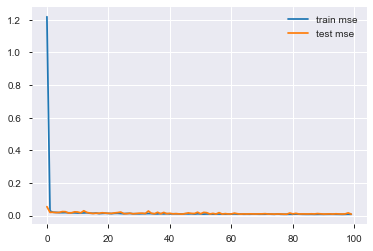

In [407]:
#結果の表示
import matplotlib.pyplot as plt #プロット用のライブラリを利用

print(model.evaluate(valid_X_nn, valid_y_nn))

train_acc = history.history['loss']
test_acc = history.history['val_loss']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mse')
plt.plot(x, test_acc, label = 'test mse')
plt.legend() #グラフの線の説明を表示

In [408]:
pred_y=model.predict(valid_X_nn)
score=mean_absolute_error(np.exp(valid_y_nn),np.exp(pred_y))
print(f'MAE:{score:4f}')
pred=model.predict(test_nn)


MAE:25.749117


position  age  area  sex  partner  num_child  education  service_length  \
0            4   39    14    1        1          5          2              19   
1            2   31    27    0        0          0          5               0   
2            1   20    45    1        1          2          1               2   
3            1   28    37    1        0          0          1              10   
4            2   41    16    1        0          0          1              23   
...        ...  ...   ...  ...      ...        ...        ...             ...   
8995         2   43    14    1        0          0          1              25   
8996         3   40     5    1        0          0          1              22   
8997         5   46    24    0        0          0          1              28   
8998         1   22    13    0        0          0          1               4   
8999         3   49    14    0        1          0          3              27   

      study_time  commute  overtime  familiy_num  agexposition  cluster  
0            1.0      1.8      14.2            7         156.0       19  
1            0.0      0.5      18.6            1          62.0        0  
2            2.0      1.2       2.3            4          30.0       14  
3            3.0      0.3       0.0            1          42.0        9  
4            3.0      0.5      10.1            1          82.0        4  
...          ...      ...       ...          ...           ...      ...  
8995         3.0      0.7       0.0            1          86.0        4  
8996         8.0      0.7       5.7            1         120.0        7  
8997         2.0      0.8       0.0            1         230.0       17  
8998         0.0      0.1       0.7            1          33.0       12  
8999         0.0      1.7      11.0            2         147.0       19  

[9000 rows x 14 columns]

# Stacking

In [21]:
from sklearn.ensemble import RandomForestRegressor as RFR
def cross_val(model,X,y):
    scores = []
    kf = KFold(n_splits=3, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
#     print(scores)
    return np.array(scores).mean()

models_dic = {
    'random forest': RFRegressorCV(n_trials=10),
    'lightgbm':LGBRegressorCV(n_trials=10),
    'XGBoost': XGBRegressorCV(n_trials=5),
    'catboost':CatBoost({'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50})
}

for name, model in models_dic.items():
    cv_results=cross_val(model,X,y)
    print(f'{name} : {-np.mean(cv_results):.2f}')

[I 2019-11-23 15:55:58,692] Finished trial#0 resulted in value: 0.9468405713759266. Current best value is 0.9468405713759266 with parameters: {'n_estimators': 197, 'max_features': 7, 'min_samples_split': 39, 'max_depth': 51}.
[I 2019-11-23 15:56:08,530] Finished trial#1 resulted in value: 0.9409916483676868. Current best value is 0.9468405713759266 with parameters: {'n_estimators': 197, 'max_features': 7, 'min_samples_split': 39, 'max_depth': 51}.
[I 2019-11-23 15:56:25,750] Finished trial#2 resulted in value: 0.9520376586618676. Current best value is 0.9520376586618676 with parameters: {'n_estimators': 160, 'max_features': 8, 'min_samples_split': 20, 'max_depth': 21}.
[I 2019-11-23 15:56:34,548] Finished trial#3 resulted in value: 0.9332974979730235. Current best value is 0.9520376586618676 with parameters: {'n_estimators': 160, 'max_features': 8, 'min_samples_split': 20, 'max_depth': 21}.
[I 2019-11-23 15:56:52,393] Finished trial#4 resulted in value: 0.9516851439310807. Current best


Best score: 0.95
Best params: {'n_estimators': 160, 'max_features': 8, 'min_samples_split': 20, 'max_depth': 21}



[I 2019-11-23 15:57:44,738] Finished trial#0 resulted in value: 0.8353447169015251. Current best value is 0.8353447169015251 with parameters: {'n_estimators': 133, 'max_features': 4, 'min_samples_split': 21, 'max_depth': 5}.
[I 2019-11-23 15:57:45,850] Finished trial#1 resulted in value: 0.736586839912553. Current best value is 0.8353447169015251 with parameters: {'n_estimators': 133, 'max_features': 4, 'min_samples_split': 21, 'max_depth': 5}.
[I 2019-11-23 15:58:02,320] Finished trial#2 resulted in value: 0.9406883124173477. Current best value is 0.9406883124173477 with parameters: {'n_estimators': 148, 'max_features': 12, 'min_samples_split': 89, 'max_depth': 71}.
[I 2019-11-23 15:58:06,019] Finished trial#3 resulted in value: 0.9347783019298938. Current best value is 0.9406883124173477 with parameters: {'n_estimators': 148, 'max_features': 12, 'min_samples_split': 89, 'max_depth': 71}.
[I 2019-11-23 15:58:06,871] Finished trial#4 resulted in value: 0.8915527822067976. Current best 


Best score: 0.96
Best params: {'n_estimators': 196, 'max_features': 10, 'min_samples_split': 12, 'max_depth': 88}



[I 2019-11-23 15:59:29,152] Finished trial#0 resulted in value: 0.8185884142524008. Current best value is 0.8185884142524008 with parameters: {'n_estimators': 14, 'max_features': 1, 'min_samples_split': 69, 'max_depth': 31}.
[I 2019-11-23 15:59:42,149] Finished trial#1 resulted in value: 0.9383536723213501. Current best value is 0.9383536723213501 with parameters: {'n_estimators': 148, 'max_features': 8, 'min_samples_split': 87, 'max_depth': 74}.
[I 2019-11-23 15:59:57,044] Finished trial#2 resulted in value: 0.9387947643624972. Current best value is 0.9387947643624972 with parameters: {'n_estimators': 143, 'max_features': 10, 'min_samples_split': 96, 'max_depth': 35}.
[I 2019-11-23 15:59:59,471] Finished trial#3 resulted in value: 0.8387431608608628. Current best value is 0.9387947643624972 with parameters: {'n_estimators': 143, 'max_features': 10, 'min_samples_split': 96, 'max_depth': 35}.
[I 2019-11-23 16:00:21,637] Finished trial#4 resulted in value: 0.9471764295571863. Current bes


Best score: 0.95
Best params: {'n_estimators': 183, 'max_features': 11, 'min_samples_split': 32, 'max_depth': 57}

random forest : -23.45


[I 2019-11-23 16:01:36,605] Finished trial#0 resulted in value: 0.6169773483026737. Current best value is 0.6169773483026737 with parameters: {'booster': 'gbtree', 'iterations': 100, 'learning_rate': 0.01284262652479266, 'random_strength': 36, 'bagging_temperature': 10.764738798091056, 'od_type': 'IncToDec', 'od_wait': 46, 'lambda_l1': 0.04498815242115761, 'lambda_l2': 3.465705750760001e-05, 'num_leaves': 250, 'feature_fraction': 0.5358286624711736, 'bagging_fraction': 0.4818668332038078, 'bagging_freq': 6, 'min_child_samples': 70}.
[I 2019-11-23 16:01:40,974] Finished trial#1 resulted in value: 0.9529517477086535. Current best value is 0.9529517477086535 with parameters: {'booster': 'gbtree', 'iterations': 94, 'learning_rate': 0.09506314609595934, 'random_strength': 59, 'bagging_temperature': 12.499205443789174, 'od_type': 'Iter', 'od_wait': 28, 'lambda_l1': 4.773575116929726e-08, 'lambda_l2': 1.2546271861862814e-08, 'num_leaves': 166, 'feature_fraction': 0.6272814187069083, 'bagging_


Best score: 0.95
Best params: {'booster': 'gblinear', 'iterations': 263, 'learning_rate': 0.05169803064037914, 'random_strength': 99, 'bagging_temperature': 0.07471749589710332, 'od_type': 'Iter', 'od_wait': 47, 'lambda_l1': 2.557054175616504e-08, 'lambda_l2': 0.001921841235370088, 'num_leaves': 256, 'feature_fraction': 0.8985871573711662, 'bagging_fraction': 0.9773394591062526, 'bagging_freq': 7, 'min_child_samples': 37}



[I 2019-11-23 16:02:04,232] Finished trial#0 resulted in value: 0.9491640124472672. Current best value is 0.9491640124472672 with parameters: {'booster': 'gbtree', 'iterations': 177, 'learning_rate': 0.2813716185896249, 'random_strength': 51, 'bagging_temperature': 0.3374259248591919, 'od_type': 'Iter', 'od_wait': 45, 'lambda_l1': 6.884319591556945e-07, 'lambda_l2': 0.0004083109914628059, 'num_leaves': 89, 'feature_fraction': 0.5797569346485699, 'bagging_fraction': 0.6238280214672564, 'bagging_freq': 6, 'min_child_samples': 64}.
[I 2019-11-23 16:02:05,437] Finished trial#1 resulted in value: 0.9328951071606053. Current best value is 0.9491640124472672 with parameters: {'booster': 'gbtree', 'iterations': 177, 'learning_rate': 0.2813716185896249, 'random_strength': 51, 'bagging_temperature': 0.3374259248591919, 'od_type': 'Iter', 'od_wait': 45, 'lambda_l1': 6.884319591556945e-07, 'lambda_l2': 0.0004083109914628059, 'num_leaves': 89, 'feature_fraction': 0.5797569346485699, 'bagging_fracti


Best score: 0.95
Best params: {'booster': 'gbtree', 'iterations': 297, 'learning_rate': 0.05879206216315441, 'random_strength': 23, 'bagging_temperature': 1.0285189040556244, 'od_type': 'Iter', 'od_wait': 42, 'lambda_l1': 0.3250734473951114, 'lambda_l2': 0.00025301590425030375, 'num_leaves': 47, 'feature_fraction': 0.8729600495999856, 'bagging_fraction': 0.8538078132064275, 'bagging_freq': 2, 'min_child_samples': 97}



[I 2019-11-23 16:02:22,928] Finished trial#0 resulted in value: 0.4459210477834314. Current best value is 0.4459210477834314 with parameters: {'booster': 'gbtree', 'iterations': 292, 'learning_rate': 0.012549572982039167, 'random_strength': 5, 'bagging_temperature': 13.50855563564534, 'od_type': 'Iter', 'od_wait': 49, 'lambda_l1': 8.263919932940475, 'lambda_l2': 0.0006284821877628701, 'num_leaves': 68, 'feature_fraction': 0.6761921466643026, 'bagging_fraction': 0.47860778060002473, 'bagging_freq': 5, 'min_child_samples': 73}.
[I 2019-11-23 16:02:25,349] Finished trial#1 resulted in value: 0.7511440045555083. Current best value is 0.7511440045555083 with parameters: {'booster': 'gblinear', 'iterations': 320, 'learning_rate': 0.013373759474192592, 'random_strength': 81, 'bagging_temperature': 0.017863173721320614, 'od_type': 'Iter', 'od_wait': 32, 'lambda_l1': 0.010272225176965136, 'lambda_l2': 0.009759523592079883, 'num_leaves': 105, 'feature_fraction': 0.916123296350156, 'bagging_fract


Best score: 0.95
Best params: {'booster': 'gblinear', 'iterations': 395, 'learning_rate': 0.09311504505542359, 'random_strength': 93, 'bagging_temperature': 9.110654945430706, 'od_type': 'IncToDec', 'od_wait': 17, 'lambda_l1': 3.07853506044752e-05, 'lambda_l2': 3.212835112845458e-06, 'num_leaves': 243, 'feature_fraction': 0.663822112449715, 'bagging_fraction': 0.5886271676987656, 'bagging_freq': 4, 'min_child_samples': 99}

lightgbm : -24.38


[I 2019-11-23 16:02:41,599] Finished trial#0 resulted in value: 0.8949819909941823. Current best value is 0.8949819909941823 with parameters: {'booster': 'gbtree', 'alpha': 9.286902046677776e-06, 'max_depth': 2, 'eta': 0.0033276727979873076, 'gamma': 1.2269548558831752e-07, 'grow_policy': 'depthwise'}.
[I 2019-11-23 16:02:49,387] Finished trial#1 resulted in value: 0.9496243400145605. Current best value is 0.9496243400145605 with parameters: {'booster': 'gbtree', 'alpha': 4.89687438941848e-07, 'max_depth': 10, 'eta': 7.398160069007929e-08, 'gamma': 0.20823107388649817, 'grow_policy': 'depthwise'}.
[I 2019-11-23 16:03:21,491] Finished trial#2 resulted in value: 0.9567647986248371. Current best value is 0.9567647986248371 with parameters: {'booster': 'dart', 'alpha': 0.15768460546068616, 'max_depth': 10, 'eta': 0.0030505909694935394, 'gamma': 0.01937476471246091, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.77920745763446e-07, 'skip_dro


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 0.15768460546068616, 'max_depth': 10, 'eta': 0.0030505909694935394, 'gamma': 0.01937476471246091, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.77920745763446e-07, 'skip_drop': 0.5660942502074212}

[16:03:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-23 16:04:14,601] Finished trial#0 resulted in value: 0.9304707060921835. Current best value is 0.9304707060921835 with parameters: {'booster': 'dart', 'alpha': 1.1708005609638206e-06, 'max_depth': 3, 'eta': 0.0035024102129010398, 'gamma': 6.316768484183078e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.9094979425373035e-05, 'skip_drop': 5.512802920271939e-06}.
[I 2019-11-23 16:04:18,489] Finished trial#1 resulted in value: 0.926316083648102. Current best value is 0.9304707060921835 with parameters: {'booster': 'dart', 'alpha': 1.1708005609638206e-06, 'max_depth': 3, 'eta': 0.0035024102129010398, 'gamma': 6.316768484183078e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.9094979425373035e-05, 'skip_drop': 5.512802920271939e-06}.
[I 2019-11-23 16:04:22,789] Finished trial#2 resulted in value: 0.9431126155973025. Current best value is 0.9431126155973025 with parameters: {


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.19280033296987056, 'max_depth': 11, 'eta': 0.019910283176469624, 'gamma': 0.00030910099823462986, 'grow_policy': 'lossguide'}

[16:05:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-23 16:05:57,632] Finished trial#0 resulted in value: 0.9558757860361069. Current best value is 0.9558757860361069 with parameters: {'booster': 'gbtree', 'alpha': 0.011129970382189847, 'max_depth': 18, 'eta': 0.021206565084003884, 'gamma': 0.004804825710163328, 'grow_policy': 'depthwise'}.
[I 2019-11-23 16:07:19,943] Finished trial#1 resulted in value: 0.9532296636955353. Current best value is 0.9558757860361069 with parameters: {'booster': 'gbtree', 'alpha': 0.011129970382189847, 'max_depth': 18, 'eta': 0.021206565084003884, 'gamma': 0.004804825710163328, 'grow_policy': 'depthwise'}.
[I 2019-11-23 16:07:38,685] Finished trial#2 resulted in value: 0.9534711235556126. Current best value is 0.9558757860361069 with parameters: {'booster': 'gbtree', 'alpha': 0.011129970382189847, 'max_depth': 18, 'eta': 0.021206565084003884, 'gamma': 0.004804825710163328, 'grow_policy': 'depthwise'}.
[I 2019-11-23 16:07:58,974] Finished trial#3 resulted in value: 0.9433264580008563. Current best 


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.011129970382189847, 'max_depth': 18, 'eta': 0.021206565084003884, 'gamma': 0.004804825710163328, 'grow_policy': 'depthwise'}

[16:08:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost : -22.89
0:	learn: 0.4254308	total: 11.3ms	remaining: 11.3s
1:	learn: 0.3813657	total: 38.3ms	remaining: 19.1s
2:	learn: 0.3627655	total: 48.9ms	remaining: 16.2s
3:	learn: 0.3309045	total: 57.8ms	remaining: 14.4s
4:	learn: 0.3039355	total: 64.7ms	remaining: 12.9s
5:	learn: 0.2861874	total: 72.8ms	remaining: 12.1s
6:	learn: 0.2686065	total: 83.1ms	remaining: 11.8s
7:	learn: 0.2604595	total: 89.5ms	remaining: 11.1s
8:	learn: 0.2502474	total: 95.9ms	remaining: 10.6s
9:	learn: 0.2425649	total: 104ms	remaining: 10.3s
10:	learn: 0.2354856	total: 118ms	remaining: 10.6s
11:	learn: 0.2294853	total: 128ms	remaining: 10.5s
12:	learn: 0.2237073	total: 140ms	remaining: 10.7s
13:	learn: 0.22

154:	learn: 0.0923000	total: 1.67s	remaining: 9.13s
155:	learn: 0.0922237	total: 1.68s	remaining: 9.11s
156:	learn: 0.0920139	total: 1.69s	remaining: 9.08s
157:	learn: 0.0919449	total: 1.7s	remaining: 9.05s
158:	learn: 0.0918128	total: 1.7s	remaining: 9.01s
159:	learn: 0.0917459	total: 1.71s	remaining: 8.98s
160:	learn: 0.0916840	total: 1.72s	remaining: 8.97s
161:	learn: 0.0915896	total: 1.73s	remaining: 8.95s
162:	learn: 0.0915171	total: 1.74s	remaining: 8.93s
163:	learn: 0.0913688	total: 1.75s	remaining: 8.91s
164:	learn: 0.0913223	total: 1.76s	remaining: 8.89s
165:	learn: 0.0912525	total: 1.76s	remaining: 8.87s
166:	learn: 0.0911413	total: 1.78s	remaining: 8.86s
167:	learn: 0.0910339	total: 1.79s	remaining: 8.88s
168:	learn: 0.0909478	total: 1.81s	remaining: 8.91s
169:	learn: 0.0908367	total: 1.84s	remaining: 8.98s
170:	learn: 0.0907816	total: 1.86s	remaining: 9.03s
171:	learn: 0.0907323	total: 1.88s	remaining: 9.06s
172:	learn: 0.0905434	total: 1.9s	remaining: 9.08s
173:	learn: 0.0

313:	learn: 0.0811405	total: 3.43s	remaining: 7.5s
314:	learn: 0.0811173	total: 3.44s	remaining: 7.48s
315:	learn: 0.0810355	total: 3.45s	remaining: 7.47s
316:	learn: 0.0809846	total: 3.46s	remaining: 7.45s
317:	learn: 0.0808718	total: 3.47s	remaining: 7.43s
318:	learn: 0.0808408	total: 3.48s	remaining: 7.42s
319:	learn: 0.0808115	total: 3.48s	remaining: 7.41s
320:	learn: 0.0807844	total: 3.49s	remaining: 7.39s
321:	learn: 0.0807443	total: 3.5s	remaining: 7.37s
322:	learn: 0.0807076	total: 3.51s	remaining: 7.36s
323:	learn: 0.0806657	total: 3.52s	remaining: 7.34s
324:	learn: 0.0806272	total: 3.53s	remaining: 7.33s
325:	learn: 0.0805581	total: 3.54s	remaining: 7.31s
326:	learn: 0.0805247	total: 3.55s	remaining: 7.3s
327:	learn: 0.0804812	total: 3.55s	remaining: 7.28s
328:	learn: 0.0804471	total: 3.56s	remaining: 7.27s
329:	learn: 0.0804205	total: 3.57s	remaining: 7.26s
330:	learn: 0.0803791	total: 3.58s	remaining: 7.25s
331:	learn: 0.0803260	total: 3.59s	remaining: 7.23s
332:	learn: 0.0

472:	learn: 0.0752873	total: 5.2s	remaining: 5.79s
473:	learn: 0.0752537	total: 5.21s	remaining: 5.78s
474:	learn: 0.0752292	total: 5.21s	remaining: 5.76s
475:	learn: 0.0752001	total: 5.22s	remaining: 5.75s
476:	learn: 0.0751780	total: 5.23s	remaining: 5.74s
477:	learn: 0.0751490	total: 5.24s	remaining: 5.72s
478:	learn: 0.0751316	total: 5.25s	remaining: 5.71s
479:	learn: 0.0751041	total: 5.26s	remaining: 5.7s
480:	learn: 0.0750703	total: 5.27s	remaining: 5.68s
481:	learn: 0.0750092	total: 5.28s	remaining: 5.67s
482:	learn: 0.0749783	total: 5.29s	remaining: 5.67s
483:	learn: 0.0749257	total: 5.3s	remaining: 5.65s
484:	learn: 0.0748900	total: 5.31s	remaining: 5.64s
485:	learn: 0.0748763	total: 5.32s	remaining: 5.63s
486:	learn: 0.0748528	total: 5.34s	remaining: 5.62s
487:	learn: 0.0748109	total: 5.35s	remaining: 5.61s
488:	learn: 0.0747525	total: 5.36s	remaining: 5.6s
489:	learn: 0.0747148	total: 5.37s	remaining: 5.59s
490:	learn: 0.0747022	total: 5.38s	remaining: 5.58s
491:	learn: 0.07

631:	learn: 0.0712294	total: 7.18s	remaining: 4.18s
632:	learn: 0.0712155	total: 7.2s	remaining: 4.17s
633:	learn: 0.0711859	total: 7.21s	remaining: 4.16s
634:	learn: 0.0711528	total: 7.22s	remaining: 4.15s
635:	learn: 0.0711493	total: 7.24s	remaining: 4.14s
636:	learn: 0.0711149	total: 7.25s	remaining: 4.13s
637:	learn: 0.0710989	total: 7.26s	remaining: 4.12s
638:	learn: 0.0710754	total: 7.27s	remaining: 4.11s
639:	learn: 0.0710496	total: 7.29s	remaining: 4.1s
640:	learn: 0.0710308	total: 7.3s	remaining: 4.09s
641:	learn: 0.0709983	total: 7.31s	remaining: 4.08s
642:	learn: 0.0709785	total: 7.32s	remaining: 4.07s
643:	learn: 0.0709699	total: 7.33s	remaining: 4.05s
644:	learn: 0.0709480	total: 7.35s	remaining: 4.04s
645:	learn: 0.0709282	total: 7.36s	remaining: 4.04s
646:	learn: 0.0708850	total: 7.38s	remaining: 4.03s
647:	learn: 0.0708554	total: 7.4s	remaining: 4.02s
648:	learn: 0.0708415	total: 7.41s	remaining: 4.01s
649:	learn: 0.0708168	total: 7.42s	remaining: 4s
650:	learn: 0.07080

790:	learn: 0.0678510	total: 9.26s	remaining: 2.44s
791:	learn: 0.0678213	total: 9.26s	remaining: 2.43s
792:	learn: 0.0677968	total: 9.28s	remaining: 2.42s
793:	learn: 0.0677815	total: 9.29s	remaining: 2.41s
794:	learn: 0.0677533	total: 9.3s	remaining: 2.4s
795:	learn: 0.0677303	total: 9.31s	remaining: 2.39s
796:	learn: 0.0677231	total: 9.33s	remaining: 2.38s
797:	learn: 0.0677057	total: 9.34s	remaining: 2.36s
798:	learn: 0.0676865	total: 9.35s	remaining: 2.35s
799:	learn: 0.0676716	total: 9.37s	remaining: 2.34s
800:	learn: 0.0676467	total: 9.38s	remaining: 2.33s
801:	learn: 0.0676337	total: 9.39s	remaining: 2.32s
802:	learn: 0.0676213	total: 9.4s	remaining: 2.31s
803:	learn: 0.0675848	total: 9.41s	remaining: 2.29s
804:	learn: 0.0675741	total: 9.42s	remaining: 2.28s
805:	learn: 0.0675372	total: 9.44s	remaining: 2.27s
806:	learn: 0.0675219	total: 9.44s	remaining: 2.26s
807:	learn: 0.0675075	total: 9.46s	remaining: 2.25s
808:	learn: 0.0674878	total: 9.47s	remaining: 2.23s
809:	learn: 0.0

949:	learn: 0.0651348	total: 11.5s	remaining: 606ms
950:	learn: 0.0651213	total: 11.5s	remaining: 594ms
951:	learn: 0.0651076	total: 11.5s	remaining: 582ms
952:	learn: 0.0650710	total: 11.6s	remaining: 570ms
953:	learn: 0.0650597	total: 11.6s	remaining: 558ms
954:	learn: 0.0650394	total: 11.6s	remaining: 546ms
955:	learn: 0.0650304	total: 11.6s	remaining: 533ms
956:	learn: 0.0650117	total: 11.6s	remaining: 521ms
957:	learn: 0.0649764	total: 11.6s	remaining: 509ms
958:	learn: 0.0649595	total: 11.6s	remaining: 497ms
959:	learn: 0.0649235	total: 11.6s	remaining: 485ms
960:	learn: 0.0648966	total: 11.7s	remaining: 473ms
961:	learn: 0.0648554	total: 11.7s	remaining: 461ms
962:	learn: 0.0648340	total: 11.7s	remaining: 449ms
963:	learn: 0.0648299	total: 11.7s	remaining: 436ms
964:	learn: 0.0648180	total: 11.7s	remaining: 424ms
965:	learn: 0.0647981	total: 11.7s	remaining: 412ms
966:	learn: 0.0647806	total: 11.7s	remaining: 400ms
967:	learn: 0.0647624	total: 11.7s	remaining: 388ms
968:	learn: 

110:	learn: 0.1000260	total: 1.56s	remaining: 12.5s
111:	learn: 0.0998099	total: 1.57s	remaining: 12.4s
112:	learn: 0.0993907	total: 1.58s	remaining: 12.4s
113:	learn: 0.0992054	total: 1.59s	remaining: 12.4s
114:	learn: 0.0989696	total: 1.61s	remaining: 12.4s
115:	learn: 0.0987513	total: 1.62s	remaining: 12.4s
116:	learn: 0.0984962	total: 1.63s	remaining: 12.3s
117:	learn: 0.0983741	total: 1.65s	remaining: 12.3s
118:	learn: 0.0980083	total: 1.66s	remaining: 12.3s
119:	learn: 0.0977200	total: 1.68s	remaining: 12.3s
120:	learn: 0.0975104	total: 1.69s	remaining: 12.3s
121:	learn: 0.0973045	total: 1.7s	remaining: 12.2s
122:	learn: 0.0970475	total: 1.71s	remaining: 12.2s
123:	learn: 0.0966822	total: 1.73s	remaining: 12.2s
124:	learn: 0.0965521	total: 1.74s	remaining: 12.2s
125:	learn: 0.0963314	total: 1.75s	remaining: 12.1s
126:	learn: 0.0961132	total: 1.76s	remaining: 12.1s
127:	learn: 0.0958500	total: 1.78s	remaining: 12.1s
128:	learn: 0.0956510	total: 1.79s	remaining: 12.1s
129:	learn: 0

269:	learn: 0.0827031	total: 3.82s	remaining: 10.3s
270:	learn: 0.0826595	total: 3.83s	remaining: 10.3s
271:	learn: 0.0826316	total: 3.84s	remaining: 10.3s
272:	learn: 0.0825927	total: 3.86s	remaining: 10.3s
273:	learn: 0.0825106	total: 3.88s	remaining: 10.3s
274:	learn: 0.0824613	total: 3.89s	remaining: 10.3s
275:	learn: 0.0824175	total: 3.91s	remaining: 10.3s
276:	learn: 0.0823212	total: 3.92s	remaining: 10.2s
277:	learn: 0.0822762	total: 3.94s	remaining: 10.2s
278:	learn: 0.0822452	total: 3.95s	remaining: 10.2s
279:	learn: 0.0822147	total: 3.96s	remaining: 10.2s
280:	learn: 0.0821846	total: 3.98s	remaining: 10.2s
281:	learn: 0.0821179	total: 3.98s	remaining: 10.1s
282:	learn: 0.0819923	total: 4s	remaining: 10.1s
283:	learn: 0.0819692	total: 4.01s	remaining: 10.1s
284:	learn: 0.0819209	total: 4.05s	remaining: 10.2s
285:	learn: 0.0818612	total: 4.08s	remaining: 10.2s
286:	learn: 0.0818196	total: 4.11s	remaining: 10.2s
287:	learn: 0.0817894	total: 4.13s	remaining: 10.2s
288:	learn: 0.0

428:	learn: 0.0759957	total: 6.08s	remaining: 8.09s
429:	learn: 0.0759704	total: 6.09s	remaining: 8.07s
430:	learn: 0.0759393	total: 6.1s	remaining: 8.05s
431:	learn: 0.0759109	total: 6.11s	remaining: 8.04s
432:	learn: 0.0758673	total: 6.13s	remaining: 8.03s
433:	learn: 0.0758532	total: 6.18s	remaining: 8.06s
434:	learn: 0.0758191	total: 6.23s	remaining: 8.09s
435:	learn: 0.0758020	total: 6.26s	remaining: 8.09s
436:	learn: 0.0757536	total: 6.29s	remaining: 8.1s
437:	learn: 0.0757168	total: 6.32s	remaining: 8.12s
438:	learn: 0.0756799	total: 6.34s	remaining: 8.1s
439:	learn: 0.0756518	total: 6.35s	remaining: 8.08s
440:	learn: 0.0756119	total: 6.37s	remaining: 8.07s
441:	learn: 0.0755817	total: 6.38s	remaining: 8.05s
442:	learn: 0.0755414	total: 6.39s	remaining: 8.03s
443:	learn: 0.0754883	total: 6.4s	remaining: 8.02s
444:	learn: 0.0754514	total: 6.42s	remaining: 8s
445:	learn: 0.0754298	total: 6.43s	remaining: 7.99s
446:	learn: 0.0753998	total: 6.45s	remaining: 7.97s
447:	learn: 0.07535

587:	learn: 0.0713624	total: 8.1s	remaining: 5.67s
588:	learn: 0.0713037	total: 8.11s	remaining: 5.66s
589:	learn: 0.0712963	total: 8.12s	remaining: 5.64s
590:	learn: 0.0712801	total: 8.13s	remaining: 5.62s
591:	learn: 0.0712639	total: 8.14s	remaining: 5.61s
592:	learn: 0.0712262	total: 8.15s	remaining: 5.59s
593:	learn: 0.0711920	total: 8.16s	remaining: 5.58s
594:	learn: 0.0711546	total: 8.17s	remaining: 5.56s
595:	learn: 0.0711162	total: 8.18s	remaining: 5.55s
596:	learn: 0.0711027	total: 8.19s	remaining: 5.53s
597:	learn: 0.0710854	total: 8.2s	remaining: 5.51s
598:	learn: 0.0710667	total: 8.22s	remaining: 5.5s
599:	learn: 0.0710436	total: 8.25s	remaining: 5.5s
600:	learn: 0.0710035	total: 8.29s	remaining: 5.5s
601:	learn: 0.0709813	total: 8.31s	remaining: 5.5s
602:	learn: 0.0709629	total: 8.34s	remaining: 5.49s
603:	learn: 0.0709383	total: 8.36s	remaining: 5.48s
604:	learn: 0.0709293	total: 8.37s	remaining: 5.47s
605:	learn: 0.0708784	total: 8.38s	remaining: 5.45s
606:	learn: 0.0708

746:	learn: 0.0676683	total: 10.2s	remaining: 3.44s
747:	learn: 0.0676474	total: 10.2s	remaining: 3.42s
748:	learn: 0.0676358	total: 10.2s	remaining: 3.41s
749:	learn: 0.0676230	total: 10.2s	remaining: 3.4s
750:	learn: 0.0676068	total: 10.2s	remaining: 3.38s
751:	learn: 0.0675995	total: 10.2s	remaining: 3.37s
752:	learn: 0.0675862	total: 10.2s	remaining: 3.35s
753:	learn: 0.0675597	total: 10.2s	remaining: 3.34s
754:	learn: 0.0675400	total: 10.2s	remaining: 3.32s
755:	learn: 0.0675280	total: 10.3s	remaining: 3.31s
756:	learn: 0.0675117	total: 10.3s	remaining: 3.3s
757:	learn: 0.0674937	total: 10.3s	remaining: 3.28s
758:	learn: 0.0674589	total: 10.3s	remaining: 3.27s
759:	learn: 0.0674517	total: 10.3s	remaining: 3.26s
760:	learn: 0.0674314	total: 10.4s	remaining: 3.26s
761:	learn: 0.0674216	total: 10.4s	remaining: 3.25s
762:	learn: 0.0674011	total: 10.4s	remaining: 3.24s
763:	learn: 0.0673743	total: 10.5s	remaining: 3.23s
764:	learn: 0.0673444	total: 10.5s	remaining: 3.21s
765:	learn: 0.

905:	learn: 0.0647260	total: 12.4s	remaining: 1.28s
906:	learn: 0.0647020	total: 12.4s	remaining: 1.27s
907:	learn: 0.0646971	total: 12.4s	remaining: 1.25s
908:	learn: 0.0646724	total: 12.4s	remaining: 1.24s
909:	learn: 0.0646597	total: 12.4s	remaining: 1.23s
910:	learn: 0.0646471	total: 12.4s	remaining: 1.22s
911:	learn: 0.0646196	total: 12.5s	remaining: 1.2s
912:	learn: 0.0646121	total: 12.5s	remaining: 1.19s
913:	learn: 0.0645928	total: 12.5s	remaining: 1.18s
914:	learn: 0.0645684	total: 12.6s	remaining: 1.17s
915:	learn: 0.0645578	total: 12.6s	remaining: 1.16s
916:	learn: 0.0645526	total: 12.6s	remaining: 1.14s
917:	learn: 0.0645293	total: 12.6s	remaining: 1.13s
918:	learn: 0.0645194	total: 12.6s	remaining: 1.11s
919:	learn: 0.0645060	total: 12.6s	remaining: 1.1s
920:	learn: 0.0644790	total: 12.7s	remaining: 1.08s
921:	learn: 0.0644501	total: 12.7s	remaining: 1.07s
922:	learn: 0.0644426	total: 12.7s	remaining: 1.06s
923:	learn: 0.0644178	total: 12.7s	remaining: 1.04s
924:	learn: 0.

65:	learn: 0.1479316	total: 1.01s	remaining: 14.3s
66:	learn: 0.1468170	total: 1.05s	remaining: 14.7s
67:	learn: 0.1439213	total: 1.08s	remaining: 14.8s
68:	learn: 0.1424005	total: 1.09s	remaining: 14.7s
69:	learn: 0.1396061	total: 1.11s	remaining: 14.7s
70:	learn: 0.1384035	total: 1.16s	remaining: 15.2s
71:	learn: 0.1353723	total: 1.2s	remaining: 15.5s
72:	learn: 0.1335949	total: 1.21s	remaining: 15.4s
73:	learn: 0.1313716	total: 1.26s	remaining: 15.7s
74:	learn: 0.1296360	total: 1.27s	remaining: 15.7s
75:	learn: 0.1276485	total: 1.29s	remaining: 15.7s
76:	learn: 0.1248245	total: 1.3s	remaining: 15.6s
77:	learn: 0.1228993	total: 1.31s	remaining: 15.5s
78:	learn: 0.1207021	total: 1.33s	remaining: 15.5s
79:	learn: 0.1193415	total: 1.34s	remaining: 15.5s
80:	learn: 0.1176515	total: 1.36s	remaining: 15.4s
81:	learn: 0.1162676	total: 1.37s	remaining: 15.3s
82:	learn: 0.1152691	total: 1.38s	remaining: 15.3s
83:	learn: 0.1140625	total: 1.4s	remaining: 15.3s
84:	learn: 0.1135954	total: 1.41s	

225:	learn: 0.0859475	total: 3.54s	remaining: 12.1s
226:	learn: 0.0858756	total: 3.56s	remaining: 12.1s
227:	learn: 0.0858177	total: 3.57s	remaining: 12.1s
228:	learn: 0.0856884	total: 3.58s	remaining: 12s
229:	learn: 0.0855718	total: 3.59s	remaining: 12s
230:	learn: 0.0854556	total: 3.6s	remaining: 12s
231:	learn: 0.0853988	total: 3.62s	remaining: 12s
232:	learn: 0.0853453	total: 3.64s	remaining: 12s
233:	learn: 0.0852917	total: 3.65s	remaining: 11.9s
234:	learn: 0.0852175	total: 3.67s	remaining: 11.9s
235:	learn: 0.0850976	total: 3.68s	remaining: 11.9s
236:	learn: 0.0850493	total: 3.69s	remaining: 11.9s
237:	learn: 0.0850151	total: 3.7s	remaining: 11.9s
238:	learn: 0.0849070	total: 3.72s	remaining: 11.8s
239:	learn: 0.0848578	total: 3.73s	remaining: 11.8s
240:	learn: 0.0848048	total: 3.74s	remaining: 11.8s
241:	learn: 0.0847449	total: 3.75s	remaining: 11.8s
242:	learn: 0.0847121	total: 3.77s	remaining: 11.7s
243:	learn: 0.0846262	total: 3.78s	remaining: 11.7s
244:	learn: 0.0845535	to

384:	learn: 0.0782064	total: 6.32s	remaining: 10.1s
385:	learn: 0.0781892	total: 6.33s	remaining: 10.1s
386:	learn: 0.0781525	total: 6.34s	remaining: 10s
387:	learn: 0.0781228	total: 6.35s	remaining: 10s
388:	learn: 0.0780209	total: 6.36s	remaining: 9.99s
389:	learn: 0.0779997	total: 6.37s	remaining: 9.97s
390:	learn: 0.0779788	total: 6.39s	remaining: 9.95s
391:	learn: 0.0779230	total: 6.4s	remaining: 9.92s
392:	learn: 0.0778923	total: 6.41s	remaining: 9.9s
393:	learn: 0.0778589	total: 6.42s	remaining: 9.87s
394:	learn: 0.0778230	total: 6.43s	remaining: 9.85s
395:	learn: 0.0778050	total: 6.45s	remaining: 9.83s
396:	learn: 0.0777756	total: 6.46s	remaining: 9.81s
397:	learn: 0.0777339	total: 6.47s	remaining: 9.79s
398:	learn: 0.0777050	total: 6.49s	remaining: 9.78s
399:	learn: 0.0776786	total: 6.5s	remaining: 9.76s
400:	learn: 0.0776487	total: 6.52s	remaining: 9.74s
401:	learn: 0.0776361	total: 6.53s	remaining: 9.72s
402:	learn: 0.0776078	total: 6.54s	remaining: 9.7s
403:	learn: 0.077576

543:	learn: 0.0734123	total: 8.49s	remaining: 7.11s
544:	learn: 0.0733859	total: 8.51s	remaining: 7.1s
545:	learn: 0.0733568	total: 8.52s	remaining: 7.08s
546:	learn: 0.0733216	total: 8.53s	remaining: 7.07s
547:	learn: 0.0732949	total: 8.54s	remaining: 7.05s
548:	learn: 0.0732743	total: 8.56s	remaining: 7.03s
549:	learn: 0.0732594	total: 8.57s	remaining: 7.01s
550:	learn: 0.0732519	total: 8.58s	remaining: 6.99s
551:	learn: 0.0732277	total: 8.6s	remaining: 6.98s
552:	learn: 0.0732019	total: 8.62s	remaining: 6.96s
553:	learn: 0.0731724	total: 8.63s	remaining: 6.95s
554:	learn: 0.0731558	total: 8.64s	remaining: 6.93s
555:	learn: 0.0731284	total: 8.65s	remaining: 6.91s
556:	learn: 0.0731037	total: 8.66s	remaining: 6.89s
557:	learn: 0.0730519	total: 8.67s	remaining: 6.87s
558:	learn: 0.0730321	total: 8.69s	remaining: 6.85s
559:	learn: 0.0730162	total: 8.69s	remaining: 6.83s
560:	learn: 0.0729983	total: 8.7s	remaining: 6.81s
561:	learn: 0.0729584	total: 8.7s	remaining: 6.78s
562:	learn: 0.07

702:	learn: 0.0697081	total: 10.2s	remaining: 4.32s
703:	learn: 0.0696930	total: 10.2s	remaining: 4.3s
704:	learn: 0.0696626	total: 10.2s	remaining: 4.28s
705:	learn: 0.0696424	total: 10.2s	remaining: 4.27s
706:	learn: 0.0696161	total: 10.3s	remaining: 4.25s
707:	learn: 0.0695973	total: 10.3s	remaining: 4.23s
708:	learn: 0.0695731	total: 10.3s	remaining: 4.21s
709:	learn: 0.0695618	total: 10.3s	remaining: 4.19s
710:	learn: 0.0695395	total: 10.3s	remaining: 4.17s
711:	learn: 0.0695272	total: 10.3s	remaining: 4.16s
712:	learn: 0.0694954	total: 10.3s	remaining: 4.14s
713:	learn: 0.0694740	total: 10.3s	remaining: 4.13s
714:	learn: 0.0694585	total: 10.3s	remaining: 4.11s
715:	learn: 0.0694330	total: 10.3s	remaining: 4.1s
716:	learn: 0.0694063	total: 10.4s	remaining: 4.09s
717:	learn: 0.0693972	total: 10.4s	remaining: 4.07s
718:	learn: 0.0693818	total: 10.4s	remaining: 4.06s
719:	learn: 0.0693591	total: 10.4s	remaining: 4.04s
720:	learn: 0.0693233	total: 10.4s	remaining: 4.02s
721:	learn: 0.

861:	learn: 0.0664041	total: 12.5s	remaining: 2.01s
862:	learn: 0.0663902	total: 12.6s	remaining: 1.99s
863:	learn: 0.0663839	total: 12.6s	remaining: 1.98s
864:	learn: 0.0663682	total: 12.6s	remaining: 1.96s
865:	learn: 0.0663541	total: 12.6s	remaining: 1.95s
866:	learn: 0.0663295	total: 12.6s	remaining: 1.93s
867:	learn: 0.0663162	total: 12.6s	remaining: 1.92s
868:	learn: 0.0663056	total: 12.6s	remaining: 1.9s
869:	learn: 0.0662742	total: 12.6s	remaining: 1.89s
870:	learn: 0.0662556	total: 12.7s	remaining: 1.87s
871:	learn: 0.0662295	total: 12.7s	remaining: 1.86s
872:	learn: 0.0662107	total: 12.7s	remaining: 1.84s
873:	learn: 0.0661854	total: 12.7s	remaining: 1.83s
874:	learn: 0.0661705	total: 12.7s	remaining: 1.81s
875:	learn: 0.0661528	total: 12.7s	remaining: 1.8s
876:	learn: 0.0661374	total: 12.7s	remaining: 1.78s
877:	learn: 0.0661246	total: 12.7s	remaining: 1.77s
878:	learn: 0.0661042	total: 12.7s	remaining: 1.75s
879:	learn: 0.0660819	total: 12.8s	remaining: 1.74s
880:	learn: 0.

In [54]:
# datasetを準備
seed=0
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
import catboost

dataset = Dataset(X, y, test) # X_testは今回使わないが入れないとエラーになる

# アンサンブルに使うモデルを定義
models = [
    Regressor(dataset=dataset, estimator=RFR, parameters={'n_estimators': 130, 'max_features': 10, 'min_samples_split': 9, 'max_depth': 76},name="REF"),
    Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,parameters={'booster': 'gbtree', 'alpha': 0.8798079145273852, 'max_depth': 9, 'eta': 2.676996448484354e-06, 'gamma': 2.1660310053333031e-07, 'grow_policy': 'depthwise'},name="LGB"),
    Regressor(dataset=dataset, estimator=xgb.XGBRegressor,parameters={'booster': 'gbtree', 'alpha': 3.3769476580527166e-07, 'max_depth': 9, 'eta': 0.0021156659765582944, 'gamma': 0.009399944531342823, 'grow_policy': 'lossguide'},name="xgbr"),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'depth': 6, 'learning_rate': 0.23004422264627988, 'random_strength': 84, 'bagging_temperature': 1.1180868347604662, 'od_type': 'Iter', 'od_wait': 46}, name='cr')
]

# pipelineを定義、2nd levelデータセットの作成
pipeline = ModelsPipeline(*models)
stack_ds = pipeline.stack(k=10, seed=seed)

# modelを作ってvalidation
stacker = Regressor(dataset=stack_ds, estimator=linear_model.Ridge)
y_trues, y_preds = stacker.validate(k=10)

# 精度出力
cv_results = []
for y_true, y_pred in zip(y_trues, y_preds):
    cv_result = mean_absolute_error(np.exp(y_true),np.exp(y_pred))
    cv_results.append(cv_result)
print(f'stacking: {np.mean(cv_results):.2f}')

# X_testを使ってpredict
y_pred = stacker.predict()

stacking: 21.61


In [53]:
# datasetを準備
seed=0
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
import catboost

dataset = Dataset(X, y, test) # X_testは今回使わないが入れないとエラーになる

# アンサンブルに使うモデルを定義
models = [
    Regressor(dataset=dataset, estimator=RFR, parameters={'n_estimators': 130, 'max_features': 10, 'min_samples_split': 9, 'max_depth': 76},name="REF"),
    Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,parameters={'booster': 'gbtree', 'alpha': 0.8798079145273852, 'max_depth': 9, 'eta': 2.676996448484354e-06, 'gamma': 2.1660310053333031e-07, 'grow_policy': 'depthwise'},name="LGB"),
    Regressor(dataset=dataset, estimator=xgb.XGBRegressor,parameters={'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06},name="xgbr"),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50}, name='cr')
]

# pipelineを定義、2nd levelデータセットの作成
pipeline = ModelsPipeline(*models)
stack_ds = pipeline.blend(proportion=0.2, seed=seed)

# modelを作ってvalidation
stacker = Regressor(dataset=stack_ds, estimator=linear_model.Ridge)
y_trues, y_preds = stacker.validate(k=10)

# 精度出力
cv_results = []
for y_true, y_pred in zip(y_trues, y_preds):
    cv_result = mean_absolute_error(np.exp(y_true),np.exp(y_pred))
    cv_results.append(cv_result)
print(f'blending: {np.mean(cv_results):.2f}')

# X_testを使ってpredict
y_pred = stacker.predict()

blending: 21.81


array([6.25441094, 5.62225743, 5.33739597, ..., 6.24559968, 4.95806217,
       6.45164054])

In [512]:
import numpy as np
import pandas as pd
from catboost import CatBoost
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
# tensorflowの警告抑制
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd


# ---------------------------------
# スタッキング
# ----------------------------------
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

# models.pyにModel1Xgb, Model1NN, Model2Linearを定義しているものとする
# 各クラスは、fitで学習し、predictで予測値の確率を出力する


# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test


# 1層目のモデル

model_1a =xgb.XGBRegressor(**{'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06})
pred_train_1a, pred_test_1a = predict_cv(model_1a, X, y, test)

model_1b = lgb.LGBMRegressor(**{ 'depth': 22, 'learning_rate': 0.15022735769525583, 'random_strength': 40, 'bagging_temperature': 0.03207087240546606, 'od_type': 'Iter', 'od_wait': 41})
pred_train_1b, pred_test_1b = predict_cv(model_1b, X, y, test)

model_1c = LGBRegressorCV(n_trials=10)
pred_train_1c, pred_test_1c = predict_cv(model_1c, X, y, test)

model_1d = RFRegressorCV(n_trials=10)
pred_train_1d, pred_test_1d = predict_cv(model_1d, X, y, test)

model_1e= CatBoost({'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50})
pred_train_1e, pred_test_1e = predict_cv(model_1e, X, y, test)


# 1層目のモデルの評価
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1a))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1b))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1c))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1d))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1e))}')

# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b,'pred_1c': pred_train_1c,'pred_1d': pred_train_1d,'pred_1e': pred_train_1e})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b, 'pred_1c': pred_test_1c, 'pred_1d': pred_test_1d, 'pred_1e': pred_test_1e})


# 2層目のモデル
# pred_train_2は、2層目のモデルの学習データのクロスバリデーションでの予測値
# pred_test_2は、2層目のモデルのテストデータの予測値
model_2 = XGBRegressorCV(n_trials=20)
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, y, test_x_2)

print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2))}')



[22:13:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:14:07,447] Finished trial#0 resulted in value: 0.9143755837764973. Current best value is 0.9143755837764973 with parameters: {'booster': 'gbtree', 'iterations': 135, 'learning_rate': 0.8151368878154551, 'random_strength': 94, 'bagging_temperature': 6.938280999202821, 'od_type': 'IncToDec', 'od_wait': 19, 'lambda_l1': 9.699582345379795e-08, 'lambda_l2': 0.0018368260823978786, 'num_leaves': 157, 'feature_fraction': 0.7664785013828086, 'bagging_fraction': 0.6302200992159606, 'bagging_freq': 4, 'min_child_samples': 49}.
[I 2019-11-20 22:14:09,217] Finished trial#1 resulted in value: 0.9546423755060085. Current best value is 0.9546423755060085 with parameters: {'booster': 'gblinear', 'iterations': 180, 'learning_rate': 0.16773953349424586, 'random_strength': 66, 'bagging_temperature': 0.027908674738595336, 'od_type': 'IncToDec', 'od_wait': 43, 'lambda_l1': 7.71987468312203e-07, 'lambda_l2': 1.5951076717793644, 'num_leaves': 53, 'feature_fraction': 0.497757371866325, 'baggin


Best score: 0.95
Best params: {'booster': 'gblinear', 'iterations': 180, 'learning_rate': 0.16773953349424586, 'random_strength': 66, 'bagging_temperature': 0.027908674738595336, 'od_type': 'IncToDec', 'od_wait': 43, 'lambda_l1': 7.71987468312203e-07, 'lambda_l2': 1.5951076717793644, 'num_leaves': 53, 'feature_fraction': 0.497757371866325, 'bagging_fraction': 0.7724507844007065, 'bagging_freq': 2, 'min_child_samples': 19}



[I 2019-11-20 22:14:33,823] Finished trial#0 resulted in value: 0.94704061569658. Current best value is 0.94704061569658 with parameters: {'booster': 'gblinear', 'iterations': 304, 'learning_rate': 0.04127893448549056, 'random_strength': 27, 'bagging_temperature': 50.328958880835046, 'od_type': 'IncToDec', 'od_wait': 40, 'lambda_l1': 0.4158578413536228, 'lambda_l2': 5.9115592804708186e-05, 'num_leaves': 225, 'feature_fraction': 0.5035461792628737, 'bagging_fraction': 0.6952287675309226, 'bagging_freq': 4, 'min_child_samples': 15}.
[I 2019-11-20 22:14:36,576] Finished trial#1 resulted in value: 0.9550118655159926. Current best value is 0.9550118655159926 with parameters: {'booster': 'gbtree', 'iterations': 108, 'learning_rate': 0.15772881137717037, 'random_strength': 12, 'bagging_temperature': 0.013901216674422201, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.6349504363110887, 'lambda_l2': 1.7242187482734048e-05, 'num_leaves': 142, 'feature_fraction': 0.570213403089252, 'bagging_fra


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 108, 'learning_rate': 0.15772881137717037, 'random_strength': 12, 'bagging_temperature': 0.013901216674422201, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.6349504363110887, 'lambda_l2': 1.7242187482734048e-05, 'num_leaves': 142, 'feature_fraction': 0.570213403089252, 'bagging_fraction': 0.7007043967450461, 'bagging_freq': 6, 'min_child_samples': 8}



[I 2019-11-20 22:14:59,041] Finished trial#0 resulted in value: 0.9504733069802713. Current best value is 0.9504733069802713 with parameters: {'booster': 'gblinear', 'iterations': 143, 'learning_rate': 0.03353529918819856, 'random_strength': 62, 'bagging_temperature': 4.87860425405438, 'od_type': 'Iter', 'od_wait': 42, 'lambda_l1': 0.04308223230888693, 'lambda_l2': 6.975506696146087e-07, 'num_leaves': 155, 'feature_fraction': 0.784836886731884, 'bagging_fraction': 0.5882181838758687, 'bagging_freq': 7, 'min_child_samples': 12}.
[I 2019-11-20 22:15:01,522] Finished trial#1 resulted in value: 0.9540602696564477. Current best value is 0.9540602696564477 with parameters: {'booster': 'gbtree', 'iterations': 341, 'learning_rate': 0.19637163428952623, 'random_strength': 2, 'bagging_temperature': 1.5407039413491679, 'od_type': 'Iter', 'od_wait': 17, 'lambda_l1': 0.0007873776598892658, 'lambda_l2': 1.1298379433824174e-08, 'num_leaves': 111, 'feature_fraction': 0.5065244612627627, 'bagging_fract


Best score: 0.95
Best params: {'booster': 'gbtree', 'iterations': 224, 'learning_rate': 0.09225612104697202, 'random_strength': 94, 'bagging_temperature': 0.2825900533936127, 'od_type': 'Iter', 'od_wait': 12, 'lambda_l1': 1.3143075638431384e-08, 'lambda_l2': 0.004300637156614743, 'num_leaves': 212, 'feature_fraction': 0.8557425015964467, 'bagging_fraction': 0.4723789103181295, 'bagging_freq': 1, 'min_child_samples': 39}



[I 2019-11-20 22:15:22,494] Finished trial#0 resulted in value: 0.9538188499877602. Current best value is 0.9538188499877602 with parameters: {'booster': 'gbtree', 'iterations': 133, 'learning_rate': 0.09890559191914468, 'random_strength': 32, 'bagging_temperature': 0.09663216383949942, 'od_type': 'IncToDec', 'od_wait': 19, 'lambda_l1': 0.1713769169194866, 'lambda_l2': 0.006942364511099813, 'num_leaves': 243, 'feature_fraction': 0.4974983173880728, 'bagging_fraction': 0.8145793724156651, 'bagging_freq': 4, 'min_child_samples': 41}.
[I 2019-11-20 22:15:24,833] Finished trial#1 resulted in value: 0.9565228410311374. Current best value is 0.9565228410311374 with parameters: {'booster': 'gbtree', 'iterations': 201, 'learning_rate': 0.10026616749630636, 'random_strength': 99, 'bagging_temperature': 43.751518096315124, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.0033900493889292968, 'lambda_l2': 0.40925196088280513, 'num_leaves': 87, 'feature_fraction': 0.5121846411931855, 'bagging_frac


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 201, 'learning_rate': 0.10026616749630636, 'random_strength': 99, 'bagging_temperature': 43.751518096315124, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.0033900493889292968, 'lambda_l2': 0.40925196088280513, 'num_leaves': 87, 'feature_fraction': 0.5121846411931855, 'bagging_fraction': 0.8977678637442313, 'bagging_freq': 5, 'min_child_samples': 31}



[I 2019-11-20 22:15:47,479] Finished trial#0 resulted in value: 0.9098631337997892. Current best value is 0.9098631337997892 with parameters: {'n_estimators': 11, 'max_features': 2, 'min_samples_split': 19, 'max_depth': 63}.
[I 2019-11-20 22:15:49,810] Finished trial#1 resulted in value: 0.9016829986684515. Current best value is 0.9098631337997892 with parameters: {'n_estimators': 11, 'max_features': 2, 'min_samples_split': 19, 'max_depth': 63}.
[I 2019-11-20 22:16:02,288] Finished trial#2 resulted in value: 0.9384689135926493. Current best value is 0.9384689135926493 with parameters: {'n_estimators': 138, 'max_features': 8, 'min_samples_split': 92, 'max_depth': 87}.
[I 2019-11-20 22:16:03,701] Finished trial#3 resulted in value: 0.9313762053722648. Current best value is 0.9384689135926493 with parameters: {'n_estimators': 138, 'max_features': 8, 'min_samples_split': 92, 'max_depth': 87}.
[I 2019-11-20 22:16:13,944] Finished trial#4 resulted in value: 0.9376281643115604. Current best v


Best score: 0.95
Best params: {'n_estimators': 155, 'max_features': 6, 'min_samples_split': 30, 'max_depth': 15}



[I 2019-11-20 22:17:45,807] Finished trial#0 resulted in value: 0.9452188807883987. Current best value is 0.9452188807883987 with parameters: {'n_estimators': 126, 'max_features': 13, 'min_samples_split': 69, 'max_depth': 93}.
[I 2019-11-20 22:17:50,319] Finished trial#1 resulted in value: 0.9432082420632095. Current best value is 0.9452188807883987 with parameters: {'n_estimators': 126, 'max_features': 13, 'min_samples_split': 69, 'max_depth': 93}.
[I 2019-11-20 22:17:52,131] Finished trial#2 resulted in value: 0.8996349622102139. Current best value is 0.9452188807883987 with parameters: {'n_estimators': 126, 'max_features': 13, 'min_samples_split': 69, 'max_depth': 93}.
[I 2019-11-20 22:20:16,849] Finished trial#3 resulted in value: 0.9551288903639952. Current best value is 0.9551288903639952 with parameters: {'n_estimators': 163, 'max_features': 12, 'min_samples_split': 20, 'max_depth': 48}.
[I 2019-11-20 22:20:26,844] Finished trial#4 resulted in value: 0.9436628402990099. Current 


Best score: 0.96
Best params: {'n_estimators': 130, 'max_features': 10, 'min_samples_split': 9, 'max_depth': 76}



[I 2019-11-20 22:21:32,640] Finished trial#0 resulted in value: 0.9469273275509188. Current best value is 0.9469273275509188 with parameters: {'n_estimators': 190, 'max_features': 8, 'min_samples_split': 60, 'max_depth': 64}.
[I 2019-11-20 22:21:55,774] Finished trial#1 resulted in value: 0.9549629412847797. Current best value is 0.9549629412847797 with parameters: {'n_estimators': 193, 'max_features': 7, 'min_samples_split': 12, 'max_depth': 90}.
[I 2019-11-20 22:21:58,252] Finished trial#2 resulted in value: 0.8347125462202161. Current best value is 0.9549629412847797 with parameters: {'n_estimators': 193, 'max_features': 7, 'min_samples_split': 12, 'max_depth': 90}.
[I 2019-11-20 22:22:07,220] Finished trial#3 resulted in value: 0.9453861622215122. Current best value is 0.9549629412847797 with parameters: {'n_estimators': 193, 'max_features': 7, 'min_samples_split': 12, 'max_depth': 90}.
[I 2019-11-20 22:22:25,398] Finished trial#4 resulted in value: 0.9542778205098813. Current best


Best score: 0.96
Best params: {'n_estimators': 114, 'max_features': 12, 'min_samples_split': 20, 'max_depth': 36}



[I 2019-11-20 22:23:23,078] Finished trial#0 resulted in value: 0.9162962515707646. Current best value is 0.9162962515707646 with parameters: {'n_estimators': 149, 'max_features': 2, 'min_samples_split': 22, 'max_depth': 82}.
[I 2019-11-20 22:23:27,407] Finished trial#1 resulted in value: 0.947898840167851. Current best value is 0.947898840167851 with parameters: {'n_estimators': 42, 'max_features': 4, 'min_samples_split': 8, 'max_depth': 92}.
[I 2019-11-20 22:23:33,804] Finished trial#2 resulted in value: 0.9038808555600181. Current best value is 0.947898840167851 with parameters: {'n_estimators': 42, 'max_features': 4, 'min_samples_split': 8, 'max_depth': 92}.
[I 2019-11-20 22:23:46,423] Finished trial#3 resulted in value: 0.9469090226830715. Current best value is 0.947898840167851 with parameters: {'n_estimators': 42, 'max_features': 4, 'min_samples_split': 8, 'max_depth': 92}.
[I 2019-11-20 22:24:00,608] Finished trial#4 resulted in value: 0.9479277915431471. Current best value is 


Best score: 0.96
Best params: {'n_estimators': 160, 'max_features': 11, 'min_samples_split': 7, 'max_depth': 70}

0:	learn: 0.4007749	total: 4.7ms	remaining: 4.69s
1:	learn: 0.3628360	total: 12.3ms	remaining: 6.12s
2:	learn: 0.3355615	total: 23ms	remaining: 7.65s
3:	learn: 0.3116683	total: 36.1ms	remaining: 9s
4:	learn: 0.2928513	total: 67.3ms	remaining: 13.4s
5:	learn: 0.2788128	total: 80.8ms	remaining: 13.4s
6:	learn: 0.2651759	total: 112ms	remaining: 15.8s
7:	learn: 0.2569273	total: 119ms	remaining: 14.7s
8:	learn: 0.2461002	total: 127ms	remaining: 13.9s
9:	learn: 0.2340684	total: 139ms	remaining: 13.8s
10:	learn: 0.2220914	total: 160ms	remaining: 14.4s
11:	learn: 0.2161497	total: 170ms	remaining: 14s
12:	learn: 0.2095868	total: 181ms	remaining: 13.7s
13:	learn: 0.2050956	total: 213ms	remaining: 15s
14:	learn: 0.2022421	total: 238ms	remaining: 15.6s
15:	learn: 0.1991205	total: 259ms	remaining: 15.9s
16:	learn: 0.1959589	total: 286ms	remaining: 16.5s
17:	learn: 0.1921920	total: 300m

159:	learn: 0.0915319	total: 1.83s	remaining: 9.59s
160:	learn: 0.0914265	total: 1.84s	remaining: 9.58s
161:	learn: 0.0913063	total: 1.85s	remaining: 9.55s
162:	learn: 0.0912392	total: 1.85s	remaining: 9.52s
163:	learn: 0.0911143	total: 1.86s	remaining: 9.51s
164:	learn: 0.0910040	total: 1.87s	remaining: 9.48s
165:	learn: 0.0909483	total: 1.88s	remaining: 9.45s
166:	learn: 0.0908742	total: 1.89s	remaining: 9.43s
167:	learn: 0.0908231	total: 1.9s	remaining: 9.41s
168:	learn: 0.0906985	total: 1.91s	remaining: 9.4s
169:	learn: 0.0906550	total: 1.92s	remaining: 9.39s
170:	learn: 0.0905911	total: 1.93s	remaining: 9.36s
171:	learn: 0.0905172	total: 1.94s	remaining: 9.35s
172:	learn: 0.0904518	total: 1.95s	remaining: 9.34s
173:	learn: 0.0903354	total: 1.96s	remaining: 9.31s
174:	learn: 0.0900922	total: 1.97s	remaining: 9.3s
175:	learn: 0.0900091	total: 1.99s	remaining: 9.29s
176:	learn: 0.0898601	total: 2s	remaining: 9.28s
177:	learn: 0.0897850	total: 2s	remaining: 9.26s
178:	learn: 0.0897004

318:	learn: 0.0808243	total: 3.58s	remaining: 7.65s
319:	learn: 0.0807595	total: 3.59s	remaining: 7.63s
320:	learn: 0.0806970	total: 3.6s	remaining: 7.62s
321:	learn: 0.0806563	total: 3.61s	remaining: 7.61s
322:	learn: 0.0806247	total: 3.62s	remaining: 7.59s
323:	learn: 0.0805453	total: 3.63s	remaining: 7.58s
324:	learn: 0.0805317	total: 3.64s	remaining: 7.56s
325:	learn: 0.0804885	total: 3.65s	remaining: 7.54s
326:	learn: 0.0804648	total: 3.66s	remaining: 7.53s
327:	learn: 0.0804315	total: 3.67s	remaining: 7.52s
328:	learn: 0.0804022	total: 3.68s	remaining: 7.5s
329:	learn: 0.0803584	total: 3.69s	remaining: 7.49s
330:	learn: 0.0803366	total: 3.7s	remaining: 7.48s
331:	learn: 0.0802961	total: 3.71s	remaining: 7.46s
332:	learn: 0.0802667	total: 3.72s	remaining: 7.45s
333:	learn: 0.0802341	total: 3.73s	remaining: 7.44s
334:	learn: 0.0801569	total: 3.74s	remaining: 7.43s
335:	learn: 0.0801295	total: 3.75s	remaining: 7.42s
336:	learn: 0.0800770	total: 3.77s	remaining: 7.41s
337:	learn: 0.0

477:	learn: 0.0752524	total: 5.26s	remaining: 5.75s
478:	learn: 0.0752150	total: 5.27s	remaining: 5.74s
479:	learn: 0.0751810	total: 5.28s	remaining: 5.72s
480:	learn: 0.0751662	total: 5.29s	remaining: 5.71s
481:	learn: 0.0751355	total: 5.3s	remaining: 5.69s
482:	learn: 0.0751002	total: 5.31s	remaining: 5.68s
483:	learn: 0.0750820	total: 5.32s	remaining: 5.67s
484:	learn: 0.0750548	total: 5.33s	remaining: 5.66s
485:	learn: 0.0750350	total: 5.34s	remaining: 5.65s
486:	learn: 0.0750071	total: 5.35s	remaining: 5.64s
487:	learn: 0.0749921	total: 5.36s	remaining: 5.63s
488:	learn: 0.0749542	total: 5.38s	remaining: 5.62s
489:	learn: 0.0749331	total: 5.39s	remaining: 5.61s
490:	learn: 0.0749261	total: 5.4s	remaining: 5.59s
491:	learn: 0.0749011	total: 5.41s	remaining: 5.58s
492:	learn: 0.0748674	total: 5.42s	remaining: 5.57s
493:	learn: 0.0748506	total: 5.43s	remaining: 5.56s
494:	learn: 0.0748209	total: 5.44s	remaining: 5.55s
495:	learn: 0.0748085	total: 5.45s	remaining: 5.54s
496:	learn: 0.

636:	learn: 0.0715199	total: 6.89s	remaining: 3.93s
637:	learn: 0.0715122	total: 6.9s	remaining: 3.91s
638:	learn: 0.0714770	total: 6.91s	remaining: 3.9s
639:	learn: 0.0714666	total: 6.92s	remaining: 3.89s
640:	learn: 0.0714524	total: 6.92s	remaining: 3.88s
641:	learn: 0.0714275	total: 6.93s	remaining: 3.87s
642:	learn: 0.0714079	total: 6.94s	remaining: 3.85s
643:	learn: 0.0713614	total: 6.95s	remaining: 3.84s
644:	learn: 0.0713371	total: 6.96s	remaining: 3.83s
645:	learn: 0.0713179	total: 6.97s	remaining: 3.82s
646:	learn: 0.0713077	total: 6.98s	remaining: 3.81s
647:	learn: 0.0712988	total: 7s	remaining: 3.8s
648:	learn: 0.0712723	total: 7.01s	remaining: 3.79s
649:	learn: 0.0712580	total: 7.02s	remaining: 3.78s
650:	learn: 0.0712440	total: 7.03s	remaining: 3.77s
651:	learn: 0.0712278	total: 7.04s	remaining: 3.76s
652:	learn: 0.0712059	total: 7.05s	remaining: 3.75s
653:	learn: 0.0711851	total: 7.06s	remaining: 3.73s
654:	learn: 0.0711546	total: 7.07s	remaining: 3.72s
655:	learn: 0.0711

795:	learn: 0.0683351	total: 8.54s	remaining: 2.19s
796:	learn: 0.0683107	total: 8.55s	remaining: 2.18s
797:	learn: 0.0682957	total: 8.56s	remaining: 2.17s
798:	learn: 0.0682756	total: 8.57s	remaining: 2.15s
799:	learn: 0.0682584	total: 8.57s	remaining: 2.14s
800:	learn: 0.0682353	total: 8.58s	remaining: 2.13s
801:	learn: 0.0682233	total: 8.59s	remaining: 2.12s
802:	learn: 0.0682085	total: 8.6s	remaining: 2.11s
803:	learn: 0.0682005	total: 8.61s	remaining: 2.1s
804:	learn: 0.0681869	total: 8.62s	remaining: 2.09s
805:	learn: 0.0681762	total: 8.63s	remaining: 2.08s
806:	learn: 0.0681540	total: 8.64s	remaining: 2.07s
807:	learn: 0.0681377	total: 8.65s	remaining: 2.06s
808:	learn: 0.0681242	total: 8.66s	remaining: 2.04s
809:	learn: 0.0681063	total: 8.67s	remaining: 2.03s
810:	learn: 0.0680958	total: 8.68s	remaining: 2.02s
811:	learn: 0.0680769	total: 8.69s	remaining: 2.01s
812:	learn: 0.0680622	total: 8.7s	remaining: 2s
813:	learn: 0.0680445	total: 8.71s	remaining: 1.99s
814:	learn: 0.0680

954:	learn: 0.0656079	total: 10.1s	remaining: 477ms
955:	learn: 0.0655808	total: 10.1s	remaining: 467ms
956:	learn: 0.0655626	total: 10.2s	remaining: 456ms
957:	learn: 0.0655565	total: 10.2s	remaining: 445ms
958:	learn: 0.0655424	total: 10.2s	remaining: 435ms
959:	learn: 0.0655356	total: 10.2s	remaining: 424ms
960:	learn: 0.0655253	total: 10.2s	remaining: 414ms
961:	learn: 0.0655145	total: 10.2s	remaining: 404ms
962:	learn: 0.0654923	total: 10.3s	remaining: 394ms
963:	learn: 0.0654728	total: 10.3s	remaining: 384ms
964:	learn: 0.0654656	total: 10.3s	remaining: 373ms
965:	learn: 0.0654509	total: 10.3s	remaining: 363ms
966:	learn: 0.0654410	total: 10.3s	remaining: 352ms
967:	learn: 0.0654226	total: 10.3s	remaining: 341ms
968:	learn: 0.0653974	total: 10.3s	remaining: 331ms
969:	learn: 0.0653756	total: 10.3s	remaining: 320ms
970:	learn: 0.0653589	total: 10.4s	remaining: 309ms
971:	learn: 0.0653433	total: 10.4s	remaining: 299ms
972:	learn: 0.0653235	total: 10.4s	remaining: 288ms
973:	learn: 

114:	learn: 0.0993173	total: 1.29s	remaining: 9.94s
115:	learn: 0.0991173	total: 1.3s	remaining: 9.91s
116:	learn: 0.0986166	total: 1.31s	remaining: 9.87s
117:	learn: 0.0983636	total: 1.32s	remaining: 9.85s
118:	learn: 0.0982223	total: 1.33s	remaining: 9.84s
119:	learn: 0.0980736	total: 1.34s	remaining: 9.8s
120:	learn: 0.0978674	total: 1.34s	remaining: 9.77s
121:	learn: 0.0973507	total: 1.35s	remaining: 9.75s
122:	learn: 0.0971902	total: 1.37s	remaining: 9.75s
123:	learn: 0.0970613	total: 1.38s	remaining: 9.72s
124:	learn: 0.0968319	total: 1.39s	remaining: 9.71s
125:	learn: 0.0966445	total: 1.4s	remaining: 9.69s
126:	learn: 0.0964411	total: 1.41s	remaining: 9.68s
127:	learn: 0.0963119	total: 1.42s	remaining: 9.67s
128:	learn: 0.0961182	total: 1.43s	remaining: 9.66s
129:	learn: 0.0958501	total: 1.44s	remaining: 9.63s
130:	learn: 0.0956422	total: 1.46s	remaining: 9.7s
131:	learn: 0.0954858	total: 1.48s	remaining: 9.76s
132:	learn: 0.0953529	total: 1.51s	remaining: 9.87s
133:	learn: 0.09

273:	learn: 0.0833713	total: 3.05s	remaining: 8.07s
274:	learn: 0.0833453	total: 3.06s	remaining: 8.07s
275:	learn: 0.0831859	total: 3.07s	remaining: 8.05s
276:	learn: 0.0831532	total: 3.08s	remaining: 8.04s
277:	learn: 0.0830966	total: 3.09s	remaining: 8.02s
278:	learn: 0.0830595	total: 3.1s	remaining: 8.02s
279:	learn: 0.0830081	total: 3.11s	remaining: 8.01s
280:	learn: 0.0829784	total: 3.12s	remaining: 8s
281:	learn: 0.0829440	total: 3.13s	remaining: 7.98s
282:	learn: 0.0829220	total: 3.15s	remaining: 7.97s
283:	learn: 0.0828422	total: 3.16s	remaining: 7.96s
284:	learn: 0.0827873	total: 3.17s	remaining: 7.95s
285:	learn: 0.0827108	total: 3.18s	remaining: 7.93s
286:	learn: 0.0826668	total: 3.19s	remaining: 7.93s
287:	learn: 0.0826120	total: 3.2s	remaining: 7.92s
288:	learn: 0.0825289	total: 3.21s	remaining: 7.9s
289:	learn: 0.0824596	total: 3.22s	remaining: 7.89s
290:	learn: 0.0824199	total: 3.23s	remaining: 7.88s
291:	learn: 0.0823666	total: 3.24s	remaining: 7.87s
292:	learn: 0.0822

432:	learn: 0.0769221	total: 4.76s	remaining: 6.24s
433:	learn: 0.0769035	total: 4.77s	remaining: 6.22s
434:	learn: 0.0768741	total: 4.78s	remaining: 6.21s
435:	learn: 0.0768318	total: 4.79s	remaining: 6.2s
436:	learn: 0.0767956	total: 4.8s	remaining: 6.18s
437:	learn: 0.0767384	total: 4.81s	remaining: 6.17s
438:	learn: 0.0767098	total: 4.82s	remaining: 6.15s
439:	learn: 0.0766955	total: 4.83s	remaining: 6.14s
440:	learn: 0.0766691	total: 4.84s	remaining: 6.13s
441:	learn: 0.0766415	total: 4.85s	remaining: 6.12s
442:	learn: 0.0766095	total: 4.86s	remaining: 6.11s
443:	learn: 0.0765922	total: 4.87s	remaining: 6.09s
444:	learn: 0.0765671	total: 4.88s	remaining: 6.08s
445:	learn: 0.0764755	total: 4.88s	remaining: 6.07s
446:	learn: 0.0764595	total: 4.89s	remaining: 6.05s
447:	learn: 0.0764157	total: 4.91s	remaining: 6.04s
448:	learn: 0.0763895	total: 4.91s	remaining: 6.03s
449:	learn: 0.0763698	total: 4.93s	remaining: 6.02s
450:	learn: 0.0763454	total: 4.94s	remaining: 6.01s
451:	learn: 0.

591:	learn: 0.0728460	total: 6.46s	remaining: 4.45s
592:	learn: 0.0728380	total: 6.47s	remaining: 4.44s
593:	learn: 0.0728223	total: 6.48s	remaining: 4.43s
594:	learn: 0.0727968	total: 6.49s	remaining: 4.42s
595:	learn: 0.0727778	total: 6.5s	remaining: 4.4s
596:	learn: 0.0727518	total: 6.5s	remaining: 4.39s
597:	learn: 0.0727227	total: 6.54s	remaining: 4.4s
598:	learn: 0.0727031	total: 6.59s	remaining: 4.41s
599:	learn: 0.0726672	total: 6.64s	remaining: 4.42s
600:	learn: 0.0726544	total: 6.67s	remaining: 4.43s
601:	learn: 0.0726451	total: 6.69s	remaining: 4.42s
602:	learn: 0.0726322	total: 6.71s	remaining: 4.41s
603:	learn: 0.0726158	total: 6.71s	remaining: 4.4s
604:	learn: 0.0725722	total: 6.73s	remaining: 4.39s
605:	learn: 0.0725505	total: 6.73s	remaining: 4.38s
606:	learn: 0.0725351	total: 6.75s	remaining: 4.37s
607:	learn: 0.0725183	total: 6.76s	remaining: 4.36s
608:	learn: 0.0724869	total: 6.77s	remaining: 4.35s
609:	learn: 0.0724686	total: 6.78s	remaining: 4.34s
610:	learn: 0.072

750:	learn: 0.0695090	total: 8.6s	remaining: 2.85s
751:	learn: 0.0694950	total: 8.61s	remaining: 2.84s
752:	learn: 0.0694835	total: 8.62s	remaining: 2.83s
753:	learn: 0.0694486	total: 8.63s	remaining: 2.82s
754:	learn: 0.0694441	total: 8.65s	remaining: 2.81s
755:	learn: 0.0694298	total: 8.67s	remaining: 2.8s
756:	learn: 0.0693957	total: 8.7s	remaining: 2.79s
757:	learn: 0.0693836	total: 8.72s	remaining: 2.79s
758:	learn: 0.0693610	total: 8.75s	remaining: 2.78s
759:	learn: 0.0693493	total: 8.77s	remaining: 2.77s
760:	learn: 0.0693388	total: 8.78s	remaining: 2.75s
761:	learn: 0.0693274	total: 8.79s	remaining: 2.75s
762:	learn: 0.0693122	total: 8.8s	remaining: 2.73s
763:	learn: 0.0692898	total: 8.82s	remaining: 2.72s
764:	learn: 0.0692807	total: 8.84s	remaining: 2.71s
765:	learn: 0.0692694	total: 8.85s	remaining: 2.7s
766:	learn: 0.0692561	total: 8.86s	remaining: 2.69s
767:	learn: 0.0692364	total: 8.87s	remaining: 2.68s
768:	learn: 0.0692278	total: 8.88s	remaining: 2.67s
769:	learn: 0.069

909:	learn: 0.0667211	total: 10.9s	remaining: 1.07s
910:	learn: 0.0666991	total: 10.9s	remaining: 1.06s
911:	learn: 0.0666894	total: 10.9s	remaining: 1.05s
912:	learn: 0.0666840	total: 10.9s	remaining: 1.04s
913:	learn: 0.0666654	total: 10.9s	remaining: 1.02s
914:	learn: 0.0666344	total: 10.9s	remaining: 1.01s
915:	learn: 0.0666169	total: 10.9s	remaining: 1s
916:	learn: 0.0665926	total: 10.9s	remaining: 990ms
917:	learn: 0.0665829	total: 11s	remaining: 978ms
918:	learn: 0.0665592	total: 11s	remaining: 967ms
919:	learn: 0.0665488	total: 11s	remaining: 955ms
920:	learn: 0.0665278	total: 11s	remaining: 943ms
921:	learn: 0.0665183	total: 11s	remaining: 931ms
922:	learn: 0.0665082	total: 11s	remaining: 919ms
923:	learn: 0.0664967	total: 11s	remaining: 907ms
924:	learn: 0.0664825	total: 11s	remaining: 895ms
925:	learn: 0.0664600	total: 11.1s	remaining: 884ms
926:	learn: 0.0664373	total: 11.1s	remaining: 872ms
927:	learn: 0.0664264	total: 11.1s	remaining: 861ms
928:	learn: 0.0664168	total: 11

69:	learn: 0.1398506	total: 959ms	remaining: 12.7s
70:	learn: 0.1363405	total: 968ms	remaining: 12.7s
71:	learn: 0.1357639	total: 983ms	remaining: 12.7s
72:	learn: 0.1333160	total: 995ms	remaining: 12.6s
73:	learn: 0.1323531	total: 1s	remaining: 12.6s
74:	learn: 0.1297694	total: 1.01s	remaining: 12.5s
75:	learn: 0.1282096	total: 1.02s	remaining: 12.4s
76:	learn: 0.1271614	total: 1.04s	remaining: 12.4s
77:	learn: 0.1252990	total: 1.05s	remaining: 12.4s
78:	learn: 0.1228615	total: 1.06s	remaining: 12.3s
79:	learn: 0.1218948	total: 1.07s	remaining: 12.3s
80:	learn: 0.1199620	total: 1.08s	remaining: 12.2s
81:	learn: 0.1184282	total: 1.09s	remaining: 12.2s
82:	learn: 0.1176578	total: 1.1s	remaining: 12.1s
83:	learn: 0.1165270	total: 1.11s	remaining: 12.1s
84:	learn: 0.1145732	total: 1.12s	remaining: 12s
85:	learn: 0.1131463	total: 1.13s	remaining: 12s
86:	learn: 0.1125889	total: 1.14s	remaining: 12s
87:	learn: 0.1117875	total: 1.15s	remaining: 12s
88:	learn: 0.1110293	total: 1.16s	remaining

228:	learn: 0.0845222	total: 2.82s	remaining: 9.49s
229:	learn: 0.0844744	total: 2.83s	remaining: 9.47s
230:	learn: 0.0844019	total: 2.84s	remaining: 9.45s
231:	learn: 0.0843882	total: 2.85s	remaining: 9.42s
232:	learn: 0.0843162	total: 2.85s	remaining: 9.4s
233:	learn: 0.0842188	total: 2.86s	remaining: 9.38s
234:	learn: 0.0841689	total: 2.88s	remaining: 9.37s
235:	learn: 0.0841119	total: 2.89s	remaining: 9.35s
236:	learn: 0.0840761	total: 2.9s	remaining: 9.33s
237:	learn: 0.0840369	total: 2.91s	remaining: 9.31s
238:	learn: 0.0839741	total: 2.92s	remaining: 9.3s
239:	learn: 0.0838935	total: 2.93s	remaining: 9.28s
240:	learn: 0.0838221	total: 2.94s	remaining: 9.26s
241:	learn: 0.0837810	total: 2.95s	remaining: 9.23s
242:	learn: 0.0837404	total: 2.96s	remaining: 9.22s
243:	learn: 0.0837019	total: 2.97s	remaining: 9.2s
244:	learn: 0.0836590	total: 2.98s	remaining: 9.18s
245:	learn: 0.0836268	total: 2.99s	remaining: 9.16s
246:	learn: 0.0835515	total: 3s	remaining: 9.13s
247:	learn: 0.08339

387:	learn: 0.0773069	total: 4.44s	remaining: 7.01s
388:	learn: 0.0772739	total: 4.45s	remaining: 6.99s
389:	learn: 0.0772468	total: 4.46s	remaining: 6.97s
390:	learn: 0.0772144	total: 4.47s	remaining: 6.96s
391:	learn: 0.0771748	total: 4.48s	remaining: 6.95s
392:	learn: 0.0771397	total: 4.49s	remaining: 6.93s
393:	learn: 0.0771066	total: 4.5s	remaining: 6.91s
394:	learn: 0.0770717	total: 4.51s	remaining: 6.9s
395:	learn: 0.0770574	total: 4.52s	remaining: 6.89s
396:	learn: 0.0770294	total: 4.52s	remaining: 6.87s
397:	learn: 0.0770084	total: 4.54s	remaining: 6.86s
398:	learn: 0.0769933	total: 4.54s	remaining: 6.84s
399:	learn: 0.0769443	total: 4.55s	remaining: 6.83s
400:	learn: 0.0769020	total: 4.57s	remaining: 6.82s
401:	learn: 0.0768703	total: 4.58s	remaining: 6.8s
402:	learn: 0.0768487	total: 4.59s	remaining: 6.79s
403:	learn: 0.0767351	total: 4.62s	remaining: 6.82s
404:	learn: 0.0767053	total: 4.64s	remaining: 6.82s
405:	learn: 0.0766777	total: 4.66s	remaining: 6.82s
406:	learn: 0.0

546:	learn: 0.0727851	total: 6.26s	remaining: 5.18s
547:	learn: 0.0727619	total: 6.27s	remaining: 5.17s
548:	learn: 0.0727467	total: 6.28s	remaining: 5.16s
549:	learn: 0.0727281	total: 6.29s	remaining: 5.15s
550:	learn: 0.0727085	total: 6.3s	remaining: 5.13s
551:	learn: 0.0726728	total: 6.31s	remaining: 5.12s
552:	learn: 0.0726466	total: 6.32s	remaining: 5.11s
553:	learn: 0.0726158	total: 6.34s	remaining: 5.1s
554:	learn: 0.0725953	total: 6.35s	remaining: 5.09s
555:	learn: 0.0725719	total: 6.36s	remaining: 5.08s
556:	learn: 0.0725366	total: 6.37s	remaining: 5.07s
557:	learn: 0.0725122	total: 6.38s	remaining: 5.05s
558:	learn: 0.0724920	total: 6.39s	remaining: 5.04s
559:	learn: 0.0724692	total: 6.4s	remaining: 5.03s
560:	learn: 0.0724517	total: 6.41s	remaining: 5.02s
561:	learn: 0.0724146	total: 6.42s	remaining: 5s
562:	learn: 0.0723679	total: 6.43s	remaining: 4.99s
563:	learn: 0.0723526	total: 6.44s	remaining: 4.98s
564:	learn: 0.0723319	total: 6.46s	remaining: 4.97s
565:	learn: 0.0723

705:	learn: 0.0692741	total: 8.25s	remaining: 3.44s
706:	learn: 0.0692677	total: 8.26s	remaining: 3.42s
707:	learn: 0.0692294	total: 8.27s	remaining: 3.41s
708:	learn: 0.0692030	total: 8.28s	remaining: 3.4s
709:	learn: 0.0691822	total: 8.29s	remaining: 3.39s
710:	learn: 0.0691734	total: 8.3s	remaining: 3.37s
711:	learn: 0.0691481	total: 8.31s	remaining: 3.36s
712:	learn: 0.0691265	total: 8.33s	remaining: 3.35s
713:	learn: 0.0691076	total: 8.34s	remaining: 3.34s
714:	learn: 0.0690791	total: 8.35s	remaining: 3.33s
715:	learn: 0.0690667	total: 8.36s	remaining: 3.32s
716:	learn: 0.0690320	total: 8.37s	remaining: 3.31s
717:	learn: 0.0690195	total: 8.38s	remaining: 3.29s
718:	learn: 0.0689989	total: 8.4s	remaining: 3.28s
719:	learn: 0.0689781	total: 8.41s	remaining: 3.27s
720:	learn: 0.0689666	total: 8.42s	remaining: 3.26s
721:	learn: 0.0689270	total: 8.43s	remaining: 3.25s
722:	learn: 0.0689027	total: 8.44s	remaining: 3.23s
723:	learn: 0.0688833	total: 8.45s	remaining: 3.22s
724:	learn: 0.0

864:	learn: 0.0663007	total: 10.3s	remaining: 1.6s
865:	learn: 0.0662862	total: 10.3s	remaining: 1.59s
866:	learn: 0.0662761	total: 10.3s	remaining: 1.58s
867:	learn: 0.0662597	total: 10.3s	remaining: 1.57s
868:	learn: 0.0662421	total: 10.3s	remaining: 1.55s
869:	learn: 0.0662172	total: 10.3s	remaining: 1.54s
870:	learn: 0.0661892	total: 10.3s	remaining: 1.53s
871:	learn: 0.0661755	total: 10.4s	remaining: 1.52s
872:	learn: 0.0661623	total: 10.4s	remaining: 1.51s
873:	learn: 0.0661366	total: 10.4s	remaining: 1.5s
874:	learn: 0.0661283	total: 10.4s	remaining: 1.48s
875:	learn: 0.0661194	total: 10.4s	remaining: 1.47s
876:	learn: 0.0661049	total: 10.4s	remaining: 1.46s
877:	learn: 0.0660849	total: 10.4s	remaining: 1.45s
878:	learn: 0.0660698	total: 10.4s	remaining: 1.44s
879:	learn: 0.0660541	total: 10.4s	remaining: 1.42s
880:	learn: 0.0660229	total: 10.5s	remaining: 1.41s
881:	learn: 0.0660070	total: 10.5s	remaining: 1.4s
882:	learn: 0.0659979	total: 10.5s	remaining: 1.39s
883:	learn: 0.0

23:	learn: 0.1775700	total: 284ms	remaining: 11.5s
24:	learn: 0.1700113	total: 293ms	remaining: 11.4s
25:	learn: 0.1690773	total: 311ms	remaining: 11.6s
26:	learn: 0.1688258	total: 326ms	remaining: 11.8s
27:	learn: 0.1684349	total: 336ms	remaining: 11.7s
28:	learn: 0.1678890	total: 353ms	remaining: 11.8s
29:	learn: 0.1677624	total: 362ms	remaining: 11.7s
30:	learn: 0.1674600	total: 376ms	remaining: 11.7s
31:	learn: 0.1671059	total: 387ms	remaining: 11.7s
32:	learn: 0.1670821	total: 400ms	remaining: 11.7s
33:	learn: 0.1669657	total: 408ms	remaining: 11.6s
34:	learn: 0.1666922	total: 421ms	remaining: 11.6s
35:	learn: 0.1663787	total: 430ms	remaining: 11.5s
36:	learn: 0.1658253	total: 444ms	remaining: 11.6s
37:	learn: 0.1653139	total: 455ms	remaining: 11.5s
38:	learn: 0.1645261	total: 466ms	remaining: 11.5s
39:	learn: 0.1643665	total: 477ms	remaining: 11.4s
40:	learn: 0.1642770	total: 496ms	remaining: 11.6s
41:	learn: 0.1638012	total: 509ms	remaining: 11.6s
42:	learn: 0.1637227	total: 521

183:	learn: 0.0884152	total: 2.29s	remaining: 10.1s
184:	learn: 0.0883303	total: 2.3s	remaining: 10.1s
185:	learn: 0.0882662	total: 2.3s	remaining: 10.1s
186:	learn: 0.0881796	total: 2.31s	remaining: 10.1s
187:	learn: 0.0880987	total: 2.32s	remaining: 10s
188:	learn: 0.0880300	total: 2.33s	remaining: 10s
189:	learn: 0.0879774	total: 2.35s	remaining: 10s
190:	learn: 0.0879146	total: 2.36s	remaining: 10s
191:	learn: 0.0878217	total: 2.37s	remaining: 9.99s
192:	learn: 0.0877591	total: 2.38s	remaining: 9.96s
193:	learn: 0.0876519	total: 2.39s	remaining: 9.94s
194:	learn: 0.0875871	total: 2.4s	remaining: 9.92s
195:	learn: 0.0875415	total: 2.42s	remaining: 9.93s
196:	learn: 0.0874452	total: 2.43s	remaining: 9.9s
197:	learn: 0.0873879	total: 2.44s	remaining: 9.89s
198:	learn: 0.0873249	total: 2.45s	remaining: 9.87s
199:	learn: 0.0872870	total: 2.46s	remaining: 9.85s
200:	learn: 0.0872084	total: 2.48s	remaining: 9.84s
201:	learn: 0.0871575	total: 2.49s	remaining: 9.82s
202:	learn: 0.0870628	to

342:	learn: 0.0795202	total: 4.15s	remaining: 7.95s
343:	learn: 0.0794672	total: 4.17s	remaining: 7.94s
344:	learn: 0.0794369	total: 4.18s	remaining: 7.93s
345:	learn: 0.0793965	total: 4.19s	remaining: 7.92s
346:	learn: 0.0793633	total: 4.2s	remaining: 7.91s
347:	learn: 0.0793408	total: 4.21s	remaining: 7.9s
348:	learn: 0.0792792	total: 4.23s	remaining: 7.88s
349:	learn: 0.0792514	total: 4.24s	remaining: 7.87s
350:	learn: 0.0792337	total: 4.25s	remaining: 7.85s
351:	learn: 0.0792146	total: 4.26s	remaining: 7.84s
352:	learn: 0.0791924	total: 4.27s	remaining: 7.83s
353:	learn: 0.0791488	total: 4.28s	remaining: 7.82s
354:	learn: 0.0791194	total: 4.29s	remaining: 7.8s
355:	learn: 0.0790848	total: 4.3s	remaining: 7.78s
356:	learn: 0.0790523	total: 4.31s	remaining: 7.77s
357:	learn: 0.0790330	total: 4.32s	remaining: 7.75s
358:	learn: 0.0789821	total: 4.34s	remaining: 7.74s
359:	learn: 0.0789609	total: 4.34s	remaining: 7.72s
360:	learn: 0.0789340	total: 4.36s	remaining: 7.71s
361:	learn: 0.07

501:	learn: 0.0744698	total: 6.01s	remaining: 5.96s
502:	learn: 0.0744584	total: 6.02s	remaining: 5.95s
503:	learn: 0.0744109	total: 6.03s	remaining: 5.93s
504:	learn: 0.0743749	total: 6.04s	remaining: 5.92s
505:	learn: 0.0743469	total: 6.05s	remaining: 5.91s
506:	learn: 0.0743282	total: 6.06s	remaining: 5.89s
507:	learn: 0.0742876	total: 6.07s	remaining: 5.88s
508:	learn: 0.0742371	total: 6.08s	remaining: 5.87s
509:	learn: 0.0742175	total: 6.09s	remaining: 5.86s
510:	learn: 0.0741979	total: 6.11s	remaining: 5.85s
511:	learn: 0.0741654	total: 6.12s	remaining: 5.84s
512:	learn: 0.0741383	total: 6.13s	remaining: 5.82s
513:	learn: 0.0741132	total: 6.14s	remaining: 5.81s
514:	learn: 0.0740981	total: 6.15s	remaining: 5.79s
515:	learn: 0.0740656	total: 6.17s	remaining: 5.79s
516:	learn: 0.0740379	total: 6.18s	remaining: 5.77s
517:	learn: 0.0739961	total: 6.19s	remaining: 5.76s
518:	learn: 0.0739789	total: 6.2s	remaining: 5.75s
519:	learn: 0.0739516	total: 6.21s	remaining: 5.73s
520:	learn: 0

660:	learn: 0.0706409	total: 7.81s	remaining: 4.01s
661:	learn: 0.0706211	total: 7.83s	remaining: 4s
662:	learn: 0.0705953	total: 7.84s	remaining: 3.98s
663:	learn: 0.0705653	total: 7.85s	remaining: 3.97s
664:	learn: 0.0705568	total: 7.87s	remaining: 3.96s
665:	learn: 0.0705306	total: 7.88s	remaining: 3.95s
666:	learn: 0.0705011	total: 7.9s	remaining: 3.94s
667:	learn: 0.0704702	total: 7.93s	remaining: 3.94s
668:	learn: 0.0704094	total: 7.95s	remaining: 3.94s
669:	learn: 0.0703831	total: 7.97s	remaining: 3.93s
670:	learn: 0.0703655	total: 7.98s	remaining: 3.91s
671:	learn: 0.0703396	total: 7.99s	remaining: 3.9s
672:	learn: 0.0703232	total: 8.01s	remaining: 3.89s
673:	learn: 0.0703120	total: 8.01s	remaining: 3.88s
674:	learn: 0.0702922	total: 8.03s	remaining: 3.86s
675:	learn: 0.0702840	total: 8.03s	remaining: 3.85s
676:	learn: 0.0702795	total: 8.04s	remaining: 3.84s
677:	learn: 0.0702664	total: 8.05s	remaining: 3.83s
678:	learn: 0.0702370	total: 8.06s	remaining: 3.81s
679:	learn: 0.070

819:	learn: 0.0675128	total: 9.78s	remaining: 2.15s
820:	learn: 0.0674932	total: 9.79s	remaining: 2.13s
821:	learn: 0.0674715	total: 9.8s	remaining: 2.12s
822:	learn: 0.0674616	total: 9.82s	remaining: 2.11s
823:	learn: 0.0674565	total: 9.83s	remaining: 2.1s
824:	learn: 0.0674347	total: 9.84s	remaining: 2.09s
825:	learn: 0.0674145	total: 9.85s	remaining: 2.07s
826:	learn: 0.0673909	total: 9.86s	remaining: 2.06s
827:	learn: 0.0673764	total: 9.88s	remaining: 2.05s
828:	learn: 0.0673611	total: 9.89s	remaining: 2.04s
829:	learn: 0.0673570	total: 9.9s	remaining: 2.03s
830:	learn: 0.0673329	total: 9.91s	remaining: 2.01s
831:	learn: 0.0673083	total: 9.92s	remaining: 2s
832:	learn: 0.0673016	total: 9.94s	remaining: 1.99s
833:	learn: 0.0672941	total: 9.96s	remaining: 1.98s
834:	learn: 0.0672796	total: 9.98s	remaining: 1.97s
835:	learn: 0.0672714	total: 10s	remaining: 1.96s
836:	learn: 0.0672619	total: 10s	remaining: 1.95s
837:	learn: 0.0672435	total: 10s	remaining: 1.94s
838:	learn: 0.0672207	to

978:	learn: 0.0647794	total: 11.6s	remaining: 249ms
979:	learn: 0.0647594	total: 11.6s	remaining: 237ms
980:	learn: 0.0647519	total: 11.6s	remaining: 225ms
981:	learn: 0.0647313	total: 11.6s	remaining: 213ms
982:	learn: 0.0647151	total: 11.6s	remaining: 201ms
983:	learn: 0.0647071	total: 11.7s	remaining: 190ms
984:	learn: 0.0646850	total: 11.7s	remaining: 178ms
985:	learn: 0.0646745	total: 11.7s	remaining: 166ms
986:	learn: 0.0646534	total: 11.7s	remaining: 154ms
987:	learn: 0.0646417	total: 11.7s	remaining: 142ms
988:	learn: 0.0646251	total: 11.7s	remaining: 130ms
989:	learn: 0.0646076	total: 11.7s	remaining: 118ms
990:	learn: 0.0645961	total: 11.7s	remaining: 107ms
991:	learn: 0.0645860	total: 11.7s	remaining: 94.7ms
992:	learn: 0.0645636	total: 11.8s	remaining: 82.9ms
993:	learn: 0.0645534	total: 11.8s	remaining: 71.1ms
994:	learn: 0.0645443	total: 11.8s	remaining: 59.2ms
995:	learn: 0.0645354	total: 11.8s	remaining: 47.4ms
996:	learn: 0.0645296	total: 11.8s	remaining: 35.5ms
997:	l

[I 2019-11-20 22:27:14,364] Finished trial#0 resulted in value: 0.959446554680546. Current best value is 0.959446554680546 with parameters: {'booster': 'dart', 'alpha': 5.467006519249799e-06, 'max_depth': 7, 'eta': 2.764853887455123e-06, 'gamma': 0.041725415619138694, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00041319581513775, 'skip_drop': 4.242086203304623e-08}.
[I 2019-11-20 22:27:30,046] Finished trial#1 resulted in value: 0.9592576372790826. Current best value is 0.959446554680546 with parameters: {'booster': 'dart', 'alpha': 5.467006519249799e-06, 'max_depth': 7, 'eta': 2.764853887455123e-06, 'gamma': 0.041725415619138694, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00041319581513775, 'skip_drop': 4.242086203304623e-08}.
[I 2019-11-20 22:27:35,145] Finished trial#2 resulted in value: 0.9594034175261603. Current best value is 0.959446554680546 with parameters: {'booster': 'dart'


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.011981318202155073, 'max_depth': 3, 'eta': 2.798499277899691e-07, 'gamma': 0.0019368421361087614, 'grow_policy': 'lossguide'}

[22:29:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:30:10,930] Finished trial#0 resulted in value: 0.9590365219205721. Current best value is 0.9590365219205721 with parameters: {'booster': 'dart', 'alpha': 0.001430622078659958, 'max_depth': 13, 'eta': 0.009894285469876826, 'gamma': 0.009612860606188885, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0026827799077475374, 'skip_drop': 0.16262302295105988}.
[I 2019-11-20 22:30:19,147] Finished trial#1 resulted in value: 0.9586482221954402. Current best value is 0.9590365219205721 with parameters: {'booster': 'dart', 'alpha': 0.001430622078659958, 'max_depth': 13, 'eta': 0.009894285469876826, 'gamma': 0.009612860606188885, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0026827799077475374, 'skip_drop': 0.16262302295105988}.
[I 2019-11-20 22:30:24,407] Finished trial#2 resulted in value: 0.9598497534308184. Current best value is 0.9598497534308184 with parameters: {'booster'


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 6.382305696486548e-06, 'max_depth': 3, 'eta': 7.984831578671018e-08, 'gamma': 5.864887871925556e-07, 'grow_policy': 'depthwise'}

[22:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:33:47,399] Finished trial#0 resulted in value: 0.960267257926034. Current best value is 0.960267257926034 with parameters: {'booster': 'gbtree', 'alpha': 0.021074193974668386, 'max_depth': 7, 'eta': 4.3417370643744257e-07, 'gamma': 2.3711580076315076e-06, 'grow_policy': 'lossguide'}.
[I 2019-11-20 22:34:03,854] Finished trial#1 resulted in value: 0.9602830236898179. Current best value is 0.9602830236898179 with parameters: {'booster': 'dart', 'alpha': 1.9516666353218994e-07, 'max_depth': 7, 'eta': 8.567099662061724e-08, 'gamma': 1.24745821431392e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.001968374477182454, 'skip_drop': 1.3039029776726324e-05}.
[I 2019-11-20 22:34:14,890] Finished trial#2 resulted in value: 0.9606384049387268. Current best value is 0.9606384049387268 with parameters: {'booster': 'dart', 'alpha': 3.1618269794700236e-08, 'max_depth': 4, 'eta': 4.212979746066548e-06, 'gamma': 3.4476828863126853e-07,


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 1.2580786434928108e-08, 'max_depth': 3, 'eta': 0.7478711536810951, 'gamma': 0.00012523166354540382, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.215671318760046e-08, 'skip_drop': 1.956571170605706e-06}

[22:38:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:38:19,708] Finished trial#0 resulted in value: 0.9594067788618149. Current best value is 0.9594067788618149 with parameters: {'booster': 'gbtree', 'alpha': 0.00027497183080624443, 'max_depth': 19, 'eta': 2.311844373497529e-07, 'gamma': 0.0026083639022135043, 'grow_policy': 'depthwise'}.
[I 2019-11-20 22:39:01,208] Finished trial#1 resulted in value: 0.9593873731670142. Current best value is 0.9594067788618149 with parameters: {'booster': 'gbtree', 'alpha': 0.00027497183080624443, 'max_depth': 19, 'eta': 2.311844373497529e-07, 'gamma': 0.0026083639022135043, 'grow_policy': 'depthwise'}.
[I 2019-11-20 22:39:16,321] Finished trial#2 resulted in value: 0.9590190433904571. Current best value is 0.9594067788618149 with parameters: {'booster': 'gbtree', 'alpha': 0.00027497183080624443, 'max_depth': 19, 'eta': 2.311844373497529e-07, 'gamma': 0.0026083639022135043, 'grow_policy': 'depthwise'}.
[I 2019-11-20 22:39:33,305] Finished trial#3 resulted in value: 0.9411706505054174. C


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 5.164271448534921e-07, 'max_depth': 3, 'eta': 1.3074177048527252e-08, 'gamma': 2.2160021166279705e-05, 'grow_policy': 'lossguide'}

[22:42:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
logloss: 22.302119024890192


In [538]:
pred=np.exp(pred_test_2 )
pred

array([519.57227, 267.2549 , 205.62401, ..., 521.78644, 147.4098 ,
       635.16693], dtype=float32)

In [121]:
# xgbr = XGBRegressorCV(n_trials=40)

xgbr.fit(X, y)

pred=np.exp(xgbr.predict(test))

[I 2019-11-19 14:23:37,643] Finished trial#0 resulted in value: 0.9305498191433168. Current best value is 0.9305498191433168 with parameters: {'booster': 'gbtree', 'alpha': 0.05398288589157677, 'max_depth': 3, 'eta': 0.7140800447741135, 'gamma': 0.00024190393122103457, 'grow_policy': 'lossguide'}.
[I 2019-11-19 14:24:54,582] Finished trial#1 resulted in value: 0.9603226552134976. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:25:17,469] Finished trial#2 resulted in value: 0.9596122329185025. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow

[I 2019-11-19 14:52:08,960] Finished trial#38 resulted in value: 0.9594897252942587. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:52:34,318] Finished trial#39 resulted in value: 0.9560476206065488. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:52:59,365] Finished trial#40 resulted in value: 0.9589511941685105. Current best value is 0.9603226552134976 with parameters: {'boo

[I 2019-11-19 15:09:04,771] Finished trial#76 resulted in value: 0.9597318738254854. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 15:10:06,931] Finished trial#77 resulted in value: 0.95899052150256. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 15:10:50,430] Finished trial#78 resulted in value: 0.9497551679431391. Current best value is 0.9603226552134976 with parameters: {'boost


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}

[15:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [539]:

sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)

In [48]:
pred=np.exp(y_pred)
sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)